Detección de barras en galaxias - Modelos Alternativos

Proyecto integrador MNA

Integrantes

Jonathan Jesús Marmolejo Hernández - A01795195

Isaid Posadas Oropeza - A01795015

Luis Daniel Ortega Muñoz - A01795197


## Extraer imágenes de archivo csv

In [3]:
import os
from zipfile import ZipFile
from google.colab import drive

# 1. Montar Google Drive
drive.mount('/content/drive')

zip_path = "/content/drive/MyDrive/MNA_ProyectoIntegrador/dataset.processed.GRLogDiff.640x640.zip"
extract_path = "/content/drive/MyDrive/MNA_ProyectoIntegrador/Imagenes_preprocesadas_2"

# Extraer solo si no se ha hecho antes
if not os.path.exists(extract_path):
    with ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
    print(" Imágenes extraídas del ZIP correctamente.")
else:
    print(" Imágenes ya extraídas anteriormente.")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
 Imágenes ya extraídas anteriormente.


In [4]:
!pip install ultralytics > /dev/null 2>&1
from ultralytics import YOLO

# Verificar versión
import ultralytics
print(f"Ultralytics versión: {ultralytics.__version__}")
from ultralytics import settings
settings.reset()  # Reinicia configuraciones de cache si hay conflictos

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Ultralytics versión: 8.3.152


In [5]:
from google.colab import drive
drive.mount('/content/drive')

from ultralytics import YOLO
import os
import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.metrics import precision_score, recall_score, f1_score

# === Hiperparámetros del ensamble ===
confidence_threshold = 0.36
iou_threshold = 0.1
vote_threshold = 2

# === Rutas ===
IMAGE_DIR = '/content/drive/MyDrive/MNA_ProyectoIntegrador/galaxy_dataset_2/images/val'
GT_DIR = '/content/drive/MyDrive/MNA_ProyectoIntegrador/galaxy_dataset_2/labels/val'
OUTPUT_DIR = '/content/drive/MyDrive/MNA_ProyectoIntegrador/predicciones_val_final'

MODEL_PATHS = [
    '/content/drive/MyDrive/MNA_ProyectoIntegrador/modelos_yolo/best_v8s_LogDiff.pt',
    '/content/drive/MyDrive/MNA_ProyectoIntegrador/modelos_yolo/best_v8m_LogDiff.pt',
    '/content/drive/MyDrive/MNA_ProyectoIntegrador/modelos_yolo/best_v8l_LogDiff.pt',
    '/content/drive/MyDrive/MNA_ProyectoIntegrador/modelos_yolo/best_v8x_LogDiff.pt'
]

# === Preparar salida ===
os.makedirs(OUTPUT_DIR, exist_ok=True)

# === Cargar modelos YOLO ===
models = [YOLO(p) for p in MODEL_PATHS]

# === Funciones auxiliares ===
def iou(box1, box2):
    xA, yA = max(box1[0], box2[0]), max(box1[1], box2[1])
    xB, yB = min(box1[2], box2[2]), min(box1[3], box2[3])
    interArea = max(0, xB - xA) * max(0, yB - yA)
    box1Area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2Area = (box2[2] - box2[0]) * (box2[3] - box2[1])
    return interArea / float(box1Area + box2Area - interArea + 1e-6)

def convert_to_yolo_format(box, img_width, img_height):
    x1, y1, x2, y2 = box
    x_center = (x1 + x2) / 2.0 / img_width
    y_center = (y1 + y2) / 2.0 / img_height
    width = (x2 - x1) / img_width
    height = (y2 - y1) / img_height
    return x_center, y_center, width, height

def ensemble_predictions(results_list):
    all_boxes = []
    for model_idx, result in enumerate(results_list):
        for box in result.boxes:
            conf = box.conf[0].cpu().item()
            if conf < confidence_threshold:
                continue
            coords = box.xyxy[0].cpu().numpy()
            cls = int(box.cls[0].cpu().item())
            all_boxes.append((coords, conf, cls, model_idx))

    grouped = []
    used = set()

    for i in range(len(all_boxes)):
        if i in used:
            continue
        group = [all_boxes[i]]
        model_ids = {all_boxes[i][3]}

        for j in range(i + 1, len(all_boxes)):
            if j in used:
                continue
            if all_boxes[i][2] == all_boxes[j][2] and iou(all_boxes[i][0], all_boxes[j][0]) >= iou_threshold:
                if all_boxes[j][3] not in model_ids:
                    group.append(all_boxes[j])
                    model_ids.add(all_boxes[j][3])
                    used.add(j)
        used.add(i)

        if len(model_ids) >= vote_threshold:
            boxes_np = np.array([g[0] for g in group])
            avg_box = boxes_np.mean(axis=0)
            avg_conf = np.mean([g[1] for g in group])
            cls = group[0][2]
            grouped.append((avg_box, avg_conf, cls, len(model_ids)))

    final_detections = []
    for i, (box_i, conf_i, cls_i, votes_i) in enumerate(grouped):
        conflict = False
        for j, (box_j, conf_j, cls_j, votes_j) in enumerate(grouped):
            if i == j:
                continue
            if iou(box_i, box_j) >= iou_threshold and cls_i != cls_j:
                if votes_i > votes_j or (votes_i == votes_j and conf_i > conf_j):
                    continue
                else:
                    conflict = True
                    break
        if not conflict:
            final_detections.append((box_i, conf_i, cls_i, votes_i))
    return final_detections

# === Evaluación ===
y_true = []
y_pred = []
image_names = [f for f in os.listdir(IMAGE_DIR) if f.endswith('.jpg') or f.endswith('.png')]

for img_name in tqdm(image_names):
    img_path = os.path.join(IMAGE_DIR, img_name)
    gt_path = os.path.join(GT_DIR, img_name.replace('.jpg', '.txt').replace('.png', '.txt'))

    if not os.path.exists(img_path):
        continue

    img = cv2.imread(img_path)
    if img is None:
        continue
    img_height, img_width = img.shape[:2]

    # Ground truth
    has_bar_gt = False
    if os.path.exists(gt_path):
        with open(gt_path, 'r') as f:
            lines = f.readlines()
            has_bar_gt = len(lines) > 0
    y_true.append(1 if has_bar_gt else 0)

    # Predicción
    results_list = [model(img)[0] for model in models]
    final_detections = ensemble_predictions(results_list)
    pred_label = 1 if len(final_detections) > 0 else 0
    y_pred.append(pred_label)

    # Guardar .txt de predicción
    pred_txt_path = os.path.join(OUTPUT_DIR, img_name.replace('.jpg', '.txt').replace('.png', '.txt'))
    with open(pred_txt_path, 'w') as f:
        for box, conf, cls, votes in final_detections:
            x_center, y_center, width, height = convert_to_yolo_format(box, img_width, img_height)
            f.write(f"{cls} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f} {conf:.4f}\n")

# === Métricas ===
precision = precision_score(y_true, y_pred, zero_division=0)
recall = recall_score(y_true, y_pred, zero_division=0)
f1 = f1_score(y_true, y_pred, zero_division=0)

print("\n Resultados en el conjunto de validación:")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-score:  {f1:.4f}")

# === Clasificación por tipo ===
falsos_positivos = []
falsos_negativos = []
verdaderos_positivos = []
verdaderos_negativos = []

for idx, (true, pred) in enumerate(zip(y_true, y_pred)):
    img_name = image_names[idx]
    if pred == 1 and true == 0:
        falsos_positivos.append(img_name)
    elif pred == 0 and true == 1:
        falsos_negativos.append(img_name)
    elif pred == 1 and true == 1:
        verdaderos_positivos.append(img_name)
    elif pred == 0 and true == 0:
        verdaderos_negativos.append(img_name)

# === Guardar CSVs ===
pd.DataFrame({'falso_positivo': falsos_positivos}).to_csv(os.path.join(OUTPUT_DIR, 'falsos_positivos.csv'), index=False)
pd.DataFrame({'falso_negativo': falsos_negativos}).to_csv(os.path.join(OUTPUT_DIR, 'falsos_negativos.csv'), index=False)
pd.DataFrame({'verdadero_positivo': verdaderos_positivos}).to_csv(os.path.join(OUTPUT_DIR, 'verdaderos_positivos.csv'), index=False)
pd.DataFrame({'verdadero_negativo': verdaderos_negativos}).to_csv(os.path.join(OUTPUT_DIR, 'verdaderos_negativos.csv'), index=False)

# === Resumen ===
print(f"\n Falsos positivos: {len(falsos_positivos)}")
print(f"Falsos negativos:  {len(falsos_negativos)}")
print(f"Verdaderos positivos: {len(verdaderos_positivos)}")
print(f"Verdaderos negativos: {len(verdaderos_negativos)}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


  0%|          | 0/1338 [00:00<?, ?it/s]


0: 640x640 1 barra, 9.7ms
Speed: 13.3ms preprocess, 9.7ms inference, 325.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 9.4ms
Speed: 2.0ms preprocess, 9.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 11.7ms
Speed: 2.0ms preprocess, 11.7ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 12.1ms
Speed: 2.0ms preprocess, 12.1ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


  0%|          | 1/1338 [00:15<5:50:51, 15.75s/it]


0: 640x640 1 barra, 8.4ms
Speed: 2.3ms preprocess, 8.4ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 9.8ms
Speed: 1.9ms preprocess, 9.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.7ms
Speed: 1.8ms preprocess, 11.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.9ms
Speed: 2.0ms preprocess, 11.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


  0%|          | 2/1338 [00:17<2:47:19,  7.51s/it]


0: 640x640 (no detections), 8.9ms
Speed: 2.3ms preprocess, 8.9ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 barras, 10.9ms
Speed: 1.9ms preprocess, 10.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.3ms
Speed: 2.8ms preprocess, 12.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 barras, 13.6ms
Speed: 2.0ms preprocess, 13.6ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


  0%|          | 3/1338 [00:19<1:46:28,  4.79s/it]


0: 640x640 1 barra, 8.3ms
Speed: 2.1ms preprocess, 8.3ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.1ms
Speed: 2.1ms preprocess, 10.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.1ms
Speed: 1.8ms preprocess, 12.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.1ms
Speed: 1.7ms preprocess, 12.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


  0%|          | 4/1338 [00:20<1:17:30,  3.49s/it]


0: 640x640 1 barra, 8.6ms
Speed: 2.3ms preprocess, 8.6ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 9.9ms
Speed: 2.2ms preprocess, 9.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.6ms
Speed: 2.1ms preprocess, 11.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.1ms
Speed: 1.8ms preprocess, 12.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


  0%|          | 5/1338 [00:21<58:58,  2.65s/it]  


0: 640x640 1 barra, 8.8ms
Speed: 2.2ms preprocess, 8.8ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.3ms
Speed: 2.0ms preprocess, 10.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 13.4ms
Speed: 2.1ms preprocess, 13.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.2ms
Speed: 2.0ms preprocess, 12.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


  0%|          | 6/1338 [00:23<49:30,  2.23s/it]


0: 640x640 1 barra, 8.3ms
Speed: 2.2ms preprocess, 8.3ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 9.8ms
Speed: 1.9ms preprocess, 9.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.6ms
Speed: 2.1ms preprocess, 11.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.0ms
Speed: 2.1ms preprocess, 12.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


  1%|          | 7/1338 [00:24<44:08,  1.99s/it]


0: 640x640 1 barra, 8.2ms
Speed: 2.3ms preprocess, 8.2ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.2ms
Speed: 1.9ms preprocess, 10.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 11.6ms
Speed: 1.7ms preprocess, 11.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 12.1ms
Speed: 1.8ms preprocess, 12.1ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


  1%|          | 8/1338 [00:25<39:13,  1.77s/it]


0: 640x640 1 barra, 9.1ms
Speed: 2.2ms preprocess, 9.1ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 9.7ms
Speed: 1.8ms preprocess, 9.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.6ms
Speed: 1.7ms preprocess, 11.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.0ms
Speed: 2.0ms preprocess, 12.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


  1%|          | 9/1338 [00:27<35:12,  1.59s/it]


0: 640x640 1 barra, 10.1ms
Speed: 4.1ms preprocess, 10.1ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 10.8ms
Speed: 2.2ms preprocess, 10.8ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 12.1ms
Speed: 2.0ms preprocess, 12.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 13.4ms
Speed: 1.8ms preprocess, 13.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


  1%|          | 10/1338 [00:28<31:53,  1.44s/it]


0: 640x640 1 barra, 8.6ms
Speed: 2.3ms preprocess, 8.6ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 9.6ms
Speed: 2.0ms preprocess, 9.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 11.7ms
Speed: 1.8ms preprocess, 11.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.8ms
Speed: 2.1ms preprocess, 11.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


  1%|          | 11/1338 [00:29<33:47,  1.53s/it]


0: 640x640 (no detections), 8.5ms
Speed: 2.4ms preprocess, 8.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 10.0ms
Speed: 2.0ms preprocess, 10.0ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 11.6ms
Speed: 1.9ms preprocess, 11.6ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 13.5ms
Speed: 2.4ms preprocess, 13.5ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


  1%|          | 12/1338 [00:30<28:49,  1.30s/it]


0: 640x640 1 barra, 9.0ms
Speed: 2.5ms preprocess, 9.0ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 9.8ms
Speed: 2.0ms preprocess, 9.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.7ms
Speed: 2.0ms preprocess, 11.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 11.7ms
Speed: 2.2ms preprocess, 11.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


  1%|          | 13/1338 [00:32<29:07,  1.32s/it]


0: 640x640 1 barra, 9.5ms
Speed: 2.3ms preprocess, 9.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 9.9ms
Speed: 1.9ms preprocess, 9.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 11.9ms
Speed: 2.2ms preprocess, 11.9ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 13.2ms
Speed: 1.9ms preprocess, 13.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


  1%|          | 14/1338 [00:43<1:35:51,  4.34s/it]


0: 640x640 1 barra, 10.4ms
Speed: 2.5ms preprocess, 10.4ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 14.6ms
Speed: 3.2ms preprocess, 14.6ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 17.5ms
Speed: 3.0ms preprocess, 17.5ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 25.7ms
Speed: 2.9ms preprocess, 25.7ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


  1%|          | 15/1338 [00:44<1:14:23,  3.37s/it]


0: 640x640 1 barra, 8.4ms
Speed: 2.2ms preprocess, 8.4ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 10.3ms
Speed: 1.8ms preprocess, 10.3ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.1ms
Speed: 2.1ms preprocess, 12.1ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 12.6ms
Speed: 2.1ms preprocess, 12.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


  1%|          | 16/1338 [00:44<54:21,  2.47s/it]  


0: 640x640 1 barra, 8.6ms
Speed: 2.3ms preprocess, 8.6ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 9.8ms
Speed: 1.9ms preprocess, 9.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.7ms
Speed: 2.0ms preprocess, 11.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.8ms
Speed: 2.1ms preprocess, 11.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


  1%|▏         | 17/1338 [00:45<44:42,  2.03s/it]


0: 640x640 1 barra, 9.0ms
Speed: 2.5ms preprocess, 9.0ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 9.8ms
Speed: 2.1ms preprocess, 9.8ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 12.0ms
Speed: 1.9ms preprocess, 12.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.4ms
Speed: 2.2ms preprocess, 12.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


  1%|▏         | 18/1338 [00:46<34:40,  1.58s/it]


0: 640x640 1 barra, 8.4ms
Speed: 2.1ms preprocess, 8.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 9.8ms
Speed: 2.1ms preprocess, 9.8ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 11.5ms
Speed: 2.1ms preprocess, 11.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.9ms
Speed: 1.9ms preprocess, 11.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


  1%|▏         | 19/1338 [00:46<26:27,  1.20s/it]


0: 640x640 1 barra, 8.4ms
Speed: 2.5ms preprocess, 8.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 9.6ms
Speed: 2.1ms preprocess, 9.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 14.0ms
Speed: 2.1ms preprocess, 14.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.7ms
Speed: 1.8ms preprocess, 11.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


  1%|▏         | 20/1338 [00:47<22:29,  1.02s/it]


0: 640x640 1 barra, 8.3ms
Speed: 2.1ms preprocess, 8.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 9.8ms
Speed: 2.0ms preprocess, 9.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.7ms
Speed: 1.8ms preprocess, 11.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 12.0ms
Speed: 2.1ms preprocess, 12.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


  2%|▏         | 21/1338 [00:47<18:11,  1.21it/s]


0: 640x640 (no detections), 8.2ms
Speed: 2.7ms preprocess, 8.2ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 9.5ms
Speed: 1.9ms preprocess, 9.5ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 12.1ms
Speed: 1.9ms preprocess, 12.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.6ms
Speed: 2.0ms preprocess, 11.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 8.5ms
Speed: 2.3ms preprocess, 8.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 9.9ms
Speed: 2.2ms preprocess, 9.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 barras, 11.3ms
Speed: 1.9ms preprocess, 11.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.7ms
Speed: 1.8ms preprocess, 11.7ms inference, 1.5ms postprocess per image at shape 

  2%|▏         | 23/1338 [00:48<13:01,  1.68it/s]


0: 640x640 1 barra, 8.8ms
Speed: 2.2ms preprocess, 8.8ms inference, 16.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.7ms
Speed: 2.8ms preprocess, 12.7ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 14.8ms
Speed: 2.0ms preprocess, 14.8ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.8ms
Speed: 1.9ms preprocess, 12.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


  2%|▏         | 24/1338 [00:49<15:05,  1.45it/s]


0: 640x640 1 barra, 9.7ms
Speed: 2.2ms preprocess, 9.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.1ms
Speed: 2.1ms preprocess, 10.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.5ms
Speed: 1.9ms preprocess, 11.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.0ms
Speed: 2.0ms preprocess, 12.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


  2%|▏         | 25/1338 [00:50<20:25,  1.07it/s]


0: 640x640 1 barra, 8.3ms
Speed: 2.5ms preprocess, 8.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 9.9ms
Speed: 1.9ms preprocess, 9.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.6ms
Speed: 1.9ms preprocess, 11.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.9ms
Speed: 1.9ms preprocess, 11.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


  2%|▏         | 26/1338 [00:51<20:00,  1.09it/s]


0: 640x640 1 barra, 8.7ms
Speed: 2.4ms preprocess, 8.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 9.6ms
Speed: 1.8ms preprocess, 9.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 11.4ms
Speed: 2.0ms preprocess, 11.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.8ms
Speed: 1.8ms preprocess, 11.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


  2%|▏         | 27/1338 [00:52<18:12,  1.20it/s]


0: 640x640 1 barra, 8.2ms
Speed: 2.3ms preprocess, 8.2ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 9.7ms
Speed: 2.0ms preprocess, 9.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.0ms
Speed: 2.1ms preprocess, 12.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.9ms
Speed: 1.9ms preprocess, 11.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


  2%|▏         | 28/1338 [00:53<16:53,  1.29it/s]


0: 640x640 1 barra, 8.8ms
Speed: 2.1ms preprocess, 8.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.0ms
Speed: 1.9ms preprocess, 10.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 14.0ms
Speed: 2.0ms preprocess, 14.0ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.4ms
Speed: 1.9ms preprocess, 12.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


  2%|▏         | 29/1338 [00:53<14:32,  1.50it/s]


0: 640x640 1 barra, 8.2ms
Speed: 2.2ms preprocess, 8.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.2ms
Speed: 2.0ms preprocess, 12.2ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.6ms
Speed: 2.3ms preprocess, 11.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.7ms
Speed: 1.8ms preprocess, 11.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


  2%|▏         | 30/1338 [00:54<14:01,  1.55it/s]


0: 640x640 1 barra, 8.1ms
Speed: 2.3ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.3ms
Speed: 2.2ms preprocess, 11.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.0ms
Speed: 2.0ms preprocess, 12.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.9ms
Speed: 2.0ms preprocess, 11.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


  2%|▏         | 31/1338 [00:54<15:25,  1.41it/s]


0: 640x640 1 barra, 8.3ms
Speed: 2.5ms preprocess, 8.3ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 9.8ms
Speed: 2.3ms preprocess, 9.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.6ms
Speed: 2.1ms preprocess, 11.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.1ms
Speed: 1.8ms preprocess, 12.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


  2%|▏         | 32/1338 [00:56<18:24,  1.18it/s]


0: 640x640 1 barra, 8.3ms
Speed: 2.2ms preprocess, 8.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 9.8ms
Speed: 2.2ms preprocess, 9.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.7ms
Speed: 1.8ms preprocess, 11.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.1ms
Speed: 2.1ms preprocess, 12.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


  2%|▏         | 33/1338 [00:56<16:11,  1.34it/s]


0: 640x640 1 barra, 8.5ms
Speed: 2.5ms preprocess, 8.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.3ms
Speed: 1.9ms preprocess, 10.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 11.8ms
Speed: 1.9ms preprocess, 11.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 15.2ms
Speed: 2.5ms preprocess, 15.2ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


  3%|▎         | 34/1338 [00:57<15:42,  1.38it/s]


0: 640x640 1 barra, 10.1ms
Speed: 3.0ms preprocess, 10.1ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.4ms
Speed: 2.3ms preprocess, 11.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.2ms
Speed: 2.2ms preprocess, 12.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.9ms
Speed: 1.8ms preprocess, 11.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


  3%|▎         | 35/1338 [00:57<13:39,  1.59it/s]


0: 640x640 1 barra, 8.2ms
Speed: 2.2ms preprocess, 8.2ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 9.8ms
Speed: 1.8ms preprocess, 9.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 11.9ms
Speed: 1.8ms preprocess, 11.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.2ms
Speed: 1.8ms preprocess, 12.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


  3%|▎         | 36/1338 [00:58<13:34,  1.60it/s]


0: 640x640 1 barra, 9.2ms
Speed: 2.2ms preprocess, 9.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.2ms
Speed: 2.1ms preprocess, 10.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.2ms
Speed: 2.0ms preprocess, 12.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 13.6ms
Speed: 2.2ms preprocess, 13.6ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


  3%|▎         | 37/1338 [00:59<14:12,  1.53it/s]


0: 640x640 1 barra, 8.8ms
Speed: 2.3ms preprocess, 8.8ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 10.4ms
Speed: 2.5ms preprocess, 10.4ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.3ms
Speed: 2.3ms preprocess, 12.3ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.4ms
Speed: 2.0ms preprocess, 12.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


  3%|▎         | 38/1338 [01:00<16:39,  1.30it/s]


0: 640x640 1 barra, 8.7ms
Speed: 2.2ms preprocess, 8.7ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 13.6ms
Speed: 1.9ms preprocess, 13.6ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 11.8ms
Speed: 2.1ms preprocess, 11.8ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.4ms
Speed: 2.2ms preprocess, 12.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


  3%|▎         | 39/1338 [01:00<13:49,  1.57it/s]


0: 640x640 1 barra, 8.2ms
Speed: 2.2ms preprocess, 8.2ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 10.1ms
Speed: 1.9ms preprocess, 10.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 11.8ms
Speed: 1.9ms preprocess, 11.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.4ms
Speed: 2.4ms preprocess, 12.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


  3%|▎         | 40/1338 [01:00<11:54,  1.82it/s]


0: 640x640 1 barra, 8.9ms
Speed: 2.4ms preprocess, 8.9ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 10.0ms
Speed: 2.5ms preprocess, 10.0ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.1ms
Speed: 2.3ms preprocess, 12.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 12.1ms
Speed: 2.1ms preprocess, 12.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


  3%|▎         | 41/1338 [01:01<12:28,  1.73it/s]


0: 640x640 1 barra, 8.4ms
Speed: 2.4ms preprocess, 8.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 9.6ms
Speed: 1.7ms preprocess, 9.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 12.5ms
Speed: 2.0ms preprocess, 12.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.5ms
Speed: 2.5ms preprocess, 12.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


  3%|▎         | 42/1338 [01:02<13:36,  1.59it/s]


0: 640x640 1 barra, 8.5ms
Speed: 2.5ms preprocess, 8.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 9.9ms
Speed: 2.1ms preprocess, 9.9ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 11.6ms
Speed: 1.9ms preprocess, 11.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.5ms
Speed: 2.1ms preprocess, 12.5ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)


  3%|▎         | 43/1338 [01:02<14:10,  1.52it/s]


0: 640x640 1 barra, 8.4ms
Speed: 2.1ms preprocess, 8.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 9.7ms
Speed: 2.3ms preprocess, 9.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.6ms
Speed: 2.0ms preprocess, 11.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 14.6ms
Speed: 1.7ms preprocess, 14.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


  3%|▎         | 44/1338 [01:03<12:23,  1.74it/s]


0: 640x640 1 barra, 8.8ms
Speed: 2.1ms preprocess, 8.8ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.9ms
Speed: 1.9ms preprocess, 10.9ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.9ms
Speed: 1.9ms preprocess, 11.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.7ms
Speed: 2.1ms preprocess, 11.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


  3%|▎         | 45/1338 [01:03<11:01,  1.96it/s]


0: 640x640 1 barra, 8.1ms
Speed: 2.4ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.8ms
Speed: 1.8ms preprocess, 10.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 11.4ms
Speed: 2.0ms preprocess, 11.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.8ms
Speed: 1.7ms preprocess, 11.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


  3%|▎         | 46/1338 [01:04<10:20,  2.08it/s]


0: 640x640 1 barra, 8.0ms
Speed: 2.1ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 9.8ms
Speed: 1.9ms preprocess, 9.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.5ms
Speed: 1.8ms preprocess, 12.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 14.4ms
Speed: 2.0ms preprocess, 14.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


  4%|▎         | 47/1338 [01:04<11:02,  1.95it/s]


0: 640x640 1 barra, 8.3ms
Speed: 2.4ms preprocess, 8.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 10.3ms
Speed: 1.9ms preprocess, 10.3ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 11.6ms
Speed: 1.8ms preprocess, 11.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 11.9ms
Speed: 2.3ms preprocess, 11.9ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 9.4ms
Speed: 2.4ms preprocess, 9.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 9.7ms
Speed: 1.9ms preprocess, 9.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.7ms
Speed: 1.8ms preprocess, 11.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.9ms
Speed: 1.9ms preprocess, 11.9ms inference, 1.5ms postprocess per image at shape

  4%|▎         | 49/1338 [01:05<09:01,  2.38it/s]


0: 640x640 1 barra, 8.4ms
Speed: 2.1ms preprocess, 8.4ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.8ms
Speed: 2.2ms preprocess, 10.8ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 12.9ms
Speed: 2.0ms preprocess, 12.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.8ms
Speed: 1.8ms preprocess, 11.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


  4%|▎         | 50/1338 [01:05<09:11,  2.33it/s]


0: 640x640 1 barra, 8.3ms
Speed: 2.3ms preprocess, 8.3ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 10.4ms
Speed: 2.1ms preprocess, 10.4ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.5ms
Speed: 2.3ms preprocess, 12.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 12.7ms
Speed: 2.4ms preprocess, 12.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


  4%|▍         | 51/1338 [01:06<10:09,  2.11it/s]


0: 640x640 1 barra, 8.5ms
Speed: 2.2ms preprocess, 8.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 10.0ms
Speed: 1.7ms preprocess, 10.0ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.9ms
Speed: 1.8ms preprocess, 11.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 12.3ms
Speed: 1.9ms preprocess, 12.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


  4%|▍         | 52/1338 [01:06<09:41,  2.21it/s]


0: 640x640 1 barra, 14.5ms
Speed: 3.0ms preprocess, 14.5ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 27.1ms
Speed: 1.9ms preprocess, 27.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 12.2ms
Speed: 2.0ms preprocess, 12.2ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.4ms
Speed: 2.1ms preprocess, 12.4ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


  4%|▍         | 53/1338 [01:07<08:53,  2.41it/s]


0: 640x640 1 barra, 9.6ms
Speed: 2.3ms preprocess, 9.6ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 9.7ms
Speed: 2.3ms preprocess, 9.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 11.6ms
Speed: 2.0ms preprocess, 11.6ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 12.0ms
Speed: 1.8ms preprocess, 12.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


  4%|▍         | 54/1338 [01:07<08:23,  2.55it/s]


0: 640x640 1 barra, 8.6ms
Speed: 2.3ms preprocess, 8.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.1ms
Speed: 1.9ms preprocess, 10.1ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 12.2ms
Speed: 2.0ms preprocess, 12.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.4ms
Speed: 2.1ms preprocess, 12.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


  4%|▍         | 55/1338 [01:08<11:53,  1.80it/s]


0: 640x640 1 barra, 8.1ms
Speed: 2.2ms preprocess, 8.1ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 9.9ms
Speed: 1.8ms preprocess, 9.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 11.5ms
Speed: 2.0ms preprocess, 11.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 11.8ms
Speed: 1.7ms preprocess, 11.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


  4%|▍         | 56/1338 [01:08<10:44,  1.99it/s]


0: 640x640 1 barra, 8.3ms
Speed: 2.7ms preprocess, 8.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.4ms
Speed: 2.2ms preprocess, 11.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 13.1ms
Speed: 2.4ms preprocess, 13.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 12.9ms
Speed: 1.8ms preprocess, 12.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


  4%|▍         | 57/1338 [01:09<11:30,  1.86it/s]


0: 640x640 1 barra, 9.7ms
Speed: 2.4ms preprocess, 9.7ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.2ms
Speed: 2.0ms preprocess, 11.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 11.5ms
Speed: 1.9ms preprocess, 11.5ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.1ms
Speed: 1.8ms preprocess, 12.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


  4%|▍         | 58/1338 [01:09<11:35,  1.84it/s]


0: 640x640 1 barra, 8.5ms
Speed: 2.5ms preprocess, 8.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 9.8ms
Speed: 2.0ms preprocess, 9.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.7ms
Speed: 2.4ms preprocess, 11.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.9ms
Speed: 2.3ms preprocess, 11.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


  4%|▍         | 59/1338 [01:10<12:24,  1.72it/s]


0: 640x640 1 barra, 8.1ms
Speed: 2.0ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.0ms
Speed: 2.0ms preprocess, 10.0ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.9ms
Speed: 2.3ms preprocess, 12.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 14.6ms
Speed: 1.9ms preprocess, 14.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


  4%|▍         | 60/1338 [01:10<11:17,  1.89it/s]


0: 640x640 1 barra, 8.2ms
Speed: 2.2ms preprocess, 8.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 10.1ms
Speed: 2.2ms preprocess, 10.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.7ms
Speed: 1.8ms preprocess, 11.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 13.3ms
Speed: 1.9ms preprocess, 13.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


  5%|▍         | 61/1338 [01:11<11:30,  1.85it/s]


0: 640x640 1 barra, 8.9ms
Speed: 2.3ms preprocess, 8.9ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 9.8ms
Speed: 1.9ms preprocess, 9.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 13.8ms
Speed: 2.3ms preprocess, 13.8ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.9ms
Speed: 2.3ms preprocess, 11.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


  5%|▍         | 62/1338 [01:12<12:09,  1.75it/s]


0: 640x640 1 barra, 8.7ms
Speed: 2.4ms preprocess, 8.7ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.8ms
Speed: 2.5ms preprocess, 10.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.4ms
Speed: 2.7ms preprocess, 12.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.3ms
Speed: 2.4ms preprocess, 12.3ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


  5%|▍         | 63/1338 [01:12<12:20,  1.72it/s]


0: 640x640 1 barra, 8.6ms
Speed: 2.2ms preprocess, 8.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 12.3ms
Speed: 2.1ms preprocess, 12.3ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 12.0ms
Speed: 2.0ms preprocess, 12.0ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 12.4ms
Speed: 1.9ms preprocess, 12.4ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 8.5ms
Speed: 2.6ms preprocess, 8.5ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 10.4ms
Speed: 1.9ms preprocess, 10.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 12.2ms
Speed: 1.9ms preprocess, 12.2ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 12.1ms
Speed: 2.1ms preprocess, 12.1ms inference, 0.7ms post

  5%|▍         | 65/1338 [01:12<07:27,  2.84it/s]


0: 640x640 1 barra, 26.6ms
Speed: 1.9ms preprocess, 26.6ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.5ms
Speed: 2.0ms preprocess, 10.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 barras, 12.2ms
Speed: 2.4ms preprocess, 12.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 15.8ms
Speed: 2.4ms preprocess, 15.8ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


  5%|▍         | 66/1338 [01:13<07:40,  2.76it/s]


0: 640x640 (no detections), 9.0ms
Speed: 2.6ms preprocess, 9.0ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 9.6ms
Speed: 2.0ms preprocess, 9.6ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 12.0ms
Speed: 1.9ms preprocess, 12.0ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.5ms
Speed: 2.1ms preprocess, 12.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 8.4ms
Speed: 2.2ms preprocess, 8.4ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.1ms
Speed: 2.0ms preprocess, 10.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.2ms
Speed: 2.1ms preprocess, 12.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 13.1ms
Speed: 2.6ms preprocess, 13.1ms inference, 1.6ms postprocess per image at shape

  5%|▌         | 68/1338 [01:14<08:51,  2.39it/s]


0: 640x640 1 barra, 8.5ms
Speed: 2.2ms preprocess, 8.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.8ms
Speed: 2.8ms preprocess, 11.8ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.1ms
Speed: 3.0ms preprocess, 12.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 14.5ms
Speed: 2.1ms preprocess, 14.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


  5%|▌         | 69/1338 [01:14<09:37,  2.20it/s]


0: 640x640 1 barra, 8.3ms
Speed: 2.2ms preprocess, 8.3ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 10.8ms
Speed: 1.9ms preprocess, 10.8ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.2ms
Speed: 2.1ms preprocess, 12.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.2ms
Speed: 2.0ms preprocess, 12.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


  5%|▌         | 70/1338 [01:15<09:35,  2.20it/s]


0: 640x640 1 barra, 8.1ms
Speed: 2.1ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 10.3ms
Speed: 2.7ms preprocess, 10.3ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 11.7ms
Speed: 1.9ms preprocess, 11.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 12.3ms
Speed: 1.9ms preprocess, 12.3ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


  5%|▌         | 71/1338 [01:15<09:33,  2.21it/s]


0: 640x640 1 barra, 7.9ms
Speed: 2.6ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 9.7ms
Speed: 1.8ms preprocess, 9.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.5ms
Speed: 1.7ms preprocess, 11.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 13.3ms
Speed: 1.7ms preprocess, 13.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


  5%|▌         | 72/1338 [01:16<08:50,  2.39it/s]


0: 640x640 1 barra, 8.2ms
Speed: 2.2ms preprocess, 8.2ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.0ms
Speed: 2.2ms preprocess, 10.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.6ms
Speed: 2.0ms preprocess, 11.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.7ms
Speed: 1.9ms preprocess, 11.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


  5%|▌         | 73/1338 [01:16<10:22,  2.03it/s]


0: 640x640 2 barras, 8.7ms
Speed: 2.9ms preprocess, 8.7ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 9.6ms
Speed: 1.8ms preprocess, 9.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 11.7ms
Speed: 2.3ms preprocess, 11.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.1ms
Speed: 1.8ms preprocess, 12.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 26.1ms
Speed: 2.2ms preprocess, 26.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 9.8ms
Speed: 2.3ms preprocess, 9.8ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.8ms
Speed: 2.6ms preprocess, 11.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 12.5ms
Speed: 1.8ms preprocess, 12.5ms inference, 1.5ms postprocess per image at sha

  6%|▌         | 75/1338 [01:17<07:56,  2.65it/s]


0: 640x640 1 barra, 8.5ms
Speed: 2.3ms preprocess, 8.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.2ms
Speed: 2.0ms preprocess, 10.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.8ms
Speed: 1.8ms preprocess, 11.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.8ms
Speed: 1.9ms preprocess, 12.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


  6%|▌         | 76/1338 [01:18<11:25,  1.84it/s]


0: 640x640 1 barra, 8.4ms
Speed: 2.6ms preprocess, 8.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 10.2ms
Speed: 1.8ms preprocess, 10.2ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.2ms
Speed: 2.5ms preprocess, 12.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 12.2ms
Speed: 1.8ms preprocess, 12.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


  6%|▌         | 77/1338 [01:18<10:38,  1.97it/s]


0: 640x640 1 barra, 8.7ms
Speed: 2.3ms preprocess, 8.7ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 9.7ms
Speed: 2.0ms preprocess, 9.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.1ms
Speed: 2.0ms preprocess, 12.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.7ms
Speed: 1.9ms preprocess, 11.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


  6%|▌         | 78/1338 [01:19<09:27,  2.22it/s]


0: 640x640 2 barras, 8.3ms
Speed: 1.9ms preprocess, 8.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 9.4ms
Speed: 1.8ms preprocess, 9.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 14.8ms
Speed: 1.7ms preprocess, 14.8ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 11.9ms
Speed: 2.6ms preprocess, 11.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


  6%|▌         | 79/1338 [01:19<09:08,  2.30it/s]


0: 640x640 1 barra, 8.2ms
Speed: 2.1ms preprocess, 8.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.0ms
Speed: 2.4ms preprocess, 10.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.5ms
Speed: 1.9ms preprocess, 11.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.8ms
Speed: 1.9ms preprocess, 11.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


  6%|▌         | 80/1338 [01:19<09:01,  2.32it/s]


0: 640x640 1 barra, 8.2ms
Speed: 2.2ms preprocess, 8.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.1ms
Speed: 2.5ms preprocess, 10.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.7ms
Speed: 2.2ms preprocess, 11.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.0ms
Speed: 2.0ms preprocess, 12.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


  6%|▌         | 81/1338 [01:20<09:56,  2.11it/s]


0: 640x640 2 barras, 8.3ms
Speed: 2.2ms preprocess, 8.3ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 9.6ms
Speed: 2.2ms preprocess, 9.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.1ms
Speed: 2.5ms preprocess, 12.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 barras, 11.9ms
Speed: 2.0ms preprocess, 11.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


  6%|▌         | 82/1338 [01:20<10:17,  2.03it/s]


0: 640x640 1 barra, 8.3ms
Speed: 2.5ms preprocess, 8.3ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 10.0ms
Speed: 2.4ms preprocess, 10.0ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 barras, 11.7ms
Speed: 1.9ms preprocess, 11.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 15.5ms
Speed: 2.2ms preprocess, 15.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


  6%|▌         | 83/1338 [01:21<11:22,  1.84it/s]


0: 640x640 1 barra, 8.3ms
Speed: 2.5ms preprocess, 8.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 9.9ms
Speed: 1.9ms preprocess, 9.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.6ms
Speed: 1.8ms preprocess, 11.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 13.4ms
Speed: 2.1ms preprocess, 13.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


  6%|▋         | 84/1338 [01:22<14:49,  1.41it/s]


0: 640x640 1 barra, 8.2ms
Speed: 2.7ms preprocess, 8.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 10.1ms
Speed: 3.0ms preprocess, 10.1ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 12.1ms
Speed: 2.3ms preprocess, 12.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.8ms
Speed: 2.7ms preprocess, 12.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 8.3ms
Speed: 2.1ms preprocess, 8.3ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 10.0ms
Speed: 1.9ms preprocess, 10.0ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 12.7ms
Speed: 2.0ms preprocess, 12.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 12.3ms
Speed: 1.8ms preprocess, 12.3ms inference, 0.8ms post

  6%|▋         | 86/1338 [01:23<09:48,  2.13it/s]


0: 640x640 1 barra, 8.4ms
Speed: 2.3ms preprocess, 8.4ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 9.8ms
Speed: 1.9ms preprocess, 9.8ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 12.5ms
Speed: 2.6ms preprocess, 12.5ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 12.0ms
Speed: 2.0ms preprocess, 12.0ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


  7%|▋         | 87/1338 [01:23<10:46,  1.94it/s]


0: 640x640 2 barras, 8.4ms
Speed: 2.2ms preprocess, 8.4ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 9.6ms
Speed: 2.0ms preprocess, 9.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 11.4ms
Speed: 1.8ms preprocess, 11.4ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 12.2ms
Speed: 2.1ms preprocess, 12.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


  7%|▋         | 88/1338 [01:24<09:33,  2.18it/s]


0: 640x640 1 barra, 7.8ms
Speed: 2.0ms preprocess, 7.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.1ms
Speed: 2.0ms preprocess, 10.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.6ms
Speed: 1.9ms preprocess, 11.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 11.7ms
Speed: 1.7ms preprocess, 11.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


  7%|▋         | 89/1338 [01:24<09:04,  2.29it/s]


0: 640x640 1 barra, 8.4ms
Speed: 2.2ms preprocess, 8.4ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 9.6ms
Speed: 2.0ms preprocess, 9.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 11.4ms
Speed: 2.0ms preprocess, 11.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 12.0ms
Speed: 2.0ms preprocess, 12.0ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 7.9ms
Speed: 2.0ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 9.9ms
Speed: 2.0ms preprocess, 9.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 11.4ms
Speed: 1.9ms preprocess, 11.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.7ms
Speed: 1.7ms preprocess, 11.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640

  7%|▋         | 91/1338 [01:24<07:07,  2.91it/s]


0: 640x640 1 barra, 8.7ms
Speed: 2.8ms preprocess, 8.7ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.8ms
Speed: 2.0ms preprocess, 10.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.6ms
Speed: 2.2ms preprocess, 12.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 13.4ms
Speed: 2.1ms preprocess, 13.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


  7%|▋         | 92/1338 [01:25<10:06,  2.05it/s]


0: 640x640 1 barra, 8.5ms
Speed: 2.4ms preprocess, 8.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.2ms
Speed: 2.7ms preprocess, 10.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.2ms
Speed: 1.9ms preprocess, 12.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.8ms
Speed: 1.8ms preprocess, 11.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


  7%|▋         | 93/1338 [01:26<10:56,  1.90it/s]


0: 640x640 (no detections), 8.4ms
Speed: 2.2ms preprocess, 8.4ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 10.2ms
Speed: 2.0ms preprocess, 10.2ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 12.3ms
Speed: 2.0ms preprocess, 12.3ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 14.9ms
Speed: 2.1ms preprocess, 14.9ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


  7%|▋         | 94/1338 [01:26<09:53,  2.10it/s]


0: 640x640 1 barra, 8.6ms
Speed: 2.3ms preprocess, 8.6ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.1ms
Speed: 2.7ms preprocess, 10.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.6ms
Speed: 2.0ms preprocess, 12.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.4ms
Speed: 2.2ms preprocess, 12.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


  7%|▋         | 95/1338 [01:27<10:39,  1.94it/s]


0: 640x640 1 barra, 8.5ms
Speed: 2.1ms preprocess, 8.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 10.5ms
Speed: 1.9ms preprocess, 10.5ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.1ms
Speed: 2.1ms preprocess, 12.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 13.3ms
Speed: 2.3ms preprocess, 13.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


  7%|▋         | 96/1338 [01:27<08:14,  2.51it/s]


0: 640x640 1 barra, 8.7ms
Speed: 2.3ms preprocess, 8.7ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.5ms
Speed: 2.9ms preprocess, 10.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.3ms
Speed: 2.1ms preprocess, 12.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.9ms
Speed: 2.1ms preprocess, 12.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


  7%|▋         | 97/1338 [01:28<09:17,  2.22it/s]


0: 640x640 1 barra, 8.1ms
Speed: 2.1ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 9.8ms
Speed: 2.0ms preprocess, 9.8ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 13.0ms
Speed: 2.1ms preprocess, 13.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 11.8ms
Speed: 2.7ms preprocess, 11.8ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 8.2ms
Speed: 2.6ms preprocess, 8.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 9.8ms
Speed: 2.0ms preprocess, 9.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.9ms
Speed: 2.7ms preprocess, 11.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 12.5ms
Speed: 2.9ms preprocess, 12.5ms inference, 0.7ms postprocess per image a

  7%|▋         | 99/1338 [01:28<07:10,  2.88it/s]


0: 640x640 1 barra, 8.3ms
Speed: 2.3ms preprocess, 8.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.5ms
Speed: 2.2ms preprocess, 11.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 12.3ms
Speed: 2.3ms preprocess, 12.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 14.8ms
Speed: 2.2ms preprocess, 14.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


  7%|▋         | 100/1338 [01:29<08:15,  2.50it/s]


0: 640x640 1 barra, 8.3ms
Speed: 2.2ms preprocess, 8.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 9.9ms
Speed: 2.1ms preprocess, 9.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.1ms
Speed: 2.0ms preprocess, 12.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.7ms
Speed: 1.9ms preprocess, 11.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


  8%|▊         | 101/1338 [01:29<09:18,  2.22it/s]


0: 640x640 1 barra, 9.3ms
Speed: 3.0ms preprocess, 9.3ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.2ms
Speed: 2.5ms preprocess, 10.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.8ms
Speed: 2.0ms preprocess, 11.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 13.4ms
Speed: 2.1ms preprocess, 13.4ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


  8%|▊         | 102/1338 [01:30<10:07,  2.04it/s]


0: 640x640 1 barra, 24.7ms
Speed: 2.4ms preprocess, 24.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 10.9ms
Speed: 2.5ms preprocess, 10.9ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.3ms
Speed: 1.9ms preprocess, 12.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.9ms
Speed: 2.0ms preprocess, 11.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


  8%|▊         | 103/1338 [01:31<11:56,  1.72it/s]


0: 640x640 1 barra, 8.2ms
Speed: 2.1ms preprocess, 8.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 9.5ms
Speed: 1.8ms preprocess, 9.5ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.8ms
Speed: 2.0ms preprocess, 11.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 11.8ms
Speed: 1.8ms preprocess, 11.8ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 7.6ms
Speed: 1.9ms preprocess, 7.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 9.5ms
Speed: 2.8ms preprocess, 9.5ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 11.5ms
Speed: 1.8ms preprocess, 11.5ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 11.8ms
Speed: 1.8ms preprocess, 11.8ms inference, 0.7ms postprocess per 

  8%|▊         | 105/1338 [01:31<07:19,  2.80it/s]


0: 640x640 1 barra, 8.1ms
Speed: 2.2ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 9.8ms
Speed: 2.2ms preprocess, 9.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.5ms
Speed: 2.0ms preprocess, 11.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.3ms
Speed: 1.8ms preprocess, 12.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


  8%|▊         | 106/1338 [01:31<08:32,  2.41it/s]


0: 640x640 1 barra, 8.1ms
Speed: 2.3ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.6ms
Speed: 2.6ms preprocess, 10.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 13.4ms
Speed: 2.6ms preprocess, 13.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 13.2ms
Speed: 2.6ms preprocess, 13.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


  8%|▊         | 107/1338 [01:32<09:32,  2.15it/s]


0: 640x640 1 barra, 8.1ms
Speed: 2.9ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 9.6ms
Speed: 1.8ms preprocess, 9.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.0ms
Speed: 1.8ms preprocess, 12.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.2ms
Speed: 2.1ms preprocess, 12.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


  8%|▊         | 108/1338 [01:33<12:17,  1.67it/s]


0: 640x640 1 barra, 8.2ms
Speed: 2.2ms preprocess, 8.2ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 10.2ms
Speed: 1.9ms preprocess, 10.2ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.2ms
Speed: 2.6ms preprocess, 12.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 12.0ms
Speed: 1.8ms preprocess, 12.0ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


  8%|▊         | 109/1338 [01:34<12:19,  1.66it/s]


0: 640x640 1 barra, 8.8ms
Speed: 2.2ms preprocess, 8.8ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.2ms
Speed: 1.9ms preprocess, 10.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.4ms
Speed: 2.0ms preprocess, 11.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 13.1ms
Speed: 1.9ms preprocess, 13.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


  8%|▊         | 110/1338 [01:35<14:29,  1.41it/s]


0: 640x640 1 barra, 8.2ms
Speed: 2.2ms preprocess, 8.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 9.9ms
Speed: 1.9ms preprocess, 9.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.6ms
Speed: 1.8ms preprocess, 11.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.4ms
Speed: 2.4ms preprocess, 12.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


  8%|▊         | 111/1338 [01:35<14:25,  1.42it/s]


0: 640x640 1 barra, 9.0ms
Speed: 2.3ms preprocess, 9.0ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.1ms
Speed: 1.8ms preprocess, 10.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.6ms
Speed: 1.9ms preprocess, 11.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.9ms
Speed: 1.8ms preprocess, 11.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


  8%|▊         | 112/1338 [01:36<14:34,  1.40it/s]


0: 640x640 1 barra, 8.1ms
Speed: 2.3ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 9.7ms
Speed: 1.9ms preprocess, 9.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 12.1ms
Speed: 2.3ms preprocess, 12.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 14.0ms
Speed: 1.9ms preprocess, 14.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


  8%|▊         | 113/1338 [01:37<13:32,  1.51it/s]


0: 640x640 1 barra, 8.5ms
Speed: 2.2ms preprocess, 8.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 9.6ms
Speed: 1.9ms preprocess, 9.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 11.9ms
Speed: 2.0ms preprocess, 11.9ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 11.9ms
Speed: 1.9ms preprocess, 11.9ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 8.7ms
Speed: 2.2ms preprocess, 8.7ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.1ms
Speed: 1.8ms preprocess, 10.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.5ms
Speed: 1.9ms preprocess, 11.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 13.1ms
Speed: 2.1ms preprocess, 13.1ms inference, 1.4ms postprocess per image at shape

  9%|▊         | 115/1338 [01:37<10:56,  1.86it/s]


0: 640x640 1 barra, 23.5ms
Speed: 2.4ms preprocess, 23.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 9.8ms
Speed: 2.0ms preprocess, 9.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.7ms
Speed: 2.0ms preprocess, 11.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.1ms
Speed: 2.1ms preprocess, 12.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


  9%|▊         | 116/1338 [01:38<10:17,  1.98it/s]


0: 640x640 1 barra, 8.0ms
Speed: 2.4ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 9.6ms
Speed: 1.9ms preprocess, 9.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.6ms
Speed: 2.3ms preprocess, 12.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.8ms
Speed: 1.8ms preprocess, 11.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


  9%|▊         | 117/1338 [01:38<11:21,  1.79it/s]


0: 640x640 1 barra, 9.5ms
Speed: 2.3ms preprocess, 9.5ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.7ms
Speed: 2.8ms preprocess, 10.7ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.8ms
Speed: 2.0ms preprocess, 11.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 12.1ms
Speed: 1.9ms preprocess, 12.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


  9%|▉         | 118/1338 [01:39<11:48,  1.72it/s]


0: 640x640 2 barras, 8.1ms
Speed: 2.2ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.3ms
Speed: 2.0ms preprocess, 10.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.8ms
Speed: 1.9ms preprocess, 11.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 12.1ms
Speed: 1.9ms preprocess, 12.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


  9%|▉         | 119/1338 [01:40<12:01,  1.69it/s]


0: 640x640 2 barras, 9.4ms
Speed: 2.8ms preprocess, 9.4ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 10.3ms
Speed: 2.3ms preprocess, 10.3ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 barras, 12.8ms
Speed: 2.6ms preprocess, 12.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.9ms
Speed: 1.8ms preprocess, 12.9ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


  9%|▉         | 120/1338 [01:40<11:37,  1.75it/s]


0: 640x640 1 barra, 9.5ms
Speed: 2.9ms preprocess, 9.5ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 26.2ms
Speed: 2.5ms preprocess, 26.2ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.5ms
Speed: 2.4ms preprocess, 12.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.6ms
Speed: 2.1ms preprocess, 12.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


  9%|▉         | 121/1338 [01:41<11:54,  1.70it/s]


0: 640x640 1 barra, 8.5ms
Speed: 2.3ms preprocess, 8.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 10.3ms
Speed: 2.0ms preprocess, 10.3ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 barras, 12.2ms
Speed: 2.0ms preprocess, 12.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.3ms
Speed: 2.0ms preprocess, 12.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


  9%|▉         | 122/1338 [01:42<13:01,  1.56it/s]


0: 640x640 1 barra, 8.5ms
Speed: 2.6ms preprocess, 8.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.9ms
Speed: 2.3ms preprocess, 10.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 13.1ms
Speed: 2.7ms preprocess, 13.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 12.2ms
Speed: 1.9ms preprocess, 12.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


  9%|▉         | 123/1338 [01:43<14:39,  1.38it/s]


0: 640x640 1 barra, 8.4ms
Speed: 2.5ms preprocess, 8.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.0ms
Speed: 2.3ms preprocess, 11.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.0ms
Speed: 1.9ms preprocess, 12.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.2ms
Speed: 2.0ms preprocess, 12.2ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


  9%|▉         | 124/1338 [01:43<14:01,  1.44it/s]


0: 640x640 1 barra, 9.0ms
Speed: 2.1ms preprocess, 9.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 9.7ms
Speed: 2.0ms preprocess, 9.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 27.0ms
Speed: 2.0ms preprocess, 27.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 12.1ms
Speed: 1.8ms preprocess, 12.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


  9%|▉         | 125/1338 [01:44<12:16,  1.65it/s]


0: 640x640 1 barra, 8.2ms
Speed: 2.2ms preprocess, 8.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.1ms
Speed: 2.1ms preprocess, 10.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.1ms
Speed: 1.8ms preprocess, 12.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.3ms
Speed: 1.9ms preprocess, 12.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


  9%|▉         | 126/1338 [01:44<12:23,  1.63it/s]


0: 640x640 1 barra, 8.9ms
Speed: 2.5ms preprocess, 8.9ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 9.7ms
Speed: 1.9ms preprocess, 9.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.6ms
Speed: 2.3ms preprocess, 11.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 12.5ms
Speed: 1.8ms preprocess, 12.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


  9%|▉         | 127/1338 [01:45<12:59,  1.55it/s]


0: 640x640 1 barra, 8.6ms
Speed: 2.5ms preprocess, 8.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 9.9ms
Speed: 2.0ms preprocess, 9.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 11.7ms
Speed: 1.9ms preprocess, 11.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.0ms
Speed: 1.8ms preprocess, 12.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


 10%|▉         | 128/1338 [01:45<12:47,  1.58it/s]


0: 640x640 1 barra, 8.0ms
Speed: 2.3ms preprocess, 8.0ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.4ms
Speed: 1.9ms preprocess, 10.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.8ms
Speed: 2.6ms preprocess, 12.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.4ms
Speed: 1.9ms preprocess, 12.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 10%|▉         | 129/1338 [01:46<12:51,  1.57it/s]


0: 640x640 1 barra, 8.3ms
Speed: 2.2ms preprocess, 8.3ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 9.8ms
Speed: 1.8ms preprocess, 9.8ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.5ms
Speed: 2.1ms preprocess, 12.5ms inference, 16.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 12.5ms
Speed: 2.1ms preprocess, 12.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 10%|▉         | 130/1338 [01:47<12:53,  1.56it/s]


0: 640x640 1 barra, 8.2ms
Speed: 2.3ms preprocess, 8.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.0ms
Speed: 1.8ms preprocess, 10.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 11.5ms
Speed: 1.8ms preprocess, 11.5ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 11.8ms
Speed: 1.9ms preprocess, 11.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


 10%|▉         | 131/1338 [01:47<11:29,  1.75it/s]


0: 640x640 1 barra, 7.9ms
Speed: 1.9ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 9.6ms
Speed: 2.1ms preprocess, 9.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 11.5ms
Speed: 1.9ms preprocess, 11.5ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.7ms
Speed: 1.9ms preprocess, 11.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 8.0ms
Speed: 2.4ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 9.5ms
Speed: 2.0ms preprocess, 9.5ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.4ms
Speed: 1.8ms preprocess, 11.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 13.2ms
Speed: 2.1ms preprocess, 13.2ms inference, 1.4ms postprocess per image at shape (

 10%|▉         | 133/1338 [01:48<08:36,  2.33it/s]


0: 640x640 1 barra, 8.2ms
Speed: 2.1ms preprocess, 8.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.6ms
Speed: 2.2ms preprocess, 10.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 11.8ms
Speed: 1.9ms preprocess, 11.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.2ms
Speed: 1.8ms preprocess, 12.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


 10%|█         | 134/1338 [01:48<08:25,  2.38it/s]


0: 640x640 2 barras, 8.4ms
Speed: 2.9ms preprocess, 8.4ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.2ms
Speed: 2.0ms preprocess, 10.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 barras, 12.5ms
Speed: 1.9ms preprocess, 12.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.3ms
Speed: 1.8ms preprocess, 12.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 10%|█         | 135/1338 [01:49<09:27,  2.12it/s]


0: 640x640 1 barra, 8.5ms
Speed: 2.4ms preprocess, 8.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 12.2ms
Speed: 2.3ms preprocess, 12.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 11.6ms
Speed: 1.8ms preprocess, 11.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 12.0ms
Speed: 1.9ms preprocess, 12.0ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 10%|█         | 136/1338 [01:49<08:48,  2.28it/s]


0: 640x640 2 barras, 7.9ms
Speed: 1.9ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 9.7ms
Speed: 1.8ms preprocess, 9.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 12.9ms
Speed: 1.8ms preprocess, 12.9ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 13.8ms
Speed: 1.7ms preprocess, 13.8ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 23.5ms
Speed: 3.0ms preprocess, 23.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.7ms
Speed: 2.0ms preprocess, 10.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 11.7ms
Speed: 2.0ms preprocess, 11.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.9ms
Speed: 1.9ms preprocess, 12.9ms inference, 1.5ms postprocess per image at s

 10%|█         | 138/1338 [01:50<08:29,  2.36it/s]


0: 640x640 1 barra, 8.2ms
Speed: 2.4ms preprocess, 8.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 9.8ms
Speed: 2.1ms preprocess, 9.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.7ms
Speed: 1.9ms preprocess, 11.7ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.6ms
Speed: 1.9ms preprocess, 12.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 10%|█         | 139/1338 [01:51<11:18,  1.77it/s]


0: 640x640 1 barra, 8.5ms
Speed: 2.3ms preprocess, 8.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 9.7ms
Speed: 1.9ms preprocess, 9.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.0ms
Speed: 2.0ms preprocess, 12.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.9ms
Speed: 1.9ms preprocess, 11.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 10%|█         | 140/1338 [01:51<10:23,  1.92it/s]


0: 640x640 1 barra, 8.2ms
Speed: 2.3ms preprocess, 8.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.3ms
Speed: 2.2ms preprocess, 10.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.6ms
Speed: 1.8ms preprocess, 11.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 13.0ms
Speed: 2.1ms preprocess, 13.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


 11%|█         | 141/1338 [01:52<10:55,  1.82it/s]


0: 640x640 1 barra, 8.1ms
Speed: 2.4ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.2ms
Speed: 1.9ms preprocess, 11.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 12.5ms
Speed: 1.8ms preprocess, 12.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.2ms
Speed: 1.8ms preprocess, 12.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 11%|█         | 142/1338 [01:52<10:50,  1.84it/s]


0: 640x640 1 barra, 8.2ms
Speed: 2.5ms preprocess, 8.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.5ms
Speed: 2.0ms preprocess, 12.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.9ms
Speed: 1.9ms preprocess, 12.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 13.8ms
Speed: 2.1ms preprocess, 13.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 11%|█         | 143/1338 [01:53<09:56,  2.00it/s]


0: 640x640 1 barra, 8.9ms
Speed: 2.7ms preprocess, 8.9ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.5ms
Speed: 1.9ms preprocess, 11.5ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 13.3ms
Speed: 2.1ms preprocess, 13.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 13.5ms
Speed: 2.2ms preprocess, 13.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 11%|█         | 144/1338 [01:54<10:53,  1.83it/s]


0: 640x640 1 barra, 8.0ms
Speed: 2.1ms preprocess, 8.0ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.0ms
Speed: 1.9ms preprocess, 10.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.6ms
Speed: 1.9ms preprocess, 11.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.3ms
Speed: 2.0ms preprocess, 12.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 11%|█         | 145/1338 [01:54<11:56,  1.66it/s]


0: 640x640 1 barra, 8.8ms
Speed: 2.4ms preprocess, 8.8ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.5ms
Speed: 2.7ms preprocess, 11.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 barras, 12.2ms
Speed: 2.0ms preprocess, 12.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.8ms
Speed: 2.9ms preprocess, 12.8ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


 11%|█         | 146/1338 [01:55<11:55,  1.67it/s]


0: 640x640 1 barra, 8.4ms
Speed: 2.4ms preprocess, 8.4ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.4ms
Speed: 2.3ms preprocess, 10.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.6ms
Speed: 2.3ms preprocess, 12.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.4ms
Speed: 1.9ms preprocess, 12.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 11%|█         | 147/1338 [01:56<13:54,  1.43it/s]


0: 640x640 1 barra, 8.9ms
Speed: 2.3ms preprocess, 8.9ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.0ms
Speed: 1.9ms preprocess, 10.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 13.0ms
Speed: 1.9ms preprocess, 13.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.7ms
Speed: 1.8ms preprocess, 11.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


 11%|█         | 148/1338 [01:56<11:56,  1.66it/s]


0: 640x640 1 barra, 8.4ms
Speed: 2.2ms preprocess, 8.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 9.5ms
Speed: 1.8ms preprocess, 9.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.8ms
Speed: 2.1ms preprocess, 11.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.8ms
Speed: 2.1ms preprocess, 12.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


 11%|█         | 149/1338 [01:57<11:48,  1.68it/s]


0: 640x640 1 barra, 8.2ms
Speed: 2.9ms preprocess, 8.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 9.9ms
Speed: 1.8ms preprocess, 9.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 13.7ms
Speed: 2.6ms preprocess, 13.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.1ms
Speed: 1.8ms preprocess, 12.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 11%|█         | 150/1338 [01:57<12:06,  1.63it/s]


0: 640x640 1 barra, 24.2ms
Speed: 2.1ms preprocess, 24.2ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.5ms
Speed: 1.9ms preprocess, 11.5ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.3ms
Speed: 1.7ms preprocess, 11.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 13.7ms
Speed: 2.4ms preprocess, 13.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 11%|█▏        | 151/1338 [01:58<10:57,  1.80it/s]


0: 640x640 1 barra, 8.5ms
Speed: 2.9ms preprocess, 8.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 9.7ms
Speed: 2.1ms preprocess, 9.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.8ms
Speed: 1.8ms preprocess, 11.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.9ms
Speed: 1.8ms preprocess, 11.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 11%|█▏        | 152/1338 [01:58<11:31,  1.71it/s]


0: 640x640 1 barra, 8.0ms
Speed: 2.4ms preprocess, 8.0ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 13.1ms
Speed: 2.1ms preprocess, 13.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 15.7ms
Speed: 2.1ms preprocess, 15.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 13.2ms
Speed: 2.3ms preprocess, 13.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 11%|█▏        | 153/1338 [01:59<13:29,  1.46it/s]


0: 640x640 1 barra, 8.0ms
Speed: 2.2ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 9.8ms
Speed: 2.1ms preprocess, 9.8ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 12.0ms
Speed: 2.3ms preprocess, 12.0ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 11.9ms
Speed: 2.0ms preprocess, 11.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 12%|█▏        | 154/1338 [02:00<12:32,  1.57it/s]


0: 640x640 1 barra, 8.1ms
Speed: 2.1ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 9.9ms
Speed: 2.6ms preprocess, 9.9ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 12.3ms
Speed: 1.9ms preprocess, 12.3ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 13.7ms
Speed: 2.7ms preprocess, 13.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 8.3ms
Speed: 2.2ms preprocess, 8.3ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.5ms
Speed: 1.8ms preprocess, 11.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 13.8ms
Speed: 1.8ms preprocess, 13.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.3ms
Speed: 2.0ms preprocess, 12.3ms inference, 1.5ms postprocess per image at shape

 12%|█▏        | 156/1338 [02:01<10:06,  1.95it/s]


0: 640x640 1 barra, 8.5ms
Speed: 2.3ms preprocess, 8.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 9.7ms
Speed: 2.4ms preprocess, 9.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.7ms
Speed: 2.5ms preprocess, 12.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 13.2ms
Speed: 2.8ms preprocess, 13.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 12%|█▏        | 157/1338 [02:01<10:52,  1.81it/s]


0: 640x640 1 barra, 8.2ms
Speed: 2.2ms preprocess, 8.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 9.7ms
Speed: 2.0ms preprocess, 9.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.9ms
Speed: 2.5ms preprocess, 11.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.8ms
Speed: 1.9ms preprocess, 11.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 12%|█▏        | 158/1338 [02:02<11:00,  1.79it/s]


0: 640x640 1 barra, 8.1ms
Speed: 2.2ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.5ms
Speed: 2.2ms preprocess, 10.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.3ms
Speed: 2.5ms preprocess, 12.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.8ms
Speed: 2.4ms preprocess, 12.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 12%|█▏        | 159/1338 [02:03<11:29,  1.71it/s]


0: 640x640 1 barra, 8.3ms
Speed: 2.2ms preprocess, 8.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 10.8ms
Speed: 1.9ms preprocess, 10.8ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.4ms
Speed: 1.8ms preprocess, 12.4ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 12.7ms
Speed: 1.8ms preprocess, 12.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 8.4ms
Speed: 2.5ms preprocess, 8.4ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 9.9ms
Speed: 2.0ms preprocess, 9.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 12.3ms
Speed: 1.9ms preprocess, 12.3ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.5ms
Speed: 2.3ms preprocess, 12.5ms inference, 1.6ms postprocess per image at shape (1, 3,

 12%|█▏        | 161/1338 [02:03<09:21,  2.10it/s]


0: 640x640 1 barra, 8.3ms
Speed: 2.4ms preprocess, 8.3ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.4ms
Speed: 2.5ms preprocess, 10.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.3ms
Speed: 2.2ms preprocess, 12.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.4ms
Speed: 2.2ms preprocess, 12.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 12%|█▏        | 162/1338 [02:04<11:37,  1.69it/s]


0: 640x640 1 barra, 10.5ms
Speed: 2.3ms preprocess, 10.5ms inference, 17.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.4ms
Speed: 1.9ms preprocess, 11.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.1ms
Speed: 2.0ms preprocess, 12.1ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 13.1ms
Speed: 1.8ms preprocess, 13.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 12%|█▏        | 163/1338 [02:05<11:44,  1.67it/s]


0: 640x640 1 barra, 8.3ms
Speed: 2.1ms preprocess, 8.3ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 9.7ms
Speed: 1.8ms preprocess, 9.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 11.6ms
Speed: 2.1ms preprocess, 11.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 11.9ms
Speed: 1.9ms preprocess, 11.9ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 9.7ms
Speed: 2.3ms preprocess, 9.7ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 10.8ms
Speed: 1.9ms preprocess, 10.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 12.2ms
Speed: 2.2ms preprocess, 12.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 14.0ms
Speed: 2.1ms preprocess, 14.0ms inference, 1.5ms postprocess per image at s

 12%|█▏        | 165/1338 [02:06<10:02,  1.95it/s]


0: 640x640 1 barra, 8.7ms
Speed: 2.2ms preprocess, 8.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.0ms
Speed: 2.1ms preprocess, 10.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 12.5ms
Speed: 2.6ms preprocess, 12.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.4ms
Speed: 1.9ms preprocess, 12.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 12%|█▏        | 166/1338 [02:06<10:26,  1.87it/s]


0: 640x640 1 barra, 8.5ms
Speed: 2.1ms preprocess, 8.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 10.0ms
Speed: 1.8ms preprocess, 10.0ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 12.4ms
Speed: 2.1ms preprocess, 12.4ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 13.1ms
Speed: 2.1ms preprocess, 13.1ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 8.2ms
Speed: 2.8ms preprocess, 8.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.8ms
Speed: 2.2ms preprocess, 11.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.6ms
Speed: 2.1ms preprocess, 11.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.2ms
Speed: 2.2ms preprocess, 12.2ms inference, 1.6ms postprocess per image at sha

 13%|█▎        | 168/1338 [02:07<08:13,  2.37it/s]


0: 640x640 1 barra, 9.9ms
Speed: 2.2ms preprocess, 9.9ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.3ms
Speed: 1.8ms preprocess, 10.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.5ms
Speed: 1.8ms preprocess, 12.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.4ms
Speed: 1.9ms preprocess, 12.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 13%|█▎        | 169/1338 [02:07<08:05,  2.41it/s]


0: 640x640 1 barra, 8.0ms
Speed: 2.2ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 9.7ms
Speed: 2.0ms preprocess, 9.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 14.6ms
Speed: 2.0ms preprocess, 14.6ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 13.2ms
Speed: 2.0ms preprocess, 13.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 13%|█▎        | 170/1338 [02:08<09:00,  2.16it/s]


0: 640x640 1 barra, 8.4ms
Speed: 2.3ms preprocess, 8.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.5ms
Speed: 2.0ms preprocess, 10.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.5ms
Speed: 2.0ms preprocess, 12.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 13.0ms
Speed: 2.2ms preprocess, 13.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 13%|█▎        | 171/1338 [02:08<09:56,  1.96it/s]


0: 640x640 1 barra, 8.3ms
Speed: 2.1ms preprocess, 8.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 9.9ms
Speed: 2.2ms preprocess, 9.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.5ms
Speed: 1.8ms preprocess, 11.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 12.2ms
Speed: 2.0ms preprocess, 12.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 13%|█▎        | 172/1338 [02:09<09:23,  2.07it/s]


0: 640x640 1 barra, 8.3ms
Speed: 2.1ms preprocess, 8.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 10.1ms
Speed: 2.0ms preprocess, 10.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 13.8ms
Speed: 1.8ms preprocess, 13.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 13.4ms
Speed: 2.1ms preprocess, 13.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 13%|█▎        | 173/1338 [02:09<09:07,  2.13it/s]


0: 640x640 1 barra, 8.1ms
Speed: 2.1ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 10.1ms
Speed: 2.0ms preprocess, 10.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.0ms
Speed: 2.0ms preprocess, 12.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 12.2ms
Speed: 1.9ms preprocess, 12.2ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 8.6ms
Speed: 2.2ms preprocess, 8.6ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.4ms
Speed: 1.9ms preprocess, 10.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.7ms
Speed: 2.1ms preprocess, 11.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.3ms
Speed: 2.1ms preprocess, 12.3ms inference, 1.6ms postprocess per image at shape (1, 3

 13%|█▎        | 175/1338 [02:10<09:13,  2.10it/s]


0: 640x640 1 barra, 8.1ms
Speed: 2.2ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 9.6ms
Speed: 2.0ms preprocess, 9.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 13.4ms
Speed: 2.2ms preprocess, 13.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 6 barras, 11.7ms
Speed: 1.8ms preprocess, 11.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 13%|█▎        | 176/1338 [02:11<11:52,  1.63it/s]


0: 640x640 1 barra, 8.3ms
Speed: 2.3ms preprocess, 8.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 9.6ms
Speed: 1.8ms preprocess, 9.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 11.8ms
Speed: 2.1ms preprocess, 11.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.1ms
Speed: 1.9ms preprocess, 12.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 13%|█▎        | 177/1338 [02:12<13:29,  1.43it/s]


0: 640x640 1 barra, 8.4ms
Speed: 2.2ms preprocess, 8.4ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 9.9ms
Speed: 1.8ms preprocess, 9.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.5ms
Speed: 1.8ms preprocess, 11.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.9ms
Speed: 2.3ms preprocess, 11.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 13%|█▎        | 178/1338 [02:13<12:59,  1.49it/s]


0: 640x640 (no detections), 8.3ms
Speed: 2.1ms preprocess, 8.3ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.0ms
Speed: 1.9ms preprocess, 10.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 14.1ms
Speed: 2.2ms preprocess, 14.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 barras, 11.8ms
Speed: 1.8ms preprocess, 11.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 13%|█▎        | 179/1338 [02:13<11:46,  1.64it/s]


0: 640x640 1 barra, 8.6ms
Speed: 2.9ms preprocess, 8.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.0ms
Speed: 1.9ms preprocess, 10.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 27.7ms
Speed: 1.8ms preprocess, 27.7ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 12.3ms
Speed: 2.3ms preprocess, 12.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 13%|█▎        | 180/1338 [02:14<11:56,  1.62it/s]


0: 640x640 1 barra, 8.5ms
Speed: 2.1ms preprocess, 8.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 10.4ms
Speed: 2.2ms preprocess, 10.4ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 11.6ms
Speed: 2.1ms preprocess, 11.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 12.7ms
Speed: 2.6ms preprocess, 12.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 8.8ms
Speed: 2.3ms preprocess, 8.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 10.5ms
Speed: 2.2ms preprocess, 10.5ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 32.9ms
Speed: 2.1ms preprocess, 32.9ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 13.0ms
Speed: 2.1ms preprocess, 13.0ms inference, 0.8ms postprocess

 14%|█▎        | 182/1338 [02:14<08:35,  2.24it/s]


0: 640x640 (no detections), 8.2ms
Speed: 2.5ms preprocess, 8.2ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 9.9ms
Speed: 2.0ms preprocess, 9.9ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 11.4ms
Speed: 2.0ms preprocess, 11.4ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 12.5ms
Speed: 1.9ms preprocess, 12.5ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 14%|█▎        | 183/1338 [02:15<08:20,  2.31it/s]


0: 640x640 1 barra, 7.8ms
Speed: 1.9ms preprocess, 7.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 9.6ms
Speed: 2.1ms preprocess, 9.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.9ms
Speed: 1.9ms preprocess, 11.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 13.0ms
Speed: 1.9ms preprocess, 13.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 8.7ms
Speed: 2.2ms preprocess, 8.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.7ms
Speed: 1.9ms preprocess, 10.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.1ms
Speed: 2.5ms preprocess, 12.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.8ms
Speed: 1.9ms preprocess, 11.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640

 14%|█▍        | 185/1338 [02:15<07:37,  2.52it/s]


0: 640x640 1 barra, 9.2ms
Speed: 2.2ms preprocess, 9.2ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 9.8ms
Speed: 2.1ms preprocess, 9.8ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 13.7ms
Speed: 2.1ms preprocess, 13.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 12.1ms
Speed: 2.1ms preprocess, 12.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 14%|█▍        | 186/1338 [02:16<07:35,  2.53it/s]


0: 640x640 1 barra, 8.7ms
Speed: 2.1ms preprocess, 8.7ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.9ms
Speed: 2.1ms preprocess, 10.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.0ms
Speed: 2.0ms preprocess, 12.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.3ms
Speed: 2.0ms preprocess, 12.3ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


 14%|█▍        | 187/1338 [02:16<07:19,  2.62it/s]


0: 640x640 1 barra, 8.4ms
Speed: 2.2ms preprocess, 8.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.9ms
Speed: 2.5ms preprocess, 10.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.3ms
Speed: 2.3ms preprocess, 12.3ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 13.0ms
Speed: 2.3ms preprocess, 13.0ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


 14%|█▍        | 188/1338 [02:17<10:11,  1.88it/s]


0: 640x640 1 barra, 11.8ms
Speed: 2.6ms preprocess, 11.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 9.9ms
Speed: 2.2ms preprocess, 9.9ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 15.7ms
Speed: 2.6ms preprocess, 15.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 16.3ms
Speed: 2.5ms preprocess, 16.3ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


 14%|█▍        | 189/1338 [02:17<09:30,  2.01it/s]


0: 640x640 1 barra, 8.1ms
Speed: 2.4ms preprocess, 8.1ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.1ms
Speed: 2.1ms preprocess, 10.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.7ms
Speed: 1.9ms preprocess, 11.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.9ms
Speed: 2.0ms preprocess, 11.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 14%|█▍        | 190/1338 [02:18<10:04,  1.90it/s]


0: 640x640 1 barra, 8.1ms
Speed: 2.0ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 9.8ms
Speed: 1.9ms preprocess, 9.8ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 11.5ms
Speed: 2.1ms preprocess, 11.5ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 12.9ms
Speed: 2.3ms preprocess, 12.9ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 7.7ms
Speed: 2.0ms preprocess, 7.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 9.6ms
Speed: 2.1ms preprocess, 9.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.7ms
Speed: 2.1ms preprocess, 11.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.1ms
Speed: 1.9ms preprocess, 12.1ms inference, 1.5ms postprocess per image at shape (

 14%|█▍        | 192/1338 [02:18<06:17,  3.03it/s]


0: 640x640 1 barra, 7.9ms
Speed: 2.7ms preprocess, 7.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 9.8ms
Speed: 2.2ms preprocess, 9.8ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 12.6ms
Speed: 3.2ms preprocess, 12.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 13.0ms
Speed: 2.4ms preprocess, 13.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 8.4ms
Speed: 2.4ms preprocess, 8.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.7ms
Speed: 1.9ms preprocess, 10.7ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.6ms
Speed: 2.2ms preprocess, 12.6ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.8ms
Speed: 2.4ms preprocess, 12.8ms inference, 1.6ms postprocess per image at shape (1, 3, 

 14%|█▍        | 194/1338 [02:19<06:38,  2.87it/s]


0: 640x640 1 barra, 8.6ms
Speed: 2.1ms preprocess, 8.6ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 10.1ms
Speed: 2.0ms preprocess, 10.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 13.7ms
Speed: 2.7ms preprocess, 13.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 13.7ms
Speed: 1.8ms preprocess, 13.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 8.3ms
Speed: 1.9ms preprocess, 8.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 9.8ms
Speed: 1.9ms preprocess, 9.8ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 barras, 11.7ms
Speed: 1.9ms preprocess, 11.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 14.1ms
Speed: 2.7ms preprocess, 14.1ms inference, 0.7ms postprocess p

 15%|█▍        | 196/1338 [02:19<04:53,  3.89it/s]


0: 640x640 1 barra, 8.6ms
Speed: 2.8ms preprocess, 8.6ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 9.9ms
Speed: 2.5ms preprocess, 9.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.5ms
Speed: 2.0ms preprocess, 11.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.0ms
Speed: 2.1ms preprocess, 12.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 15%|█▍        | 197/1338 [02:20<06:43,  2.82it/s]


0: 640x640 1 barra, 8.4ms
Speed: 2.2ms preprocess, 8.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 9.6ms
Speed: 1.9ms preprocess, 9.6ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 13.7ms
Speed: 1.8ms preprocess, 13.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.1ms
Speed: 2.1ms preprocess, 12.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


 15%|█▍        | 198/1338 [02:20<06:42,  2.83it/s]


0: 640x640 1 barra, 8.3ms
Speed: 2.1ms preprocess, 8.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 9.9ms
Speed: 2.9ms preprocess, 9.9ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 11.5ms
Speed: 1.8ms preprocess, 11.5ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 11.9ms
Speed: 2.1ms preprocess, 11.9ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 8.7ms
Speed: 2.8ms preprocess, 8.7ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.2ms
Speed: 1.9ms preprocess, 10.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.9ms
Speed: 2.7ms preprocess, 12.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.4ms
Speed: 1.9ms preprocess, 12.4ms inference, 1.5ms postprocess per image at shape

 15%|█▍        | 200/1338 [02:21<06:31,  2.91it/s]


0: 640x640 1 barra, 8.0ms
Speed: 2.0ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 9.6ms
Speed: 1.8ms preprocess, 9.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 11.5ms
Speed: 2.1ms preprocess, 11.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 barras, 11.9ms
Speed: 2.1ms preprocess, 11.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


 15%|█▌        | 201/1338 [02:21<06:43,  2.82it/s]


0: 640x640 2 barras, 8.2ms
Speed: 2.0ms preprocess, 8.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 barras, 9.8ms
Speed: 1.8ms preprocess, 9.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.0ms
Speed: 1.9ms preprocess, 12.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 barras, 12.2ms
Speed: 1.9ms preprocess, 12.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 15%|█▌        | 202/1338 [02:22<07:23,  2.56it/s]


0: 640x640 1 barra, 8.6ms
Speed: 2.4ms preprocess, 8.6ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 28.4ms
Speed: 1.9ms preprocess, 28.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.4ms
Speed: 2.5ms preprocess, 11.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 13.9ms
Speed: 1.9ms preprocess, 13.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


 15%|█▌        | 203/1338 [02:23<09:58,  1.90it/s]


0: 640x640 1 barra, 8.3ms
Speed: 2.2ms preprocess, 8.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 11.9ms
Speed: 2.0ms preprocess, 11.9ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 13.0ms
Speed: 2.5ms preprocess, 13.0ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.3ms
Speed: 1.9ms preprocess, 12.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 15%|█▌        | 204/1338 [02:23<10:35,  1.79it/s]


0: 640x640 1 barra, 8.4ms
Speed: 2.0ms preprocess, 8.4ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 9.9ms
Speed: 1.9ms preprocess, 9.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.9ms
Speed: 1.7ms preprocess, 12.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 13.9ms
Speed: 2.5ms preprocess, 13.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 15%|█▌        | 205/1338 [02:24<09:19,  2.02it/s]


0: 640x640 1 barra, 8.3ms
Speed: 2.7ms preprocess, 8.3ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 9.7ms
Speed: 1.9ms preprocess, 9.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 12.4ms
Speed: 2.1ms preprocess, 12.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 13.0ms
Speed: 1.9ms preprocess, 13.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 15%|█▌        | 206/1338 [02:24<09:57,  1.89it/s]


0: 640x640 1 barra, 8.7ms
Speed: 2.5ms preprocess, 8.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 9.7ms
Speed: 1.8ms preprocess, 9.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.9ms
Speed: 1.9ms preprocess, 11.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 12.9ms
Speed: 2.2ms preprocess, 12.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 7.9ms
Speed: 1.9ms preprocess, 7.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 11.5ms
Speed: 1.9ms preprocess, 11.5ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 11.8ms
Speed: 1.9ms preprocess, 11.8ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 12.2ms
Speed: 2.0ms preprocess, 12.2ms inference, 0.8ms postprocess per image at shap

 16%|█▌        | 208/1338 [02:25<06:11,  3.04it/s]


0: 640x640 1 barra, 8.8ms
Speed: 2.1ms preprocess, 8.8ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 9.9ms
Speed: 2.0ms preprocess, 9.9ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 13.9ms
Speed: 1.9ms preprocess, 13.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.8ms
Speed: 2.0ms preprocess, 11.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 16%|█▌        | 209/1338 [02:26<09:36,  1.96it/s]


0: 640x640 1 barra, 8.2ms
Speed: 2.5ms preprocess, 8.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.8ms
Speed: 1.9ms preprocess, 10.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.7ms
Speed: 1.8ms preprocess, 11.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 13.6ms
Speed: 2.0ms preprocess, 13.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 16%|█▌        | 210/1338 [02:26<11:29,  1.64it/s]


0: 640x640 1 barra, 8.1ms
Speed: 2.4ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 9.7ms
Speed: 2.2ms preprocess, 9.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 12.1ms
Speed: 2.0ms preprocess, 12.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.2ms
Speed: 2.0ms preprocess, 12.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 16%|█▌        | 211/1338 [02:27<11:09,  1.68it/s]


0: 640x640 1 barra, 8.6ms
Speed: 2.1ms preprocess, 8.6ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 10.4ms
Speed: 2.0ms preprocess, 10.4ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.1ms
Speed: 1.9ms preprocess, 12.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 14.5ms
Speed: 2.6ms preprocess, 14.5ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 8.9ms
Speed: 2.4ms preprocess, 8.9ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.5ms
Speed: 1.8ms preprocess, 10.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.7ms
Speed: 2.2ms preprocess, 12.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 16.2ms
Speed: 2.6ms preprocess, 16.2ms inference, 1.9ms postprocess per image at shape (1, 

 16%|█▌        | 213/1338 [02:28<09:18,  2.02it/s]


0: 640x640 1 barra, 8.8ms
Speed: 2.3ms preprocess, 8.8ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 10.1ms
Speed: 2.2ms preprocess, 10.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 13.9ms
Speed: 2.6ms preprocess, 13.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 barras, 11.9ms
Speed: 1.8ms preprocess, 11.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 16%|█▌        | 214/1338 [02:29<10:25,  1.80it/s]


0: 640x640 1 barra, 8.0ms
Speed: 2.4ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 12.5ms
Speed: 2.0ms preprocess, 12.5ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 14.2ms
Speed: 2.1ms preprocess, 14.2ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 13.6ms
Speed: 2.7ms preprocess, 13.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 16%|█▌        | 215/1338 [02:29<10:49,  1.73it/s]


0: 640x640 1 barra, 8.9ms
Speed: 2.2ms preprocess, 8.9ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 10.0ms
Speed: 2.4ms preprocess, 10.0ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 11.9ms
Speed: 2.1ms preprocess, 11.9ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 14.0ms
Speed: 1.9ms preprocess, 14.0ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 8.0ms
Speed: 2.0ms preprocess, 8.0ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 10.3ms
Speed: 1.8ms preprocess, 10.3ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.2ms
Speed: 1.9ms preprocess, 12.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 28.2ms
Speed: 1.8ms preprocess, 28.2ms inference, 0.7ms postprocess 

 16%|█▌        | 217/1338 [02:29<06:59,  2.67it/s]


0: 640x640 1 barra, 8.3ms
Speed: 2.1ms preprocess, 8.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 10.3ms
Speed: 1.8ms preprocess, 10.3ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 13.9ms
Speed: 2.5ms preprocess, 13.9ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 12.4ms
Speed: 2.1ms preprocess, 12.4ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 9.2ms
Speed: 3.0ms preprocess, 9.2ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.1ms
Speed: 2.0ms preprocess, 10.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.3ms
Speed: 2.0ms preprocess, 12.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.7ms
Speed: 2.0ms preprocess, 12.7ms inference, 1.5ms postprocess per image at sha

 16%|█▋        | 219/1338 [02:30<08:06,  2.30it/s]


0: 640x640 1 barra, 10.2ms
Speed: 3.6ms preprocess, 10.2ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.2ms
Speed: 2.1ms preprocess, 11.2ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 11.9ms
Speed: 1.8ms preprocess, 11.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 barras, 12.4ms
Speed: 1.9ms preprocess, 12.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 16%|█▋        | 220/1338 [02:31<08:37,  2.16it/s]


0: 640x640 (no detections), 8.2ms
Speed: 2.2ms preprocess, 8.2ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.3ms
Speed: 2.0ms preprocess, 10.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.8ms
Speed: 2.0ms preprocess, 12.8ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 14.5ms
Speed: 1.9ms preprocess, 14.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 17%|█▋        | 221/1338 [02:32<09:40,  1.93it/s]


0: 640x640 1 barra, 8.8ms
Speed: 2.3ms preprocess, 8.8ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.4ms
Speed: 2.6ms preprocess, 12.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.7ms
Speed: 2.6ms preprocess, 11.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.2ms
Speed: 1.9ms preprocess, 12.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


 17%|█▋        | 222/1338 [02:32<10:15,  1.81it/s]


0: 640x640 1 barra, 8.4ms
Speed: 2.0ms preprocess, 8.4ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.0ms
Speed: 1.8ms preprocess, 10.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 14.6ms
Speed: 2.6ms preprocess, 14.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 28.4ms
Speed: 2.2ms preprocess, 28.4ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


 17%|█▋        | 223/1338 [02:33<09:28,  1.96it/s]


0: 640x640 1 barra, 8.5ms
Speed: 2.2ms preprocess, 8.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.5ms
Speed: 2.4ms preprocess, 11.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.9ms
Speed: 1.9ms preprocess, 11.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.1ms
Speed: 1.8ms preprocess, 12.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 17%|█▋        | 224/1338 [02:33<10:02,  1.85it/s]


0: 640x640 1 barra, 8.6ms
Speed: 2.2ms preprocess, 8.6ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.4ms
Speed: 1.9ms preprocess, 10.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 barras, 11.9ms
Speed: 2.0ms preprocess, 11.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.7ms
Speed: 1.8ms preprocess, 12.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 17%|█▋        | 225/1338 [02:34<10:26,  1.78it/s]


0: 640x640 1 barra, 8.3ms
Speed: 2.3ms preprocess, 8.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 9.9ms
Speed: 1.9ms preprocess, 9.9ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 barras, 11.8ms
Speed: 1.9ms preprocess, 11.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 13.8ms
Speed: 2.2ms preprocess, 13.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 17%|█▋        | 226/1338 [02:34<09:09,  2.02it/s]


0: 640x640 1 barra, 8.4ms
Speed: 2.1ms preprocess, 8.4ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 9.5ms
Speed: 2.1ms preprocess, 9.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 13.3ms
Speed: 2.1ms preprocess, 13.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.3ms
Speed: 1.9ms preprocess, 12.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 17%|█▋        | 227/1338 [02:35<08:33,  2.16it/s]


0: 640x640 1 barra, 8.3ms
Speed: 2.2ms preprocess, 8.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 9.9ms
Speed: 1.9ms preprocess, 9.9ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.0ms
Speed: 1.8ms preprocess, 12.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 11.9ms
Speed: 1.9ms preprocess, 11.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


 17%|█▋        | 228/1338 [02:35<09:14,  2.00it/s]


0: 640x640 1 barra, 8.5ms
Speed: 2.4ms preprocess, 8.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 9.6ms
Speed: 1.9ms preprocess, 9.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.8ms
Speed: 1.8ms preprocess, 11.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 13.7ms
Speed: 1.9ms preprocess, 13.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 17%|█▋        | 229/1338 [02:36<09:48,  1.88it/s]


0: 640x640 1 barra, 8.1ms
Speed: 2.0ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 9.7ms
Speed: 1.8ms preprocess, 9.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 11.8ms
Speed: 1.8ms preprocess, 11.8ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 12.9ms
Speed: 1.9ms preprocess, 12.9ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 8.9ms
Speed: 2.6ms preprocess, 8.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.1ms
Speed: 2.3ms preprocess, 10.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.3ms
Speed: 1.9ms preprocess, 12.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 12.0ms
Speed: 1.8ms preprocess, 12.0ms inference, 1.5ms postprocess per image at shap

 17%|█▋        | 231/1338 [02:37<08:18,  2.22it/s]


0: 640x640 1 barra, 8.2ms
Speed: 2.2ms preprocess, 8.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 9.8ms
Speed: 2.6ms preprocess, 9.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 17.0ms
Speed: 2.6ms preprocess, 17.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 13.9ms
Speed: 2.6ms preprocess, 13.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 17%|█▋        | 232/1338 [02:37<09:03,  2.03it/s]


0: 640x640 1 barra, 8.2ms
Speed: 2.0ms preprocess, 8.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 13.2ms
Speed: 1.9ms preprocess, 13.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 11.6ms
Speed: 2.0ms preprocess, 11.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.2ms
Speed: 1.8ms preprocess, 12.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 17%|█▋        | 233/1338 [02:38<08:43,  2.11it/s]


0: 640x640 1 barra, 8.1ms
Speed: 2.0ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.0ms
Speed: 1.8ms preprocess, 10.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 11.9ms
Speed: 1.8ms preprocess, 11.9ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.4ms
Speed: 1.9ms preprocess, 12.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 17%|█▋        | 234/1338 [02:38<08:10,  2.25it/s]


0: 640x640 1 barra, 8.4ms
Speed: 2.2ms preprocess, 8.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.3ms
Speed: 1.9ms preprocess, 10.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.1ms
Speed: 2.0ms preprocess, 12.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.3ms
Speed: 1.9ms preprocess, 12.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 18%|█▊        | 235/1338 [02:39<08:43,  2.11it/s]


0: 640x640 1 barra, 8.4ms
Speed: 2.4ms preprocess, 8.4ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.3ms
Speed: 2.5ms preprocess, 10.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.9ms
Speed: 2.0ms preprocess, 11.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 31.7ms
Speed: 2.0ms preprocess, 31.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 18%|█▊        | 236/1338 [02:40<11:59,  1.53it/s]


0: 640x640 1 barra, 8.9ms
Speed: 2.0ms preprocess, 8.9ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.2ms
Speed: 2.2ms preprocess, 10.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.2ms
Speed: 2.0ms preprocess, 12.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 15.1ms
Speed: 2.9ms preprocess, 15.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 18%|█▊        | 237/1338 [02:40<10:13,  1.80it/s]


0: 640x640 1 barra, 8.5ms
Speed: 2.1ms preprocess, 8.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.8ms
Speed: 2.1ms preprocess, 11.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 15.3ms
Speed: 3.0ms preprocess, 15.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 21.0ms
Speed: 2.0ms preprocess, 21.0ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)


 18%|█▊        | 238/1338 [02:41<11:12,  1.63it/s]


0: 640x640 2 barras, 9.0ms
Speed: 2.7ms preprocess, 9.0ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 11.6ms
Speed: 2.1ms preprocess, 11.6ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 14.7ms
Speed: 2.4ms preprocess, 14.7ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 13.3ms
Speed: 2.3ms preprocess, 13.3ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


 18%|█▊        | 239/1338 [02:41<10:13,  1.79it/s]


0: 640x640 1 barra, 9.0ms
Speed: 3.0ms preprocess, 9.0ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 11.1ms
Speed: 2.1ms preprocess, 11.1ms inference, 11.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 12.6ms
Speed: 2.4ms preprocess, 12.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.8ms
Speed: 1.9ms preprocess, 12.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 18%|█▊        | 240/1338 [02:41<08:53,  2.06it/s]


0: 640x640 1 barra, 7.8ms
Speed: 2.0ms preprocess, 7.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 12.4ms
Speed: 1.8ms preprocess, 12.4ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.2ms
Speed: 1.8ms preprocess, 12.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 14.5ms
Speed: 1.9ms preprocess, 14.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 18%|█▊        | 241/1338 [02:42<08:22,  2.18it/s]


0: 640x640 1 barra, 8.5ms
Speed: 2.1ms preprocess, 8.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 9.9ms
Speed: 1.9ms preprocess, 9.9ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 11.7ms
Speed: 2.3ms preprocess, 11.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 12.8ms
Speed: 2.0ms preprocess, 12.8ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 8.4ms
Speed: 2.5ms preprocess, 8.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.8ms
Speed: 1.9ms preprocess, 12.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 15.0ms
Speed: 2.6ms preprocess, 15.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.4ms
Speed: 2.1ms preprocess, 12.4ms inference, 1.5ms postprocess per image at shape

 18%|█▊        | 243/1338 [02:43<08:25,  2.17it/s]


0: 640x640 1 barra, 8.5ms
Speed: 2.5ms preprocess, 8.5ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 32.3ms
Speed: 1.9ms preprocess, 32.3ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 13.9ms
Speed: 2.5ms preprocess, 13.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 barras, 12.8ms
Speed: 2.1ms preprocess, 12.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 18%|█▊        | 244/1338 [02:44<10:03,  1.81it/s]


0: 640x640 1 barra, 8.9ms
Speed: 2.2ms preprocess, 8.9ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 10.2ms
Speed: 2.1ms preprocess, 10.2ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.2ms
Speed: 2.1ms preprocess, 12.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.7ms
Speed: 2.0ms preprocess, 12.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 18%|█▊        | 245/1338 [02:44<09:14,  1.97it/s]


0: 640x640 1 barra, 8.6ms
Speed: 2.3ms preprocess, 8.6ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 13.4ms
Speed: 2.4ms preprocess, 13.4ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.7ms
Speed: 2.1ms preprocess, 11.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 13.3ms
Speed: 2.1ms preprocess, 13.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 18%|█▊        | 246/1338 [02:45<10:05,  1.80it/s]


0: 640x640 (no detections), 8.8ms
Speed: 2.9ms preprocess, 8.8ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 11.8ms
Speed: 2.0ms preprocess, 11.8ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 11.6ms
Speed: 2.1ms preprocess, 11.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 13.3ms
Speed: 2.6ms preprocess, 13.3ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 8.1ms
Speed: 1.9ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.1ms
Speed: 2.0ms preprocess, 10.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.4ms
Speed: 2.0ms preprocess, 12.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.6ms
Speed: 1.9ms preprocess, 12.6ms inference, 1.5ms postprocess per imag

 19%|█▊        | 248/1338 [02:45<07:32,  2.41it/s]


0: 640x640 1 barra, 8.7ms
Speed: 2.1ms preprocess, 8.7ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 26.7ms
Speed: 2.0ms preprocess, 26.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.1ms
Speed: 1.9ms preprocess, 12.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.1ms
Speed: 2.0ms preprocess, 12.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 19%|█▊        | 249/1338 [02:46<08:32,  2.13it/s]


0: 640x640 1 barra, 8.9ms
Speed: 2.2ms preprocess, 8.9ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.4ms
Speed: 2.0ms preprocess, 10.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 12.2ms
Speed: 2.1ms preprocess, 12.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.6ms
Speed: 1.8ms preprocess, 12.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 19%|█▊        | 250/1338 [02:47<11:18,  1.60it/s]


0: 640x640 (no detections), 8.9ms
Speed: 2.7ms preprocess, 8.9ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 9.9ms
Speed: 1.9ms preprocess, 9.9ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.6ms
Speed: 2.6ms preprocess, 12.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 12.1ms
Speed: 1.8ms preprocess, 12.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 7.9ms
Speed: 2.0ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.0ms
Speed: 1.8ms preprocess, 10.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.5ms
Speed: 1.8ms preprocess, 11.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 13.5ms
Speed: 1.8ms preprocess, 13.5ms inference, 1.5ms postprocess per image at shape

 19%|█▉        | 252/1338 [02:47<08:14,  2.20it/s]


0: 640x640 1 barra, 8.5ms
Speed: 2.3ms preprocess, 8.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.3ms
Speed: 2.1ms preprocess, 10.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.2ms
Speed: 1.9ms preprocess, 12.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.9ms
Speed: 1.9ms preprocess, 12.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 19%|█▉        | 253/1338 [02:48<10:43,  1.69it/s]


0: 640x640 2 barras, 8.5ms
Speed: 2.2ms preprocess, 8.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 10.0ms
Speed: 2.6ms preprocess, 10.0ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.5ms
Speed: 2.1ms preprocess, 12.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.6ms
Speed: 1.8ms preprocess, 12.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


 19%|█▉        | 254/1338 [02:49<12:32,  1.44it/s]


0: 640x640 2 barras, 8.2ms
Speed: 2.5ms preprocess, 8.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 10.0ms
Speed: 1.9ms preprocess, 10.0ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 13.2ms
Speed: 2.6ms preprocess, 13.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.9ms
Speed: 1.8ms preprocess, 11.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


 19%|█▉        | 255/1338 [02:50<12:18,  1.47it/s]


0: 640x640 1 barra, 8.3ms
Speed: 2.2ms preprocess, 8.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.1ms
Speed: 1.9ms preprocess, 10.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.1ms
Speed: 2.0ms preprocess, 12.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.9ms
Speed: 2.1ms preprocess, 11.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


 19%|█▉        | 256/1338 [02:51<13:19,  1.35it/s]


0: 640x640 1 barra, 9.3ms
Speed: 2.7ms preprocess, 9.3ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 9.8ms
Speed: 2.1ms preprocess, 9.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.0ms
Speed: 2.0ms preprocess, 12.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.3ms
Speed: 2.0ms preprocess, 12.3ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


 19%|█▉        | 257/1338 [02:52<14:00,  1.29it/s]


0: 640x640 1 barra, 9.7ms
Speed: 2.3ms preprocess, 9.7ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.3ms
Speed: 2.2ms preprocess, 10.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.9ms
Speed: 2.0ms preprocess, 11.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.2ms
Speed: 1.8ms preprocess, 12.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 19%|█▉        | 258/1338 [02:52<12:27,  1.44it/s]


0: 640x640 1 barra, 8.1ms
Speed: 2.4ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 15.0ms
Speed: 2.0ms preprocess, 15.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.8ms
Speed: 2.4ms preprocess, 11.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.2ms
Speed: 1.8ms preprocess, 12.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 19%|█▉        | 259/1338 [02:53<10:45,  1.67it/s]


0: 640x640 1 barra, 8.7ms
Speed: 2.2ms preprocess, 8.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.7ms
Speed: 2.4ms preprocess, 11.7ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.6ms
Speed: 2.1ms preprocess, 12.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.3ms
Speed: 1.8ms preprocess, 12.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 19%|█▉        | 260/1338 [02:53<10:26,  1.72it/s]


0: 640x640 1 barra, 8.5ms
Speed: 2.4ms preprocess, 8.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 9.9ms
Speed: 2.1ms preprocess, 9.9ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 11.6ms
Speed: 1.8ms preprocess, 11.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 13.9ms
Speed: 2.1ms preprocess, 13.9ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 8.1ms
Speed: 2.3ms preprocess, 8.1ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.4ms
Speed: 1.9ms preprocess, 10.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 12.7ms
Speed: 1.9ms preprocess, 12.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 14.2ms
Speed: 2.0ms preprocess, 14.2ms inference, 1.6ms postprocess per image 

 20%|█▉        | 262/1338 [02:54<08:19,  2.15it/s]


0: 640x640 1 barra, 8.3ms
Speed: 2.2ms preprocess, 8.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.7ms
Speed: 2.6ms preprocess, 10.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 barras, 12.2ms
Speed: 1.9ms preprocess, 12.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 12.6ms
Speed: 2.6ms preprocess, 12.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 20%|█▉        | 263/1338 [02:55<09:25,  1.90it/s]


0: 640x640 1 barra, 8.5ms
Speed: 2.2ms preprocess, 8.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.1ms
Speed: 2.2ms preprocess, 10.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.1ms
Speed: 2.0ms preprocess, 12.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 14.3ms
Speed: 2.0ms preprocess, 14.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


 20%|█▉        | 264/1338 [02:55<09:47,  1.83it/s]


0: 640x640 1 barra, 8.2ms
Speed: 2.0ms preprocess, 8.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 9.8ms
Speed: 1.8ms preprocess, 9.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 13.0ms
Speed: 2.0ms preprocess, 13.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.3ms
Speed: 2.2ms preprocess, 12.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 20%|█▉        | 265/1338 [02:56<10:33,  1.69it/s]


0: 640x640 1 barra, 8.4ms
Speed: 2.3ms preprocess, 8.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.6ms
Speed: 2.1ms preprocess, 10.6ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 13.6ms
Speed: 2.0ms preprocess, 13.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 14.7ms
Speed: 1.9ms preprocess, 14.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 20%|█▉        | 266/1338 [02:57<11:01,  1.62it/s]


0: 640x640 1 barra, 8.4ms
Speed: 2.1ms preprocess, 8.4ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.0ms
Speed: 2.0ms preprocess, 10.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.7ms
Speed: 2.0ms preprocess, 11.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.3ms
Speed: 2.0ms preprocess, 12.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 20%|█▉        | 267/1338 [02:57<10:06,  1.76it/s]


0: 640x640 1 barra, 8.2ms
Speed: 2.1ms preprocess, 8.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.7ms
Speed: 1.9ms preprocess, 12.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 barras, 13.1ms
Speed: 2.0ms preprocess, 13.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.3ms
Speed: 2.4ms preprocess, 12.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 20%|██        | 268/1338 [02:57<09:15,  1.93it/s]


0: 640x640 1 barra, 8.4ms
Speed: 2.2ms preprocess, 8.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 9.8ms
Speed: 2.0ms preprocess, 9.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.9ms
Speed: 1.8ms preprocess, 11.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.3ms
Speed: 2.0ms preprocess, 12.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


 20%|██        | 269/1338 [02:58<08:52,  2.01it/s]


0: 640x640 1 barra, 8.7ms
Speed: 2.0ms preprocess, 8.7ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.4ms
Speed: 2.7ms preprocess, 10.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 barras, 12.6ms
Speed: 2.6ms preprocess, 12.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.9ms
Speed: 2.5ms preprocess, 12.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 20%|██        | 270/1338 [02:58<08:09,  2.18it/s]


0: 640x640 2 barras, 8.4ms
Speed: 2.2ms preprocess, 8.4ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 10.2ms
Speed: 1.7ms preprocess, 10.2ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 11.7ms
Speed: 2.0ms preprocess, 11.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 12.1ms
Speed: 2.0ms preprocess, 12.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 8.7ms
Speed: 2.2ms preprocess, 8.7ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.4ms
Speed: 2.5ms preprocess, 10.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.4ms
Speed: 2.1ms preprocess, 11.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 12.6ms
Speed: 2.5ms preprocess, 12.6ms inference, 0.7ms postprocess per image at s

 20%|██        | 272/1338 [02:59<07:26,  2.38it/s]


0: 640x640 1 barra, 9.6ms
Speed: 2.5ms preprocess, 9.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 9.8ms
Speed: 1.8ms preprocess, 9.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.9ms
Speed: 1.8ms preprocess, 11.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.1ms
Speed: 2.1ms preprocess, 12.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


 20%|██        | 273/1338 [03:00<08:28,  2.09it/s]


0: 640x640 1 barra, 8.3ms
Speed: 2.1ms preprocess, 8.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 12.9ms
Speed: 2.7ms preprocess, 12.9ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 11.5ms
Speed: 2.0ms preprocess, 11.5ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 11.8ms
Speed: 2.1ms preprocess, 11.8ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 20%|██        | 274/1338 [03:00<08:14,  2.15it/s]


0: 640x640 1 barra, 8.1ms
Speed: 2.2ms preprocess, 8.1ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.3ms
Speed: 1.8ms preprocess, 10.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.2ms
Speed: 2.6ms preprocess, 12.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 13.0ms
Speed: 1.8ms preprocess, 13.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 21%|██        | 275/1338 [03:01<08:55,  1.99it/s]


0: 640x640 1 barra, 8.7ms
Speed: 2.3ms preprocess, 8.7ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 10.8ms
Speed: 1.9ms preprocess, 10.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 12.7ms
Speed: 2.2ms preprocess, 12.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 13.6ms
Speed: 16.3ms preprocess, 13.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 21%|██        | 276/1338 [03:01<08:59,  1.97it/s]


0: 640x640 1 barra, 8.0ms
Speed: 2.2ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 10.1ms
Speed: 1.7ms preprocess, 10.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 11.7ms
Speed: 2.0ms preprocess, 11.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 12.0ms
Speed: 1.7ms preprocess, 12.0ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 7.9ms
Speed: 1.9ms preprocess, 7.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 9.9ms
Speed: 1.8ms preprocess, 9.9ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 11.9ms
Speed: 1.8ms preprocess, 11.9ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.1ms
Speed: 2.2ms preprocess, 12.1ms inference, 1.6ms postprocess p

 21%|██        | 278/1338 [03:01<05:39,  3.12it/s]


0: 640x640 (no detections), 8.4ms
Speed: 2.3ms preprocess, 8.4ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 10.3ms
Speed: 1.7ms preprocess, 10.3ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 11.7ms
Speed: 1.8ms preprocess, 11.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 13.4ms
Speed: 1.8ms preprocess, 13.4ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 21%|██        | 279/1338 [03:02<05:49,  3.03it/s]


0: 640x640 1 barra, 8.0ms
Speed: 2.4ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.3ms
Speed: 2.4ms preprocess, 10.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.7ms
Speed: 1.7ms preprocess, 11.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.6ms
Speed: 1.8ms preprocess, 12.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 21%|██        | 280/1338 [03:02<06:18,  2.80it/s]


0: 640x640 1 barra, 8.9ms
Speed: 2.2ms preprocess, 8.9ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 14.0ms
Speed: 2.8ms preprocess, 14.0ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.0ms
Speed: 2.0ms preprocess, 12.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 13.1ms
Speed: 1.8ms preprocess, 13.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 7.6ms
Speed: 1.9ms preprocess, 7.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.4ms
Speed: 1.8ms preprocess, 10.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.9ms
Speed: 1.9ms preprocess, 12.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.3ms
Speed: 2.1ms preprocess, 12.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 6

 21%|██        | 282/1338 [03:03<05:23,  3.26it/s]


0: 640x640 1 barra, 8.4ms
Speed: 2.1ms preprocess, 8.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.0ms
Speed: 2.2ms preprocess, 10.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 13.7ms
Speed: 2.4ms preprocess, 13.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 12.5ms
Speed: 1.9ms preprocess, 12.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


 21%|██        | 283/1338 [03:03<07:10,  2.45it/s]


0: 640x640 1 barra, 8.8ms
Speed: 2.2ms preprocess, 8.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 10.9ms
Speed: 2.1ms preprocess, 10.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.1ms
Speed: 1.7ms preprocess, 12.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 12.5ms
Speed: 1.8ms preprocess, 12.5ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 21%|██        | 284/1338 [03:04<07:14,  2.42it/s]


0: 640x640 1 barra, 8.5ms
Speed: 2.9ms preprocess, 8.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.2ms
Speed: 2.0ms preprocess, 10.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 barras, 12.1ms
Speed: 1.9ms preprocess, 12.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 12.5ms
Speed: 2.0ms preprocess, 12.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 21%|██▏       | 285/1338 [03:04<07:06,  2.47it/s]


0: 640x640 (no detections), 9.6ms
Speed: 2.3ms preprocess, 9.6ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 10.1ms
Speed: 1.9ms preprocess, 10.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 15.4ms
Speed: 2.6ms preprocess, 15.4ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 15.4ms
Speed: 1.9ms preprocess, 15.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 8.2ms
Speed: 2.2ms preprocess, 8.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 9.7ms
Speed: 1.9ms preprocess, 9.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 15.1ms
Speed: 1.9ms preprocess, 15.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 12.6ms
Speed: 2.1ms preprocess, 12.6ms inference, 0.8ms postp

 21%|██▏       | 287/1338 [03:05<06:26,  2.72it/s]


0: 640x640 1 barra, 8.1ms
Speed: 2.0ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.3ms
Speed: 2.0ms preprocess, 10.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.0ms
Speed: 1.9ms preprocess, 12.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 12.8ms
Speed: 2.0ms preprocess, 12.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 22%|██▏       | 288/1338 [03:05<06:29,  2.70it/s]


0: 640x640 1 barra, 8.8ms
Speed: 2.8ms preprocess, 8.8ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.3ms
Speed: 2.8ms preprocess, 10.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.9ms
Speed: 2.0ms preprocess, 12.9ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 30.2ms
Speed: 2.0ms preprocess, 30.2ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


 22%|██▏       | 289/1338 [03:06<07:49,  2.23it/s]


0: 640x640 1 barra, 8.4ms
Speed: 2.2ms preprocess, 8.4ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 9.7ms
Speed: 2.1ms preprocess, 9.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 14.6ms
Speed: 1.8ms preprocess, 14.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.5ms
Speed: 2.1ms preprocess, 12.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 22%|██▏       | 290/1338 [03:06<08:26,  2.07it/s]


0: 640x640 1 barra, 8.5ms
Speed: 2.2ms preprocess, 8.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.3ms
Speed: 2.6ms preprocess, 11.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.5ms
Speed: 2.1ms preprocess, 12.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 15.2ms
Speed: 2.8ms preprocess, 15.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 22%|██▏       | 291/1338 [03:07<08:18,  2.10it/s]


0: 640x640 1 barra, 9.2ms
Speed: 2.1ms preprocess, 9.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.5ms
Speed: 2.0ms preprocess, 10.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.8ms
Speed: 1.9ms preprocess, 12.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 15.9ms
Speed: 2.9ms preprocess, 15.9ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 22%|██▏       | 292/1338 [03:07<07:38,  2.28it/s]


0: 640x640 1 barra, 8.3ms
Speed: 2.0ms preprocess, 8.3ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 11.1ms
Speed: 2.2ms preprocess, 11.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 13.9ms
Speed: 2.3ms preprocess, 13.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 13.5ms
Speed: 2.9ms preprocess, 13.5ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.2ms
Speed: 2.3ms preprocess, 10.2ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.0ms
Speed: 2.0ms preprocess, 11.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.8ms
Speed: 2.3ms preprocess, 12.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 13.7ms
Speed: 2.8ms preprocess, 13.7ms inference, 1.6ms postprocess per image at 

 22%|██▏       | 294/1338 [03:08<06:50,  2.54it/s]


0: 640x640 1 barra, 8.1ms
Speed: 2.2ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 13.3ms
Speed: 2.2ms preprocess, 13.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 13.7ms
Speed: 1.9ms preprocess, 13.7ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.9ms
Speed: 2.1ms preprocess, 12.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 22%|██▏       | 295/1338 [03:09<07:47,  2.23it/s]


0: 640x640 3 barras, 9.5ms
Speed: 2.2ms preprocess, 9.5ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 9.9ms
Speed: 2.1ms preprocess, 9.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 12.9ms
Speed: 1.9ms preprocess, 12.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 13.8ms
Speed: 2.7ms preprocess, 13.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 22%|██▏       | 296/1338 [03:09<07:16,  2.39it/s]


0: 640x640 (no detections), 8.3ms
Speed: 2.4ms preprocess, 8.3ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 10.1ms
Speed: 1.8ms preprocess, 10.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 12.4ms
Speed: 1.9ms preprocess, 12.4ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 15.6ms
Speed: 2.1ms preprocess, 15.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 8.3ms
Speed: 1.9ms preprocess, 8.3ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.2ms
Speed: 1.7ms preprocess, 10.2ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 13.2ms
Speed: 1.9ms preprocess, 13.2ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.7ms
Speed: 1.9ms preprocess, 12.7ms inference, 1.5ms postprocess per imag

 22%|██▏       | 298/1338 [03:09<06:10,  2.81it/s]


0: 640x640 1 barra, 10.5ms
Speed: 2.3ms preprocess, 10.5ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.4ms
Speed: 1.9ms preprocess, 12.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.9ms
Speed: 2.1ms preprocess, 11.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 12.7ms
Speed: 2.5ms preprocess, 12.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 22%|██▏       | 299/1338 [03:10<08:34,  2.02it/s]


0: 640x640 1 barra, 8.2ms
Speed: 2.3ms preprocess, 8.2ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.3ms
Speed: 2.0ms preprocess, 10.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.9ms
Speed: 2.1ms preprocess, 11.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 13.4ms
Speed: 2.1ms preprocess, 13.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 22%|██▏       | 300/1338 [03:11<08:58,  1.93it/s]


0: 640x640 (no detections), 8.2ms
Speed: 2.1ms preprocess, 8.2ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.5ms
Speed: 2.2ms preprocess, 10.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 13.5ms
Speed: 2.0ms preprocess, 13.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.3ms
Speed: 1.8ms preprocess, 12.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 22%|██▏       | 301/1338 [03:11<08:33,  2.02it/s]


0: 640x640 1 barra, 8.5ms
Speed: 2.2ms preprocess, 8.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.1ms
Speed: 1.8ms preprocess, 10.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 15.1ms
Speed: 2.6ms preprocess, 15.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.4ms
Speed: 1.8ms preprocess, 12.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 23%|██▎       | 302/1338 [03:12<09:05,  1.90it/s]


0: 640x640 1 barra, 8.7ms
Speed: 2.3ms preprocess, 8.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 13.1ms
Speed: 2.6ms preprocess, 13.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.8ms
Speed: 1.9ms preprocess, 12.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 13.1ms
Speed: 2.6ms preprocess, 13.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 23%|██▎       | 303/1338 [03:13<09:26,  1.83it/s]


0: 640x640 (no detections), 8.2ms
Speed: 2.0ms preprocess, 8.2ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.4ms
Speed: 2.6ms preprocess, 10.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 12.5ms
Speed: 2.1ms preprocess, 12.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 barras, 12.7ms
Speed: 2.0ms preprocess, 12.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 23%|██▎       | 304/1338 [03:13<08:52,  1.94it/s]


0: 640x640 1 barra, 8.2ms
Speed: 2.2ms preprocess, 8.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 9.8ms
Speed: 2.0ms preprocess, 9.8ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 15.1ms
Speed: 1.9ms preprocess, 15.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.1ms
Speed: 1.9ms preprocess, 12.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 23%|██▎       | 305/1338 [03:13<08:00,  2.15it/s]


0: 640x640 1 barra, 8.7ms
Speed: 2.2ms preprocess, 8.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 9.9ms
Speed: 2.0ms preprocess, 9.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.8ms
Speed: 1.9ms preprocess, 11.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.1ms
Speed: 1.8ms preprocess, 12.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


 23%|██▎       | 306/1338 [03:14<10:25,  1.65it/s]


0: 640x640 1 barra, 8.6ms
Speed: 2.2ms preprocess, 8.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.1ms
Speed: 2.2ms preprocess, 10.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 barras, 11.6ms
Speed: 2.6ms preprocess, 11.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.9ms
Speed: 2.0ms preprocess, 12.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 23%|██▎       | 307/1338 [03:15<10:24,  1.65it/s]


0: 640x640 1 barra, 8.4ms
Speed: 2.3ms preprocess, 8.4ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 9.9ms
Speed: 2.1ms preprocess, 9.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.0ms
Speed: 1.8ms preprocess, 12.0ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 13.2ms
Speed: 2.0ms preprocess, 13.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 23%|██▎       | 308/1338 [03:15<10:15,  1.67it/s]


0: 640x640 1 barra, 8.5ms
Speed: 2.1ms preprocess, 8.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 10.0ms
Speed: 1.8ms preprocess, 10.0ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 14.1ms
Speed: 2.7ms preprocess, 14.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.9ms
Speed: 2.0ms preprocess, 12.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 23%|██▎       | 309/1338 [03:16<09:21,  1.83it/s]


0: 640x640 1 barra, 8.5ms
Speed: 2.2ms preprocess, 8.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 10.0ms
Speed: 1.9ms preprocess, 10.0ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 11.9ms
Speed: 2.0ms preprocess, 11.9ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.9ms
Speed: 2.2ms preprocess, 11.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 23%|██▎       | 310/1338 [03:17<10:07,  1.69it/s]


0: 640x640 1 barra, 8.1ms
Speed: 2.2ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 9.8ms
Speed: 1.8ms preprocess, 9.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 15.6ms
Speed: 2.8ms preprocess, 15.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.1ms
Speed: 1.7ms preprocess, 12.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


 23%|██▎       | 311/1338 [03:17<10:33,  1.62it/s]


0: 640x640 2 barras, 8.5ms
Speed: 2.3ms preprocess, 8.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 10.5ms
Speed: 2.0ms preprocess, 10.5ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 11.9ms
Speed: 2.0ms preprocess, 11.9ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 15.1ms
Speed: 2.6ms preprocess, 15.1ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 23%|██▎       | 312/1338 [03:18<09:26,  1.81it/s]


0: 640x640 2 barras, 10.7ms
Speed: 3.0ms preprocess, 10.7ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.0ms
Speed: 1.9ms preprocess, 12.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 13.5ms
Speed: 2.0ms preprocess, 13.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.6ms
Speed: 1.8ms preprocess, 12.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 23%|██▎       | 313/1338 [03:19<13:59,  1.22it/s]


0: 640x640 1 barra, 9.4ms
Speed: 2.6ms preprocess, 9.4ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.6ms
Speed: 2.3ms preprocess, 10.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.8ms
Speed: 2.6ms preprocess, 12.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 14.0ms
Speed: 1.8ms preprocess, 14.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 23%|██▎       | 314/1338 [03:19<11:37,  1.47it/s]


0: 640x640 1 barra, 8.4ms
Speed: 2.9ms preprocess, 8.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.3ms
Speed: 2.7ms preprocess, 12.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 13.1ms
Speed: 2.0ms preprocess, 13.1ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.7ms
Speed: 2.0ms preprocess, 12.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 24%|██▎       | 315/1338 [03:20<11:15,  1.51it/s]


0: 640x640 2 barras, 9.8ms
Speed: 2.3ms preprocess, 9.8ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.8ms
Speed: 2.3ms preprocess, 10.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.3ms
Speed: 1.9ms preprocess, 12.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 13.4ms
Speed: 2.1ms preprocess, 13.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 24%|██▎       | 316/1338 [03:21<10:40,  1.60it/s]


0: 640x640 (no detections), 8.6ms
Speed: 2.5ms preprocess, 8.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 10.8ms
Speed: 1.9ms preprocess, 10.8ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 13.7ms
Speed: 2.0ms preprocess, 13.7ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 16.6ms
Speed: 2.6ms preprocess, 16.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 24%|██▎       | 317/1338 [03:21<10:03,  1.69it/s]


0: 640x640 1 barra, 8.5ms
Speed: 2.1ms preprocess, 8.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.6ms
Speed: 2.6ms preprocess, 12.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 13.8ms
Speed: 1.9ms preprocess, 13.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 13.3ms
Speed: 1.9ms preprocess, 13.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 24%|██▍       | 318/1338 [03:22<11:38,  1.46it/s]


0: 640x640 1 barra, 9.2ms
Speed: 2.1ms preprocess, 9.2ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 10.0ms
Speed: 2.9ms preprocess, 10.0ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 14.2ms
Speed: 1.8ms preprocess, 14.2ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 12.9ms
Speed: 1.8ms preprocess, 12.9ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 8.6ms
Speed: 2.3ms preprocess, 8.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.3ms
Speed: 2.0ms preprocess, 10.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.3ms
Speed: 1.8ms preprocess, 12.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 12.5ms
Speed: 2.2ms preprocess, 12.5ms inference, 0.7ms postprocess per imag

 24%|██▍       | 320/1338 [03:23<09:27,  1.79it/s]


0: 640x640 1 barra, 8.4ms
Speed: 2.2ms preprocess, 8.4ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 9.6ms
Speed: 2.0ms preprocess, 9.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.6ms
Speed: 1.9ms preprocess, 11.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 16.0ms
Speed: 2.6ms preprocess, 16.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 24%|██▍       | 321/1338 [03:23<09:31,  1.78it/s]


0: 640x640 1 barra, 8.4ms
Speed: 2.0ms preprocess, 8.4ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.5ms
Speed: 2.0ms preprocess, 11.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 barras, 13.1ms
Speed: 2.0ms preprocess, 13.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.5ms
Speed: 1.9ms preprocess, 12.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 24%|██▍       | 322/1338 [03:24<08:43,  1.94it/s]


0: 640x640 1 barra, 8.4ms
Speed: 2.3ms preprocess, 8.4ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.8ms
Speed: 2.0ms preprocess, 10.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.3ms
Speed: 2.2ms preprocess, 12.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 12.6ms
Speed: 2.2ms preprocess, 12.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 24%|██▍       | 323/1338 [03:25<11:40,  1.45it/s]


0: 640x640 1 barra, 8.7ms
Speed: 2.0ms preprocess, 8.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.9ms
Speed: 1.8ms preprocess, 11.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.2ms
Speed: 1.9ms preprocess, 12.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 13.5ms
Speed: 1.8ms preprocess, 13.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 9.3ms
Speed: 2.2ms preprocess, 9.3ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.3ms
Speed: 1.8ms preprocess, 10.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.0ms
Speed: 2.1ms preprocess, 12.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 12.1ms
Speed: 2.0ms preprocess, 12.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 24%|██▍       | 325/1338 [03:26<09:05,  1.86it/s]


0: 640x640 1 barra, 9.0ms
Speed: 2.8ms preprocess, 9.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 9.9ms
Speed: 2.0ms preprocess, 9.9ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 13.8ms
Speed: 2.7ms preprocess, 13.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.8ms
Speed: 1.7ms preprocess, 11.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 24%|██▍       | 326/1338 [03:26<09:32,  1.77it/s]


0: 640x640 1 barra, 10.0ms
Speed: 2.9ms preprocess, 10.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 9.6ms
Speed: 2.1ms preprocess, 9.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.7ms
Speed: 1.9ms preprocess, 11.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.9ms
Speed: 1.8ms preprocess, 12.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 24%|██▍       | 327/1338 [03:27<09:50,  1.71it/s]


0: 640x640 1 barra, 8.4ms
Speed: 2.7ms preprocess, 8.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 9.7ms
Speed: 1.8ms preprocess, 9.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 barras, 11.7ms
Speed: 1.7ms preprocess, 11.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 barras, 12.1ms
Speed: 1.8ms preprocess, 12.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 25%|██▍       | 328/1338 [03:27<08:45,  1.92it/s]


0: 640x640 1 barra, 8.6ms
Speed: 2.3ms preprocess, 8.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 12.4ms
Speed: 2.6ms preprocess, 12.4ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 12.4ms
Speed: 1.8ms preprocess, 12.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 12.8ms
Speed: 1.8ms preprocess, 12.8ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 25%|██▍       | 329/1338 [03:28<10:35,  1.59it/s]


0: 640x640 1 barra, 9.3ms
Speed: 2.9ms preprocess, 9.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.8ms
Speed: 1.9ms preprocess, 11.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 15.0ms
Speed: 2.7ms preprocess, 15.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 12.3ms
Speed: 1.9ms preprocess, 12.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 25%|██▍       | 330/1338 [03:29<12:14,  1.37it/s]


0: 640x640 2 barras, 8.6ms
Speed: 2.1ms preprocess, 8.6ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.0ms
Speed: 1.9ms preprocess, 10.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 13.5ms
Speed: 1.8ms preprocess, 13.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.2ms
Speed: 1.8ms preprocess, 12.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 25%|██▍       | 331/1338 [03:30<10:46,  1.56it/s]


0: 640x640 1 barra, 8.7ms
Speed: 2.2ms preprocess, 8.7ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.6ms
Speed: 2.2ms preprocess, 10.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 14.0ms
Speed: 2.1ms preprocess, 14.0ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 13.0ms
Speed: 2.1ms preprocess, 13.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 25%|██▍       | 332/1338 [03:30<11:04,  1.51it/s]


0: 640x640 (no detections), 8.5ms
Speed: 2.2ms preprocess, 8.5ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 10.5ms
Speed: 1.9ms preprocess, 10.5ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 13.0ms
Speed: 2.6ms preprocess, 13.0ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 12.8ms
Speed: 2.0ms preprocess, 12.8ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 25%|██▍       | 333/1338 [03:31<10:56,  1.53it/s]


0: 640x640 1 barra, 8.7ms
Speed: 2.7ms preprocess, 8.7ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.4ms
Speed: 2.0ms preprocess, 10.4ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 12.4ms
Speed: 2.3ms preprocess, 12.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.8ms
Speed: 2.0ms preprocess, 12.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 25%|██▍       | 334/1338 [03:32<11:53,  1.41it/s]


0: 640x640 1 barra, 9.4ms
Speed: 3.1ms preprocess, 9.4ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 10.5ms
Speed: 2.2ms preprocess, 10.5ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 11.9ms
Speed: 2.0ms preprocess, 11.9ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 13.7ms
Speed: 2.2ms preprocess, 13.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 25%|██▌       | 335/1338 [03:32<10:38,  1.57it/s]


0: 640x640 1 barra, 7.8ms
Speed: 2.0ms preprocess, 7.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 9.8ms
Speed: 2.0ms preprocess, 9.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 13.0ms
Speed: 1.9ms preprocess, 13.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 14.2ms
Speed: 2.1ms preprocess, 14.2ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 25%|██▌       | 336/1338 [03:33<09:26,  1.77it/s]


0: 640x640 1 barra, 9.3ms
Speed: 2.6ms preprocess, 9.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.6ms
Speed: 2.0ms preprocess, 10.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 14.2ms
Speed: 2.2ms preprocess, 14.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.1ms
Speed: 1.8ms preprocess, 12.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


 25%|██▌       | 337/1338 [03:33<09:49,  1.70it/s]


0: 640x640 1 barra, 10.6ms
Speed: 2.5ms preprocess, 10.6ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.7ms
Speed: 2.2ms preprocess, 10.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.4ms
Speed: 1.9ms preprocess, 12.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.9ms
Speed: 1.9ms preprocess, 12.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


 25%|██▌       | 338/1338 [03:34<10:08,  1.64it/s]


0: 640x640 4 barras, 8.5ms
Speed: 2.2ms preprocess, 8.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 10.7ms
Speed: 1.9ms preprocess, 10.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 12.2ms
Speed: 2.0ms preprocess, 12.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 12.3ms
Speed: 1.9ms preprocess, 12.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


 25%|██▌       | 339/1338 [03:35<11:01,  1.51it/s]


0: 640x640 1 barra, 9.5ms
Speed: 2.5ms preprocess, 9.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 9.7ms
Speed: 1.8ms preprocess, 9.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 12.1ms
Speed: 2.0ms preprocess, 12.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 13.8ms
Speed: 2.6ms preprocess, 13.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 25%|██▌       | 340/1338 [03:35<09:46,  1.70it/s]


0: 640x640 1 barra, 8.6ms
Speed: 2.2ms preprocess, 8.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.3ms
Speed: 1.8ms preprocess, 10.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 27.9ms
Speed: 2.0ms preprocess, 27.9ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 13.4ms
Speed: 2.1ms preprocess, 13.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 25%|██▌       | 341/1338 [03:36<09:52,  1.68it/s]


0: 640x640 1 barra, 8.3ms
Speed: 2.5ms preprocess, 8.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 10.4ms
Speed: 2.8ms preprocess, 10.4ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.9ms
Speed: 2.4ms preprocess, 12.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 11.9ms
Speed: 1.7ms preprocess, 11.9ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 26%|██▌       | 342/1338 [03:36<08:44,  1.90it/s]


0: 640x640 1 barra, 8.1ms
Speed: 2.0ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 9.7ms
Speed: 1.9ms preprocess, 9.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.6ms
Speed: 2.0ms preprocess, 11.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 12.0ms
Speed: 1.8ms preprocess, 12.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 26%|██▌       | 343/1338 [03:37<07:51,  2.11it/s]


0: 640x640 1 barra, 9.4ms
Speed: 2.2ms preprocess, 9.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.0ms
Speed: 2.2ms preprocess, 10.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 14.9ms
Speed: 2.1ms preprocess, 14.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.0ms
Speed: 1.8ms preprocess, 12.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 26%|██▌       | 344/1338 [03:37<09:45,  1.70it/s]


0: 640x640 1 barra, 8.3ms
Speed: 3.0ms preprocess, 8.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 9.8ms
Speed: 2.1ms preprocess, 9.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 15.1ms
Speed: 1.7ms preprocess, 15.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 16.1ms
Speed: 2.7ms preprocess, 16.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 26%|██▌       | 345/1338 [03:38<09:59,  1.66it/s]


0: 640x640 1 barra, 8.1ms
Speed: 2.3ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 13.2ms
Speed: 2.5ms preprocess, 13.2ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 14.0ms
Speed: 2.1ms preprocess, 14.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 barras, 16.7ms
Speed: 1.9ms preprocess, 16.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 26%|██▌       | 346/1338 [03:39<10:25,  1.59it/s]


0: 640x640 2 barras, 8.1ms
Speed: 2.4ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.1ms
Speed: 2.1ms preprocess, 10.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.7ms
Speed: 2.0ms preprocess, 11.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.4ms
Speed: 1.9ms preprocess, 12.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 26%|██▌       | 347/1338 [03:39<10:01,  1.65it/s]


0: 640x640 1 barra, 9.1ms
Speed: 2.3ms preprocess, 9.1ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 10.3ms
Speed: 2.3ms preprocess, 10.3ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 12.4ms
Speed: 1.8ms preprocess, 12.4ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 12.3ms
Speed: 1.8ms preprocess, 12.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 26%|██▌       | 348/1338 [03:40<09:09,  1.80it/s]


0: 640x640 (no detections), 8.4ms
Speed: 2.0ms preprocess, 8.4ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 9.9ms
Speed: 2.0ms preprocess, 9.9ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 15.6ms
Speed: 2.1ms preprocess, 15.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.4ms
Speed: 1.8ms preprocess, 12.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 8.0ms
Speed: 2.5ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.5ms
Speed: 2.2ms preprocess, 11.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.2ms
Speed: 2.7ms preprocess, 12.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.5ms
Speed: 1.9ms preprocess, 12.5ms inference, 1.5ms postprocess per image at shape (1, 3, 

 26%|██▌       | 350/1338 [03:40<07:43,  2.13it/s]


0: 640x640 1 barra, 8.1ms
Speed: 2.2ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.5ms
Speed: 2.0ms preprocess, 10.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.8ms
Speed: 1.9ms preprocess, 11.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.2ms
Speed: 1.9ms preprocess, 12.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 26%|██▌       | 351/1338 [03:41<08:09,  2.02it/s]


0: 640x640 1 barra, 9.2ms
Speed: 2.2ms preprocess, 9.2ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 14.0ms
Speed: 2.6ms preprocess, 14.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 11.9ms
Speed: 1.8ms preprocess, 11.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 11.9ms
Speed: 2.2ms preprocess, 11.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 26%|██▋       | 352/1338 [03:42<10:30,  1.56it/s]


0: 640x640 1 barra, 11.3ms
Speed: 2.7ms preprocess, 11.3ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.9ms
Speed: 2.7ms preprocess, 10.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 11.8ms
Speed: 1.8ms preprocess, 11.8ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 13.3ms
Speed: 2.6ms preprocess, 13.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 26%|██▋       | 353/1338 [03:42<09:31,  1.72it/s]


0: 640x640 1 barra, 8.7ms
Speed: 2.3ms preprocess, 8.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 9.8ms
Speed: 1.8ms preprocess, 9.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.9ms
Speed: 2.0ms preprocess, 11.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 13.4ms
Speed: 2.8ms preprocess, 13.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 26%|██▋       | 354/1338 [03:44<11:45,  1.39it/s]


0: 640x640 1 barra, 9.1ms
Speed: 2.8ms preprocess, 9.1ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 10.6ms
Speed: 2.4ms preprocess, 10.6ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 12.9ms
Speed: 1.9ms preprocess, 12.9ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 13.2ms
Speed: 2.1ms preprocess, 13.2ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 9.6ms
Speed: 2.6ms preprocess, 9.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 10.5ms
Speed: 2.4ms preprocess, 10.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.9ms
Speed: 2.6ms preprocess, 12.9ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 13.7ms
Speed: 1.8ms preprocess, 13.7ms inference, 0.8ms postprocess 

 27%|██▋       | 356/1338 [03:44<07:08,  2.29it/s]


0: 640x640 2 barras, 10.1ms
Speed: 2.7ms preprocess, 10.1ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.6ms
Speed: 2.4ms preprocess, 11.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.6ms
Speed: 1.9ms preprocess, 12.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 12.8ms
Speed: 2.0ms preprocess, 12.8ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 27%|██▋       | 357/1338 [03:44<07:24,  2.21it/s]


0: 640x640 1 barra, 9.4ms
Speed: 2.9ms preprocess, 9.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.5ms
Speed: 1.9ms preprocess, 10.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.5ms
Speed: 1.8ms preprocess, 12.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.5ms
Speed: 1.9ms preprocess, 12.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 27%|██▋       | 358/1338 [03:45<09:45,  1.67it/s]


0: 640x640 1 barra, 8.8ms
Speed: 2.3ms preprocess, 8.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.2ms
Speed: 2.2ms preprocess, 10.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 15.7ms
Speed: 2.6ms preprocess, 15.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 12.2ms
Speed: 1.9ms preprocess, 12.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 27%|██▋       | 359/1338 [03:46<09:52,  1.65it/s]


0: 640x640 1 barra, 8.2ms
Speed: 2.2ms preprocess, 8.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.0ms
Speed: 2.8ms preprocess, 11.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.5ms
Speed: 1.9ms preprocess, 12.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 13.1ms
Speed: 1.8ms preprocess, 13.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 27%|██▋       | 360/1338 [03:46<09:52,  1.65it/s]


0: 640x640 1 barra, 8.6ms
Speed: 2.2ms preprocess, 8.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 9.9ms
Speed: 1.9ms preprocess, 9.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 12.6ms
Speed: 2.1ms preprocess, 12.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 14.6ms
Speed: 2.7ms preprocess, 14.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 27%|██▋       | 361/1338 [03:47<10:04,  1.62it/s]


0: 640x640 2 barras, 8.5ms
Speed: 2.1ms preprocess, 8.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 25.9ms
Speed: 2.0ms preprocess, 25.9ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 11.8ms
Speed: 2.5ms preprocess, 11.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.5ms
Speed: 1.8ms preprocess, 12.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 27%|██▋       | 362/1338 [03:47<08:54,  1.83it/s]


0: 640x640 1 barra, 8.2ms
Speed: 2.2ms preprocess, 8.2ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 12.6ms
Speed: 2.0ms preprocess, 12.6ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 11.9ms
Speed: 1.8ms preprocess, 11.9ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 12.4ms
Speed: 2.1ms preprocess, 12.4ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 27%|██▋       | 363/1338 [03:48<08:18,  1.96it/s]


0: 640x640 1 barra, 8.4ms
Speed: 2.2ms preprocess, 8.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 9.6ms
Speed: 1.9ms preprocess, 9.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 15.7ms
Speed: 1.9ms preprocess, 15.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 15.7ms
Speed: 1.7ms preprocess, 15.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 27%|██▋       | 364/1338 [03:49<09:19,  1.74it/s]


0: 640x640 1 barra, 8.1ms
Speed: 2.5ms preprocess, 8.1ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.9ms
Speed: 1.9ms preprocess, 10.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 13.1ms
Speed: 1.9ms preprocess, 13.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 14.4ms
Speed: 1.8ms preprocess, 14.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


 27%|██▋       | 365/1338 [03:49<09:27,  1.71it/s]


0: 640x640 1 barra, 8.5ms
Speed: 2.1ms preprocess, 8.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 9.9ms
Speed: 1.9ms preprocess, 9.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.1ms
Speed: 1.9ms preprocess, 12.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.3ms
Speed: 1.9ms preprocess, 12.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 27%|██▋       | 366/1338 [03:50<08:31,  1.90it/s]


0: 640x640 1 barra, 8.9ms
Speed: 2.1ms preprocess, 8.9ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 9.9ms
Speed: 1.9ms preprocess, 9.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 14.3ms
Speed: 1.7ms preprocess, 14.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.4ms
Speed: 1.8ms preprocess, 12.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 27%|██▋       | 367/1338 [03:50<07:43,  2.10it/s]


0: 640x640 1 barra, 8.2ms
Speed: 2.1ms preprocess, 8.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 9.9ms
Speed: 1.9ms preprocess, 9.9ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.1ms
Speed: 2.0ms preprocess, 12.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 15.2ms
Speed: 1.8ms preprocess, 15.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 28%|██▊       | 368/1338 [03:50<07:08,  2.27it/s]


0: 640x640 1 barra, 8.3ms
Speed: 2.3ms preprocess, 8.3ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 10.0ms
Speed: 1.9ms preprocess, 10.0ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 13.8ms
Speed: 2.7ms preprocess, 13.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.4ms
Speed: 2.1ms preprocess, 12.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 28%|██▊       | 369/1338 [03:51<09:14,  1.75it/s]


0: 640x640 (no detections), 8.1ms
Speed: 2.2ms preprocess, 8.1ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 12.1ms
Speed: 2.1ms preprocess, 12.1ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 12.6ms
Speed: 2.1ms preprocess, 12.6ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.3ms
Speed: 2.0ms preprocess, 12.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 28%|██▊       | 370/1338 [03:52<07:53,  2.04it/s]


0: 640x640 1 barra, 8.0ms
Speed: 2.2ms preprocess, 8.0ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.3ms
Speed: 1.8ms preprocess, 10.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 14.1ms
Speed: 1.9ms preprocess, 14.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 12.8ms
Speed: 2.2ms preprocess, 12.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 28%|██▊       | 371/1338 [03:52<07:24,  2.18it/s]


0: 640x640 1 barra, 8.6ms
Speed: 2.3ms preprocess, 8.6ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 9.9ms
Speed: 2.1ms preprocess, 9.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 13.0ms
Speed: 1.9ms preprocess, 13.0ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.3ms
Speed: 2.0ms preprocess, 12.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 28%|██▊       | 372/1338 [03:53<08:22,  1.92it/s]


0: 640x640 1 barra, 8.4ms
Speed: 2.0ms preprocess, 8.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 10.1ms
Speed: 2.1ms preprocess, 10.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.2ms
Speed: 1.9ms preprocess, 12.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 13.5ms
Speed: 2.9ms preprocess, 13.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 28%|██▊       | 373/1338 [03:53<07:52,  2.04it/s]


0: 640x640 1 barra, 9.5ms
Speed: 2.3ms preprocess, 9.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 9.8ms
Speed: 2.0ms preprocess, 9.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.9ms
Speed: 1.8ms preprocess, 11.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 barras, 12.0ms
Speed: 1.8ms preprocess, 12.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 28%|██▊       | 374/1338 [03:54<10:07,  1.59it/s]


0: 640x640 2 barras, 9.7ms
Speed: 2.2ms preprocess, 9.7ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.9ms
Speed: 2.9ms preprocess, 11.9ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.6ms
Speed: 2.7ms preprocess, 12.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.8ms
Speed: 2.3ms preprocess, 12.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 28%|██▊       | 375/1338 [03:55<10:10,  1.58it/s]


0: 640x640 5 barras, 9.7ms
Speed: 2.8ms preprocess, 9.7ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 10.4ms
Speed: 2.5ms preprocess, 10.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 barras, 12.4ms
Speed: 1.9ms preprocess, 12.4ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 16.5ms
Speed: 2.1ms preprocess, 16.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 28%|██▊       | 376/1338 [03:55<09:48,  1.64it/s]


0: 640x640 1 barra, 11.0ms
Speed: 2.8ms preprocess, 11.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 13.1ms
Speed: 2.9ms preprocess, 13.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 11.7ms
Speed: 1.8ms preprocess, 11.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.6ms
Speed: 1.8ms preprocess, 12.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 28%|██▊       | 377/1338 [03:56<08:51,  1.81it/s]


0: 640x640 1 barra, 9.7ms
Speed: 3.0ms preprocess, 9.7ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.0ms
Speed: 2.2ms preprocess, 11.0ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 13.0ms
Speed: 2.0ms preprocess, 13.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.5ms
Speed: 1.9ms preprocess, 12.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 28%|██▊       | 378/1338 [03:56<09:11,  1.74it/s]


0: 640x640 1 barra, 9.7ms
Speed: 2.2ms preprocess, 9.7ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 10.6ms
Speed: 1.9ms preprocess, 10.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 12.6ms
Speed: 2.1ms preprocess, 12.6ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 12.2ms
Speed: 2.1ms preprocess, 12.2ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 28%|██▊       | 379/1338 [03:57<08:06,  1.97it/s]


0: 640x640 1 barra, 8.3ms
Speed: 2.2ms preprocess, 8.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.9ms
Speed: 2.6ms preprocess, 11.9ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.7ms
Speed: 1.9ms preprocess, 11.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.0ms
Speed: 1.8ms preprocess, 12.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 28%|██▊       | 380/1338 [03:57<08:56,  1.79it/s]


0: 640x640 (no detections), 8.7ms
Speed: 2.3ms preprocess, 8.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 10.2ms
Speed: 2.1ms preprocess, 10.2ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 12.1ms
Speed: 1.9ms preprocess, 12.1ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 17.5ms
Speed: 2.7ms preprocess, 17.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 8.4ms
Speed: 2.0ms preprocess, 8.4ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 10.1ms
Speed: 1.8ms preprocess, 10.1ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 barras, 11.7ms
Speed: 1.7ms preprocess, 11.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 barras, 16.2ms
Speed: 2.1ms preprocess, 16.2ms inference, 1.5ms po

 29%|██▊       | 382/1338 [03:57<05:24,  2.94it/s]


0: 640x640 1 barra, 8.0ms
Speed: 2.2ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 10.8ms
Speed: 2.6ms preprocess, 10.8ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 12.0ms
Speed: 1.9ms preprocess, 12.0ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 12.4ms
Speed: 1.8ms preprocess, 12.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 29%|██▊       | 383/1338 [03:58<05:31,  2.88it/s]


0: 640x640 1 barra, 8.2ms
Speed: 2.1ms preprocess, 8.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.2ms
Speed: 1.7ms preprocess, 10.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.2ms
Speed: 1.9ms preprocess, 12.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.8ms
Speed: 1.8ms preprocess, 11.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


 29%|██▊       | 384/1338 [03:58<06:54,  2.30it/s]


0: 640x640 1 barra, 8.3ms
Speed: 2.1ms preprocess, 8.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 14.3ms
Speed: 2.8ms preprocess, 14.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 barras, 12.2ms
Speed: 1.8ms preprocess, 12.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.8ms
Speed: 2.0ms preprocess, 12.8ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


 29%|██▉       | 385/1338 [03:59<08:02,  1.98it/s]


0: 640x640 1 barra, 9.0ms
Speed: 2.2ms preprocess, 9.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 12.1ms
Speed: 2.7ms preprocess, 12.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 12.0ms
Speed: 1.9ms preprocess, 12.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 12.2ms
Speed: 1.8ms preprocess, 12.2ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 8.8ms
Speed: 1.8ms preprocess, 8.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 13.8ms
Speed: 2.5ms preprocess, 13.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 12.1ms
Speed: 1.9ms preprocess, 12.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.7ms
Speed: 1.9ms preprocess, 12.7ms inference, 1.6ms postprocess per image at sh

 29%|██▉       | 387/1338 [04:00<06:10,  2.56it/s]


0: 640x640 1 barra, 8.4ms
Speed: 2.2ms preprocess, 8.4ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 9.9ms
Speed: 2.0ms preprocess, 9.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.0ms
Speed: 1.8ms preprocess, 12.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 12.4ms
Speed: 2.0ms preprocess, 12.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 29%|██▉       | 388/1338 [04:00<07:34,  2.09it/s]


0: 640x640 1 barra, 9.3ms
Speed: 2.4ms preprocess, 9.3ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.2ms
Speed: 2.2ms preprocess, 10.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.5ms
Speed: 1.9ms preprocess, 12.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 12.2ms
Speed: 1.9ms preprocess, 12.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 29%|██▉       | 389/1338 [04:01<08:25,  1.88it/s]


0: 640x640 1 barra, 8.3ms
Speed: 2.2ms preprocess, 8.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.7ms
Speed: 2.2ms preprocess, 10.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.5ms
Speed: 1.8ms preprocess, 12.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 16.7ms
Speed: 1.7ms preprocess, 16.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 29%|██▉       | 390/1338 [04:02<10:09,  1.55it/s]


0: 640x640 1 barra, 8.1ms
Speed: 2.2ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.1ms
Speed: 1.9ms preprocess, 10.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.3ms
Speed: 1.8ms preprocess, 12.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.5ms
Speed: 2.0ms preprocess, 12.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 29%|██▉       | 391/1338 [04:03<10:22,  1.52it/s]


0: 640x640 1 barra, 8.8ms
Speed: 2.4ms preprocess, 8.8ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 10.2ms
Speed: 1.9ms preprocess, 10.2ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.4ms
Speed: 1.8ms preprocess, 12.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.6ms
Speed: 2.2ms preprocess, 12.6ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


 29%|██▉       | 392/1338 [04:03<10:16,  1.53it/s]


0: 640x640 (no detections), 8.3ms
Speed: 2.1ms preprocess, 8.3ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 14.4ms
Speed: 2.8ms preprocess, 14.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.1ms
Speed: 1.8ms preprocess, 12.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 17.0ms
Speed: 2.0ms preprocess, 17.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 29%|██▉       | 393/1338 [04:04<09:42,  1.62it/s]


0: 640x640 1 barra, 8.2ms
Speed: 2.0ms preprocess, 8.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 9.8ms
Speed: 1.7ms preprocess, 9.8ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 15.6ms
Speed: 2.7ms preprocess, 15.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.2ms
Speed: 1.8ms preprocess, 12.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 9.8ms
Speed: 2.3ms preprocess, 9.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 9.7ms
Speed: 1.9ms preprocess, 9.7ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.2ms
Speed: 1.9ms preprocess, 12.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 13.0ms
Speed: 2.0ms preprocess, 13.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

 30%|██▉       | 395/1338 [04:05<08:09,  1.92it/s]


0: 640x640 1 barra, 8.4ms
Speed: 2.2ms preprocess, 8.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 9.9ms
Speed: 1.9ms preprocess, 9.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.0ms
Speed: 2.5ms preprocess, 12.0ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.4ms
Speed: 1.9ms preprocess, 12.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 30%|██▉       | 396/1338 [04:05<07:35,  2.07it/s]


0: 640x640 1 barra, 8.4ms
Speed: 2.3ms preprocess, 8.4ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.0ms
Speed: 2.0ms preprocess, 11.0ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.7ms
Speed: 2.1ms preprocess, 11.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 12.7ms
Speed: 2.1ms preprocess, 12.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 30%|██▉       | 397/1338 [04:06<08:05,  1.94it/s]


0: 640x640 1 barra, 8.0ms
Speed: 2.3ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.8ms
Speed: 2.4ms preprocess, 10.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 13.0ms
Speed: 1.9ms preprocess, 13.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.2ms
Speed: 1.9ms preprocess, 12.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 30%|██▉       | 398/1338 [04:06<08:21,  1.87it/s]


0: 640x640 1 barra, 8.3ms
Speed: 2.2ms preprocess, 8.3ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.0ms
Speed: 2.1ms preprocess, 10.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.8ms
Speed: 2.5ms preprocess, 12.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.7ms
Speed: 1.9ms preprocess, 12.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 30%|██▉       | 399/1338 [04:07<09:21,  1.67it/s]


0: 640x640 1 barra, 10.2ms
Speed: 2.3ms preprocess, 10.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.3ms
Speed: 1.9ms preprocess, 10.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 14.8ms
Speed: 2.5ms preprocess, 14.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 13.0ms
Speed: 2.7ms preprocess, 13.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 30%|██▉       | 400/1338 [04:08<10:50,  1.44it/s]


0: 640x640 1 barra, 8.4ms
Speed: 2.3ms preprocess, 8.4ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.4ms
Speed: 2.4ms preprocess, 10.4ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 barras, 13.5ms
Speed: 2.4ms preprocess, 13.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 20.7ms
Speed: 2.7ms preprocess, 20.7ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)


 30%|██▉       | 401/1338 [04:09<10:38,  1.47it/s]


0: 640x640 1 barra, 8.7ms
Speed: 2.4ms preprocess, 8.7ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 13.9ms
Speed: 2.1ms preprocess, 13.9ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.9ms
Speed: 2.0ms preprocess, 11.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 17.5ms
Speed: 2.6ms preprocess, 17.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


 30%|███       | 402/1338 [04:10<12:00,  1.30it/s]


0: 640x640 1 barra, 8.4ms
Speed: 2.2ms preprocess, 8.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 9.9ms
Speed: 2.0ms preprocess, 9.9ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 14.8ms
Speed: 2.3ms preprocess, 14.8ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 15.8ms
Speed: 2.9ms preprocess, 15.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 30%|███       | 403/1338 [04:10<10:16,  1.52it/s]


0: 640x640 1 barra, 9.0ms
Speed: 2.4ms preprocess, 9.0ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 14.3ms
Speed: 2.0ms preprocess, 14.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 11.6ms
Speed: 1.8ms preprocess, 11.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.0ms
Speed: 2.0ms preprocess, 12.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 30%|███       | 404/1338 [04:11<10:51,  1.43it/s]


0: 640x640 1 barra, 8.6ms
Speed: 2.3ms preprocess, 8.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.5ms
Speed: 1.9ms preprocess, 11.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.2ms
Speed: 2.0ms preprocess, 12.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.2ms
Speed: 1.9ms preprocess, 12.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 30%|███       | 405/1338 [04:11<10:36,  1.47it/s]


0: 640x640 1 barra, 8.5ms
Speed: 2.2ms preprocess, 8.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.0ms
Speed: 2.4ms preprocess, 10.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 15.3ms
Speed: 1.8ms preprocess, 15.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.4ms
Speed: 2.2ms preprocess, 12.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 30%|███       | 406/1338 [04:12<11:25,  1.36it/s]


0: 640x640 1 barra, 8.6ms
Speed: 2.2ms preprocess, 8.6ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.2ms
Speed: 2.0ms preprocess, 10.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.0ms
Speed: 1.9ms preprocess, 12.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 13.0ms
Speed: 1.8ms preprocess, 13.0ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 30%|███       | 407/1338 [04:13<12:46,  1.21it/s]


0: 640x640 1 barra, 8.7ms
Speed: 2.2ms preprocess, 8.7ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.5ms
Speed: 2.4ms preprocess, 10.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 16.6ms
Speed: 2.7ms preprocess, 16.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.1ms
Speed: 2.0ms preprocess, 12.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 30%|███       | 408/1338 [04:14<13:15,  1.17it/s]


0: 640x640 1 barra, 9.0ms
Speed: 2.3ms preprocess, 9.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.6ms
Speed: 2.2ms preprocess, 10.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.6ms
Speed: 1.9ms preprocess, 11.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.1ms
Speed: 2.2ms preprocess, 12.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 31%|███       | 409/1338 [04:15<11:10,  1.39it/s]


0: 640x640 1 barra, 8.8ms
Speed: 2.4ms preprocess, 8.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.1ms
Speed: 2.0ms preprocess, 10.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 16.3ms
Speed: 2.0ms preprocess, 16.3ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 13.7ms
Speed: 2.0ms preprocess, 13.7ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


 31%|███       | 410/1338 [04:15<10:38,  1.45it/s]


0: 640x640 1 barra, 8.1ms
Speed: 2.3ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.2ms
Speed: 1.9ms preprocess, 10.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.8ms
Speed: 2.1ms preprocess, 11.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 14.0ms
Speed: 1.8ms preprocess, 14.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 31%|███       | 411/1338 [04:16<09:16,  1.67it/s]


0: 640x640 1 barra, 8.2ms
Speed: 2.3ms preprocess, 8.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.5ms
Speed: 2.1ms preprocess, 10.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 12.5ms
Speed: 1.8ms preprocess, 12.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.6ms
Speed: 1.8ms preprocess, 12.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 31%|███       | 412/1338 [04:16<09:59,  1.54it/s]


0: 640x640 1 barra, 8.1ms
Speed: 2.1ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 12.0ms
Speed: 2.1ms preprocess, 12.0ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 12.7ms
Speed: 1.9ms preprocess, 12.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 13.2ms
Speed: 1.9ms preprocess, 13.2ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 8.7ms
Speed: 2.4ms preprocess, 8.7ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.8ms
Speed: 1.9ms preprocess, 10.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.2ms
Speed: 2.2ms preprocess, 12.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 barras, 12.0ms
Speed: 2.1ms preprocess, 12.0ms inference, 1.5ms postprocess per image at sh

 31%|███       | 414/1338 [04:17<09:14,  1.67it/s]


0: 640x640 1 barra, 8.2ms
Speed: 2.2ms preprocess, 8.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 9.7ms
Speed: 2.0ms preprocess, 9.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.0ms
Speed: 2.0ms preprocess, 12.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.6ms
Speed: 1.8ms preprocess, 12.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 31%|███       | 415/1338 [04:18<08:07,  1.89it/s]


0: 640x640 1 barra, 8.8ms
Speed: 2.0ms preprocess, 8.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.5ms
Speed: 2.5ms preprocess, 10.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 11.9ms
Speed: 1.8ms preprocess, 11.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.5ms
Speed: 1.9ms preprocess, 12.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 31%|███       | 416/1338 [04:18<08:40,  1.77it/s]


0: 640x640 1 barra, 9.9ms
Speed: 2.3ms preprocess, 9.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.1ms
Speed: 1.9ms preprocess, 10.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 12.2ms
Speed: 1.8ms preprocess, 12.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 13.2ms
Speed: 1.8ms preprocess, 13.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 31%|███       | 417/1338 [04:19<08:46,  1.75it/s]


0: 640x640 1 barra, 8.3ms
Speed: 2.0ms preprocess, 8.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 13.7ms
Speed: 2.5ms preprocess, 13.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.8ms
Speed: 1.8ms preprocess, 11.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 16.4ms
Speed: 2.7ms preprocess, 16.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 31%|███       | 418/1338 [04:19<07:53,  1.94it/s]


0: 640x640 1 barra, 8.4ms
Speed: 2.1ms preprocess, 8.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.6ms
Speed: 2.5ms preprocess, 11.6ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.9ms
Speed: 1.9ms preprocess, 11.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.3ms
Speed: 2.0ms preprocess, 12.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 31%|███▏      | 419/1338 [04:20<08:47,  1.74it/s]


0: 640x640 1 barra, 8.2ms
Speed: 2.2ms preprocess, 8.2ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.2ms
Speed: 2.1ms preprocess, 10.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.2ms
Speed: 2.0ms preprocess, 12.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 13.2ms
Speed: 1.9ms preprocess, 13.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 31%|███▏      | 420/1338 [04:21<10:24,  1.47it/s]


0: 640x640 1 barra, 23.5ms
Speed: 2.3ms preprocess, 23.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.2ms
Speed: 2.3ms preprocess, 10.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 16.7ms
Speed: 2.0ms preprocess, 16.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 14.0ms
Speed: 2.0ms preprocess, 14.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 31%|███▏      | 421/1338 [04:22<10:16,  1.49it/s]


0: 640x640 1 barra, 9.4ms
Speed: 2.4ms preprocess, 9.4ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 13.3ms
Speed: 2.7ms preprocess, 13.3ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 12.2ms
Speed: 1.8ms preprocess, 12.2ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 15.2ms
Speed: 1.9ms preprocess, 15.2ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 32%|███▏      | 422/1338 [04:22<09:08,  1.67it/s]


0: 640x640 1 barra, 8.4ms
Speed: 2.3ms preprocess, 8.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.2ms
Speed: 2.0ms preprocess, 10.2ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.6ms
Speed: 1.8ms preprocess, 11.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.2ms
Speed: 1.8ms preprocess, 12.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 32%|███▏      | 423/1338 [04:23<09:12,  1.66it/s]


0: 640x640 1 barra, 8.4ms
Speed: 2.4ms preprocess, 8.4ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 14.1ms
Speed: 1.9ms preprocess, 14.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 12.6ms
Speed: 1.9ms preprocess, 12.6ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.8ms
Speed: 1.9ms preprocess, 12.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 32%|███▏      | 424/1338 [04:23<09:34,  1.59it/s]


0: 640x640 1 barra, 8.2ms
Speed: 2.3ms preprocess, 8.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 9.8ms
Speed: 2.0ms preprocess, 9.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.8ms
Speed: 1.9ms preprocess, 11.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 13.5ms
Speed: 2.6ms preprocess, 13.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 32%|███▏      | 425/1338 [04:24<08:46,  1.73it/s]


0: 640x640 1 barra, 9.2ms
Speed: 2.3ms preprocess, 9.2ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.5ms
Speed: 1.9ms preprocess, 10.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 12.7ms
Speed: 2.1ms preprocess, 12.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 barras, 13.9ms
Speed: 1.9ms preprocess, 13.9ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


 32%|███▏      | 426/1338 [04:25<09:08,  1.66it/s]


0: 640x640 1 barra, 8.1ms
Speed: 2.2ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.1ms
Speed: 1.8ms preprocess, 10.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.6ms
Speed: 1.8ms preprocess, 12.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.4ms
Speed: 1.9ms preprocess, 12.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 32%|███▏      | 427/1338 [04:25<09:09,  1.66it/s]


0: 640x640 1 barra, 8.4ms
Speed: 2.2ms preprocess, 8.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 13.3ms
Speed: 3.1ms preprocess, 13.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 11.9ms
Speed: 2.0ms preprocess, 11.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.6ms
Speed: 1.8ms preprocess, 12.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 32%|███▏      | 428/1338 [04:26<10:27,  1.45it/s]


0: 640x640 1 barra, 24.1ms
Speed: 2.9ms preprocess, 24.1ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.4ms
Speed: 2.1ms preprocess, 10.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.9ms
Speed: 1.9ms preprocess, 11.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 16.2ms
Speed: 2.6ms preprocess, 16.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 32%|███▏      | 429/1338 [04:27<09:17,  1.63it/s]


0: 640x640 1 barra, 8.6ms
Speed: 2.2ms preprocess, 8.6ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.6ms
Speed: 2.6ms preprocess, 12.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 13.8ms
Speed: 2.1ms preprocess, 13.8ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 13.3ms
Speed: 2.0ms preprocess, 13.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 32%|███▏      | 430/1338 [04:27<09:09,  1.65it/s]


0: 640x640 1 barra, 8.1ms
Speed: 2.1ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 9.9ms
Speed: 2.1ms preprocess, 9.9ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 11.7ms
Speed: 2.4ms preprocess, 11.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 12.1ms
Speed: 2.0ms preprocess, 12.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 8.3ms
Speed: 2.3ms preprocess, 8.3ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.3ms
Speed: 1.8ms preprocess, 10.3ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 12.6ms
Speed: 1.8ms preprocess, 12.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 12.6ms
Speed: 2.0ms preprocess, 12.6ms inference, 1.5ms postprocess per image at sha

 32%|███▏      | 432/1338 [04:28<07:38,  1.97it/s]


0: 640x640 1 barra, 9.6ms
Speed: 3.0ms preprocess, 9.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 9.8ms
Speed: 1.8ms preprocess, 9.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 13.4ms
Speed: 1.8ms preprocess, 13.4ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.8ms
Speed: 1.8ms preprocess, 12.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 32%|███▏      | 433/1338 [04:28<07:48,  1.93it/s]


0: 640x640 (no detections), 8.5ms
Speed: 2.2ms preprocess, 8.5ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 9.6ms
Speed: 1.8ms preprocess, 9.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 11.8ms
Speed: 1.9ms preprocess, 11.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 17.3ms
Speed: 2.7ms preprocess, 17.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 32%|███▏      | 434/1338 [04:29<08:29,  1.77it/s]


0: 640x640 1 barra, 8.4ms
Speed: 2.2ms preprocess, 8.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 13.8ms
Speed: 2.0ms preprocess, 13.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.7ms
Speed: 2.0ms preprocess, 12.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.6ms
Speed: 1.9ms preprocess, 12.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 33%|███▎      | 435/1338 [04:30<09:25,  1.60it/s]


0: 640x640 1 barra, 8.2ms
Speed: 2.2ms preprocess, 8.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 14.7ms
Speed: 2.3ms preprocess, 14.7ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 14.3ms
Speed: 2.7ms preprocess, 14.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 13.0ms
Speed: 2.0ms preprocess, 13.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 33%|███▎      | 436/1338 [04:31<09:19,  1.61it/s]


0: 640x640 1 barra, 8.2ms
Speed: 2.6ms preprocess, 8.2ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.2ms
Speed: 2.0ms preprocess, 10.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 14.2ms
Speed: 2.2ms preprocess, 14.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.9ms
Speed: 2.0ms preprocess, 12.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 33%|███▎      | 437/1338 [04:32<11:36,  1.29it/s]


0: 640x640 1 barra, 8.4ms
Speed: 2.2ms preprocess, 8.4ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.3ms
Speed: 2.1ms preprocess, 10.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 15.3ms
Speed: 1.9ms preprocess, 15.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 13.0ms
Speed: 2.0ms preprocess, 13.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 33%|███▎      | 438/1338 [04:32<10:39,  1.41it/s]


0: 640x640 1 barra, 8.7ms
Speed: 2.4ms preprocess, 8.7ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 9.8ms
Speed: 2.0ms preprocess, 9.8ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 15.6ms
Speed: 1.8ms preprocess, 15.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 12.8ms
Speed: 2.0ms preprocess, 12.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 33%|███▎      | 439/1338 [04:33<10:22,  1.44it/s]


0: 640x640 2 barras, 9.2ms
Speed: 3.0ms preprocess, 9.2ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 10.5ms
Speed: 2.5ms preprocess, 10.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 12.1ms
Speed: 1.9ms preprocess, 12.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.7ms
Speed: 1.9ms preprocess, 12.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 8.8ms
Speed: 2.5ms preprocess, 8.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.6ms
Speed: 2.2ms preprocess, 11.6ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 12.8ms
Speed: 2.0ms preprocess, 12.8ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 12.4ms
Speed: 2.0ms preprocess, 12.4ms inference, 1.6ms postprocess per image at s

 33%|███▎      | 441/1338 [04:33<07:16,  2.06it/s]


0: 640x640 1 barra, 8.2ms
Speed: 2.0ms preprocess, 8.2ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.4ms
Speed: 1.9ms preprocess, 10.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.8ms
Speed: 2.6ms preprocess, 12.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.3ms
Speed: 1.8ms preprocess, 12.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 33%|███▎      | 442/1338 [04:34<06:47,  2.20it/s]


0: 640x640 2 barras, 9.4ms
Speed: 2.9ms preprocess, 9.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 9.8ms
Speed: 1.9ms preprocess, 9.8ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 12.1ms
Speed: 1.7ms preprocess, 12.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 14.0ms
Speed: 2.0ms preprocess, 14.0ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 33%|███▎      | 443/1338 [04:34<05:24,  2.76it/s]


0: 640x640 1 barra, 8.4ms
Speed: 2.0ms preprocess, 8.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 13.9ms
Speed: 2.6ms preprocess, 13.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 13.8ms
Speed: 2.6ms preprocess, 13.8ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.3ms
Speed: 1.8ms preprocess, 12.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 33%|███▎      | 444/1338 [04:34<05:28,  2.72it/s]


0: 640x640 1 barra, 10.0ms
Speed: 2.9ms preprocess, 10.0ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.2ms
Speed: 1.9ms preprocess, 10.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 14.4ms
Speed: 2.6ms preprocess, 14.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 12.2ms
Speed: 2.1ms preprocess, 12.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 33%|███▎      | 445/1338 [04:35<06:17,  2.36it/s]


0: 640x640 1 barra, 9.6ms
Speed: 2.8ms preprocess, 9.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.5ms
Speed: 2.3ms preprocess, 10.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.3ms
Speed: 1.9ms preprocess, 12.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.2ms
Speed: 1.9ms preprocess, 12.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 33%|███▎      | 446/1338 [04:36<08:33,  1.74it/s]


0: 640x640 2 barras, 8.5ms
Speed: 2.2ms preprocess, 8.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.4ms
Speed: 2.0ms preprocess, 10.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.9ms
Speed: 2.8ms preprocess, 11.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.2ms
Speed: 1.8ms preprocess, 12.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 33%|███▎      | 447/1338 [04:36<08:31,  1.74it/s]


0: 640x640 1 barra, 8.4ms
Speed: 2.2ms preprocess, 8.4ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 10.5ms
Speed: 2.6ms preprocess, 10.5ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 12.8ms
Speed: 2.0ms preprocess, 12.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.9ms
Speed: 2.5ms preprocess, 12.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 33%|███▎      | 448/1338 [04:37<08:48,  1.68it/s]


0: 640x640 (no detections), 8.1ms
Speed: 2.0ms preprocess, 8.1ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.5ms
Speed: 1.8ms preprocess, 12.5ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 12.0ms
Speed: 1.8ms preprocess, 12.0ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 12.0ms
Speed: 1.9ms preprocess, 12.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 8.6ms
Speed: 2.3ms preprocess, 8.6ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 26.8ms
Speed: 2.2ms preprocess, 26.8ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.3ms
Speed: 2.0ms preprocess, 12.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 13.7ms
Speed: 1.8ms preprocess, 13.7ms inference, 1.5ms postprocess per image at shape (1, 

 34%|███▎      | 450/1338 [04:38<06:59,  2.12it/s]


0: 640x640 1 barra, 8.6ms
Speed: 2.2ms preprocess, 8.6ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.0ms
Speed: 2.5ms preprocess, 11.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.7ms
Speed: 1.9ms preprocess, 12.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.4ms
Speed: 1.9ms preprocess, 12.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 34%|███▎      | 451/1338 [04:38<07:27,  1.98it/s]


0: 640x640 1 barra, 9.1ms
Speed: 2.1ms preprocess, 9.1ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.5ms
Speed: 1.9ms preprocess, 10.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 11.8ms
Speed: 1.9ms preprocess, 11.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.3ms
Speed: 1.9ms preprocess, 12.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 34%|███▍      | 452/1338 [04:39<08:38,  1.71it/s]


0: 640x640 1 barra, 8.1ms
Speed: 2.2ms preprocess, 8.1ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.0ms
Speed: 1.8ms preprocess, 10.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.1ms
Speed: 1.9ms preprocess, 12.1ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 15.9ms
Speed: 2.8ms preprocess, 15.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 34%|███▍      | 453/1338 [04:40<08:38,  1.71it/s]


0: 640x640 (no detections), 9.2ms
Speed: 2.8ms preprocess, 9.2ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 10.5ms
Speed: 2.1ms preprocess, 10.5ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 12.7ms
Speed: 1.9ms preprocess, 12.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 13.6ms
Speed: 2.6ms preprocess, 13.6ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 8.1ms
Speed: 1.9ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.0ms
Speed: 2.0ms preprocess, 10.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.1ms
Speed: 1.8ms preprocess, 12.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 15.3ms
Speed: 1.8ms preprocess, 15.3ms inference, 1.5ms postprocess per imag

 34%|███▍      | 455/1338 [04:40<06:22,  2.31it/s]


0: 640x640 1 barra, 8.5ms
Speed: 2.1ms preprocess, 8.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.3ms
Speed: 1.8ms preprocess, 12.3ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 13.8ms
Speed: 1.9ms preprocess, 13.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 17.2ms
Speed: 2.8ms preprocess, 17.2ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


 34%|███▍      | 456/1338 [04:41<07:16,  2.02it/s]


0: 640x640 1 barra, 8.6ms
Speed: 2.3ms preprocess, 8.6ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.8ms
Speed: 2.7ms preprocess, 12.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.4ms
Speed: 2.0ms preprocess, 12.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.1ms
Speed: 2.1ms preprocess, 12.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 34%|███▍      | 457/1338 [04:42<09:07,  1.61it/s]


0: 640x640 1 barra, 9.7ms
Speed: 2.1ms preprocess, 9.7ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 14.3ms
Speed: 2.6ms preprocess, 14.3ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 15.9ms
Speed: 2.7ms preprocess, 15.9ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 13.3ms
Speed: 2.0ms preprocess, 13.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 34%|███▍      | 458/1338 [04:42<09:02,  1.62it/s]


0: 640x640 1 barra, 9.5ms
Speed: 2.5ms preprocess, 9.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 14.5ms
Speed: 2.4ms preprocess, 14.5ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 13.9ms
Speed: 2.8ms preprocess, 13.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 13.1ms
Speed: 2.2ms preprocess, 13.1ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


 34%|███▍      | 459/1338 [04:43<10:16,  1.43it/s]


0: 640x640 1 barra, 9.3ms
Speed: 2.4ms preprocess, 9.3ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.3ms
Speed: 2.0ms preprocess, 11.3ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 barras, 12.4ms
Speed: 2.1ms preprocess, 12.4ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 barras, 12.6ms
Speed: 2.1ms preprocess, 12.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 34%|███▍      | 460/1338 [04:44<10:18,  1.42it/s]


0: 640x640 1 barra, 8.2ms
Speed: 2.4ms preprocess, 8.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.1ms
Speed: 2.0ms preprocess, 10.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 16.0ms
Speed: 2.6ms preprocess, 16.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.1ms
Speed: 2.0ms preprocess, 12.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 34%|███▍      | 461/1338 [04:45<09:57,  1.47it/s]


0: 640x640 1 barra, 8.8ms
Speed: 2.1ms preprocess, 8.8ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 10.3ms
Speed: 2.1ms preprocess, 10.3ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 16.1ms
Speed: 2.1ms preprocess, 16.1ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 13.2ms
Speed: 2.1ms preprocess, 13.2ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.2ms
Speed: 2.2ms preprocess, 10.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.9ms
Speed: 2.0ms preprocess, 10.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 12.6ms
Speed: 2.2ms preprocess, 12.6ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 12.4ms
Speed: 1.9ms preprocess, 12.4ms inference, 1.5ms postprocess per image at shape (

 35%|███▍      | 463/1338 [04:46<09:02,  1.61it/s]


0: 640x640 1 barra, 9.2ms
Speed: 2.1ms preprocess, 9.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.4ms
Speed: 2.6ms preprocess, 11.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.5ms
Speed: 1.8ms preprocess, 11.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 13.6ms
Speed: 1.9ms preprocess, 13.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 35%|███▍      | 464/1338 [04:46<08:22,  1.74it/s]


0: 640x640 1 barra, 8.4ms
Speed: 2.1ms preprocess, 8.4ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.2ms
Speed: 2.6ms preprocess, 11.2ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 barras, 12.9ms
Speed: 1.8ms preprocess, 12.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 13.1ms
Speed: 2.0ms preprocess, 13.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 35%|███▍      | 465/1338 [04:47<08:08,  1.79it/s]


0: 640x640 1 barra, 8.7ms
Speed: 2.1ms preprocess, 8.7ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.0ms
Speed: 2.2ms preprocess, 10.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 barras, 12.3ms
Speed: 2.0ms preprocess, 12.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 12.8ms
Speed: 2.6ms preprocess, 12.8ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 35%|███▍      | 466/1338 [04:47<09:09,  1.59it/s]


0: 640x640 1 barra, 8.5ms
Speed: 2.1ms preprocess, 8.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.4ms
Speed: 1.9ms preprocess, 10.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.0ms
Speed: 1.9ms preprocess, 12.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 12.5ms
Speed: 1.8ms preprocess, 12.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 35%|███▍      | 467/1338 [04:48<08:05,  1.80it/s]


0: 640x640 1 barra, 8.5ms
Speed: 2.1ms preprocess, 8.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 10.2ms
Speed: 1.9ms preprocess, 10.2ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.8ms
Speed: 2.5ms preprocess, 12.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 15.4ms
Speed: 1.9ms preprocess, 15.4ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


 35%|███▍      | 468/1338 [04:48<07:17,  1.99it/s]


0: 640x640 1 barra, 8.2ms
Speed: 2.4ms preprocess, 8.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.0ms
Speed: 2.7ms preprocess, 11.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.5ms
Speed: 1.8ms preprocess, 12.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 16.9ms
Speed: 2.7ms preprocess, 16.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 35%|███▌      | 469/1338 [04:49<08:16,  1.75it/s]


0: 640x640 1 barra, 8.4ms
Speed: 2.3ms preprocess, 8.4ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.3ms
Speed: 1.8ms preprocess, 10.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.6ms
Speed: 1.8ms preprocess, 11.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.3ms
Speed: 2.3ms preprocess, 12.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 35%|███▌      | 470/1338 [04:50<10:31,  1.37it/s]


0: 640x640 1 barra, 9.0ms
Speed: 2.4ms preprocess, 9.0ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 9.9ms
Speed: 1.8ms preprocess, 9.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.5ms
Speed: 1.9ms preprocess, 12.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 14.3ms
Speed: 2.0ms preprocess, 14.3ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


 35%|███▌      | 471/1338 [04:51<10:27,  1.38it/s]


0: 640x640 1 barra, 8.3ms
Speed: 2.2ms preprocess, 8.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 13.0ms
Speed: 2.6ms preprocess, 13.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.0ms
Speed: 1.8ms preprocess, 12.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 15.4ms
Speed: 1.8ms preprocess, 15.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 35%|███▌      | 472/1338 [04:51<08:50,  1.63it/s]


0: 640x640 1 barra, 10.3ms
Speed: 2.7ms preprocess, 10.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.6ms
Speed: 2.1ms preprocess, 10.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 12.7ms
Speed: 1.9ms preprocess, 12.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.8ms
Speed: 2.1ms preprocess, 12.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 35%|███▌      | 473/1338 [04:52<08:38,  1.67it/s]


0: 640x640 1 barra, 8.3ms
Speed: 2.1ms preprocess, 8.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 9.8ms
Speed: 1.8ms preprocess, 9.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 16.7ms
Speed: 1.9ms preprocess, 16.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 12.8ms
Speed: 1.8ms preprocess, 12.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 35%|███▌      | 474/1338 [04:52<07:42,  1.87it/s]


0: 640x640 (no detections), 8.7ms
Speed: 2.1ms preprocess, 8.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 10.6ms
Speed: 1.9ms preprocess, 10.6ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 12.2ms
Speed: 2.0ms preprocess, 12.2ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.5ms
Speed: 1.9ms preprocess, 12.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.8ms
Speed: 2.4ms preprocess, 10.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 28.5ms
Speed: 2.8ms preprocess, 28.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.9ms
Speed: 1.9ms preprocess, 11.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.3ms
Speed: 2.0ms preprocess, 12.3ms inference, 1.5ms postprocess per image at s

 36%|███▌      | 476/1338 [04:53<06:23,  2.25it/s]


0: 640x640 1 barra, 8.6ms
Speed: 2.2ms preprocess, 8.6ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 9.8ms
Speed: 1.9ms preprocess, 9.8ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 11.7ms
Speed: 1.9ms preprocess, 11.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 12.4ms
Speed: 2.0ms preprocess, 12.4ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 36%|███▌      | 477/1338 [04:53<06:24,  2.24it/s]


0: 640x640 1 barra, 8.7ms
Speed: 2.3ms preprocess, 8.7ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.1ms
Speed: 1.9ms preprocess, 10.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 12.1ms
Speed: 1.7ms preprocess, 12.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.1ms
Speed: 2.1ms preprocess, 12.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 36%|███▌      | 478/1338 [04:54<06:59,  2.05it/s]


0: 640x640 1 barra, 8.4ms
Speed: 2.9ms preprocess, 8.4ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.1ms
Speed: 1.9ms preprocess, 10.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.3ms
Speed: 1.9ms preprocess, 12.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.0ms
Speed: 2.2ms preprocess, 12.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 36%|███▌      | 479/1338 [04:55<08:40,  1.65it/s]


0: 640x640 1 barra, 9.6ms
Speed: 2.9ms preprocess, 9.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.2ms
Speed: 2.6ms preprocess, 12.2ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 11.7ms
Speed: 2.0ms preprocess, 11.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 17.1ms
Speed: 2.1ms preprocess, 17.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 36%|███▌      | 480/1338 [04:55<08:37,  1.66it/s]


0: 640x640 1 barra, 9.3ms
Speed: 2.1ms preprocess, 9.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 9.6ms
Speed: 1.9ms preprocess, 9.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.7ms
Speed: 1.8ms preprocess, 11.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 13.2ms
Speed: 1.8ms preprocess, 13.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 36%|███▌      | 481/1338 [04:56<07:49,  1.83it/s]


0: 640x640 1 barra, 8.2ms
Speed: 2.0ms preprocess, 8.2ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 14.2ms
Speed: 2.6ms preprocess, 14.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 barras, 12.7ms
Speed: 2.4ms preprocess, 12.7ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 barras, 12.8ms
Speed: 1.9ms preprocess, 12.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 36%|███▌      | 482/1338 [04:56<07:36,  1.88it/s]


0: 640x640 1 barra, 8.4ms
Speed: 2.5ms preprocess, 8.4ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.3ms
Speed: 1.9ms preprocess, 11.3ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.8ms
Speed: 1.9ms preprocess, 11.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 18.1ms
Speed: 2.7ms preprocess, 18.1ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 8.8ms
Speed: 2.2ms preprocess, 8.8ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 10.7ms
Speed: 1.9ms preprocess, 10.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 13.5ms
Speed: 2.0ms preprocess, 13.5ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 13.3ms
Speed: 2.1ms preprocess, 13.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 

 36%|███▌      | 484/1338 [04:57<05:28,  2.60it/s]


0: 640x640 1 barra, 8.4ms
Speed: 2.0ms preprocess, 8.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.8ms
Speed: 1.9ms preprocess, 10.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 11.9ms
Speed: 2.0ms preprocess, 11.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 14.2ms
Speed: 2.1ms preprocess, 14.2ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


 36%|███▌      | 485/1338 [04:57<05:36,  2.53it/s]


0: 640x640 1 barra, 10.9ms
Speed: 2.7ms preprocess, 10.9ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 11.3ms
Speed: 2.7ms preprocess, 11.3ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 30.8ms
Speed: 2.0ms preprocess, 30.8ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 13.4ms
Speed: 2.1ms preprocess, 13.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 36%|███▋      | 486/1338 [04:57<04:34,  3.11it/s]


0: 640x640 1 barra, 8.3ms
Speed: 2.5ms preprocess, 8.3ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.9ms
Speed: 2.1ms preprocess, 12.9ms inference, 3.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.6ms
Speed: 1.9ms preprocess, 11.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.3ms
Speed: 2.1ms preprocess, 12.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 36%|███▋      | 487/1338 [04:58<07:09,  1.98it/s]


0: 640x640 1 barra, 8.3ms
Speed: 2.1ms preprocess, 8.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.0ms
Speed: 1.8ms preprocess, 10.0ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.1ms
Speed: 1.8ms preprocess, 12.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 16.5ms
Speed: 1.8ms preprocess, 16.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


 36%|███▋      | 488/1338 [04:59<06:53,  2.06it/s]


0: 640x640 1 barra, 8.4ms
Speed: 2.4ms preprocess, 8.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.2ms
Speed: 2.3ms preprocess, 12.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 14.0ms
Speed: 3.0ms preprocess, 14.0ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 16.6ms
Speed: 2.6ms preprocess, 16.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 37%|███▋      | 489/1338 [05:00<09:33,  1.48it/s]


0: 640x640 (no detections), 8.2ms
Speed: 2.2ms preprocess, 8.2ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 11.8ms
Speed: 2.2ms preprocess, 11.8ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 15.7ms
Speed: 2.6ms preprocess, 15.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 14.6ms
Speed: 1.9ms preprocess, 14.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 37%|███▋      | 490/1338 [05:00<08:38,  1.64it/s]


0: 640x640 (no detections), 8.2ms
Speed: 2.2ms preprocess, 8.2ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 10.2ms
Speed: 2.0ms preprocess, 10.2ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 12.3ms
Speed: 2.0ms preprocess, 12.3ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 18.0ms
Speed: 2.5ms preprocess, 18.0ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)


 37%|███▋      | 491/1338 [05:01<07:45,  1.82it/s]


0: 640x640 1 barra, 8.4ms
Speed: 2.3ms preprocess, 8.4ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.0ms
Speed: 2.7ms preprocess, 11.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.0ms
Speed: 2.1ms preprocess, 12.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 12.8ms
Speed: 2.1ms preprocess, 12.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 37%|███▋      | 492/1338 [05:01<08:13,  1.71it/s]


0: 640x640 1 barra, 8.6ms
Speed: 2.2ms preprocess, 8.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.0ms
Speed: 2.2ms preprocess, 10.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 15.0ms
Speed: 1.7ms preprocess, 15.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.7ms
Speed: 2.1ms preprocess, 12.7ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


 37%|███▋      | 493/1338 [05:02<08:16,  1.70it/s]


0: 640x640 1 barra, 8.7ms
Speed: 2.1ms preprocess, 8.7ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 9.9ms
Speed: 1.8ms preprocess, 9.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 barras, 12.3ms
Speed: 1.8ms preprocess, 12.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 12.0ms
Speed: 1.8ms preprocess, 12.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 37%|███▋      | 494/1338 [05:02<08:06,  1.73it/s]


0: 640x640 1 barra, 8.4ms
Speed: 2.2ms preprocess, 8.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 9.8ms
Speed: 2.0ms preprocess, 9.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.0ms
Speed: 1.9ms preprocess, 12.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 13.0ms
Speed: 1.8ms preprocess, 13.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 37%|███▋      | 495/1338 [05:03<07:13,  1.95it/s]


0: 640x640 1 barra, 10.0ms
Speed: 2.5ms preprocess, 10.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 9.8ms
Speed: 1.9ms preprocess, 9.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 11.8ms
Speed: 1.9ms preprocess, 11.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 13.0ms
Speed: 2.0ms preprocess, 13.0ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


 37%|███▋      | 496/1338 [05:03<07:43,  1.82it/s]


0: 640x640 (no detections), 8.2ms
Speed: 2.0ms preprocess, 8.2ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 9.5ms
Speed: 2.2ms preprocess, 9.5ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.9ms
Speed: 2.1ms preprocess, 12.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 12.2ms
Speed: 2.0ms preprocess, 12.2ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 7.7ms
Speed: 2.1ms preprocess, 7.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 9.7ms
Speed: 2.1ms preprocess, 9.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.1ms
Speed: 1.9ms preprocess, 12.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 12.9ms
Speed: 1.9ms preprocess, 12.9ms inference, 1.5ms postprocess per image a

 37%|███▋      | 498/1338 [05:04<04:40,  2.99it/s]


0: 640x640 1 barra, 8.3ms
Speed: 2.0ms preprocess, 8.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 11.1ms
Speed: 1.8ms preprocess, 11.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 12.2ms
Speed: 2.8ms preprocess, 12.2ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.0ms
Speed: 2.1ms preprocess, 12.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 9.0ms
Speed: 2.9ms preprocess, 9.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.9ms
Speed: 1.9ms preprocess, 10.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.7ms
Speed: 2.1ms preprocess, 12.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 17.3ms
Speed: 2.1ms preprocess, 17.3ms inference, 2.0ms postprocess per image at shape (1, 3

 37%|███▋      | 500/1338 [05:04<04:48,  2.91it/s]


0: 640x640 1 barra, 24.0ms
Speed: 2.0ms preprocess, 24.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 12.3ms
Speed: 3.3ms preprocess, 12.3ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.7ms
Speed: 1.8ms preprocess, 11.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 13.0ms
Speed: 1.8ms preprocess, 13.0ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 37%|███▋      | 501/1338 [05:04<04:03,  3.44it/s]


0: 640x640 1 barra, 10.0ms
Speed: 2.8ms preprocess, 10.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 10.6ms
Speed: 2.3ms preprocess, 10.6ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 12.0ms
Speed: 2.0ms preprocess, 12.0ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 17.7ms
Speed: 1.9ms preprocess, 17.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 8.4ms
Speed: 2.2ms preprocess, 8.4ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 10.2ms
Speed: 1.8ms preprocess, 10.2ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 barras, 11.8ms
Speed: 2.0ms preprocess, 11.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.2ms
Speed: 1.8ms preprocess, 12.2ms inference, 1.5ms postprocess per image at 

 38%|███▊      | 503/1338 [05:05<04:17,  3.24it/s]


0: 640x640 1 barra, 8.4ms
Speed: 2.1ms preprocess, 8.4ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.5ms
Speed: 1.8ms preprocess, 12.5ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.8ms
Speed: 2.0ms preprocess, 11.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.3ms
Speed: 2.2ms preprocess, 12.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 38%|███▊      | 504/1338 [05:06<05:29,  2.53it/s]


0: 640x640 2 barras, 9.6ms
Speed: 2.7ms preprocess, 9.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 10.3ms
Speed: 2.0ms preprocess, 10.3ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 11.6ms
Speed: 1.9ms preprocess, 11.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 17.7ms
Speed: 2.5ms preprocess, 17.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 8.4ms
Speed: 2.2ms preprocess, 8.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 9.5ms
Speed: 2.0ms preprocess, 9.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.7ms
Speed: 1.9ms preprocess, 11.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 14.4ms
Speed: 1.8ms preprocess, 14.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 6

 38%|███▊      | 506/1338 [05:07<06:04,  2.28it/s]


0: 640x640 1 barra, 8.4ms
Speed: 2.1ms preprocess, 8.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 10.3ms
Speed: 2.1ms preprocess, 10.3ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 11.9ms
Speed: 1.8ms preprocess, 11.9ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 11.8ms
Speed: 2.3ms preprocess, 11.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 8.4ms
Speed: 1.9ms preprocess, 8.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 9.9ms
Speed: 1.8ms preprocess, 9.9ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 14.9ms
Speed: 1.9ms preprocess, 14.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.0ms
Speed: 1.9ms preprocess, 12.0ms inference, 1.5ms postprocess pe

 38%|███▊      | 508/1338 [05:07<04:19,  3.19it/s]


0: 640x640 1 barra, 8.2ms
Speed: 1.8ms preprocess, 8.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.2ms
Speed: 2.0ms preprocess, 10.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.9ms
Speed: 1.9ms preprocess, 11.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 12.7ms
Speed: 1.9ms preprocess, 12.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 38%|███▊      | 509/1338 [05:07<04:20,  3.18it/s]


0: 640x640 1 barra, 9.1ms
Speed: 2.1ms preprocess, 9.1ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.4ms
Speed: 2.1ms preprocess, 10.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.8ms
Speed: 2.2ms preprocess, 12.8ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 18.3ms
Speed: 2.8ms preprocess, 18.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


 38%|███▊      | 510/1338 [05:08<04:41,  2.94it/s]


0: 640x640 2 barras, 8.4ms
Speed: 2.4ms preprocess, 8.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 9.9ms
Speed: 2.2ms preprocess, 9.9ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.0ms
Speed: 1.8ms preprocess, 12.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 17.1ms
Speed: 2.7ms preprocess, 17.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 13.7ms
Speed: 3.0ms preprocess, 13.7ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 15.0ms
Speed: 2.8ms preprocess, 15.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 12.8ms
Speed: 2.1ms preprocess, 12.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 13.4ms
Speed: 2.1ms preprocess, 13.4ms inference, 1.8ms postprocess per image at shape (1, 3, 640

 38%|███▊      | 512/1338 [05:09<05:40,  2.42it/s]


0: 640x640 1 barra, 9.0ms
Speed: 2.1ms preprocess, 9.0ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.3ms
Speed: 2.7ms preprocess, 11.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 16.4ms
Speed: 2.1ms preprocess, 16.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 13.8ms
Speed: 2.8ms preprocess, 13.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 38%|███▊      | 513/1338 [05:09<05:41,  2.42it/s]


0: 640x640 1 barra, 8.3ms
Speed: 2.2ms preprocess, 8.3ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.4ms
Speed: 2.3ms preprocess, 11.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 13.8ms
Speed: 2.8ms preprocess, 13.8ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 13.5ms
Speed: 2.1ms preprocess, 13.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 38%|███▊      | 514/1338 [05:10<06:09,  2.23it/s]


0: 640x640 1 barra, 8.3ms
Speed: 2.2ms preprocess, 8.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.2ms
Speed: 2.2ms preprocess, 10.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 16.0ms
Speed: 1.9ms preprocess, 16.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.0ms
Speed: 2.1ms preprocess, 12.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 38%|███▊      | 515/1338 [05:11<07:16,  1.89it/s]


0: 640x640 1 barra, 8.2ms
Speed: 2.6ms preprocess, 8.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.2ms
Speed: 2.0ms preprocess, 10.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 13.5ms
Speed: 2.0ms preprocess, 13.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.9ms
Speed: 1.9ms preprocess, 12.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 39%|███▊      | 516/1338 [05:11<07:31,  1.82it/s]


0: 640x640 1 barra, 9.2ms
Speed: 2.3ms preprocess, 9.2ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 10.4ms
Speed: 1.9ms preprocess, 10.4ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.4ms
Speed: 1.8ms preprocess, 12.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 12.9ms
Speed: 1.9ms preprocess, 12.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 39%|███▊      | 517/1338 [05:12<08:44,  1.57it/s]


0: 640x640 1 barra, 10.1ms
Speed: 2.8ms preprocess, 10.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.1ms
Speed: 1.8ms preprocess, 10.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 12.2ms
Speed: 1.7ms preprocess, 12.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 12.4ms
Speed: 1.8ms preprocess, 12.4ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 39%|███▊      | 518/1338 [05:12<07:37,  1.79it/s]


0: 640x640 1 barra, 8.9ms
Speed: 2.0ms preprocess, 8.9ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 9.9ms
Speed: 1.9ms preprocess, 9.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 13.0ms
Speed: 1.8ms preprocess, 13.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 13.1ms
Speed: 2.1ms preprocess, 13.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 39%|███▉      | 519/1338 [05:13<06:49,  2.00it/s]


0: 640x640 1 barra, 8.6ms
Speed: 2.3ms preprocess, 8.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 13.1ms
Speed: 2.6ms preprocess, 13.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 12.2ms
Speed: 2.2ms preprocess, 12.2ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 12.4ms
Speed: 1.8ms preprocess, 12.4ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 39%|███▉      | 520/1338 [05:13<06:00,  2.27it/s]


0: 640x640 1 barra, 8.6ms
Speed: 2.2ms preprocess, 8.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 9.6ms
Speed: 1.9ms preprocess, 9.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.6ms
Speed: 1.9ms preprocess, 11.6ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.2ms
Speed: 1.8ms preprocess, 12.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


 39%|███▉      | 521/1338 [05:14<06:39,  2.05it/s]


0: 640x640 1 barra, 8.6ms
Speed: 2.7ms preprocess, 8.6ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 10.2ms
Speed: 1.9ms preprocess, 10.2ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 12.3ms
Speed: 2.2ms preprocess, 12.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 12.4ms
Speed: 2.1ms preprocess, 12.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 39%|███▉      | 522/1338 [05:14<06:11,  2.20it/s]


0: 640x640 1 barra, 8.5ms
Speed: 2.2ms preprocess, 8.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 13.5ms
Speed: 2.6ms preprocess, 13.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.0ms
Speed: 2.0ms preprocess, 12.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.8ms
Speed: 2.0ms preprocess, 12.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 39%|███▉      | 523/1338 [05:15<06:43,  2.02it/s]


0: 640x640 1 barra, 8.7ms
Speed: 2.1ms preprocess, 8.7ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.1ms
Speed: 2.1ms preprocess, 10.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.0ms
Speed: 1.9ms preprocess, 12.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.0ms
Speed: 1.9ms preprocess, 12.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 39%|███▉      | 524/1338 [05:15<06:14,  2.17it/s]


0: 640x640 1 barra, 9.8ms
Speed: 3.0ms preprocess, 9.8ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.0ms
Speed: 2.0ms preprocess, 10.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.0ms
Speed: 1.9ms preprocess, 12.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 12.4ms
Speed: 2.1ms preprocess, 12.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 39%|███▉      | 525/1338 [05:16<06:35,  2.06it/s]


0: 640x640 1 barra, 9.8ms
Speed: 2.2ms preprocess, 9.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 10.0ms
Speed: 1.9ms preprocess, 10.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.2ms
Speed: 1.9ms preprocess, 12.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.4ms
Speed: 2.0ms preprocess, 12.4ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)


 39%|███▉      | 526/1338 [05:16<06:38,  2.04it/s]


0: 640x640 4 barras, 8.3ms
Speed: 2.2ms preprocess, 8.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 9.9ms
Speed: 1.8ms preprocess, 9.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.7ms
Speed: 1.9ms preprocess, 12.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 barras, 13.2ms
Speed: 2.3ms preprocess, 13.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 39%|███▉      | 527/1338 [05:16<06:29,  2.08it/s]


0: 640x640 1 barra, 8.8ms
Speed: 2.3ms preprocess, 8.8ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.6ms
Speed: 2.7ms preprocess, 10.6ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 14.6ms
Speed: 2.7ms preprocess, 14.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.9ms
Speed: 1.9ms preprocess, 12.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 39%|███▉      | 528/1338 [05:17<07:50,  1.72it/s]


0: 640x640 1 barra, 9.0ms
Speed: 2.4ms preprocess, 9.0ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 9.9ms
Speed: 1.8ms preprocess, 9.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.5ms
Speed: 1.9ms preprocess, 12.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.5ms
Speed: 2.0ms preprocess, 12.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 40%|███▉      | 529/1338 [05:18<09:20,  1.44it/s]


0: 640x640 1 barra, 10.6ms
Speed: 2.6ms preprocess, 10.6ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 9.9ms
Speed: 2.0ms preprocess, 9.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.8ms
Speed: 2.1ms preprocess, 11.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 12.6ms
Speed: 1.8ms preprocess, 12.6ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


 40%|███▉      | 530/1338 [05:19<09:15,  1.45it/s]


0: 640x640 1 barra, 8.2ms
Speed: 2.1ms preprocess, 8.2ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 10.1ms
Speed: 1.9ms preprocess, 10.1ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 12.2ms
Speed: 2.2ms preprocess, 12.2ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 12.4ms
Speed: 1.8ms preprocess, 12.4ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 9.1ms
Speed: 2.2ms preprocess, 9.1ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.3ms
Speed: 2.3ms preprocess, 10.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.8ms
Speed: 2.0ms preprocess, 12.8ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 29.0ms
Speed: 2.7ms preprocess, 29.0ms inference, 1.6ms postprocess per image at sha

 40%|███▉      | 532/1338 [05:20<07:05,  1.89it/s]


0: 640x640 2 barras, 8.3ms
Speed: 2.1ms preprocess, 8.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 10.2ms
Speed: 1.8ms preprocess, 10.2ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.0ms
Speed: 2.0ms preprocess, 12.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 12.5ms
Speed: 2.2ms preprocess, 12.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 40%|███▉      | 533/1338 [05:20<06:44,  1.99it/s]


0: 640x640 1 barra, 8.6ms
Speed: 2.2ms preprocess, 8.6ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 10.1ms
Speed: 2.0ms preprocess, 10.1ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.2ms
Speed: 2.0ms preprocess, 12.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 12.2ms
Speed: 2.0ms preprocess, 12.2ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 40%|███▉      | 534/1338 [05:20<06:19,  2.12it/s]


0: 640x640 1 barra, 9.4ms
Speed: 2.9ms preprocess, 9.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.3ms
Speed: 2.6ms preprocess, 12.3ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 14.6ms
Speed: 2.7ms preprocess, 14.6ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.6ms
Speed: 1.9ms preprocess, 12.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 40%|███▉      | 535/1338 [05:21<06:50,  1.96it/s]


0: 640x640 1 barra, 8.5ms
Speed: 2.4ms preprocess, 8.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.1ms
Speed: 2.1ms preprocess, 11.1ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.8ms
Speed: 2.2ms preprocess, 12.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.1ms
Speed: 2.1ms preprocess, 12.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 40%|████      | 536/1338 [05:22<07:10,  1.86it/s]


0: 640x640 1 barra, 8.4ms
Speed: 2.1ms preprocess, 8.4ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 10.4ms
Speed: 2.1ms preprocess, 10.4ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 13.5ms
Speed: 2.0ms preprocess, 13.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 13.8ms
Speed: 2.0ms preprocess, 13.8ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 8.5ms
Speed: 2.3ms preprocess, 8.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 9.7ms
Speed: 1.8ms preprocess, 9.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.6ms
Speed: 1.8ms preprocess, 11.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.5ms
Speed: 1.9ms preprocess, 12.5ms inference, 1.5ms postprocess per image at shape (1, 3,

 40%|████      | 538/1338 [05:22<05:58,  2.23it/s]


0: 640x640 1 barra, 8.7ms
Speed: 2.2ms preprocess, 8.7ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.1ms
Speed: 1.9ms preprocess, 10.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.1ms
Speed: 1.9ms preprocess, 12.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.4ms
Speed: 1.9ms preprocess, 12.4ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


 40%|████      | 539/1338 [05:23<07:52,  1.69it/s]


0: 640x640 1 barra, 8.7ms
Speed: 2.1ms preprocess, 8.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 9.9ms
Speed: 1.9ms preprocess, 9.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.0ms
Speed: 1.8ms preprocess, 12.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.2ms
Speed: 2.2ms preprocess, 12.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 40%|████      | 540/1338 [05:24<07:08,  1.86it/s]


0: 640x640 1 barra, 8.5ms
Speed: 2.1ms preprocess, 8.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.2ms
Speed: 2.2ms preprocess, 10.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.9ms
Speed: 2.0ms preprocess, 11.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.2ms
Speed: 2.1ms preprocess, 12.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 40%|████      | 541/1338 [05:24<06:29,  2.04it/s]


0: 640x640 1 barra, 8.4ms
Speed: 2.1ms preprocess, 8.4ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 10.4ms
Speed: 1.9ms preprocess, 10.4ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 13.2ms
Speed: 2.1ms preprocess, 13.2ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 12.7ms
Speed: 1.8ms preprocess, 12.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 41%|████      | 542/1338 [05:24<06:09,  2.16it/s]


0: 640x640 1 barra, 8.4ms
Speed: 2.2ms preprocess, 8.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 9.9ms
Speed: 2.0ms preprocess, 9.9ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.6ms
Speed: 2.0ms preprocess, 12.6ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 13.7ms
Speed: 2.3ms preprocess, 13.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 41%|████      | 543/1338 [05:25<06:41,  1.98it/s]


0: 640x640 1 barra, 25.0ms
Speed: 2.9ms preprocess, 25.0ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.3ms
Speed: 2.2ms preprocess, 10.3ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 14.9ms
Speed: 2.0ms preprocess, 14.9ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 13.3ms
Speed: 2.7ms preprocess, 13.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 41%|████      | 544/1338 [05:26<07:42,  1.72it/s]


0: 640x640 1 barra, 8.5ms
Speed: 2.0ms preprocess, 8.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.3ms
Speed: 1.9ms preprocess, 10.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 12.1ms
Speed: 2.0ms preprocess, 12.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 12.0ms
Speed: 1.8ms preprocess, 12.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 8.5ms
Speed: 2.2ms preprocess, 8.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 9.8ms
Speed: 1.9ms preprocess, 9.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.7ms
Speed: 1.9ms preprocess, 11.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.9ms
Speed: 1.8ms preprocess, 11.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 64

 41%|████      | 546/1338 [05:27<06:05,  2.17it/s]


0: 640x640 1 barra, 11.1ms
Speed: 2.1ms preprocess, 11.1ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 10.0ms
Speed: 1.9ms preprocess, 10.0ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.5ms
Speed: 1.9ms preprocess, 12.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 11.9ms
Speed: 2.0ms preprocess, 11.9ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 8.1ms
Speed: 2.0ms preprocess, 8.1ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.0ms
Speed: 1.9ms preprocess, 10.0ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.6ms
Speed: 2.0ms preprocess, 12.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.5ms
Speed: 1.9ms preprocess, 12.5ms inference, 1.5ms postprocess per image at shape (1,

 41%|████      | 548/1338 [05:27<04:10,  3.15it/s]


0: 640x640 1 barra, 8.8ms
Speed: 2.3ms preprocess, 8.8ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.2ms
Speed: 2.2ms preprocess, 10.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.2ms
Speed: 1.9ms preprocess, 12.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.4ms
Speed: 1.8ms preprocess, 12.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 41%|████      | 549/1338 [05:27<04:56,  2.66it/s]


0: 640x640 1 barra, 8.9ms
Speed: 2.2ms preprocess, 8.9ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 10.3ms
Speed: 2.0ms preprocess, 10.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 13.7ms
Speed: 1.9ms preprocess, 13.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.5ms
Speed: 1.9ms preprocess, 12.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 41%|████      | 550/1338 [05:28<05:40,  2.31it/s]


0: 640x640 1 barra, 8.1ms
Speed: 2.3ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.3ms
Speed: 1.9ms preprocess, 10.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 11.9ms
Speed: 2.0ms preprocess, 11.9ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 13.1ms
Speed: 2.0ms preprocess, 13.1ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


 41%|████      | 551/1338 [05:29<07:05,  1.85it/s]


0: 640x640 (no detections), 8.8ms
Speed: 2.0ms preprocess, 8.8ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 11.6ms
Speed: 2.6ms preprocess, 11.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 14.4ms
Speed: 2.1ms preprocess, 14.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 14.1ms
Speed: 1.9ms preprocess, 14.1ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 7.8ms
Speed: 1.9ms preprocess, 7.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 9.9ms
Speed: 1.9ms preprocess, 9.9ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 11.7ms
Speed: 1.9ms preprocess, 11.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 16.3ms
Speed: 2.0ms preprocess, 16.3ms inference, 1.5ms postprocess p

 41%|████▏     | 553/1338 [05:29<05:20,  2.45it/s]


0: 640x640 1 barra, 10.3ms
Speed: 2.0ms preprocess, 10.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 9.7ms
Speed: 1.9ms preprocess, 9.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 11.7ms
Speed: 2.0ms preprocess, 11.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.1ms
Speed: 1.9ms preprocess, 12.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 8.6ms
Speed: 2.3ms preprocess, 8.6ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 9.9ms
Speed: 1.9ms preprocess, 9.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 17.0ms
Speed: 2.6ms preprocess, 17.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.2ms
Speed: 2.3ms preprocess, 12.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 41%|████▏     | 555/1338 [05:30<05:53,  2.22it/s]


0: 640x640 1 barra, 9.5ms
Speed: 2.5ms preprocess, 9.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 9.7ms
Speed: 2.1ms preprocess, 9.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.0ms
Speed: 2.1ms preprocess, 12.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 13.8ms
Speed: 2.0ms preprocess, 13.8ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


 42%|████▏     | 556/1338 [05:31<06:20,  2.06it/s]


0: 640x640 1 barra, 8.0ms
Speed: 2.4ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.5ms
Speed: 2.0ms preprocess, 11.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.5ms
Speed: 1.7ms preprocess, 11.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 13.0ms
Speed: 2.2ms preprocess, 13.0ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


 42%|████▏     | 557/1338 [05:31<06:43,  1.94it/s]


0: 640x640 1 barra, 9.8ms
Speed: 2.6ms preprocess, 9.8ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.2ms
Speed: 2.0ms preprocess, 10.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 12.0ms
Speed: 1.8ms preprocess, 12.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 13.0ms
Speed: 2.5ms preprocess, 13.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 42%|████▏     | 558/1338 [05:32<06:56,  1.87it/s]


0: 640x640 1 barra, 9.4ms
Speed: 2.3ms preprocess, 9.4ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.2ms
Speed: 2.1ms preprocess, 11.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 13.2ms
Speed: 2.1ms preprocess, 13.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 17.3ms
Speed: 2.8ms preprocess, 17.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 42%|████▏     | 559/1338 [05:33<07:15,  1.79it/s]


0: 640x640 (no detections), 8.4ms
Speed: 2.3ms preprocess, 8.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.8ms
Speed: 1.8ms preprocess, 10.8ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 12.3ms
Speed: 2.1ms preprocess, 12.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 12.3ms
Speed: 2.1ms preprocess, 12.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 42%|████▏     | 560/1338 [05:34<08:59,  1.44it/s]


0: 640x640 (no detections), 9.4ms
Speed: 2.7ms preprocess, 9.4ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 14.4ms
Speed: 2.5ms preprocess, 14.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 16.8ms
Speed: 2.7ms preprocess, 16.8ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 12.8ms
Speed: 1.8ms preprocess, 12.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 42%|████▏     | 561/1338 [05:34<08:58,  1.44it/s]


0: 640x640 1 barra, 8.8ms
Speed: 2.3ms preprocess, 8.8ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 10.5ms
Speed: 2.2ms preprocess, 10.5ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 13.6ms
Speed: 2.7ms preprocess, 13.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 13.3ms
Speed: 2.3ms preprocess, 13.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 42%|████▏     | 562/1338 [05:35<07:55,  1.63it/s]


0: 640x640 1 barra, 9.0ms
Speed: 3.3ms preprocess, 9.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 9.9ms
Speed: 2.0ms preprocess, 9.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 14.4ms
Speed: 1.9ms preprocess, 14.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 17.1ms
Speed: 2.6ms preprocess, 17.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 42%|████▏     | 563/1338 [05:36<08:04,  1.60it/s]


0: 640x640 1 barra, 9.6ms
Speed: 2.6ms preprocess, 9.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 9.4ms
Speed: 1.9ms preprocess, 9.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 11.3ms
Speed: 1.8ms preprocess, 11.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.7ms
Speed: 1.8ms preprocess, 12.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


 42%|████▏     | 564/1338 [05:37<10:17,  1.25it/s]


0: 640x640 1 barra, 8.3ms
Speed: 2.2ms preprocess, 8.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 9.8ms
Speed: 1.9ms preprocess, 9.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 barras, 11.9ms
Speed: 2.0ms preprocess, 11.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 12.4ms
Speed: 2.0ms preprocess, 12.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 42%|████▏     | 565/1338 [05:37<09:37,  1.34it/s]


0: 640x640 1 barra, 9.0ms
Speed: 2.4ms preprocess, 9.0ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.0ms
Speed: 2.0ms preprocess, 10.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 17.9ms
Speed: 1.9ms preprocess, 17.9ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 14.6ms
Speed: 1.9ms preprocess, 14.6ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


 42%|████▏     | 566/1338 [05:38<09:06,  1.41it/s]


0: 640x640 1 barra, 8.9ms
Speed: 2.2ms preprocess, 8.9ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 9.9ms
Speed: 2.1ms preprocess, 9.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.2ms
Speed: 1.8ms preprocess, 12.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 12.3ms
Speed: 1.9ms preprocess, 12.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 42%|████▏     | 567/1338 [05:39<10:13,  1.26it/s]


0: 640x640 1 barra, 8.6ms
Speed: 2.0ms preprocess, 8.6ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 9.8ms
Speed: 1.8ms preprocess, 9.8ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 barras, 12.1ms
Speed: 1.9ms preprocess, 12.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.7ms
Speed: 1.8ms preprocess, 11.7ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


 42%|████▏     | 568/1338 [05:39<08:42,  1.47it/s]


0: 640x640 1 barra, 8.4ms
Speed: 2.2ms preprocess, 8.4ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 13.5ms
Speed: 1.8ms preprocess, 13.5ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.6ms
Speed: 2.1ms preprocess, 11.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 15.6ms
Speed: 2.7ms preprocess, 15.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 43%|████▎     | 569/1338 [05:40<09:20,  1.37it/s]


0: 640x640 1 barra, 8.3ms
Speed: 2.3ms preprocess, 8.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.6ms
Speed: 1.9ms preprocess, 11.6ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.3ms
Speed: 2.6ms preprocess, 12.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.8ms
Speed: 1.9ms preprocess, 11.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


 43%|████▎     | 570/1338 [05:41<10:19,  1.24it/s]


0: 640x640 1 barra, 8.7ms
Speed: 2.2ms preprocess, 8.7ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.1ms
Speed: 1.8ms preprocess, 11.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 13.6ms
Speed: 2.0ms preprocess, 13.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 16.6ms
Speed: 2.6ms preprocess, 16.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 43%|████▎     | 571/1338 [05:42<10:41,  1.20it/s]


0: 640x640 1 barra, 8.4ms
Speed: 2.2ms preprocess, 8.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.9ms
Speed: 2.0ms preprocess, 11.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 13.7ms
Speed: 2.0ms preprocess, 13.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.8ms
Speed: 2.2ms preprocess, 12.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 43%|████▎     | 572/1338 [05:43<09:46,  1.31it/s]


0: 640x640 1 barra, 8.4ms
Speed: 2.0ms preprocess, 8.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 13.2ms
Speed: 1.8ms preprocess, 13.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 11.8ms
Speed: 2.3ms preprocess, 11.8ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 12.9ms
Speed: 2.0ms preprocess, 12.9ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 8.5ms
Speed: 2.2ms preprocess, 8.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 9.8ms
Speed: 1.9ms preprocess, 9.8ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.1ms
Speed: 1.8ms preprocess, 12.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.1ms
Speed: 1.8ms preprocess, 12.1ms inference, 1.6ms postprocess per image 

 43%|████▎     | 574/1338 [05:43<06:43,  1.89it/s]


0: 640x640 1 barra, 8.7ms
Speed: 2.5ms preprocess, 8.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 11.3ms
Speed: 2.7ms preprocess, 11.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.6ms
Speed: 1.8ms preprocess, 11.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 17.3ms
Speed: 2.6ms preprocess, 17.3ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


 43%|████▎     | 575/1338 [05:44<07:08,  1.78it/s]


0: 640x640 1 barra, 8.8ms
Speed: 2.3ms preprocess, 8.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.2ms
Speed: 1.8ms preprocess, 10.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.2ms
Speed: 2.1ms preprocess, 12.2ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.2ms
Speed: 1.8ms preprocess, 12.2ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


 43%|████▎     | 576/1338 [05:45<07:34,  1.68it/s]


0: 640x640 (no detections), 9.9ms
Speed: 2.2ms preprocess, 9.9ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 11.0ms
Speed: 2.2ms preprocess, 11.0ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 12.6ms
Speed: 2.2ms preprocess, 12.6ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 13.2ms
Speed: 2.0ms preprocess, 13.2ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 9.2ms
Speed: 2.4ms preprocess, 9.2ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.3ms
Speed: 1.8ms preprocess, 10.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 15.1ms
Speed: 1.8ms preprocess, 15.1ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 17.3ms
Speed: 2.0ms preprocess, 17.3ms inference, 2.0ms postprocess per image at sha

 43%|████▎     | 578/1338 [05:45<06:23,  1.98it/s]


0: 640x640 1 barra, 8.7ms
Speed: 2.1ms preprocess, 8.7ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 14.1ms
Speed: 2.4ms preprocess, 14.1ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.4ms
Speed: 2.6ms preprocess, 12.4ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 13.1ms
Speed: 2.2ms preprocess, 13.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 43%|████▎     | 579/1338 [05:46<05:59,  2.11it/s]


0: 640x640 1 barra, 9.2ms
Speed: 2.3ms preprocess, 9.2ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.6ms
Speed: 2.2ms preprocess, 10.6ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 12.5ms
Speed: 2.0ms preprocess, 12.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 11.9ms
Speed: 2.1ms preprocess, 11.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 43%|████▎     | 580/1338 [05:46<06:29,  1.95it/s]


0: 640x640 1 barra, 9.8ms
Speed: 3.0ms preprocess, 9.8ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.5ms
Speed: 1.9ms preprocess, 10.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.1ms
Speed: 2.0ms preprocess, 12.1ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.6ms
Speed: 1.8ms preprocess, 12.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 43%|████▎     | 581/1338 [05:47<06:44,  1.87it/s]


0: 640x640 2 barras, 8.8ms
Speed: 2.1ms preprocess, 8.8ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 10.4ms
Speed: 2.6ms preprocess, 10.4ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 11.5ms
Speed: 2.2ms preprocess, 11.5ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.7ms
Speed: 2.1ms preprocess, 11.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 43%|████▎     | 582/1338 [05:47<05:14,  2.41it/s]


0: 640x640 1 barra, 8.9ms
Speed: 2.3ms preprocess, 8.9ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.2ms
Speed: 1.8ms preprocess, 10.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 barras, 12.2ms
Speed: 1.8ms preprocess, 12.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.8ms
Speed: 1.9ms preprocess, 12.8ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


 44%|████▎     | 583/1338 [05:48<06:58,  1.81it/s]


0: 640x640 3 barras, 10.1ms
Speed: 2.1ms preprocess, 10.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 10.1ms
Speed: 1.8ms preprocess, 10.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.4ms
Speed: 1.9ms preprocess, 12.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 16.0ms
Speed: 2.0ms preprocess, 16.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


 44%|████▎     | 584/1338 [05:48<06:46,  1.85it/s]


0: 640x640 1 barra, 8.2ms
Speed: 2.2ms preprocess, 8.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 9.6ms
Speed: 1.9ms preprocess, 9.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.4ms
Speed: 2.1ms preprocess, 11.4ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.0ms
Speed: 1.8ms preprocess, 12.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 44%|████▎     | 585/1338 [05:49<08:19,  1.51it/s]


0: 640x640 (no detections), 8.4ms
Speed: 20.4ms preprocess, 8.4ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 9.7ms
Speed: 1.9ms preprocess, 9.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 11.7ms
Speed: 1.9ms preprocess, 11.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 15.0ms
Speed: 1.7ms preprocess, 15.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


 44%|████▍     | 586/1338 [05:50<06:15,  2.00it/s]


0: 640x640 1 barra, 8.5ms
Speed: 2.4ms preprocess, 8.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 9.8ms
Speed: 1.8ms preprocess, 9.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.6ms
Speed: 2.0ms preprocess, 11.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.0ms
Speed: 1.7ms preprocess, 12.0ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


 44%|████▍     | 587/1338 [05:50<06:51,  1.83it/s]


0: 640x640 1 barra, 9.1ms
Speed: 2.3ms preprocess, 9.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 9.6ms
Speed: 2.0ms preprocess, 9.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.8ms
Speed: 1.7ms preprocess, 11.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.9ms
Speed: 2.3ms preprocess, 12.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 44%|████▍     | 588/1338 [05:51<07:04,  1.77it/s]


0: 640x640 1 barra, 8.5ms
Speed: 2.2ms preprocess, 8.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.3ms
Speed: 2.5ms preprocess, 10.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 barras, 11.9ms
Speed: 2.2ms preprocess, 11.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 19.0ms
Speed: 2.2ms preprocess, 19.0ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


 44%|████▍     | 589/1338 [05:51<07:14,  1.73it/s]


0: 640x640 1 barra, 8.1ms
Speed: 2.2ms preprocess, 8.1ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 9.8ms
Speed: 1.9ms preprocess, 9.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.9ms
Speed: 1.9ms preprocess, 11.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 14.8ms
Speed: 1.9ms preprocess, 14.8ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


 44%|████▍     | 590/1338 [05:52<08:47,  1.42it/s]


0: 640x640 1 barra, 8.1ms
Speed: 2.3ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 9.7ms
Speed: 1.9ms preprocess, 9.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.9ms
Speed: 1.9ms preprocess, 11.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.5ms
Speed: 2.0ms preprocess, 12.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 44%|████▍     | 591/1338 [05:53<08:29,  1.47it/s]


0: 640x640 1 barra, 11.1ms
Speed: 2.4ms preprocess, 11.1ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 10.0ms
Speed: 2.0ms preprocess, 10.0ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 16.0ms
Speed: 1.9ms preprocess, 16.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 13.6ms
Speed: 2.7ms preprocess, 13.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


 44%|████▍     | 592/1338 [05:54<09:17,  1.34it/s]


0: 640x640 1 barra, 9.5ms
Speed: 2.5ms preprocess, 9.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 9.9ms
Speed: 2.0ms preprocess, 9.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.5ms
Speed: 1.8ms preprocess, 11.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.4ms
Speed: 1.9ms preprocess, 12.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 44%|████▍     | 593/1338 [05:55<08:54,  1.39it/s]


0: 640x640 1 barra, 8.3ms
Speed: 2.0ms preprocess, 8.3ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.0ms
Speed: 1.8ms preprocess, 10.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.7ms
Speed: 2.0ms preprocess, 11.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 17.4ms
Speed: 2.0ms preprocess, 17.4ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


 44%|████▍     | 594/1338 [05:55<07:38,  1.62it/s]


0: 640x640 2 barras, 9.5ms
Speed: 2.5ms preprocess, 9.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 10.8ms
Speed: 2.2ms preprocess, 10.8ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 13.1ms
Speed: 2.2ms preprocess, 13.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 14.1ms
Speed: 2.6ms preprocess, 14.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 44%|████▍     | 595/1338 [05:56<07:35,  1.63it/s]


0: 640x640 1 barra, 8.2ms
Speed: 2.1ms preprocess, 8.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.2ms
Speed: 1.9ms preprocess, 11.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.6ms
Speed: 1.9ms preprocess, 11.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 12.0ms
Speed: 1.8ms preprocess, 12.0ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 8.8ms
Speed: 2.2ms preprocess, 8.8ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 10.9ms
Speed: 2.7ms preprocess, 10.9ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 12.4ms
Speed: 1.9ms preprocess, 12.4ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 13.9ms
Speed: 1.9ms preprocess, 13.9ms inference, 2.1ms postprocess per image at shape (1, 

 45%|████▍     | 597/1338 [05:57<06:46,  1.82it/s]


0: 640x640 2 barras, 8.7ms
Speed: 2.2ms preprocess, 8.7ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 11.6ms
Speed: 2.6ms preprocess, 11.6ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 12.6ms
Speed: 2.0ms preprocess, 12.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 17.9ms
Speed: 1.9ms preprocess, 17.9ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


 45%|████▍     | 598/1338 [05:57<06:58,  1.77it/s]


0: 640x640 1 barra, 8.5ms
Speed: 2.1ms preprocess, 8.5ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 34.6ms
Speed: 2.4ms preprocess, 34.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 barras, 11.9ms
Speed: 1.9ms preprocess, 11.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.2ms
Speed: 1.8ms preprocess, 12.2ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


 45%|████▍     | 599/1338 [05:58<07:38,  1.61it/s]


0: 640x640 2 barras, 8.9ms
Speed: 2.7ms preprocess, 8.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.2ms
Speed: 2.0ms preprocess, 12.2ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.5ms
Speed: 2.0ms preprocess, 11.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 13.6ms
Speed: 2.0ms preprocess, 13.6ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 45%|████▍     | 600/1338 [05:58<07:29,  1.64it/s]


0: 640x640 1 barra, 8.3ms
Speed: 2.2ms preprocess, 8.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 9.8ms
Speed: 1.8ms preprocess, 9.8ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 11.4ms
Speed: 1.8ms preprocess, 11.4ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.4ms
Speed: 1.8ms preprocess, 12.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 45%|████▍     | 601/1338 [05:59<06:43,  1.83it/s]


0: 640x640 1 barra, 8.0ms
Speed: 1.9ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 10.0ms
Speed: 1.8ms preprocess, 10.0ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.8ms
Speed: 1.7ms preprocess, 11.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.1ms
Speed: 2.0ms preprocess, 12.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


 45%|████▍     | 602/1338 [05:59<06:15,  1.96it/s]


0: 640x640 1 barra, 8.1ms
Speed: 2.0ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 13.9ms
Speed: 2.6ms preprocess, 13.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.7ms
Speed: 1.9ms preprocess, 11.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.3ms
Speed: 2.1ms preprocess, 12.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 45%|████▌     | 603/1338 [06:00<05:40,  2.16it/s]


0: 640x640 1 barra, 8.6ms
Speed: 2.2ms preprocess, 8.6ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 10.8ms
Speed: 2.1ms preprocess, 10.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 17.2ms
Speed: 2.8ms preprocess, 17.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 13.4ms
Speed: 2.6ms preprocess, 13.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 8.2ms
Speed: 2.3ms preprocess, 8.2ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.3ms
Speed: 2.0ms preprocess, 10.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.0ms
Speed: 1.8ms preprocess, 12.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 barras, 12.4ms
Speed: 1.9ms preprocess, 12.4ms inference, 1.5ms postprocess per image at shape (1,

 45%|████▌     | 605/1338 [06:00<05:01,  2.43it/s]


0: 640x640 1 barra, 8.2ms
Speed: 2.1ms preprocess, 8.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.2ms
Speed: 2.0ms preprocess, 10.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 14.2ms
Speed: 1.9ms preprocess, 14.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 15.3ms
Speed: 2.6ms preprocess, 15.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.5ms
Speed: 2.1ms preprocess, 10.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 10.2ms
Speed: 1.8ms preprocess, 10.2ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 28.1ms
Speed: 1.8ms preprocess, 28.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 12.5ms
Speed: 1.9ms preprocess, 12.5ms inference, 0.7ms postprocess per image at shape (1,

 45%|████▌     | 607/1338 [06:01<04:05,  2.98it/s]


0: 640x640 1 barra, 9.1ms
Speed: 2.8ms preprocess, 9.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 14.0ms
Speed: 1.8ms preprocess, 14.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 13.6ms
Speed: 2.7ms preprocess, 13.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.2ms
Speed: 2.0ms preprocess, 12.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 45%|████▌     | 608/1338 [06:01<04:47,  2.54it/s]


0: 640x640 2 barras, 9.9ms
Speed: 2.8ms preprocess, 9.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.2ms
Speed: 1.9ms preprocess, 10.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.0ms
Speed: 1.9ms preprocess, 12.0ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 12.3ms
Speed: 2.0ms preprocess, 12.3ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


 46%|████▌     | 609/1338 [06:01<03:56,  3.08it/s]


0: 640x640 1 barra, 8.1ms
Speed: 2.2ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.3ms
Speed: 2.4ms preprocess, 11.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.9ms
Speed: 2.0ms preprocess, 11.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.3ms
Speed: 1.7ms preprocess, 12.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 46%|████▌     | 610/1338 [06:02<04:36,  2.63it/s]


0: 640x640 1 barra, 10.3ms
Speed: 3.7ms preprocess, 10.3ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 14.3ms
Speed: 2.6ms preprocess, 14.3ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 11.9ms
Speed: 2.0ms preprocess, 11.9ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.5ms
Speed: 1.9ms preprocess, 12.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 46%|████▌     | 611/1338 [06:03<05:41,  2.13it/s]


0: 640x640 1 barra, 10.7ms
Speed: 2.0ms preprocess, 10.7ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.1ms
Speed: 2.1ms preprocess, 10.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.9ms
Speed: 2.0ms preprocess, 11.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 13.4ms
Speed: 1.8ms preprocess, 13.4ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


 46%|████▌     | 612/1338 [06:04<06:57,  1.74it/s]


0: 640x640 1 barra, 8.4ms
Speed: 2.2ms preprocess, 8.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.1ms
Speed: 2.0ms preprocess, 10.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.5ms
Speed: 2.6ms preprocess, 12.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 15.2ms
Speed: 1.8ms preprocess, 15.2ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


 46%|████▌     | 613/1338 [06:04<06:57,  1.74it/s]


0: 640x640 1 barra, 9.1ms
Speed: 2.1ms preprocess, 9.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.2ms
Speed: 2.2ms preprocess, 10.2ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.5ms
Speed: 1.9ms preprocess, 12.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 13.6ms
Speed: 2.5ms preprocess, 13.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 46%|████▌     | 614/1338 [06:05<07:07,  1.69it/s]


0: 640x640 1 barra, 8.8ms
Speed: 2.3ms preprocess, 8.8ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.0ms
Speed: 1.8ms preprocess, 11.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.1ms
Speed: 2.1ms preprocess, 12.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.7ms
Speed: 1.8ms preprocess, 12.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 46%|████▌     | 615/1338 [06:06<08:20,  1.44it/s]


0: 640x640 1 barra, 8.5ms
Speed: 2.4ms preprocess, 8.5ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.0ms
Speed: 2.2ms preprocess, 10.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.8ms
Speed: 2.0ms preprocess, 12.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 16.7ms
Speed: 2.1ms preprocess, 16.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


 46%|████▌     | 616/1338 [06:06<08:01,  1.50it/s]


0: 640x640 1 barra, 8.5ms
Speed: 2.2ms preprocess, 8.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.4ms
Speed: 2.6ms preprocess, 10.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 13.5ms
Speed: 1.9ms preprocess, 13.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.6ms
Speed: 1.8ms preprocess, 12.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 46%|████▌     | 617/1338 [06:07<07:45,  1.55it/s]


0: 640x640 (no detections), 9.2ms
Speed: 2.4ms preprocess, 9.2ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 10.3ms
Speed: 2.2ms preprocess, 10.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.3ms
Speed: 1.7ms preprocess, 12.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 12.5ms
Speed: 1.8ms preprocess, 12.5ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.5ms
Speed: 3.0ms preprocess, 10.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 13.4ms
Speed: 2.1ms preprocess, 13.4ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 13.9ms
Speed: 2.2ms preprocess, 13.9ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.7ms
Speed: 1.9ms preprocess, 11.7ms inference, 1.7ms postprocess per image at s

 46%|████▋     | 619/1338 [06:08<06:00,  1.99it/s]


0: 640x640 1 barra, 8.4ms
Speed: 2.0ms preprocess, 8.4ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 12.8ms
Speed: 1.8ms preprocess, 12.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 14.7ms
Speed: 2.0ms preprocess, 14.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 14.0ms
Speed: 1.9ms preprocess, 14.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 46%|████▋     | 620/1338 [06:08<05:34,  2.15it/s]


0: 640x640 1 barra, 8.6ms
Speed: 2.0ms preprocess, 8.6ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.4ms
Speed: 1.8ms preprocess, 10.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.4ms
Speed: 1.8ms preprocess, 12.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.2ms
Speed: 1.8ms preprocess, 12.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 46%|████▋     | 621/1338 [06:08<05:05,  2.35it/s]


0: 640x640 1 barra, 8.7ms
Speed: 2.2ms preprocess, 8.7ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 11.5ms
Speed: 2.7ms preprocess, 11.5ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.5ms
Speed: 2.0ms preprocess, 12.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 13.0ms
Speed: 1.8ms preprocess, 13.0ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


 46%|████▋     | 622/1338 [06:09<04:55,  2.43it/s]


0: 640x640 1 barra, 11.1ms
Speed: 3.0ms preprocess, 11.1ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.9ms
Speed: 1.9ms preprocess, 11.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 14.0ms
Speed: 2.0ms preprocess, 14.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 13.8ms
Speed: 2.7ms preprocess, 13.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 47%|████▋     | 623/1338 [06:09<04:57,  2.41it/s]


0: 640x640 1 barra, 10.4ms
Speed: 2.9ms preprocess, 10.4ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 13.0ms
Speed: 2.8ms preprocess, 13.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 13.0ms
Speed: 2.6ms preprocess, 13.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.0ms
Speed: 2.1ms preprocess, 12.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 47%|████▋     | 624/1338 [06:10<05:45,  2.07it/s]


0: 640x640 1 barra, 8.4ms
Speed: 2.3ms preprocess, 8.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 13.5ms
Speed: 2.1ms preprocess, 13.5ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.5ms
Speed: 2.0ms preprocess, 12.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.7ms
Speed: 1.9ms preprocess, 12.7ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


 47%|████▋     | 625/1338 [06:10<05:24,  2.19it/s]


0: 640x640 1 barra, 8.4ms
Speed: 2.1ms preprocess, 8.4ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.6ms
Speed: 2.2ms preprocess, 10.6ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 12.1ms
Speed: 2.1ms preprocess, 12.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.9ms
Speed: 2.4ms preprocess, 12.9ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


 47%|████▋     | 626/1338 [06:11<05:40,  2.09it/s]


0: 640x640 1 barra, 9.6ms
Speed: 2.6ms preprocess, 9.6ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 14.1ms
Speed: 2.6ms preprocess, 14.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 14.2ms
Speed: 1.8ms preprocess, 14.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 15.3ms
Speed: 2.6ms preprocess, 15.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 47%|████▋     | 627/1338 [06:12<07:03,  1.68it/s]


0: 640x640 1 barra, 8.5ms
Speed: 2.2ms preprocess, 8.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.0ms
Speed: 1.8ms preprocess, 10.0ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 16.2ms
Speed: 1.8ms preprocess, 16.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.7ms
Speed: 2.0ms preprocess, 12.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 47%|████▋     | 628/1338 [06:12<07:28,  1.58it/s]


0: 640x640 1 barra, 8.0ms
Speed: 2.1ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.5ms
Speed: 1.8ms preprocess, 10.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 12.4ms
Speed: 1.7ms preprocess, 12.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 17.0ms
Speed: 2.7ms preprocess, 17.0ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 8.9ms
Speed: 2.9ms preprocess, 8.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 10.0ms
Speed: 1.8ms preprocess, 10.0ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 11.9ms
Speed: 1.9ms preprocess, 11.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 15.6ms
Speed: 1.8ms preprocess, 15.6ms inference, 1.0ms postprocess per image at sh

 47%|████▋     | 630/1338 [06:13<06:27,  1.83it/s]


0: 640x640 1 barra, 8.3ms
Speed: 2.6ms preprocess, 8.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 9.9ms
Speed: 1.8ms preprocess, 9.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 11.8ms
Speed: 1.9ms preprocess, 11.8ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.3ms
Speed: 1.8ms preprocess, 12.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 47%|████▋     | 631/1338 [06:14<08:12,  1.43it/s]


0: 640x640 1 barra, 8.4ms
Speed: 2.4ms preprocess, 8.4ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 10.5ms
Speed: 2.8ms preprocess, 10.5ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 11.7ms
Speed: 2.0ms preprocess, 11.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 12.1ms
Speed: 2.0ms preprocess, 12.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 47%|████▋     | 632/1338 [06:15<07:16,  1.62it/s]


0: 640x640 1 barra, 8.2ms
Speed: 2.3ms preprocess, 8.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.5ms
Speed: 1.8ms preprocess, 10.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 18.3ms
Speed: 2.1ms preprocess, 18.3ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 16.6ms
Speed: 2.6ms preprocess, 16.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


 47%|████▋     | 633/1338 [06:15<07:16,  1.62it/s]


0: 640x640 1 barra, 8.9ms
Speed: 2.1ms preprocess, 8.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 14.2ms
Speed: 2.6ms preprocess, 14.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.1ms
Speed: 1.9ms preprocess, 12.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 13.0ms
Speed: 1.9ms preprocess, 13.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 47%|████▋     | 634/1338 [06:16<06:31,  1.80it/s]


0: 640x640 1 barra, 9.1ms
Speed: 2.5ms preprocess, 9.1ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.9ms
Speed: 1.8ms preprocess, 12.9ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 17.4ms
Speed: 2.9ms preprocess, 17.4ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.2ms
Speed: 2.2ms preprocess, 12.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 47%|████▋     | 635/1338 [06:17<07:57,  1.47it/s]


0: 640x640 1 barra, 8.6ms
Speed: 2.3ms preprocess, 8.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.6ms
Speed: 1.9ms preprocess, 12.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.7ms
Speed: 1.9ms preprocess, 11.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.3ms
Speed: 2.0ms preprocess, 12.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 48%|████▊     | 636/1338 [06:17<07:46,  1.51it/s]


0: 640x640 1 barra, 8.3ms
Speed: 2.1ms preprocess, 8.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 10.0ms
Speed: 2.0ms preprocess, 10.0ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 17.2ms
Speed: 2.9ms preprocess, 17.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.1ms
Speed: 1.8ms preprocess, 12.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 48%|████▊     | 637/1338 [06:18<06:42,  1.74it/s]


0: 640x640 1 barra, 8.2ms
Speed: 1.9ms preprocess, 8.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 9.7ms
Speed: 1.8ms preprocess, 9.7ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.7ms
Speed: 1.9ms preprocess, 12.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.3ms
Speed: 2.0ms preprocess, 12.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 48%|████▊     | 638/1338 [06:18<06:08,  1.90it/s]


0: 640x640 1 barra, 9.4ms
Speed: 2.8ms preprocess, 9.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.4ms
Speed: 2.2ms preprocess, 10.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 11.8ms
Speed: 1.7ms preprocess, 11.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.5ms
Speed: 2.1ms preprocess, 12.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


 48%|████▊     | 639/1338 [06:19<05:53,  1.98it/s]


0: 640x640 1 barra, 8.3ms
Speed: 2.2ms preprocess, 8.3ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.3ms
Speed: 2.0ms preprocess, 11.3ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.4ms
Speed: 1.8ms preprocess, 12.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 15.1ms
Speed: 2.0ms preprocess, 15.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 48%|████▊     | 640/1338 [06:19<06:09,  1.89it/s]


0: 640x640 1 barra, 8.2ms
Speed: 2.2ms preprocess, 8.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.6ms
Speed: 1.8ms preprocess, 10.6ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 15.0ms
Speed: 1.9ms preprocess, 15.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 14.5ms
Speed: 1.9ms preprocess, 14.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 48%|████▊     | 641/1338 [06:20<06:29,  1.79it/s]


0: 640x640 1 barra, 8.4ms
Speed: 2.2ms preprocess, 8.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.0ms
Speed: 1.8ms preprocess, 10.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.4ms
Speed: 2.4ms preprocess, 12.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 13.6ms
Speed: 2.6ms preprocess, 13.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


 48%|████▊     | 642/1338 [06:20<06:37,  1.75it/s]


0: 640x640 1 barra, 8.7ms
Speed: 2.3ms preprocess, 8.7ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.3ms
Speed: 2.0ms preprocess, 10.3ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 11.7ms
Speed: 2.1ms preprocess, 11.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 12.0ms
Speed: 2.0ms preprocess, 12.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 48%|████▊     | 643/1338 [06:21<07:49,  1.48it/s]


0: 640x640 1 barra, 8.2ms
Speed: 2.2ms preprocess, 8.2ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 12.6ms
Speed: 1.9ms preprocess, 12.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 17.6ms
Speed: 2.6ms preprocess, 17.6ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.1ms
Speed: 1.9ms preprocess, 12.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 48%|████▊     | 644/1338 [06:22<07:42,  1.50it/s]


0: 640x640 1 barra, 10.7ms
Speed: 2.9ms preprocess, 10.7ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 10.2ms
Speed: 2.2ms preprocess, 10.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.0ms
Speed: 2.0ms preprocess, 12.0ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 20.3ms
Speed: 2.7ms preprocess, 20.3ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 8.5ms
Speed: 2.2ms preprocess, 8.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.1ms
Speed: 1.9ms preprocess, 11.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 13.2ms
Speed: 2.0ms preprocess, 13.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 13.6ms
Speed: 2.3ms preprocess, 13.6ms inference, 1.6ms postprocess per image at shape (1, 3, 64

 48%|████▊     | 646/1338 [06:22<05:27,  2.11it/s]


0: 640x640 (no detections), 10.0ms
Speed: 2.7ms preprocess, 10.0ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 10.6ms
Speed: 1.9ms preprocess, 10.6ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 13.3ms
Speed: 1.9ms preprocess, 13.3ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 16.6ms
Speed: 13.0ms preprocess, 16.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 48%|████▊     | 647/1338 [06:23<04:23,  2.62it/s]


0: 640x640 1 barra, 11.0ms
Speed: 2.2ms preprocess, 11.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.2ms
Speed: 1.9ms preprocess, 12.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 14.6ms
Speed: 2.1ms preprocess, 14.6ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 14.4ms
Speed: 1.9ms preprocess, 14.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 48%|████▊     | 648/1338 [06:23<05:19,  2.16it/s]


0: 640x640 1 barra, 8.5ms
Speed: 2.1ms preprocess, 8.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 10.4ms
Speed: 1.7ms preprocess, 10.4ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 11.3ms
Speed: 2.1ms preprocess, 11.3ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 11.5ms
Speed: 1.8ms preprocess, 11.5ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 8.2ms
Speed: 2.2ms preprocess, 8.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 13.6ms
Speed: 2.1ms preprocess, 13.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 11.7ms
Speed: 2.6ms preprocess, 11.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 11.8ms
Speed: 1.9ms preprocess, 11.8ms inference, 0.7ms post

 49%|████▊     | 650/1338 [06:24<04:43,  2.42it/s]


0: 640x640 1 barra, 7.9ms
Speed: 2.0ms preprocess, 7.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 9.9ms
Speed: 2.0ms preprocess, 9.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.6ms
Speed: 1.7ms preprocess, 11.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 12.3ms
Speed: 1.8ms preprocess, 12.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 49%|████▊     | 651/1338 [06:24<04:28,  2.56it/s]


0: 640x640 (no detections), 8.1ms
Speed: 2.4ms preprocess, 8.1ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 10.1ms
Speed: 2.2ms preprocess, 10.1ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 13.5ms
Speed: 2.1ms preprocess, 13.5ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 16.7ms
Speed: 2.8ms preprocess, 16.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 49%|████▊     | 652/1338 [06:25<04:24,  2.59it/s]


0: 640x640 1 barra, 8.6ms
Speed: 2.1ms preprocess, 8.6ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.5ms
Speed: 2.0ms preprocess, 10.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 11.8ms
Speed: 1.8ms preprocess, 11.8ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.2ms
Speed: 1.8ms preprocess, 12.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 49%|████▉     | 653/1338 [06:25<04:52,  2.34it/s]


0: 640x640 1 barra, 8.1ms
Speed: 16.6ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 10.5ms
Speed: 1.9ms preprocess, 10.5ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 barras, 11.7ms
Speed: 1.9ms preprocess, 11.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 12.2ms
Speed: 1.8ms preprocess, 12.2ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


 49%|████▉     | 654/1338 [06:26<04:46,  2.39it/s]


0: 640x640 1 barra, 9.2ms
Speed: 2.3ms preprocess, 9.2ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.1ms
Speed: 1.9ms preprocess, 10.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 barras, 12.7ms
Speed: 2.0ms preprocess, 12.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.7ms
Speed: 1.9ms preprocess, 12.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 49%|████▉     | 655/1338 [06:26<05:15,  2.16it/s]


0: 640x640 2 barras, 8.8ms
Speed: 2.2ms preprocess, 8.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 10.2ms
Speed: 1.9ms preprocess, 10.2ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 12.6ms
Speed: 1.9ms preprocess, 12.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 13.1ms
Speed: 2.2ms preprocess, 13.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 49%|████▉     | 656/1338 [06:27<05:36,  2.03it/s]


0: 640x640 1 barra, 9.7ms
Speed: 2.1ms preprocess, 9.7ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 9.8ms
Speed: 1.9ms preprocess, 9.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 13.9ms
Speed: 1.8ms preprocess, 13.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.7ms
Speed: 2.5ms preprocess, 12.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 49%|████▉     | 657/1338 [06:27<05:06,  2.22it/s]


0: 640x640 1 barra, 8.1ms
Speed: 2.2ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.6ms
Speed: 2.0ms preprocess, 10.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 14.5ms
Speed: 1.8ms preprocess, 14.5ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 13.7ms
Speed: 2.7ms preprocess, 13.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 49%|████▉     | 658/1338 [06:28<05:33,  2.04it/s]


0: 640x640 1 barra, 8.3ms
Speed: 2.2ms preprocess, 8.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.0ms
Speed: 2.5ms preprocess, 10.0ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 14.1ms
Speed: 2.6ms preprocess, 14.1ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.5ms
Speed: 2.0ms preprocess, 12.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 49%|████▉     | 659/1338 [06:28<05:45,  1.97it/s]


0: 640x640 1 barra, 8.4ms
Speed: 2.6ms preprocess, 8.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 26.4ms
Speed: 2.9ms preprocess, 26.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 11.9ms
Speed: 1.8ms preprocess, 11.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 12.4ms
Speed: 2.1ms preprocess, 12.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 49%|████▉     | 660/1338 [06:29<06:08,  1.84it/s]


0: 640x640 1 barra, 8.3ms
Speed: 2.2ms preprocess, 8.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 9.8ms
Speed: 1.7ms preprocess, 9.8ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.7ms
Speed: 1.8ms preprocess, 11.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.2ms
Speed: 1.8ms preprocess, 12.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 49%|████▉     | 661/1338 [06:29<06:19,  1.79it/s]


0: 640x640 1 barra, 8.4ms
Speed: 2.7ms preprocess, 8.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 10.2ms
Speed: 2.0ms preprocess, 10.2ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 12.1ms
Speed: 2.0ms preprocess, 12.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.4ms
Speed: 1.8ms preprocess, 12.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 49%|████▉     | 662/1338 [06:30<05:27,  2.06it/s]


0: 640x640 (no detections), 8.2ms
Speed: 2.1ms preprocess, 8.2ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 10.1ms
Speed: 2.0ms preprocess, 10.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.7ms
Speed: 1.7ms preprocess, 11.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 11.9ms
Speed: 1.7ms preprocess, 11.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 50%|████▉     | 663/1338 [06:30<06:09,  1.83it/s]


0: 640x640 1 barra, 10.6ms
Speed: 3.0ms preprocess, 10.6ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.6ms
Speed: 2.7ms preprocess, 11.6ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 15.5ms
Speed: 2.7ms preprocess, 15.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.3ms
Speed: 2.0ms preprocess, 12.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 50%|████▉     | 664/1338 [06:31<06:23,  1.76it/s]


0: 640x640 1 barra, 8.5ms
Speed: 2.9ms preprocess, 8.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.1ms
Speed: 2.7ms preprocess, 11.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.2ms
Speed: 1.8ms preprocess, 12.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 13.0ms
Speed: 1.8ms preprocess, 13.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 50%|████▉     | 665/1338 [06:32<07:46,  1.44it/s]


0: 640x640 1 barra, 8.6ms
Speed: 2.8ms preprocess, 8.6ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.3ms
Speed: 2.5ms preprocess, 10.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 16.6ms
Speed: 2.5ms preprocess, 16.6ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 13.3ms
Speed: 1.8ms preprocess, 13.3ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


 50%|████▉     | 666/1338 [06:32<06:41,  1.67it/s]


0: 640x640 1 barra, 8.9ms
Speed: 2.3ms preprocess, 8.9ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.4ms
Speed: 2.0ms preprocess, 10.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 12.8ms
Speed: 2.0ms preprocess, 12.8ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 14.7ms
Speed: 2.8ms preprocess, 14.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 50%|████▉     | 667/1338 [06:33<06:47,  1.65it/s]


0: 640x640 1 barra, 9.9ms
Speed: 2.7ms preprocess, 9.9ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 12.4ms
Speed: 1.9ms preprocess, 12.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 14.6ms
Speed: 2.6ms preprocess, 14.6ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 14.0ms
Speed: 2.0ms preprocess, 14.0ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 8.7ms
Speed: 2.0ms preprocess, 8.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.6ms
Speed: 2.2ms preprocess, 10.6ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 17.1ms
Speed: 3.1ms preprocess, 17.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 29.8ms
Speed: 2.2ms preprocess, 29.8ms inference, 1.6ms postprocess per image at sh

 50%|█████     | 669/1338 [06:33<04:54,  2.28it/s]


0: 640x640 1 barra, 10.6ms
Speed: 2.3ms preprocess, 10.6ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 13.0ms
Speed: 2.8ms preprocess, 13.0ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 barras, 12.2ms
Speed: 1.8ms preprocess, 12.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 12.9ms
Speed: 2.0ms preprocess, 12.9ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 50%|█████     | 670/1338 [06:34<05:30,  2.02it/s]


0: 640x640 1 barra, 25.6ms
Speed: 2.5ms preprocess, 25.6ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 11.4ms
Speed: 2.6ms preprocess, 11.4ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 14.5ms
Speed: 2.1ms preprocess, 14.5ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.5ms
Speed: 1.9ms preprocess, 12.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 50%|█████     | 671/1338 [06:34<04:22,  2.54it/s]


0: 640x640 1 barra, 8.5ms
Speed: 2.1ms preprocess, 8.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.2ms
Speed: 2.3ms preprocess, 10.2ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 12.3ms
Speed: 2.1ms preprocess, 12.3ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 13.3ms
Speed: 1.9ms preprocess, 13.3ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


 50%|█████     | 672/1338 [06:34<03:30,  3.17it/s]


0: 640x640 1 barra, 10.8ms
Speed: 2.1ms preprocess, 10.8ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.5ms
Speed: 2.1ms preprocess, 10.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.7ms
Speed: 2.0ms preprocess, 11.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 13.0ms
Speed: 1.9ms preprocess, 13.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 50%|█████     | 673/1338 [06:35<04:13,  2.63it/s]


0: 640x640 1 barra, 8.6ms
Speed: 2.0ms preprocess, 8.6ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 10.0ms
Speed: 2.0ms preprocess, 10.0ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 11.7ms
Speed: 2.0ms preprocess, 11.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.0ms
Speed: 1.9ms preprocess, 12.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 11.0ms
Speed: 1.8ms preprocess, 11.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 14.2ms
Speed: 2.6ms preprocess, 14.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.4ms
Speed: 2.6ms preprocess, 12.4ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 13.0ms
Speed: 1.9ms preprocess, 13.0ms inference, 1.6ms postprocess per image at 

 50%|█████     | 675/1338 [06:35<03:46,  2.93it/s]


0: 640x640 1 barra, 8.6ms
Speed: 2.0ms preprocess, 8.6ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.2ms
Speed: 2.0ms preprocess, 10.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 19.3ms
Speed: 1.9ms preprocess, 19.3ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 11.8ms
Speed: 1.8ms preprocess, 11.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 51%|█████     | 676/1338 [06:36<04:12,  2.62it/s]


0: 640x640 1 barra, 9.1ms
Speed: 3.3ms preprocess, 9.1ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.0ms
Speed: 1.8ms preprocess, 10.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.8ms
Speed: 2.0ms preprocess, 11.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.4ms
Speed: 2.0ms preprocess, 12.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 51%|█████     | 677/1338 [06:37<05:41,  1.94it/s]


0: 640x640 1 barra, 8.4ms
Speed: 2.3ms preprocess, 8.4ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 13.9ms
Speed: 2.5ms preprocess, 13.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 11.4ms
Speed: 1.7ms preprocess, 11.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.8ms
Speed: 1.7ms preprocess, 11.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 51%|█████     | 678/1338 [06:38<06:07,  1.80it/s]


0: 640x640 1 barra, 8.6ms
Speed: 2.2ms preprocess, 8.6ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 9.9ms
Speed: 1.9ms preprocess, 9.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 13.4ms
Speed: 1.9ms preprocess, 13.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.3ms
Speed: 2.0ms preprocess, 12.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


 51%|█████     | 679/1338 [06:38<07:12,  1.52it/s]


0: 640x640 1 barra, 8.6ms
Speed: 2.2ms preprocess, 8.6ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.0ms
Speed: 1.8ms preprocess, 10.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.7ms
Speed: 1.7ms preprocess, 11.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 12.0ms
Speed: 1.8ms preprocess, 12.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 51%|█████     | 680/1338 [06:39<08:11,  1.34it/s]


0: 640x640 1 barra, 8.4ms
Speed: 2.0ms preprocess, 8.4ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.3ms
Speed: 2.3ms preprocess, 10.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.2ms
Speed: 1.9ms preprocess, 12.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.2ms
Speed: 1.8ms preprocess, 12.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 51%|█████     | 681/1338 [06:40<08:04,  1.36it/s]


0: 640x640 1 barra, 7.9ms
Speed: 2.2ms preprocess, 7.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.1ms
Speed: 1.8ms preprocess, 11.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 11.7ms
Speed: 1.7ms preprocess, 11.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.9ms
Speed: 2.0ms preprocess, 12.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 51%|█████     | 682/1338 [06:41<06:54,  1.58it/s]


0: 640x640 1 barra, 8.5ms
Speed: 2.2ms preprocess, 8.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 12.6ms
Speed: 1.8ms preprocess, 12.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 16.7ms
Speed: 2.6ms preprocess, 16.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.4ms
Speed: 1.9ms preprocess, 12.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 8.7ms
Speed: 2.4ms preprocess, 8.7ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.0ms
Speed: 1.9ms preprocess, 10.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 11.7ms
Speed: 1.7ms preprocess, 11.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.5ms
Speed: 1.8ms preprocess, 12.5ms inference, 1.5ms postprocess per image at shape (1, 

 51%|█████     | 684/1338 [06:41<04:43,  2.30it/s]


0: 640x640 1 barra, 8.1ms
Speed: 1.9ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 13.1ms
Speed: 1.9ms preprocess, 13.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.5ms
Speed: 2.6ms preprocess, 12.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.2ms
Speed: 1.8ms preprocess, 12.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


 51%|█████     | 685/1338 [06:41<04:34,  2.38it/s]


0: 640x640 1 barra, 8.6ms
Speed: 2.3ms preprocess, 8.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 13.9ms
Speed: 2.9ms preprocess, 13.9ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.7ms
Speed: 2.6ms preprocess, 11.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.5ms
Speed: 1.9ms preprocess, 12.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


 51%|█████▏    | 686/1338 [06:42<05:12,  2.08it/s]


0: 640x640 1 barra, 8.6ms
Speed: 2.3ms preprocess, 8.6ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 9.8ms
Speed: 1.9ms preprocess, 9.8ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 12.0ms
Speed: 2.1ms preprocess, 12.0ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 12.4ms
Speed: 1.9ms preprocess, 12.4ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 51%|█████▏    | 687/1338 [06:42<05:05,  2.13it/s]


0: 640x640 1 barra, 8.6ms
Speed: 2.1ms preprocess, 8.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 9.8ms
Speed: 1.8ms preprocess, 9.8ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 11.5ms
Speed: 2.1ms preprocess, 11.5ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 13.0ms
Speed: 2.1ms preprocess, 13.0ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 8.2ms
Speed: 2.5ms preprocess, 8.2ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.6ms
Speed: 2.0ms preprocess, 10.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.5ms
Speed: 1.7ms preprocess, 11.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.5ms
Speed: 1.9ms preprocess, 12.5ms inference, 1.4ms postprocess per image at shape

 51%|█████▏    | 689/1338 [06:43<04:24,  2.45it/s]


0: 640x640 1 barra, 8.7ms
Speed: 2.0ms preprocess, 8.7ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.3ms
Speed: 1.8ms preprocess, 10.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 11.9ms
Speed: 1.8ms preprocess, 11.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 12.3ms
Speed: 1.9ms preprocess, 12.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 52%|█████▏    | 690/1338 [06:43<04:18,  2.50it/s]


0: 640x640 2 barras, 8.3ms
Speed: 2.0ms preprocess, 8.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.5ms
Speed: 2.7ms preprocess, 12.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 12.6ms
Speed: 1.8ms preprocess, 12.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 12.1ms
Speed: 1.9ms preprocess, 12.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 52%|█████▏    | 691/1338 [06:44<04:15,  2.53it/s]


0: 640x640 1 barra, 8.4ms
Speed: 2.2ms preprocess, 8.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 9.9ms
Speed: 2.0ms preprocess, 9.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.1ms
Speed: 1.8ms preprocess, 12.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.2ms
Speed: 1.7ms preprocess, 12.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 52%|█████▏    | 692/1338 [06:44<04:06,  2.62it/s]


0: 640x640 1 barra, 8.2ms
Speed: 2.3ms preprocess, 8.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 9.8ms
Speed: 2.0ms preprocess, 9.8ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 11.4ms
Speed: 1.9ms preprocess, 11.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 12.0ms
Speed: 1.8ms preprocess, 12.0ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 52%|█████▏    | 693/1338 [06:45<05:06,  2.11it/s]


0: 640x640 1 barra, 9.0ms
Speed: 2.8ms preprocess, 9.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 10.2ms
Speed: 1.8ms preprocess, 10.2ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 12.1ms
Speed: 2.0ms preprocess, 12.1ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 12.2ms
Speed: 2.1ms preprocess, 12.2ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 52%|█████▏    | 694/1338 [06:45<04:56,  2.17it/s]


0: 640x640 1 barra, 9.3ms
Speed: 2.3ms preprocess, 9.3ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 27.5ms
Speed: 2.1ms preprocess, 27.5ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.0ms
Speed: 2.0ms preprocess, 12.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.3ms
Speed: 2.0ms preprocess, 12.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 52%|█████▏    | 695/1338 [06:46<05:22,  2.00it/s]


0: 640x640 1 barra, 11.4ms
Speed: 2.1ms preprocess, 11.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.5ms
Speed: 1.9ms preprocess, 10.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 17.1ms
Speed: 2.6ms preprocess, 17.1ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 14.3ms
Speed: 2.6ms preprocess, 14.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 52%|█████▏    | 696/1338 [06:46<04:54,  2.18it/s]


0: 640x640 (no detections), 9.0ms
Speed: 2.3ms preprocess, 9.0ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 13.6ms
Speed: 2.8ms preprocess, 13.6ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 13.6ms
Speed: 2.0ms preprocess, 13.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.3ms
Speed: 1.9ms preprocess, 12.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 8.2ms
Speed: 2.4ms preprocess, 8.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.5ms
Speed: 1.8ms preprocess, 10.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 12.0ms
Speed: 1.8ms preprocess, 12.0ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 16.4ms
Speed: 2.3ms preprocess, 16.4ms inference, 2.1ms postprocess per image at sha

 52%|█████▏    | 698/1338 [06:47<04:01,  2.65it/s]


0: 640x640 1 barra, 10.3ms
Speed: 2.6ms preprocess, 10.3ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.7ms
Speed: 2.1ms preprocess, 10.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.9ms
Speed: 1.8ms preprocess, 11.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.8ms
Speed: 2.0ms preprocess, 12.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 52%|█████▏    | 699/1338 [06:47<04:06,  2.59it/s]


0: 640x640 1 barra, 8.4ms
Speed: 2.1ms preprocess, 8.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 9.7ms
Speed: 1.8ms preprocess, 9.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 13.8ms
Speed: 2.0ms preprocess, 13.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.9ms
Speed: 1.9ms preprocess, 12.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 52%|█████▏    | 700/1338 [06:48<03:59,  2.66it/s]


0: 640x640 1 barra, 10.2ms
Speed: 2.4ms preprocess, 10.2ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.0ms
Speed: 1.9ms preprocess, 10.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.8ms
Speed: 2.2ms preprocess, 11.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.9ms
Speed: 2.0ms preprocess, 11.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


 52%|█████▏    | 701/1338 [06:48<04:38,  2.29it/s]


0: 640x640 1 barra, 8.6ms
Speed: 2.8ms preprocess, 8.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.1ms
Speed: 1.9ms preprocess, 10.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.0ms
Speed: 1.8ms preprocess, 12.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.4ms
Speed: 1.7ms preprocess, 12.4ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


 52%|█████▏    | 702/1338 [06:49<04:27,  2.38it/s]


0: 640x640 1 barra, 8.4ms
Speed: 2.2ms preprocess, 8.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.1ms
Speed: 2.3ms preprocess, 10.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.3ms
Speed: 2.1ms preprocess, 12.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.8ms
Speed: 1.8ms preprocess, 12.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 53%|█████▎    | 703/1338 [06:49<06:00,  1.76it/s]


0: 640x640 1 barra, 8.5ms
Speed: 2.0ms preprocess, 8.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 10.8ms
Speed: 1.9ms preprocess, 10.8ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 12.0ms
Speed: 2.1ms preprocess, 12.0ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 11.8ms
Speed: 1.8ms preprocess, 11.8ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.8ms
Speed: 2.8ms preprocess, 10.8ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.0ms
Speed: 2.5ms preprocess, 11.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.4ms
Speed: 2.2ms preprocess, 11.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.9ms
Speed: 2.1ms preprocess, 11.9ms inference, 1.5ms postprocess per image at s

 53%|█████▎    | 705/1338 [06:50<04:22,  2.41it/s]


0: 640x640 1 barra, 9.6ms
Speed: 2.8ms preprocess, 9.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.1ms
Speed: 2.0ms preprocess, 10.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.6ms
Speed: 1.8ms preprocess, 11.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.0ms
Speed: 1.8ms preprocess, 12.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


 53%|█████▎    | 706/1338 [06:51<05:00,  2.10it/s]


0: 640x640 1 barra, 8.1ms
Speed: 2.2ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 9.7ms
Speed: 1.8ms preprocess, 9.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 11.8ms
Speed: 1.9ms preprocess, 11.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 12.5ms
Speed: 2.0ms preprocess, 12.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 53%|█████▎    | 707/1338 [06:51<04:41,  2.24it/s]


0: 640x640 1 barra, 8.0ms
Speed: 2.0ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 13.9ms
Speed: 2.6ms preprocess, 13.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.5ms
Speed: 2.1ms preprocess, 11.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 13.3ms
Speed: 1.7ms preprocess, 13.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 53%|█████▎    | 708/1338 [06:51<04:30,  2.33it/s]


0: 640x640 1 barra, 9.0ms
Speed: 2.9ms preprocess, 9.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.0ms
Speed: 1.8ms preprocess, 10.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.5ms
Speed: 1.8ms preprocess, 12.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.8ms
Speed: 1.8ms preprocess, 11.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 53%|█████▎    | 709/1338 [06:52<06:11,  1.69it/s]


0: 640x640 1 barra, 8.7ms
Speed: 2.1ms preprocess, 8.7ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 9.9ms
Speed: 2.0ms preprocess, 9.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.0ms
Speed: 1.8ms preprocess, 12.0ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.2ms
Speed: 1.9ms preprocess, 12.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


 53%|█████▎    | 710/1338 [06:53<06:32,  1.60it/s]


0: 640x640 1 barra, 8.9ms
Speed: 2.4ms preprocess, 8.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 9.7ms
Speed: 1.7ms preprocess, 9.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.9ms
Speed: 1.8ms preprocess, 12.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.2ms
Speed: 2.0ms preprocess, 12.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 53%|█████▎    | 711/1338 [06:54<06:18,  1.66it/s]


0: 640x640 1 barra, 8.7ms
Speed: 2.3ms preprocess, 8.7ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 9.9ms
Speed: 2.0ms preprocess, 9.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.7ms
Speed: 1.8ms preprocess, 11.7ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.1ms
Speed: 1.8ms preprocess, 12.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


 53%|█████▎    | 712/1338 [06:54<06:12,  1.68it/s]


0: 640x640 1 barra, 8.4ms
Speed: 2.3ms preprocess, 8.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 14.7ms
Speed: 2.1ms preprocess, 14.7ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 12.9ms
Speed: 2.8ms preprocess, 12.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.9ms
Speed: 2.0ms preprocess, 12.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 53%|█████▎    | 713/1338 [06:55<06:10,  1.69it/s]


0: 640x640 1 barra, 12.2ms
Speed: 3.0ms preprocess, 12.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 9.7ms
Speed: 2.0ms preprocess, 9.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.0ms
Speed: 1.8ms preprocess, 12.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 27.8ms
Speed: 2.0ms preprocess, 27.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 53%|█████▎    | 714/1338 [06:55<06:18,  1.65it/s]


0: 640x640 1 barra, 13.8ms
Speed: 2.0ms preprocess, 13.8ms inference, 6.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 10.0ms
Speed: 1.9ms preprocess, 10.0ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.7ms
Speed: 1.8ms preprocess, 11.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 13.4ms
Speed: 2.1ms preprocess, 13.4ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 8.4ms
Speed: 2.2ms preprocess, 8.4ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.1ms
Speed: 2.3ms preprocess, 10.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.6ms
Speed: 1.9ms preprocess, 11.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.0ms
Speed: 1.9ms preprocess, 12.0ms inference, 1.5ms postprocess per image at shape (1,

 54%|█████▎    | 716/1338 [06:57<05:57,  1.74it/s]


0: 640x640 1 barra, 8.4ms
Speed: 2.4ms preprocess, 8.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 9.6ms
Speed: 2.1ms preprocess, 9.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.5ms
Speed: 2.1ms preprocess, 11.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 15.5ms
Speed: 2.0ms preprocess, 15.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 54%|█████▎    | 717/1338 [06:57<06:11,  1.67it/s]


0: 640x640 1 barra, 9.2ms
Speed: 2.4ms preprocess, 9.2ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.4ms
Speed: 1.9ms preprocess, 10.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.8ms
Speed: 1.8ms preprocess, 11.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.4ms
Speed: 2.3ms preprocess, 12.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 54%|█████▎    | 718/1338 [06:58<05:36,  1.85it/s]


0: 640x640 (no detections), 8.7ms
Speed: 2.3ms preprocess, 8.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.6ms
Speed: 1.9ms preprocess, 10.6ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 13.3ms
Speed: 1.8ms preprocess, 13.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 16.5ms
Speed: 2.6ms preprocess, 16.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


 54%|█████▎    | 719/1338 [06:58<05:06,  2.02it/s]


0: 640x640 1 barra, 8.6ms
Speed: 2.3ms preprocess, 8.6ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 9.8ms
Speed: 1.9ms preprocess, 9.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 12.5ms
Speed: 2.1ms preprocess, 12.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 13.1ms
Speed: 2.2ms preprocess, 13.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 54%|█████▍    | 720/1338 [06:58<04:43,  2.18it/s]


0: 640x640 1 barra, 8.7ms
Speed: 2.4ms preprocess, 8.7ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 13.0ms
Speed: 2.5ms preprocess, 13.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 16.6ms
Speed: 2.2ms preprocess, 16.6ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 13.4ms
Speed: 2.7ms preprocess, 13.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 54%|█████▍    | 721/1338 [06:59<05:26,  1.89it/s]


0: 640x640 1 barra, 9.0ms
Speed: 2.3ms preprocess, 9.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.2ms
Speed: 2.0ms preprocess, 10.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 17.1ms
Speed: 2.7ms preprocess, 17.1ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 17.4ms
Speed: 2.9ms preprocess, 17.4ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


 54%|█████▍    | 722/1338 [06:59<05:02,  2.04it/s]


0: 640x640 1 barra, 8.6ms
Speed: 2.2ms preprocess, 8.6ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.3ms
Speed: 1.8ms preprocess, 10.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.2ms
Speed: 1.8ms preprocess, 12.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.1ms
Speed: 1.8ms preprocess, 12.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 54%|█████▍    | 723/1338 [07:00<05:25,  1.89it/s]


0: 640x640 1 barra, 8.4ms
Speed: 2.0ms preprocess, 8.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 11.1ms
Speed: 1.8ms preprocess, 11.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 12.0ms
Speed: 1.8ms preprocess, 12.0ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.8ms
Speed: 1.7ms preprocess, 12.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 8.3ms
Speed: 2.4ms preprocess, 8.3ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.0ms
Speed: 1.9ms preprocess, 11.0ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 barras, 13.0ms
Speed: 2.1ms preprocess, 13.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 barras, 12.3ms
Speed: 1.9ms preprocess, 12.3ms inference, 1.6ms postprocess per image at shape (1,

 54%|█████▍    | 725/1338 [07:01<04:50,  2.11it/s]


0: 640x640 1 barra, 9.4ms
Speed: 2.3ms preprocess, 9.4ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 14.1ms
Speed: 1.9ms preprocess, 14.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 15.8ms
Speed: 2.0ms preprocess, 15.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 15.1ms
Speed: 2.1ms preprocess, 15.1ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


 54%|█████▍    | 726/1338 [07:02<06:04,  1.68it/s]


0: 640x640 1 barra, 8.3ms
Speed: 2.2ms preprocess, 8.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.3ms
Speed: 2.3ms preprocess, 10.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 14.4ms
Speed: 2.6ms preprocess, 14.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.0ms
Speed: 1.9ms preprocess, 12.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


 54%|█████▍    | 727/1338 [07:03<07:07,  1.43it/s]


0: 640x640 1 barra, 8.5ms
Speed: 2.0ms preprocess, 8.5ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 10.7ms
Speed: 20.9ms preprocess, 10.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 12.1ms
Speed: 2.0ms preprocess, 12.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 12.2ms
Speed: 1.8ms preprocess, 12.2ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 54%|█████▍    | 728/1338 [07:03<06:19,  1.61it/s]


0: 640x640 1 barra, 8.4ms
Speed: 2.0ms preprocess, 8.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.5ms
Speed: 1.8ms preprocess, 10.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.5ms
Speed: 1.8ms preprocess, 12.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 12.7ms
Speed: 1.8ms preprocess, 12.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 54%|█████▍    | 729/1338 [07:04<05:35,  1.82it/s]


0: 640x640 2 barras, 8.3ms
Speed: 2.0ms preprocess, 8.3ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 10.0ms
Speed: 1.8ms preprocess, 10.0ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 15.2ms
Speed: 1.7ms preprocess, 15.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 17.3ms
Speed: 2.6ms preprocess, 17.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 8.0ms
Speed: 1.9ms preprocess, 8.0ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 9.9ms
Speed: 2.1ms preprocess, 9.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 11.6ms
Speed: 1.8ms preprocess, 11.6ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 13.8ms
Speed: 2.1ms preprocess, 13.8ms inference, 2.0ms postprocess 

 55%|█████▍    | 731/1338 [07:04<04:08,  2.44it/s]


0: 640x640 1 barra, 12.6ms
Speed: 2.6ms preprocess, 12.6ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.0ms
Speed: 1.8ms preprocess, 10.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.8ms
Speed: 1.9ms preprocess, 11.8ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.2ms
Speed: 1.9ms preprocess, 12.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 55%|█████▍    | 732/1338 [07:05<05:05,  1.98it/s]


0: 640x640 1 barra, 8.9ms
Speed: 2.0ms preprocess, 8.9ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.9ms
Speed: 2.0ms preprocess, 10.9ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 13.1ms
Speed: 2.4ms preprocess, 13.1ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.4ms
Speed: 2.0ms preprocess, 12.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 8.6ms
Speed: 2.4ms preprocess, 8.6ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 9.5ms
Speed: 2.2ms preprocess, 9.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.9ms
Speed: 1.8ms preprocess, 12.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 14.1ms
Speed: 1.9ms preprocess, 14.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 55%|█████▍    | 734/1338 [07:06<04:22,  2.30it/s]


0: 640x640 1 barra, 8.6ms
Speed: 2.2ms preprocess, 8.6ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 10.7ms
Speed: 2.0ms preprocess, 10.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 11.8ms
Speed: 1.7ms preprocess, 11.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.1ms
Speed: 2.0ms preprocess, 12.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 55%|█████▍    | 735/1338 [07:06<04:11,  2.40it/s]


0: 640x640 1 barra, 8.6ms
Speed: 2.2ms preprocess, 8.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 9.6ms
Speed: 2.0ms preprocess, 9.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 11.6ms
Speed: 1.7ms preprocess, 11.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.7ms
Speed: 1.8ms preprocess, 12.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 55%|█████▌    | 736/1338 [07:06<04:40,  2.15it/s]


0: 640x640 1 barra, 7.7ms
Speed: 2.1ms preprocess, 7.7ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.7ms
Speed: 1.8ms preprocess, 11.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.7ms
Speed: 1.9ms preprocess, 11.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 12.3ms
Speed: 1.8ms preprocess, 12.3ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 55%|█████▌    | 737/1338 [07:07<04:33,  2.20it/s]


0: 640x640 1 barra, 8.8ms
Speed: 2.1ms preprocess, 8.8ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 10.2ms
Speed: 2.0ms preprocess, 10.2ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 12.0ms
Speed: 1.9ms preprocess, 12.0ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 barras, 16.9ms
Speed: 2.5ms preprocess, 16.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


 55%|█████▌    | 738/1338 [07:07<04:17,  2.33it/s]


0: 640x640 1 barra, 11.3ms
Speed: 2.4ms preprocess, 11.3ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 9.8ms
Speed: 2.1ms preprocess, 9.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.6ms
Speed: 2.0ms preprocess, 11.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.2ms
Speed: 1.9ms preprocess, 12.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 55%|█████▌    | 739/1338 [07:08<05:02,  1.98it/s]


0: 640x640 1 barra, 8.8ms
Speed: 2.2ms preprocess, 8.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.8ms
Speed: 2.0ms preprocess, 10.8ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 11.5ms
Speed: 1.8ms preprocess, 11.5ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 11.9ms
Speed: 2.0ms preprocess, 11.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


 55%|█████▌    | 740/1338 [07:09<05:18,  1.88it/s]


0: 640x640 1 barra, 8.0ms
Speed: 2.2ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 9.6ms
Speed: 1.8ms preprocess, 9.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.7ms
Speed: 1.8ms preprocess, 11.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.6ms
Speed: 2.1ms preprocess, 12.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 55%|█████▌    | 741/1338 [07:09<05:36,  1.77it/s]


0: 640x640 1 barra, 8.7ms
Speed: 2.8ms preprocess, 8.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.5ms
Speed: 1.9ms preprocess, 10.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.1ms
Speed: 2.2ms preprocess, 12.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 15.2ms
Speed: 2.8ms preprocess, 15.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 55%|█████▌    | 742/1338 [07:10<05:05,  1.95it/s]


0: 640x640 1 barra, 9.1ms
Speed: 2.9ms preprocess, 9.1ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 10.3ms
Speed: 1.9ms preprocess, 10.3ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 11.9ms
Speed: 1.9ms preprocess, 11.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 12.8ms
Speed: 1.8ms preprocess, 12.8ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 8.8ms
Speed: 2.3ms preprocess, 8.8ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.6ms
Speed: 1.8ms preprocess, 10.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.5ms
Speed: 1.9ms preprocess, 12.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 13.0ms
Speed: 1.9ms preprocess, 13.0ms inference, 1.6ms postprocess per image at sha

 56%|█████▌    | 744/1338 [07:10<04:08,  2.39it/s]


0: 640x640 1 barra, 8.5ms
Speed: 2.0ms preprocess, 8.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 10.8ms
Speed: 2.2ms preprocess, 10.8ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 12.2ms
Speed: 2.2ms preprocess, 12.2ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.2ms
Speed: 2.1ms preprocess, 12.2ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 8.0ms
Speed: 2.1ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 9.9ms
Speed: 1.7ms preprocess, 9.9ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 11.7ms
Speed: 2.0ms preprocess, 11.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 13.0ms
Speed: 2.0ms preprocess, 13.0ms inference, 0.8ms postprocess pe

 56%|█████▌    | 746/1338 [07:11<03:37,  2.72it/s]


0: 640x640 1 barra, 8.2ms
Speed: 2.2ms preprocess, 8.2ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.2ms
Speed: 2.5ms preprocess, 11.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.9ms
Speed: 1.8ms preprocess, 11.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.7ms
Speed: 1.9ms preprocess, 12.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 56%|█████▌    | 747/1338 [07:12<04:45,  2.07it/s]


0: 640x640 1 barra, 8.1ms
Speed: 2.5ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 9.6ms
Speed: 2.2ms preprocess, 9.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 16.4ms
Speed: 2.2ms preprocess, 16.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 15.1ms
Speed: 2.3ms preprocess, 15.1ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


 56%|█████▌    | 748/1338 [07:13<06:00,  1.64it/s]


0: 640x640 1 barra, 8.2ms
Speed: 2.1ms preprocess, 8.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 10.3ms
Speed: 2.2ms preprocess, 10.3ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 13.3ms
Speed: 1.8ms preprocess, 13.3ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 13.1ms
Speed: 1.9ms preprocess, 13.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 56%|█████▌    | 749/1338 [07:13<05:45,  1.70it/s]


0: 640x640 1 barra, 7.6ms
Speed: 1.9ms preprocess, 7.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 10.5ms
Speed: 1.8ms preprocess, 10.5ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 12.5ms
Speed: 1.8ms preprocess, 12.5ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 12.6ms
Speed: 1.8ms preprocess, 12.6ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 10.3ms
Speed: 2.8ms preprocess, 10.3ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 10.1ms
Speed: 1.9ms preprocess, 10.1ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.9ms
Speed: 2.0ms preprocess, 11.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 13.9ms
Speed: 1.9ms preprocess, 13.9ms inference, 0.9ms po

 56%|█████▌    | 751/1338 [07:13<03:39,  2.67it/s]


0: 640x640 2 barras, 9.9ms
Speed: 2.3ms preprocess, 9.9ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.0ms
Speed: 1.9ms preprocess, 10.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.6ms
Speed: 1.8ms preprocess, 11.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.9ms
Speed: 1.8ms preprocess, 11.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 56%|█████▌    | 752/1338 [07:14<04:09,  2.35it/s]


0: 640x640 1 barra, 8.2ms
Speed: 2.2ms preprocess, 8.2ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 9.8ms
Speed: 1.8ms preprocess, 9.8ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.7ms
Speed: 1.9ms preprocess, 11.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.3ms
Speed: 1.8ms preprocess, 12.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 8.4ms
Speed: 2.2ms preprocess, 8.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.0ms
Speed: 2.0ms preprocess, 11.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 16.5ms
Speed: 2.5ms preprocess, 16.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 11.9ms
Speed: 1.8ms preprocess, 11.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 64

 56%|█████▋    | 754/1338 [07:15<04:34,  2.13it/s]


0: 640x640 1 barra, 9.4ms
Speed: 2.6ms preprocess, 9.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 9.6ms
Speed: 1.8ms preprocess, 9.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 16.6ms
Speed: 1.8ms preprocess, 16.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.8ms
Speed: 1.8ms preprocess, 11.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 56%|█████▋    | 755/1338 [07:15<04:22,  2.22it/s]


0: 640x640 1 barra, 9.7ms
Speed: 3.4ms preprocess, 9.7ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.6ms
Speed: 1.9ms preprocess, 11.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 16.9ms
Speed: 2.6ms preprocess, 16.9ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 12.5ms
Speed: 2.7ms preprocess, 12.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 57%|█████▋    | 756/1338 [07:16<04:15,  2.28it/s]


0: 640x640 1 barra, 10.0ms
Speed: 2.3ms preprocess, 10.0ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 9.7ms
Speed: 2.0ms preprocess, 9.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 27.7ms
Speed: 1.8ms preprocess, 27.7ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.1ms
Speed: 2.0ms preprocess, 12.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 57%|█████▋    | 757/1338 [07:17<05:32,  1.75it/s]


0: 640x640 1 barra, 8.9ms
Speed: 2.3ms preprocess, 8.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 9.7ms
Speed: 2.1ms preprocess, 9.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 14.6ms
Speed: 2.1ms preprocess, 14.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 12.3ms
Speed: 2.0ms preprocess, 12.3ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 8.6ms
Speed: 2.4ms preprocess, 8.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.5ms
Speed: 1.9ms preprocess, 10.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.5ms
Speed: 1.9ms preprocess, 11.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.8ms
Speed: 2.1ms preprocess, 12.8ms inference, 1.5ms postprocess per image at shape (1, 3,

 57%|█████▋    | 759/1338 [07:18<04:38,  2.08it/s]


0: 640x640 1 barra, 8.4ms
Speed: 2.2ms preprocess, 8.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 9.7ms
Speed: 1.9ms preprocess, 9.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.9ms
Speed: 1.7ms preprocess, 11.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 17.1ms
Speed: 2.5ms preprocess, 17.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


 57%|█████▋    | 760/1338 [07:18<04:30,  2.13it/s]


0: 640x640 1 barra, 8.5ms
Speed: 2.1ms preprocess, 8.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 10.1ms
Speed: 1.8ms preprocess, 10.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 11.5ms
Speed: 1.8ms preprocess, 11.5ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.0ms
Speed: 1.9ms preprocess, 12.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 8.1ms
Speed: 2.1ms preprocess, 8.1ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 10.2ms
Speed: 2.3ms preprocess, 10.2ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 barras, 12.2ms
Speed: 1.8ms preprocess, 12.2ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 13.1ms
Speed: 1.9ms preprocess, 13.1ms inference, 1.5ms postprocess per image at s

 57%|█████▋    | 762/1338 [07:19<04:16,  2.25it/s]


0: 640x640 2 barras, 8.2ms
Speed: 2.2ms preprocess, 8.2ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 16.2ms
Speed: 2.7ms preprocess, 16.2ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.2ms
Speed: 2.0ms preprocess, 12.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 15.9ms
Speed: 1.7ms preprocess, 15.9ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 640)


 57%|█████▋    | 763/1338 [07:20<05:29,  1.75it/s]


0: 640x640 1 barra, 9.2ms
Speed: 2.2ms preprocess, 9.2ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 10.5ms
Speed: 1.8ms preprocess, 10.5ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.8ms
Speed: 2.1ms preprocess, 11.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 12.1ms
Speed: 2.0ms preprocess, 12.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 8.6ms
Speed: 2.2ms preprocess, 8.6ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.5ms
Speed: 2.0ms preprocess, 10.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.7ms
Speed: 2.1ms preprocess, 11.7ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 15.6ms
Speed: 2.7ms preprocess, 15.6ms inference, 1.5ms postprocess per image at shape (1, 

 57%|█████▋    | 765/1338 [07:20<04:35,  2.08it/s]


0: 640x640 1 barra, 8.2ms
Speed: 2.4ms preprocess, 8.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.2ms
Speed: 1.9ms preprocess, 10.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.0ms
Speed: 2.0ms preprocess, 12.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 12.2ms
Speed: 1.9ms preprocess, 12.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 57%|█████▋    | 766/1338 [07:21<05:33,  1.72it/s]


0: 640x640 1 barra, 8.7ms
Speed: 2.2ms preprocess, 8.7ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 9.8ms
Speed: 1.8ms preprocess, 9.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.5ms
Speed: 1.7ms preprocess, 12.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.4ms
Speed: 2.1ms preprocess, 12.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 57%|█████▋    | 767/1338 [07:22<05:32,  1.72it/s]


0: 640x640 1 barra, 8.5ms
Speed: 2.1ms preprocess, 8.5ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.8ms
Speed: 1.8ms preprocess, 10.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 11.8ms
Speed: 1.9ms preprocess, 11.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 13.3ms
Speed: 2.2ms preprocess, 13.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 57%|█████▋    | 768/1338 [07:22<05:16,  1.80it/s]


0: 640x640 1 barra, 8.4ms
Speed: 2.0ms preprocess, 8.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 9.9ms
Speed: 2.1ms preprocess, 9.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.8ms
Speed: 2.1ms preprocess, 12.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.3ms
Speed: 1.9ms preprocess, 12.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 57%|█████▋    | 769/1338 [07:23<04:50,  1.96it/s]


0: 640x640 (no detections), 9.0ms
Speed: 2.1ms preprocess, 9.0ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 15.0ms
Speed: 2.7ms preprocess, 15.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 14.2ms
Speed: 2.7ms preprocess, 14.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.7ms
Speed: 2.0ms preprocess, 11.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 58%|█████▊    | 770/1338 [07:23<04:30,  2.10it/s]


0: 640x640 1 barra, 8.4ms
Speed: 2.4ms preprocess, 8.4ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.2ms
Speed: 1.9ms preprocess, 10.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 12.3ms
Speed: 2.1ms preprocess, 12.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.4ms
Speed: 1.9ms preprocess, 12.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 58%|█████▊    | 771/1338 [07:24<04:48,  1.97it/s]


0: 640x640 2 barras, 9.2ms
Speed: 2.2ms preprocess, 9.2ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 9.5ms
Speed: 2.5ms preprocess, 9.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 13.4ms
Speed: 2.1ms preprocess, 13.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 12.8ms
Speed: 2.1ms preprocess, 12.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 58%|█████▊    | 772/1338 [07:25<05:51,  1.61it/s]


0: 640x640 2 barras, 11.4ms
Speed: 2.3ms preprocess, 11.4ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 10.2ms
Speed: 2.1ms preprocess, 10.2ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.1ms
Speed: 1.8ms preprocess, 12.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 13.3ms
Speed: 1.9ms preprocess, 13.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 8.0ms
Speed: 2.1ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 10.1ms
Speed: 2.1ms preprocess, 10.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 11.8ms
Speed: 1.9ms preprocess, 11.8ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.9ms
Speed: 1.8ms preprocess, 11.9ms inference, 1.5ms postprocess per i

 58%|█████▊    | 774/1338 [07:25<03:33,  2.64it/s]


0: 640x640 1 barra, 10.2ms
Speed: 1.9ms preprocess, 10.2ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 9.6ms
Speed: 1.8ms preprocess, 9.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 12.8ms
Speed: 2.7ms preprocess, 12.8ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.8ms
Speed: 1.9ms preprocess, 11.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.1ms
Speed: 2.9ms preprocess, 11.1ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 26.1ms
Speed: 2.1ms preprocess, 26.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 11.9ms
Speed: 2.1ms preprocess, 11.9ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 13.0ms
Speed: 2.1ms preprocess, 13.0ms inference, 0.7ms postproces

 58%|█████▊    | 776/1338 [07:26<03:26,  2.72it/s]


0: 640x640 1 barra, 8.7ms
Speed: 2.2ms preprocess, 8.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 10.1ms
Speed: 1.9ms preprocess, 10.1ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.7ms
Speed: 1.8ms preprocess, 11.7ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.9ms
Speed: 1.9ms preprocess, 12.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


 58%|█████▊    | 777/1338 [07:26<03:55,  2.38it/s]


0: 640x640 1 barra, 8.4ms
Speed: 2.2ms preprocess, 8.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.8ms
Speed: 2.1ms preprocess, 10.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.9ms
Speed: 1.9ms preprocess, 11.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.6ms
Speed: 2.0ms preprocess, 12.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 58%|█████▊    | 778/1338 [07:27<04:19,  2.16it/s]


0: 640x640 1 barra, 8.3ms
Speed: 2.3ms preprocess, 8.3ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 9.9ms
Speed: 1.8ms preprocess, 9.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.3ms
Speed: 1.8ms preprocess, 12.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 17.5ms
Speed: 2.6ms preprocess, 17.5ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


 58%|█████▊    | 779/1338 [07:27<04:31,  2.06it/s]


0: 640x640 1 barra, 8.1ms
Speed: 2.0ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 9.9ms
Speed: 2.0ms preprocess, 9.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.5ms
Speed: 1.9ms preprocess, 11.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.1ms
Speed: 1.7ms preprocess, 12.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 58%|█████▊    | 780/1338 [07:28<05:09,  1.81it/s]


0: 640x640 1 barra, 8.2ms
Speed: 2.2ms preprocess, 8.2ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 16.3ms
Speed: 1.8ms preprocess, 16.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.9ms
Speed: 1.9ms preprocess, 11.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 13.6ms
Speed: 1.9ms preprocess, 13.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


 58%|█████▊    | 781/1338 [07:29<05:11,  1.79it/s]


0: 640x640 1 barra, 8.6ms
Speed: 2.8ms preprocess, 8.6ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 13.1ms
Speed: 1.8ms preprocess, 13.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 16.9ms
Speed: 2.6ms preprocess, 16.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 15.5ms
Speed: 2.6ms preprocess, 15.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 58%|█████▊    | 782/1338 [07:29<05:39,  1.64it/s]


0: 640x640 1 barra, 8.3ms
Speed: 2.3ms preprocess, 8.3ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.2ms
Speed: 1.9ms preprocess, 10.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.0ms
Speed: 2.0ms preprocess, 12.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 12.2ms
Speed: 1.8ms preprocess, 12.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


 59%|█████▊    | 783/1338 [07:30<05:39,  1.63it/s]


0: 640x640 1 barra, 8.1ms
Speed: 2.2ms preprocess, 8.1ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 9.7ms
Speed: 2.3ms preprocess, 9.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 barras, 11.5ms
Speed: 1.8ms preprocess, 11.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 16.6ms
Speed: 2.1ms preprocess, 16.6ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)


 59%|█████▊    | 784/1338 [07:31<06:37,  1.39it/s]


0: 640x640 (no detections), 8.3ms
Speed: 2.0ms preprocess, 8.3ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 10.0ms
Speed: 1.9ms preprocess, 10.0ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 12.2ms
Speed: 1.9ms preprocess, 12.2ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 12.2ms
Speed: 2.0ms preprocess, 12.2ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 8.0ms
Speed: 2.0ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 10.0ms
Speed: 2.1ms preprocess, 10.0ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.9ms
Speed: 1.7ms preprocess, 11.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 13.1ms
Speed: 1.7ms preprocess, 13.1ms inference, 1.0ms post

 59%|█████▊    | 786/1338 [07:31<03:56,  2.34it/s]


0: 640x640 1 barra, 8.2ms
Speed: 2.2ms preprocess, 8.2ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.0ms
Speed: 1.9ms preprocess, 11.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.7ms
Speed: 1.8ms preprocess, 11.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 13.6ms
Speed: 1.8ms preprocess, 13.6ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


 59%|█████▉    | 787/1338 [07:32<04:17,  2.14it/s]


0: 640x640 1 barra, 11.6ms
Speed: 2.9ms preprocess, 11.6ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 14.1ms
Speed: 2.0ms preprocess, 14.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.7ms
Speed: 2.7ms preprocess, 11.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.1ms
Speed: 2.0ms preprocess, 12.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 59%|█████▉    | 788/1338 [07:33<05:40,  1.62it/s]


0: 640x640 1 barra, 8.4ms
Speed: 2.3ms preprocess, 8.4ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 10.3ms
Speed: 2.2ms preprocess, 10.3ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 12.3ms
Speed: 2.1ms preprocess, 12.3ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 12.5ms
Speed: 1.8ms preprocess, 12.5ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 59%|█████▉    | 789/1338 [07:33<04:55,  1.86it/s]


0: 640x640 1 barra, 10.2ms
Speed: 2.8ms preprocess, 10.2ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.9ms
Speed: 2.6ms preprocess, 10.9ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.9ms
Speed: 1.9ms preprocess, 11.9ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.4ms
Speed: 1.9ms preprocess, 12.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 59%|█████▉    | 790/1338 [07:34<05:22,  1.70it/s]


0: 640x640 1 barra, 9.0ms
Speed: 2.4ms preprocess, 9.0ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.0ms
Speed: 1.8ms preprocess, 10.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.5ms
Speed: 2.2ms preprocess, 12.5ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.2ms
Speed: 1.8ms preprocess, 12.2ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


 59%|█████▉    | 791/1338 [07:34<05:31,  1.65it/s]


0: 640x640 1 barra, 8.9ms
Speed: 2.1ms preprocess, 8.9ms inference, 27.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.1ms
Speed: 2.0ms preprocess, 10.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 11.7ms
Speed: 1.9ms preprocess, 11.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 11.9ms
Speed: 2.0ms preprocess, 11.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


 59%|█████▉    | 792/1338 [07:35<04:12,  2.17it/s]


0: 640x640 1 barra, 8.4ms
Speed: 2.1ms preprocess, 8.4ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.0ms
Speed: 2.1ms preprocess, 10.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.5ms
Speed: 1.9ms preprocess, 12.5ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.3ms
Speed: 2.4ms preprocess, 12.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 59%|█████▉    | 793/1338 [07:35<04:01,  2.26it/s]


0: 640x640 1 barra, 8.4ms
Speed: 2.1ms preprocess, 8.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.2ms
Speed: 2.7ms preprocess, 12.2ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 14.9ms
Speed: 2.6ms preprocess, 14.9ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 16.2ms
Speed: 2.0ms preprocess, 16.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 59%|█████▉    | 794/1338 [07:36<04:19,  2.10it/s]


0: 640x640 1 barra, 8.6ms
Speed: 2.2ms preprocess, 8.6ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.2ms
Speed: 1.9ms preprocess, 10.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 12.0ms
Speed: 1.8ms preprocess, 12.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.0ms
Speed: 1.7ms preprocess, 12.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 59%|█████▉    | 795/1338 [07:36<04:49,  1.88it/s]


0: 640x640 1 barra, 8.3ms
Speed: 2.1ms preprocess, 8.3ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.0ms
Speed: 1.8ms preprocess, 10.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.8ms
Speed: 2.2ms preprocess, 11.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 15.4ms
Speed: 2.9ms preprocess, 15.4ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 59%|█████▉    | 796/1338 [07:37<04:25,  2.04it/s]


0: 640x640 1 barra, 8.9ms
Speed: 2.1ms preprocess, 8.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 9.7ms
Speed: 2.2ms preprocess, 9.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.7ms
Speed: 2.1ms preprocess, 11.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 12.9ms
Speed: 2.1ms preprocess, 12.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 60%|█████▉    | 797/1338 [07:37<05:10,  1.74it/s]


0: 640x640 1 barra, 8.3ms
Speed: 2.1ms preprocess, 8.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.7ms
Speed: 2.1ms preprocess, 10.7ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.9ms
Speed: 1.8ms preprocess, 11.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 12.7ms
Speed: 1.8ms preprocess, 12.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 60%|█████▉    | 798/1338 [07:38<04:57,  1.81it/s]


0: 640x640 1 barra, 10.4ms
Speed: 2.9ms preprocess, 10.4ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.1ms
Speed: 2.4ms preprocess, 10.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 14.9ms
Speed: 2.6ms preprocess, 14.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 15.3ms
Speed: 2.7ms preprocess, 15.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 60%|█████▉    | 799/1338 [07:39<06:09,  1.46it/s]


0: 640x640 1 barra, 8.8ms
Speed: 2.1ms preprocess, 8.8ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.6ms
Speed: 2.5ms preprocess, 10.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 15.1ms
Speed: 1.8ms preprocess, 15.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.1ms
Speed: 1.7ms preprocess, 12.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


 60%|█████▉    | 800/1338 [07:40<06:08,  1.46it/s]


0: 640x640 1 barra, 10.1ms
Speed: 3.1ms preprocess, 10.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.9ms
Speed: 2.2ms preprocess, 11.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 17.2ms
Speed: 2.7ms preprocess, 17.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 15.6ms
Speed: 2.6ms preprocess, 15.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


 60%|█████▉    | 801/1338 [07:40<05:54,  1.52it/s]


0: 640x640 1 barra, 11.4ms
Speed: 2.5ms preprocess, 11.4ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.0ms
Speed: 1.9ms preprocess, 10.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 15.8ms
Speed: 2.6ms preprocess, 15.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 14.9ms
Speed: 1.8ms preprocess, 14.9ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


 60%|█████▉    | 802/1338 [07:41<05:33,  1.61it/s]


0: 640x640 2 barras, 9.1ms
Speed: 2.2ms preprocess, 9.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.4ms
Speed: 2.0ms preprocess, 10.4ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.6ms
Speed: 1.9ms preprocess, 12.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.9ms
Speed: 1.9ms preprocess, 12.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 60%|██████    | 803/1338 [07:42<06:05,  1.46it/s]


0: 640x640 1 barra, 8.5ms
Speed: 2.2ms preprocess, 8.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.2ms
Speed: 1.9ms preprocess, 11.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.6ms
Speed: 1.8ms preprocess, 12.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 16.8ms
Speed: 2.7ms preprocess, 16.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 60%|██████    | 804/1338 [07:42<05:47,  1.54it/s]


0: 640x640 1 barra, 9.4ms
Speed: 2.0ms preprocess, 9.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.2ms
Speed: 18.3ms preprocess, 10.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.9ms
Speed: 1.8ms preprocess, 11.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 barras, 11.8ms
Speed: 2.0ms preprocess, 11.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


 60%|██████    | 805/1338 [07:42<05:04,  1.75it/s]


0: 640x640 1 barra, 8.2ms
Speed: 2.1ms preprocess, 8.2ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 9.8ms
Speed: 1.9ms preprocess, 9.8ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 11.6ms
Speed: 2.1ms preprocess, 11.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 17.2ms
Speed: 1.9ms preprocess, 17.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


 60%|██████    | 806/1338 [07:43<04:51,  1.82it/s]


0: 640x640 1 barra, 8.2ms
Speed: 2.2ms preprocess, 8.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 9.9ms
Speed: 2.0ms preprocess, 9.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 17.3ms
Speed: 2.6ms preprocess, 17.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 16.9ms
Speed: 2.7ms preprocess, 16.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


 60%|██████    | 807/1338 [07:44<05:00,  1.77it/s]


0: 640x640 1 barra, 8.5ms
Speed: 2.4ms preprocess, 8.5ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 14.1ms
Speed: 2.6ms preprocess, 14.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.6ms
Speed: 1.9ms preprocess, 12.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.4ms
Speed: 2.1ms preprocess, 12.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 60%|██████    | 808/1338 [07:44<05:11,  1.70it/s]


0: 640x640 1 barra, 8.2ms
Speed: 2.2ms preprocess, 8.2ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.6ms
Speed: 2.5ms preprocess, 10.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.0ms
Speed: 2.2ms preprocess, 12.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 13.4ms
Speed: 1.9ms preprocess, 13.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 60%|██████    | 809/1338 [07:45<05:14,  1.68it/s]


0: 640x640 1 barra, 11.3ms
Speed: 2.2ms preprocess, 11.3ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 10.8ms
Speed: 1.9ms preprocess, 10.8ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.9ms
Speed: 2.0ms preprocess, 11.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 barras, 12.7ms
Speed: 1.8ms preprocess, 12.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 61%|██████    | 810/1338 [07:45<04:37,  1.90it/s]


0: 640x640 3 barras, 10.5ms
Speed: 2.3ms preprocess, 10.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.4ms
Speed: 2.2ms preprocess, 10.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 barras, 12.6ms
Speed: 2.1ms preprocess, 12.6ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 barras, 11.8ms
Speed: 2.1ms preprocess, 11.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 61%|██████    | 811/1338 [07:46<05:44,  1.53it/s]


0: 640x640 1 barra, 9.2ms
Speed: 2.3ms preprocess, 9.2ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 9.9ms
Speed: 2.2ms preprocess, 9.9ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 barras, 11.6ms
Speed: 2.0ms preprocess, 11.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.9ms
Speed: 2.1ms preprocess, 11.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 61%|██████    | 812/1338 [07:47<06:27,  1.36it/s]


0: 640x640 1 barra, 8.8ms
Speed: 2.3ms preprocess, 8.8ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.6ms
Speed: 2.0ms preprocess, 11.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.6ms
Speed: 1.9ms preprocess, 11.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.9ms
Speed: 1.9ms preprocess, 11.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 61%|██████    | 813/1338 [07:48<07:06,  1.23it/s]


0: 640x640 1 barra, 11.1ms
Speed: 2.8ms preprocess, 11.1ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 9.9ms
Speed: 1.8ms preprocess, 9.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.8ms
Speed: 1.8ms preprocess, 11.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.5ms
Speed: 1.7ms preprocess, 12.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 61%|██████    | 814/1338 [07:49<06:47,  1.29it/s]


0: 640x640 1 barra, 8.4ms
Speed: 2.2ms preprocess, 8.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.0ms
Speed: 2.1ms preprocess, 10.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.1ms
Speed: 1.8ms preprocess, 12.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.4ms
Speed: 1.9ms preprocess, 12.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 61%|██████    | 815/1338 [07:50<07:11,  1.21it/s]


0: 640x640 1 barra, 8.2ms
Speed: 2.1ms preprocess, 8.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 9.8ms
Speed: 1.8ms preprocess, 9.8ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.9ms
Speed: 2.1ms preprocess, 11.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 12.2ms
Speed: 2.0ms preprocess, 12.2ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 8.1ms
Speed: 2.1ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 10.1ms
Speed: 1.9ms preprocess, 10.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 12.5ms
Speed: 2.0ms preprocess, 12.5ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.3ms
Speed: 1.9ms preprocess, 12.3ms inference, 1.6ms postprocess per image 

 61%|██████    | 817/1338 [07:50<04:49,  1.80it/s]


0: 640x640 2 barras, 8.8ms
Speed: 2.2ms preprocess, 8.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.0ms
Speed: 1.8ms preprocess, 10.0ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 12.1ms
Speed: 1.9ms preprocess, 12.1ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 12.8ms
Speed: 2.2ms preprocess, 12.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 61%|██████    | 818/1338 [07:51<05:51,  1.48it/s]


0: 640x640 1 barra, 10.8ms
Speed: 2.3ms preprocess, 10.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.0ms
Speed: 1.9ms preprocess, 10.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.9ms
Speed: 1.8ms preprocess, 11.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 12.6ms
Speed: 2.0ms preprocess, 12.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 61%|██████    | 819/1338 [07:52<05:33,  1.56it/s]


0: 640x640 1 barra, 9.0ms
Speed: 2.3ms preprocess, 9.0ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 14.2ms
Speed: 2.6ms preprocess, 14.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.2ms
Speed: 1.9ms preprocess, 12.2ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 29.9ms
Speed: 1.9ms preprocess, 29.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 61%|██████▏   | 820/1338 [07:53<05:49,  1.48it/s]


0: 640x640 1 barra, 11.6ms
Speed: 2.9ms preprocess, 11.6ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 9.7ms
Speed: 1.8ms preprocess, 9.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 16.9ms
Speed: 1.8ms preprocess, 16.9ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.7ms
Speed: 2.6ms preprocess, 12.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 61%|██████▏   | 821/1338 [07:53<05:10,  1.66it/s]


0: 640x640 1 barra, 8.6ms
Speed: 2.2ms preprocess, 8.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.6ms
Speed: 1.9ms preprocess, 11.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 12.4ms
Speed: 2.1ms preprocess, 12.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 13.7ms
Speed: 2.2ms preprocess, 13.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 61%|██████▏   | 822/1338 [07:54<05:57,  1.44it/s]


0: 640x640 1 barra, 10.0ms
Speed: 2.2ms preprocess, 10.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.6ms
Speed: 2.2ms preprocess, 10.6ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 18.9ms
Speed: 1.9ms preprocess, 18.9ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 14.9ms
Speed: 2.6ms preprocess, 14.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 62%|██████▏   | 823/1338 [07:55<05:49,  1.47it/s]


0: 640x640 1 barra, 11.6ms
Speed: 2.3ms preprocess, 11.6ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.4ms
Speed: 1.8ms preprocess, 10.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 13.5ms
Speed: 1.9ms preprocess, 13.5ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.3ms
Speed: 2.0ms preprocess, 12.3ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


 62%|██████▏   | 824/1338 [07:55<05:37,  1.52it/s]


0: 640x640 1 barra, 8.0ms
Speed: 2.1ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 9.6ms
Speed: 2.1ms preprocess, 9.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.5ms
Speed: 2.0ms preprocess, 11.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 13.4ms
Speed: 1.9ms preprocess, 13.4ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


 62%|██████▏   | 825/1338 [07:56<04:57,  1.72it/s]


0: 640x640 1 barra, 8.2ms
Speed: 2.3ms preprocess, 8.2ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 13.8ms
Speed: 1.8ms preprocess, 13.8ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 16.5ms
Speed: 2.5ms preprocess, 16.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.0ms
Speed: 1.9ms preprocess, 12.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


 62%|██████▏   | 826/1338 [07:56<04:27,  1.91it/s]


0: 640x640 1 barra, 24.4ms
Speed: 3.0ms preprocess, 24.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.3ms
Speed: 1.8ms preprocess, 10.3ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.7ms
Speed: 1.8ms preprocess, 11.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.9ms
Speed: 1.9ms preprocess, 11.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 62%|██████▏   | 827/1338 [07:57<04:42,  1.81it/s]


0: 640x640 1 barra, 8.6ms
Speed: 2.1ms preprocess, 8.6ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 9.9ms
Speed: 1.8ms preprocess, 9.9ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.1ms
Speed: 1.7ms preprocess, 12.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 barras, 11.9ms
Speed: 2.2ms preprocess, 11.9ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)


 62%|██████▏   | 828/1338 [07:57<04:15,  2.00it/s]


0: 640x640 1 barra, 8.2ms
Speed: 2.9ms preprocess, 8.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 9.8ms
Speed: 1.8ms preprocess, 9.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.2ms
Speed: 1.9ms preprocess, 12.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 15.5ms
Speed: 1.8ms preprocess, 15.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


 62%|██████▏   | 829/1338 [07:58<04:31,  1.87it/s]


0: 640x640 1 barra, 8.7ms
Speed: 2.3ms preprocess, 8.7ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.6ms
Speed: 2.7ms preprocess, 10.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.5ms
Speed: 1.9ms preprocess, 12.5ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 13.2ms
Speed: 2.1ms preprocess, 13.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 62%|██████▏   | 830/1338 [07:58<04:53,  1.73it/s]


0: 640x640 1 barra, 8.4ms
Speed: 2.3ms preprocess, 8.4ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.7ms
Speed: 3.0ms preprocess, 10.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.9ms
Speed: 2.1ms preprocess, 12.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 13.6ms
Speed: 1.8ms preprocess, 13.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 62%|██████▏   | 831/1338 [07:59<05:03,  1.67it/s]


0: 640x640 1 barra, 8.7ms
Speed: 2.1ms preprocess, 8.7ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 9.8ms
Speed: 1.8ms preprocess, 9.8ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 12.4ms
Speed: 1.9ms preprocess, 12.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 15.2ms
Speed: 1.9ms preprocess, 15.2ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


 62%|██████▏   | 832/1338 [08:00<05:21,  1.58it/s]


0: 640x640 1 barra, 9.4ms
Speed: 3.0ms preprocess, 9.4ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.0ms
Speed: 1.9ms preprocess, 10.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.3ms
Speed: 1.9ms preprocess, 12.3ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.6ms
Speed: 1.8ms preprocess, 12.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 62%|██████▏   | 833/1338 [08:00<05:10,  1.63it/s]


0: 640x640 2 barras, 9.1ms
Speed: 2.2ms preprocess, 9.1ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 9.5ms
Speed: 1.8ms preprocess, 9.5ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.6ms
Speed: 1.8ms preprocess, 11.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 13.1ms
Speed: 1.8ms preprocess, 13.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 62%|██████▏   | 834/1338 [08:01<04:35,  1.83it/s]


0: 640x640 3 barras, 8.5ms
Speed: 2.2ms preprocess, 8.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 9.7ms
Speed: 2.4ms preprocess, 9.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.0ms
Speed: 1.8ms preprocess, 12.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 12.2ms
Speed: 2.1ms preprocess, 12.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


 62%|██████▏   | 835/1338 [08:01<04:05,  2.04it/s]


0: 640x640 (no detections), 8.4ms
Speed: 2.1ms preprocess, 8.4ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 9.9ms
Speed: 1.8ms preprocess, 9.9ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.2ms
Speed: 1.8ms preprocess, 12.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 12.2ms
Speed: 1.9ms preprocess, 12.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 62%|██████▏   | 836/1338 [08:01<04:07,  2.03it/s]


0: 640x640 1 barra, 8.5ms
Speed: 2.2ms preprocess, 8.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.0ms
Speed: 1.8ms preprocess, 10.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 15.7ms
Speed: 2.6ms preprocess, 15.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 12.5ms
Speed: 1.8ms preprocess, 12.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 63%|██████▎   | 837/1338 [08:02<05:11,  1.61it/s]


0: 640x640 1 barra, 11.5ms
Speed: 2.9ms preprocess, 11.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 9.9ms
Speed: 2.0ms preprocess, 9.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.6ms
Speed: 2.0ms preprocess, 12.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.7ms
Speed: 2.1ms preprocess, 12.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 63%|██████▎   | 838/1338 [08:03<05:19,  1.57it/s]


0: 640x640 1 barra, 8.6ms
Speed: 2.3ms preprocess, 8.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.2ms
Speed: 2.0ms preprocess, 10.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.1ms
Speed: 1.8ms preprocess, 12.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.0ms
Speed: 1.9ms preprocess, 12.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 63%|██████▎   | 839/1338 [08:04<05:20,  1.56it/s]


0: 640x640 (no detections), 8.6ms
Speed: 2.1ms preprocess, 8.6ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 10.3ms
Speed: 1.9ms preprocess, 10.3ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 12.3ms
Speed: 1.8ms preprocess, 12.3ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 12.5ms
Speed: 1.8ms preprocess, 12.5ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 63%|██████▎   | 840/1338 [08:04<04:43,  1.76it/s]


0: 640x640 1 barra, 8.3ms
Speed: 2.0ms preprocess, 8.3ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 9.9ms
Speed: 1.9ms preprocess, 9.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.8ms
Speed: 1.8ms preprocess, 11.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 14.7ms
Speed: 1.8ms preprocess, 14.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 8.2ms
Speed: 2.1ms preprocess, 8.2ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 9.8ms
Speed: 2.4ms preprocess, 9.8ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 12.1ms
Speed: 2.1ms preprocess, 12.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 11.8ms
Speed: 1.8ms preprocess, 11.8ms inference, 0.7ms postprocess per image at shape (

 63%|██████▎   | 842/1338 [08:05<03:50,  2.15it/s]


0: 640x640 1 barra, 10.1ms
Speed: 3.0ms preprocess, 10.1ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 9.7ms
Speed: 1.8ms preprocess, 9.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 11.4ms
Speed: 2.0ms preprocess, 11.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 11.8ms
Speed: 2.0ms preprocess, 11.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


 63%|██████▎   | 843/1338 [08:05<04:19,  1.91it/s]


0: 640x640 1 barra, 11.5ms
Speed: 2.9ms preprocess, 11.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 14.1ms
Speed: 2.6ms preprocess, 14.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.6ms
Speed: 1.9ms preprocess, 11.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 16.1ms
Speed: 2.1ms preprocess, 16.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 63%|██████▎   | 844/1338 [08:06<04:33,  1.81it/s]


0: 640x640 1 barra, 8.8ms
Speed: 2.2ms preprocess, 8.8ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.1ms
Speed: 1.8ms preprocess, 11.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.1ms
Speed: 1.8ms preprocess, 12.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.5ms
Speed: 1.9ms preprocess, 12.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 63%|██████▎   | 845/1338 [08:07<05:18,  1.55it/s]


0: 640x640 1 barra, 8.3ms
Speed: 2.1ms preprocess, 8.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 9.7ms
Speed: 1.7ms preprocess, 9.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.6ms
Speed: 1.9ms preprocess, 12.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 13.0ms
Speed: 1.9ms preprocess, 13.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 63%|██████▎   | 846/1338 [08:07<04:45,  1.72it/s]


0: 640x640 1 barra, 8.3ms
Speed: 2.2ms preprocess, 8.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.0ms
Speed: 2.2ms preprocess, 10.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.0ms
Speed: 2.2ms preprocess, 12.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.0ms
Speed: 1.8ms preprocess, 12.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 63%|██████▎   | 847/1338 [08:08<05:38,  1.45it/s]


0: 640x640 1 barra, 8.3ms
Speed: 2.1ms preprocess, 8.3ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 9.8ms
Speed: 1.9ms preprocess, 9.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.1ms
Speed: 1.8ms preprocess, 12.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 13.4ms
Speed: 1.9ms preprocess, 13.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 63%|██████▎   | 848/1338 [08:09<04:53,  1.67it/s]


0: 640x640 1 barra, 8.3ms
Speed: 2.2ms preprocess, 8.3ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.5ms
Speed: 2.0ms preprocess, 10.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 14.6ms
Speed: 2.2ms preprocess, 14.6ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.0ms
Speed: 2.1ms preprocess, 12.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


 63%|██████▎   | 849/1338 [08:09<04:50,  1.68it/s]


0: 640x640 1 barra, 8.5ms
Speed: 2.1ms preprocess, 8.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.7ms
Speed: 1.8ms preprocess, 10.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.3ms
Speed: 1.9ms preprocess, 12.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 barras, 12.4ms
Speed: 2.0ms preprocess, 12.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 64%|██████▎   | 850/1338 [08:10<04:20,  1.87it/s]


0: 640x640 1 barra, 8.2ms
Speed: 2.2ms preprocess, 8.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.2ms
Speed: 2.0ms preprocess, 10.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 16.7ms
Speed: 1.9ms preprocess, 16.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 17.1ms
Speed: 2.7ms preprocess, 17.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 64%|██████▎   | 851/1338 [08:10<03:50,  2.11it/s]


0: 640x640 1 barra, 8.3ms
Speed: 2.1ms preprocess, 8.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.0ms
Speed: 1.9ms preprocess, 10.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 barras, 13.5ms
Speed: 1.9ms preprocess, 13.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 barras, 12.1ms
Speed: 1.8ms preprocess, 12.1ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


 64%|██████▎   | 852/1338 [08:10<03:42,  2.18it/s]


0: 640x640 (no detections), 8.5ms
Speed: 2.0ms preprocess, 8.5ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 10.4ms
Speed: 1.9ms preprocess, 10.4ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 13.2ms
Speed: 1.8ms preprocess, 13.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 17.4ms
Speed: 2.5ms preprocess, 17.4ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 8.7ms
Speed: 2.2ms preprocess, 8.7ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 13.9ms
Speed: 2.6ms preprocess, 13.9ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.0ms
Speed: 2.2ms preprocess, 12.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 13.5ms
Speed: 2.1ms preprocess, 13.5ms inference, 1.9ms postprocess per image at sh

 64%|██████▍   | 854/1338 [08:11<03:25,  2.35it/s]


0: 640x640 1 barra, 11.4ms
Speed: 3.0ms preprocess, 11.4ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.8ms
Speed: 1.9ms preprocess, 10.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 12.6ms
Speed: 1.9ms preprocess, 12.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 12.9ms
Speed: 2.0ms preprocess, 12.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 64%|██████▍   | 855/1338 [08:12<04:21,  1.84it/s]


0: 640x640 1 barra, 10.0ms
Speed: 3.0ms preprocess, 10.0ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 9.9ms
Speed: 2.0ms preprocess, 9.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.9ms
Speed: 2.0ms preprocess, 11.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.8ms
Speed: 2.1ms preprocess, 11.8ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


 64%|██████▍   | 856/1338 [08:13<04:56,  1.63it/s]


0: 640x640 1 barra, 8.4ms
Speed: 2.2ms preprocess, 8.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 11.3ms
Speed: 2.4ms preprocess, 11.3ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.2ms
Speed: 2.0ms preprocess, 12.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.4ms
Speed: 2.0ms preprocess, 12.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


 64%|██████▍   | 857/1338 [08:13<04:23,  1.83it/s]


0: 640x640 1 barra, 8.4ms
Speed: 2.2ms preprocess, 8.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 9.9ms
Speed: 1.8ms preprocess, 9.9ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 11.8ms
Speed: 2.0ms preprocess, 11.8ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 13.4ms
Speed: 1.9ms preprocess, 13.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 8.3ms
Speed: 2.0ms preprocess, 8.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 10.5ms
Speed: 2.1ms preprocess, 10.5ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 11.7ms
Speed: 1.9ms preprocess, 11.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 13.2ms
Speed: 2.1ms preprocess, 13.2ms inference, 0.7ms postprocess pe

 64%|██████▍   | 859/1338 [08:13<02:46,  2.88it/s]


0: 640x640 2 barras, 8.1ms
Speed: 1.9ms preprocess, 8.1ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.9ms
Speed: 1.8ms preprocess, 10.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.0ms
Speed: 1.8ms preprocess, 12.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 13.6ms
Speed: 1.7ms preprocess, 13.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 64%|██████▍   | 860/1338 [08:14<02:53,  2.75it/s]


0: 640x640 1 barra, 8.7ms
Speed: 2.2ms preprocess, 8.7ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.0ms
Speed: 1.8ms preprocess, 11.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 12.6ms
Speed: 1.9ms preprocess, 12.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 13.2ms
Speed: 2.0ms preprocess, 13.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 64%|██████▍   | 861/1338 [08:14<03:06,  2.56it/s]


0: 640x640 1 barra, 8.8ms
Speed: 2.2ms preprocess, 8.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 9.9ms
Speed: 1.9ms preprocess, 9.9ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 12.0ms
Speed: 1.8ms preprocess, 12.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 12.8ms
Speed: 1.9ms preprocess, 12.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 64%|██████▍   | 862/1338 [08:15<03:33,  2.23it/s]


0: 640x640 1 barra, 9.4ms
Speed: 2.4ms preprocess, 9.4ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 10.7ms
Speed: 1.8ms preprocess, 10.7ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 12.4ms
Speed: 2.7ms preprocess, 12.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 12.1ms
Speed: 2.0ms preprocess, 12.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 64%|██████▍   | 863/1338 [08:16<04:44,  1.67it/s]


0: 640x640 1 barra, 8.3ms
Speed: 2.1ms preprocess, 8.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 10.3ms
Speed: 1.9ms preprocess, 10.3ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 14.3ms
Speed: 1.9ms preprocess, 14.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 13.1ms
Speed: 1.9ms preprocess, 13.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 65%|██████▍   | 864/1338 [08:16<04:21,  1.81it/s]


0: 640x640 1 barra, 10.2ms
Speed: 2.3ms preprocess, 10.2ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.7ms
Speed: 2.7ms preprocess, 11.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.7ms
Speed: 1.9ms preprocess, 11.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.2ms
Speed: 1.9ms preprocess, 12.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 65%|██████▍   | 865/1338 [08:17<05:13,  1.51it/s]


0: 640x640 2 barras, 8.2ms
Speed: 2.1ms preprocess, 8.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 10.5ms
Speed: 1.8ms preprocess, 10.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 11.8ms
Speed: 2.2ms preprocess, 11.8ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.4ms
Speed: 1.9ms preprocess, 12.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 8.5ms
Speed: 1.9ms preprocess, 8.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 9.8ms
Speed: 1.7ms preprocess, 9.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 17.0ms
Speed: 1.8ms preprocess, 17.0ms inference, 7.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 14.9ms
Speed: 2.7ms preprocess, 14.9ms inference, 1.5ms postprocess per image at shape (1, 3,

 65%|██████▍   | 867/1338 [08:18<03:47,  2.07it/s]


0: 640x640 1 barra, 8.2ms
Speed: 2.2ms preprocess, 8.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 13.2ms
Speed: 2.6ms preprocess, 13.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 barras, 11.7ms
Speed: 1.8ms preprocess, 11.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 12.0ms
Speed: 1.8ms preprocess, 12.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


 65%|██████▍   | 868/1338 [08:18<03:59,  1.96it/s]


0: 640x640 (no detections), 8.1ms
Speed: 2.2ms preprocess, 8.1ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 9.8ms
Speed: 2.0ms preprocess, 9.8ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 11.9ms
Speed: 1.9ms preprocess, 11.9ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 12.2ms
Speed: 1.8ms preprocess, 12.2ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 8.6ms
Speed: 2.2ms preprocess, 8.6ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 10.3ms
Speed: 1.8ms preprocess, 10.3ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 12.0ms
Speed: 1.8ms preprocess, 12.0ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 12.2ms
Speed: 1.7ms preprocess, 12.2ms inferen

 65%|██████▌   | 870/1338 [08:19<03:00,  2.59it/s]


0: 640x640 1 barra, 8.7ms
Speed: 2.2ms preprocess, 8.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.1ms
Speed: 1.8ms preprocess, 10.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 barras, 12.1ms
Speed: 2.0ms preprocess, 12.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.3ms
Speed: 1.9ms preprocess, 12.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


 65%|██████▌   | 871/1338 [08:20<03:39,  2.12it/s]


0: 640x640 1 barra, 9.8ms
Speed: 2.5ms preprocess, 9.8ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.1ms
Speed: 2.2ms preprocess, 10.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.9ms
Speed: 1.9ms preprocess, 11.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.4ms
Speed: 1.8ms preprocess, 12.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


 65%|██████▌   | 872/1338 [08:20<03:54,  1.98it/s]


0: 640x640 1 barra, 11.4ms
Speed: 2.1ms preprocess, 11.4ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 10.6ms
Speed: 1.9ms preprocess, 10.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 12.1ms
Speed: 1.7ms preprocess, 12.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 12.4ms
Speed: 2.1ms preprocess, 12.4ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 8.5ms
Speed: 1.9ms preprocess, 8.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 13.8ms
Speed: 2.6ms preprocess, 13.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 11.6ms
Speed: 1.8ms preprocess, 11.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 13.2ms
Speed: 2.0ms preprocess, 13.2ms inference, 1.4ms postprocess per image at

 65%|██████▌   | 874/1338 [08:21<03:09,  2.45it/s]


0: 640x640 1 barra, 8.0ms
Speed: 2.2ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 9.7ms
Speed: 1.9ms preprocess, 9.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.6ms
Speed: 1.9ms preprocess, 12.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 13.0ms
Speed: 1.9ms preprocess, 13.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


 65%|██████▌   | 875/1338 [08:21<03:25,  2.25it/s]


0: 640x640 1 barra, 8.6ms
Speed: 2.3ms preprocess, 8.6ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 9.8ms
Speed: 1.8ms preprocess, 9.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.4ms
Speed: 2.0ms preprocess, 12.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.5ms
Speed: 2.0ms preprocess, 12.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


 65%|██████▌   | 876/1338 [08:22<03:21,  2.29it/s]


0: 640x640 1 barra, 8.3ms
Speed: 2.3ms preprocess, 8.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 13.4ms
Speed: 2.2ms preprocess, 13.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 12.6ms
Speed: 3.0ms preprocess, 12.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 13.0ms
Speed: 2.1ms preprocess, 13.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 66%|██████▌   | 877/1338 [08:22<03:35,  2.14it/s]


0: 640x640 1 barra, 8.7ms
Speed: 2.2ms preprocess, 8.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 9.6ms
Speed: 1.8ms preprocess, 9.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 14.6ms
Speed: 2.5ms preprocess, 14.6ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 13.2ms
Speed: 1.9ms preprocess, 13.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 66%|██████▌   | 878/1338 [08:23<03:48,  2.01it/s]


0: 640x640 1 barra, 8.6ms
Speed: 2.2ms preprocess, 8.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 25.5ms
Speed: 2.1ms preprocess, 25.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 barras, 17.4ms
Speed: 2.8ms preprocess, 17.4ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.0ms
Speed: 2.0ms preprocess, 12.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 66%|██████▌   | 879/1338 [08:23<03:28,  2.20it/s]


0: 640x640 1 barra, 9.3ms
Speed: 2.7ms preprocess, 9.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 9.8ms
Speed: 2.1ms preprocess, 9.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.6ms
Speed: 2.3ms preprocess, 11.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 13.3ms
Speed: 2.6ms preprocess, 13.3ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 66%|██████▌   | 880/1338 [08:24<03:24,  2.24it/s]


0: 640x640 1 barra, 10.0ms
Speed: 3.0ms preprocess, 10.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.3ms
Speed: 1.9ms preprocess, 10.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.9ms
Speed: 1.9ms preprocess, 12.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 13.6ms
Speed: 2.3ms preprocess, 13.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 66%|██████▌   | 881/1338 [08:24<03:48,  2.00it/s]


0: 640x640 1 barra, 8.6ms
Speed: 2.2ms preprocess, 8.6ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.2ms
Speed: 2.0ms preprocess, 11.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 barras, 16.5ms
Speed: 2.7ms preprocess, 16.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 barras, 12.6ms
Speed: 1.8ms preprocess, 12.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 66%|██████▌   | 882/1338 [08:25<04:38,  1.64it/s]


0: 640x640 1 barra, 8.7ms
Speed: 2.2ms preprocess, 8.7ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 9.9ms
Speed: 1.9ms preprocess, 9.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.7ms
Speed: 2.0ms preprocess, 12.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.2ms
Speed: 1.8ms preprocess, 12.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 66%|██████▌   | 883/1338 [08:26<04:49,  1.57it/s]


0: 640x640 1 barra, 8.6ms
Speed: 2.1ms preprocess, 8.6ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 10.5ms
Speed: 2.4ms preprocess, 10.5ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 11.8ms
Speed: 2.3ms preprocess, 11.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 13.6ms
Speed: 1.7ms preprocess, 13.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 66%|██████▌   | 884/1338 [08:27<04:54,  1.54it/s]


0: 640x640 1 barra, 8.6ms
Speed: 2.3ms preprocess, 8.6ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 9.8ms
Speed: 2.2ms preprocess, 9.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.9ms
Speed: 1.9ms preprocess, 11.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.5ms
Speed: 2.1ms preprocess, 12.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 66%|██████▌   | 885/1338 [08:27<04:47,  1.58it/s]


0: 640x640 2 barras, 10.1ms
Speed: 2.2ms preprocess, 10.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 9.8ms
Speed: 1.9ms preprocess, 9.8ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 11.3ms
Speed: 1.7ms preprocess, 11.3ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 16.0ms
Speed: 1.9ms preprocess, 16.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


 66%|██████▌   | 886/1338 [08:28<04:19,  1.74it/s]


0: 640x640 1 barra, 8.6ms
Speed: 2.3ms preprocess, 8.6ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 9.9ms
Speed: 2.0ms preprocess, 9.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.0ms
Speed: 2.0ms preprocess, 12.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.5ms
Speed: 2.1ms preprocess, 12.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 66%|██████▋   | 887/1338 [08:28<04:47,  1.57it/s]


0: 640x640 1 barra, 8.6ms
Speed: 2.1ms preprocess, 8.6ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 11.2ms
Speed: 1.9ms preprocess, 11.2ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 11.9ms
Speed: 2.2ms preprocess, 11.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 14.2ms
Speed: 2.0ms preprocess, 14.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


 66%|██████▋   | 888/1338 [08:29<04:09,  1.80it/s]


0: 640x640 1 barra, 8.3ms
Speed: 2.1ms preprocess, 8.3ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.9ms
Speed: 2.1ms preprocess, 11.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 barras, 16.7ms
Speed: 2.7ms preprocess, 16.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 12.8ms
Speed: 1.9ms preprocess, 12.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 66%|██████▋   | 889/1338 [08:29<03:45,  1.99it/s]


0: 640x640 1 barra, 8.8ms
Speed: 2.1ms preprocess, 8.8ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 9.9ms
Speed: 1.8ms preprocess, 9.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 27.0ms
Speed: 1.8ms preprocess, 27.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 15.4ms
Speed: 1.9ms preprocess, 15.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 67%|██████▋   | 890/1338 [08:29<03:32,  2.11it/s]


0: 640x640 (no detections), 8.6ms
Speed: 2.1ms preprocess, 8.6ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 10.0ms
Speed: 2.1ms preprocess, 10.0ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 11.7ms
Speed: 2.4ms preprocess, 11.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 13.2ms
Speed: 1.8ms preprocess, 13.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 8.2ms
Speed: 2.0ms preprocess, 8.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 10.1ms
Speed: 1.9ms preprocess, 10.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 11.7ms
Speed: 1.8ms preprocess, 11.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 12.6ms
Speed: 1.8ms preprocess, 12.6ms inference, 0.

 67%|██████▋   | 892/1338 [08:30<02:10,  3.42it/s]


0: 640x640 1 barra, 7.7ms
Speed: 1.8ms preprocess, 7.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 9.9ms
Speed: 2.0ms preprocess, 9.9ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 15.5ms
Speed: 2.3ms preprocess, 15.5ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 16.6ms
Speed: 2.0ms preprocess, 16.6ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)


 67%|██████▋   | 893/1338 [08:30<02:19,  3.19it/s]


0: 640x640 1 barra, 8.4ms
Speed: 2.2ms preprocess, 8.4ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 9.7ms
Speed: 1.9ms preprocess, 9.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 14.5ms
Speed: 2.2ms preprocess, 14.5ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 17.2ms
Speed: 2.7ms preprocess, 17.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


 67%|██████▋   | 894/1338 [08:31<03:40,  2.01it/s]


0: 640x640 1 barra, 11.6ms
Speed: 2.8ms preprocess, 11.6ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 9.7ms
Speed: 1.8ms preprocess, 9.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 12.3ms
Speed: 1.8ms preprocess, 12.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.7ms
Speed: 1.8ms preprocess, 11.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


 67%|██████▋   | 895/1338 [08:32<03:40,  2.01it/s]


0: 640x640 1 barra, 8.2ms
Speed: 2.4ms preprocess, 8.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 9.8ms
Speed: 1.9ms preprocess, 9.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 14.7ms
Speed: 2.1ms preprocess, 14.7ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.9ms
Speed: 1.9ms preprocess, 12.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 67%|██████▋   | 896/1338 [08:32<03:14,  2.27it/s]


0: 640x640 1 barra, 11.2ms
Speed: 2.8ms preprocess, 11.2ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 9.8ms
Speed: 1.7ms preprocess, 9.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.5ms
Speed: 1.9ms preprocess, 11.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.2ms
Speed: 1.9ms preprocess, 12.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


 67%|██████▋   | 897/1338 [08:32<03:04,  2.39it/s]


0: 640x640 1 barra, 8.4ms
Speed: 2.0ms preprocess, 8.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 13.3ms
Speed: 2.5ms preprocess, 13.3ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 11.5ms
Speed: 1.9ms preprocess, 11.5ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 13.2ms
Speed: 1.8ms preprocess, 13.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


 67%|██████▋   | 898/1338 [08:33<03:00,  2.44it/s]


0: 640x640 1 barra, 8.4ms
Speed: 2.1ms preprocess, 8.4ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.1ms
Speed: 1.9ms preprocess, 10.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 14.8ms
Speed: 2.1ms preprocess, 14.8ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.0ms
Speed: 1.8ms preprocess, 12.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


 67%|██████▋   | 899/1338 [08:33<03:27,  2.11it/s]


0: 640x640 1 barra, 8.5ms
Speed: 2.1ms preprocess, 8.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 9.8ms
Speed: 1.9ms preprocess, 9.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 13.3ms
Speed: 1.8ms preprocess, 13.3ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 12.1ms
Speed: 2.1ms preprocess, 12.1ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 8.3ms
Speed: 2.2ms preprocess, 8.3ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 13.6ms
Speed: 2.0ms preprocess, 13.6ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 15.7ms
Speed: 2.6ms preprocess, 15.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.2ms
Speed: 1.8ms preprocess, 12.2ms inference, 1.5ms postprocess per image at shape (1, 3, 

 67%|██████▋   | 901/1338 [08:34<03:00,  2.42it/s]


0: 640x640 1 barra, 9.7ms
Speed: 2.2ms preprocess, 9.7ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 9.8ms
Speed: 1.8ms preprocess, 9.8ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 11.6ms
Speed: 1.8ms preprocess, 11.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 12.1ms
Speed: 1.9ms preprocess, 12.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.8ms
Speed: 2.9ms preprocess, 11.8ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.7ms
Speed: 1.9ms preprocess, 10.7ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.1ms
Speed: 1.9ms preprocess, 12.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.4ms
Speed: 1.8ms preprocess, 12.4ms inference, 1.5ms postprocess per image at sha

 67%|██████▋   | 903/1338 [08:35<02:48,  2.58it/s]


0: 640x640 1 barra, 8.4ms
Speed: 2.2ms preprocess, 8.4ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.6ms
Speed: 2.3ms preprocess, 10.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 barras, 12.4ms
Speed: 2.1ms preprocess, 12.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.8ms
Speed: 2.3ms preprocess, 12.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 68%|██████▊   | 904/1338 [08:35<03:09,  2.29it/s]


0: 640x640 2 barras, 8.3ms
Speed: 2.7ms preprocess, 8.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.5ms
Speed: 1.8ms preprocess, 10.5ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 14.9ms
Speed: 1.9ms preprocess, 14.9ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 12.0ms
Speed: 1.9ms preprocess, 12.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


 68%|██████▊   | 905/1338 [08:36<03:31,  2.04it/s]


0: 640x640 2 barras, 9.5ms
Speed: 2.6ms preprocess, 9.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.1ms
Speed: 2.0ms preprocess, 10.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 barras, 27.9ms
Speed: 2.2ms preprocess, 27.9ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 12.5ms
Speed: 1.9ms preprocess, 12.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 68%|██████▊   | 906/1338 [08:37<04:19,  1.67it/s]


0: 640x640 1 barra, 8.4ms
Speed: 2.2ms preprocess, 8.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.0ms
Speed: 1.9ms preprocess, 10.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.4ms
Speed: 2.8ms preprocess, 12.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 12.4ms
Speed: 1.8ms preprocess, 12.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 68%|██████▊   | 907/1338 [08:37<04:16,  1.68it/s]


0: 640x640 1 barra, 11.4ms
Speed: 2.2ms preprocess, 11.4ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.3ms
Speed: 2.0ms preprocess, 12.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 17.2ms
Speed: 2.5ms preprocess, 17.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.7ms
Speed: 1.7ms preprocess, 12.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


 68%|██████▊   | 908/1338 [08:38<03:53,  1.84it/s]


0: 640x640 1 barra, 10.1ms
Speed: 2.9ms preprocess, 10.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 9.9ms
Speed: 1.9ms preprocess, 9.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.0ms
Speed: 2.1ms preprocess, 12.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 12.6ms
Speed: 1.8ms preprocess, 12.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 68%|██████▊   | 909/1338 [08:38<04:01,  1.77it/s]


0: 640x640 1 barra, 8.4ms
Speed: 2.1ms preprocess, 8.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 9.7ms
Speed: 1.9ms preprocess, 9.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 12.0ms
Speed: 1.9ms preprocess, 12.0ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 13.0ms
Speed: 1.8ms preprocess, 13.0ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 68%|██████▊   | 910/1338 [08:39<03:42,  1.93it/s]


0: 640x640 1 barra, 8.2ms
Speed: 1.9ms preprocess, 8.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 9.9ms
Speed: 1.8ms preprocess, 9.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.0ms
Speed: 2.0ms preprocess, 12.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.4ms
Speed: 2.0ms preprocess, 12.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 68%|██████▊   | 911/1338 [08:39<03:32,  2.01it/s]


0: 640x640 1 barra, 9.3ms
Speed: 2.9ms preprocess, 9.3ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 9.6ms
Speed: 2.2ms preprocess, 9.6ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 11.6ms
Speed: 1.8ms preprocess, 11.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.2ms
Speed: 1.8ms preprocess, 12.2ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


 68%|██████▊   | 912/1338 [08:40<03:41,  1.93it/s]


0: 640x640 2 barras, 10.7ms
Speed: 3.0ms preprocess, 10.7ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 10.8ms
Speed: 2.6ms preprocess, 10.8ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 14.0ms
Speed: 1.9ms preprocess, 14.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 17.4ms
Speed: 2.6ms preprocess, 17.4ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


 68%|██████▊   | 913/1338 [08:41<04:36,  1.53it/s]


0: 640x640 1 barra, 8.7ms
Speed: 2.2ms preprocess, 8.7ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.1ms
Speed: 1.8ms preprocess, 12.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 14.7ms
Speed: 1.9ms preprocess, 14.7ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 12.5ms
Speed: 1.8ms preprocess, 12.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 68%|██████▊   | 914/1338 [08:41<04:37,  1.53it/s]


0: 640x640 1 barra, 8.5ms
Speed: 2.2ms preprocess, 8.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.3ms
Speed: 2.0ms preprocess, 10.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.2ms
Speed: 1.9ms preprocess, 12.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.4ms
Speed: 2.1ms preprocess, 12.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 68%|██████▊   | 915/1338 [08:42<05:11,  1.36it/s]


0: 640x640 1 barra, 8.4ms
Speed: 2.1ms preprocess, 8.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 9.9ms
Speed: 1.8ms preprocess, 9.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.7ms
Speed: 2.0ms preprocess, 11.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.0ms
Speed: 1.7ms preprocess, 12.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


 68%|██████▊   | 916/1338 [08:43<05:39,  1.24it/s]


0: 640x640 1 barra, 9.5ms
Speed: 2.3ms preprocess, 9.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.1ms
Speed: 2.1ms preprocess, 10.1ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 13.1ms
Speed: 1.9ms preprocess, 13.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 17.0ms
Speed: 2.6ms preprocess, 17.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 69%|██████▊   | 917/1338 [08:44<04:37,  1.52it/s]


0: 640x640 1 barra, 8.8ms
Speed: 2.3ms preprocess, 8.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.1ms
Speed: 1.9ms preprocess, 10.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.7ms
Speed: 1.8ms preprocess, 11.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.1ms
Speed: 1.8ms preprocess, 12.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


 69%|██████▊   | 918/1338 [08:44<04:24,  1.59it/s]


0: 640x640 1 barra, 9.1ms
Speed: 2.6ms preprocess, 9.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.0ms
Speed: 1.9ms preprocess, 10.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.5ms
Speed: 2.0ms preprocess, 11.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 11.9ms
Speed: 2.0ms preprocess, 11.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 69%|██████▊   | 919/1338 [08:45<03:57,  1.77it/s]


0: 640x640 1 barra, 9.3ms
Speed: 2.8ms preprocess, 9.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 13.0ms
Speed: 2.7ms preprocess, 13.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.3ms
Speed: 2.0ms preprocess, 12.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.2ms
Speed: 1.8ms preprocess, 12.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 69%|██████▉   | 920/1338 [08:45<04:11,  1.66it/s]


0: 640x640 1 barra, 8.5ms
Speed: 2.2ms preprocess, 8.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 9.5ms
Speed: 1.8ms preprocess, 9.5ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 11.5ms
Speed: 1.8ms preprocess, 11.5ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 11.6ms
Speed: 1.9ms preprocess, 11.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 69%|██████▉   | 921/1338 [08:46<03:46,  1.84it/s]


0: 640x640 1 barra, 8.7ms
Speed: 2.3ms preprocess, 8.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 9.7ms
Speed: 2.0ms preprocess, 9.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 12.0ms
Speed: 1.9ms preprocess, 12.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 12.0ms
Speed: 1.9ms preprocess, 12.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 69%|██████▉   | 922/1338 [08:46<03:50,  1.81it/s]


0: 640x640 2 barras, 11.5ms
Speed: 2.9ms preprocess, 11.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 9.7ms
Speed: 2.0ms preprocess, 9.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 barras, 12.2ms
Speed: 1.8ms preprocess, 12.2ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 13.3ms
Speed: 1.9ms preprocess, 13.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 69%|██████▉   | 923/1338 [08:47<03:22,  2.04it/s]


0: 640x640 1 barra, 11.1ms
Speed: 3.1ms preprocess, 11.1ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 11.7ms
Speed: 2.7ms preprocess, 11.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 12.5ms
Speed: 2.1ms preprocess, 12.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 16.8ms
Speed: 2.4ms preprocess, 16.8ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


 69%|██████▉   | 924/1338 [08:47<03:48,  1.81it/s]


0: 640x640 1 barra, 8.9ms
Speed: 2.2ms preprocess, 8.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.2ms
Speed: 2.1ms preprocess, 10.2ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 14.5ms
Speed: 1.9ms preprocess, 14.5ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 13.0ms
Speed: 2.4ms preprocess, 13.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 69%|██████▉   | 925/1338 [08:48<03:52,  1.77it/s]


0: 640x640 1 barra, 10.1ms
Speed: 2.7ms preprocess, 10.1ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 10.9ms
Speed: 2.6ms preprocess, 10.9ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 barras, 12.6ms
Speed: 1.8ms preprocess, 12.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.8ms
Speed: 1.8ms preprocess, 11.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 69%|██████▉   | 926/1338 [08:49<04:04,  1.69it/s]


0: 640x640 1 barra, 8.6ms
Speed: 2.0ms preprocess, 8.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 14.0ms
Speed: 2.7ms preprocess, 14.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 11.8ms
Speed: 2.6ms preprocess, 11.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 12.0ms
Speed: 1.8ms preprocess, 12.0ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 69%|██████▉   | 927/1338 [08:49<03:35,  1.90it/s]


0: 640x640 1 barra, 8.7ms
Speed: 2.0ms preprocess, 8.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 9.8ms
Speed: 1.8ms preprocess, 9.8ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.5ms
Speed: 1.9ms preprocess, 11.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 barras, 12.1ms
Speed: 1.7ms preprocess, 12.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 8.0ms
Speed: 1.9ms preprocess, 8.0ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 9.6ms
Speed: 1.8ms preprocess, 9.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 11.9ms
Speed: 1.9ms preprocess, 11.9ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 11.9ms
Speed: 2.0ms preprocess, 11.9ms inference, 0.7ms postprocess per image a

 69%|██████▉   | 929/1338 [08:49<02:11,  3.12it/s]


0: 640x640 1 barra, 8.2ms
Speed: 2.4ms preprocess, 8.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.3ms
Speed: 2.1ms preprocess, 10.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.5ms
Speed: 1.8ms preprocess, 12.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.1ms
Speed: 2.0ms preprocess, 12.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


 70%|██████▉   | 930/1338 [08:50<03:07,  2.18it/s]


0: 640x640 1 barra, 8.1ms
Speed: 2.1ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.4ms
Speed: 2.0ms preprocess, 10.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 11.7ms
Speed: 1.8ms preprocess, 11.7ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.7ms
Speed: 1.8ms preprocess, 11.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


 70%|██████▉   | 931/1338 [08:50<02:54,  2.33it/s]


0: 640x640 1 barra, 8.5ms
Speed: 2.5ms preprocess, 8.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.1ms
Speed: 1.8ms preprocess, 10.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.1ms
Speed: 2.1ms preprocess, 12.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 12.7ms
Speed: 2.0ms preprocess, 12.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 70%|██████▉   | 932/1338 [08:51<03:55,  1.72it/s]


0: 640x640 1 barra, 8.9ms
Speed: 2.5ms preprocess, 8.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 9.6ms
Speed: 2.0ms preprocess, 9.6ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 11.5ms
Speed: 1.8ms preprocess, 11.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.1ms
Speed: 1.7ms preprocess, 12.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 70%|██████▉   | 933/1338 [08:52<04:03,  1.66it/s]


0: 640x640 1 barra, 9.7ms
Speed: 2.5ms preprocess, 9.7ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.2ms
Speed: 2.1ms preprocess, 10.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.1ms
Speed: 1.8ms preprocess, 12.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.4ms
Speed: 1.8ms preprocess, 12.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 70%|██████▉   | 934/1338 [08:53<04:02,  1.67it/s]


0: 640x640 (no detections), 8.4ms
Speed: 2.1ms preprocess, 8.4ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 13.0ms
Speed: 2.6ms preprocess, 13.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 12.0ms
Speed: 1.8ms preprocess, 12.0ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.9ms
Speed: 1.8ms preprocess, 11.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 70%|██████▉   | 935/1338 [08:53<03:30,  1.91it/s]


0: 640x640 1 barra, 11.4ms
Speed: 2.8ms preprocess, 11.4ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 10.3ms
Speed: 1.8ms preprocess, 10.3ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.0ms
Speed: 1.9ms preprocess, 12.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 12.3ms
Speed: 1.8ms preprocess, 12.3ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 70%|██████▉   | 936/1338 [08:53<03:12,  2.09it/s]


0: 640x640 1 barra, 11.7ms
Speed: 2.9ms preprocess, 11.7ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 9.9ms
Speed: 1.9ms preprocess, 9.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.7ms
Speed: 1.8ms preprocess, 12.7ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 13.8ms
Speed: 1.9ms preprocess, 13.8ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


 70%|███████   | 937/1338 [08:54<04:21,  1.53it/s]


0: 640x640 1 barra, 8.7ms
Speed: 2.8ms preprocess, 8.7ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 9.9ms
Speed: 1.9ms preprocess, 9.9ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 12.1ms
Speed: 2.0ms preprocess, 12.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 barras, 11.9ms
Speed: 1.8ms preprocess, 11.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 70%|███████   | 938/1338 [08:55<04:31,  1.48it/s]


0: 640x640 1 barra, 8.2ms
Speed: 2.2ms preprocess, 8.2ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 9.8ms
Speed: 1.8ms preprocess, 9.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.6ms
Speed: 2.3ms preprocess, 11.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 12.0ms
Speed: 2.0ms preprocess, 12.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 70%|███████   | 939/1338 [08:56<04:33,  1.46it/s]


0: 640x640 1 barra, 9.5ms
Speed: 2.3ms preprocess, 9.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.1ms
Speed: 1.9ms preprocess, 12.1ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 15.8ms
Speed: 2.6ms preprocess, 15.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 13.9ms
Speed: 1.9ms preprocess, 13.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


 70%|███████   | 940/1338 [08:57<04:54,  1.35it/s]


0: 640x640 1 barra, 8.1ms
Speed: 2.1ms preprocess, 8.1ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 9.7ms
Speed: 2.4ms preprocess, 9.7ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.7ms
Speed: 1.8ms preprocess, 11.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.3ms
Speed: 2.0ms preprocess, 12.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 70%|███████   | 941/1338 [08:57<04:20,  1.53it/s]


0: 640x640 1 barra, 8.4ms
Speed: 2.3ms preprocess, 8.4ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 9.6ms
Speed: 2.0ms preprocess, 9.6ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 barras, 15.2ms
Speed: 2.6ms preprocess, 15.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.4ms
Speed: 2.0ms preprocess, 12.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 70%|███████   | 942/1338 [08:58<04:12,  1.57it/s]


0: 640x640 1 barra, 8.4ms
Speed: 2.0ms preprocess, 8.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 10.1ms
Speed: 1.8ms preprocess, 10.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 12.2ms
Speed: 1.9ms preprocess, 12.2ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.7ms
Speed: 1.8ms preprocess, 12.7ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 8.6ms
Speed: 2.2ms preprocess, 8.6ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 12.3ms
Speed: 2.7ms preprocess, 12.3ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 15.8ms
Speed: 3.0ms preprocess, 15.8ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 13.5ms
Speed: 2.2ms preprocess, 13.5ms inference, 1.0ms postprocess 

 71%|███████   | 944/1338 [08:58<02:31,  2.61it/s]


0: 640x640 1 barra, 8.0ms
Speed: 2.3ms preprocess, 8.0ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.0ms
Speed: 2.6ms preprocess, 10.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.4ms
Speed: 1.9ms preprocess, 11.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.3ms
Speed: 2.0ms preprocess, 12.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 71%|███████   | 945/1338 [08:59<03:17,  1.99it/s]


0: 640x640 1 barra, 8.1ms
Speed: 2.2ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 9.9ms
Speed: 1.8ms preprocess, 9.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.9ms
Speed: 2.3ms preprocess, 12.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.3ms
Speed: 1.9ms preprocess, 12.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 71%|███████   | 946/1338 [08:59<03:28,  1.88it/s]


0: 640x640 2 barras, 8.9ms
Speed: 2.2ms preprocess, 8.9ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 13.2ms
Speed: 2.7ms preprocess, 13.2ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 12.2ms
Speed: 2.1ms preprocess, 12.2ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 12.1ms
Speed: 2.0ms preprocess, 12.1ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 8.5ms
Speed: 2.5ms preprocess, 8.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.1ms
Speed: 2.0ms preprocess, 12.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.9ms
Speed: 1.9ms preprocess, 12.9ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.2ms
Speed: 1.9ms preprocess, 12.2ms inference, 1.6ms postprocess per image at sh

 71%|███████   | 948/1338 [09:00<02:50,  2.29it/s]


0: 640x640 1 barra, 8.5ms
Speed: 2.1ms preprocess, 8.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 10.2ms
Speed: 1.8ms preprocess, 10.2ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.1ms
Speed: 1.9ms preprocess, 12.1ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 15.5ms
Speed: 1.8ms preprocess, 15.5ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 71%|███████   | 949/1338 [09:00<02:44,  2.37it/s]


0: 640x640 1 barra, 8.9ms
Speed: 3.1ms preprocess, 8.9ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.1ms
Speed: 2.0ms preprocess, 10.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.9ms
Speed: 2.3ms preprocess, 12.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 11.8ms
Speed: 1.9ms preprocess, 11.8ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


 71%|███████   | 950/1338 [09:01<02:52,  2.25it/s]


0: 640x640 1 barra, 8.6ms
Speed: 2.1ms preprocess, 8.6ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 9.9ms
Speed: 1.9ms preprocess, 9.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.3ms
Speed: 2.2ms preprocess, 12.3ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 16.1ms
Speed: 1.9ms preprocess, 16.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


 71%|███████   | 951/1338 [09:01<02:43,  2.37it/s]


0: 640x640 1 barra, 8.3ms
Speed: 2.1ms preprocess, 8.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 9.7ms
Speed: 1.9ms preprocess, 9.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 12.2ms
Speed: 1.9ms preprocess, 12.2ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 12.1ms
Speed: 2.1ms preprocess, 12.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 8.2ms
Speed: 2.6ms preprocess, 8.2ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.2ms
Speed: 1.9ms preprocess, 10.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.8ms
Speed: 1.8ms preprocess, 11.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.7ms
Speed: 1.8ms preprocess, 12.7ms inference, 1.4ms postprocess per image at shape

 71%|███████   | 953/1338 [09:02<02:34,  2.49it/s]


0: 640x640 1 barra, 10.0ms
Speed: 2.3ms preprocess, 10.0ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 10.1ms
Speed: 1.9ms preprocess, 10.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 11.4ms
Speed: 1.8ms preprocess, 11.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.8ms
Speed: 1.9ms preprocess, 12.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 71%|███████▏  | 954/1338 [09:02<02:29,  2.57it/s]


0: 640x640 1 barra, 8.0ms
Speed: 2.0ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.1ms
Speed: 2.2ms preprocess, 10.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 13.0ms
Speed: 1.8ms preprocess, 13.0ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 14.7ms
Speed: 1.7ms preprocess, 14.7ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


 71%|███████▏  | 955/1338 [09:03<02:29,  2.57it/s]


0: 640x640 1 barra, 11.4ms
Speed: 2.9ms preprocess, 11.4ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 10.1ms
Speed: 2.0ms preprocess, 10.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.3ms
Speed: 1.9ms preprocess, 12.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.0ms
Speed: 1.7ms preprocess, 12.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 71%|███████▏  | 956/1338 [09:03<02:50,  2.23it/s]


0: 640x640 1 barra, 13.5ms
Speed: 2.9ms preprocess, 13.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 9.7ms
Speed: 2.0ms preprocess, 9.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 11.5ms
Speed: 1.8ms preprocess, 11.5ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 12.5ms
Speed: 2.1ms preprocess, 12.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


 72%|███████▏  | 957/1338 [09:04<02:36,  2.44it/s]


0: 640x640 1 barra, 7.9ms
Speed: 2.1ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 9.9ms
Speed: 1.9ms preprocess, 9.9ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 15.3ms
Speed: 2.0ms preprocess, 15.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 17.8ms
Speed: 2.5ms preprocess, 17.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.1ms
Speed: 2.0ms preprocess, 11.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 9.9ms
Speed: 1.7ms preprocess, 9.9ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.6ms
Speed: 1.8ms preprocess, 12.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.0ms
Speed: 1.8ms preprocess, 12.0ms inference, 1.6ms postprocess per image at shape

 72%|███████▏  | 959/1338 [09:04<02:07,  2.98it/s]


0: 640x640 (no detections), 8.5ms
Speed: 2.2ms preprocess, 8.5ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 10.4ms
Speed: 1.8ms preprocess, 10.4ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 11.6ms
Speed: 1.9ms preprocess, 11.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.5ms
Speed: 2.2ms preprocess, 12.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


 72%|███████▏  | 960/1338 [09:04<02:04,  3.04it/s]


0: 640x640 1 barra, 8.7ms
Speed: 2.3ms preprocess, 8.7ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 9.7ms
Speed: 1.8ms preprocess, 9.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.5ms
Speed: 1.8ms preprocess, 11.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.1ms
Speed: 2.1ms preprocess, 12.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 72%|███████▏  | 961/1338 [09:05<02:28,  2.53it/s]


0: 640x640 1 barra, 8.7ms
Speed: 2.0ms preprocess, 8.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 9.7ms
Speed: 2.0ms preprocess, 9.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 14.0ms
Speed: 1.8ms preprocess, 14.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 17.4ms
Speed: 2.6ms preprocess, 17.4ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


 72%|███████▏  | 962/1338 [09:05<02:27,  2.55it/s]


0: 640x640 1 barra, 9.0ms
Speed: 2.3ms preprocess, 9.0ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 9.8ms
Speed: 1.9ms preprocess, 9.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 11.4ms
Speed: 1.9ms preprocess, 11.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.9ms
Speed: 2.1ms preprocess, 11.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


 72%|███████▏  | 963/1338 [09:06<02:55,  2.14it/s]


0: 640x640 1 barra, 8.2ms
Speed: 2.2ms preprocess, 8.2ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.2ms
Speed: 1.8ms preprocess, 10.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.5ms
Speed: 2.0ms preprocess, 11.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 13.9ms
Speed: 2.0ms preprocess, 13.9ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


 72%|███████▏  | 964/1338 [09:07<03:23,  1.84it/s]


0: 640x640 2 barras, 8.7ms
Speed: 2.3ms preprocess, 8.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.9ms
Speed: 1.8ms preprocess, 11.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.8ms
Speed: 1.9ms preprocess, 11.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.4ms
Speed: 2.0ms preprocess, 12.4ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


 72%|███████▏  | 965/1338 [09:07<03:35,  1.73it/s]


0: 640x640 1 barra, 8.8ms
Speed: 2.2ms preprocess, 8.8ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.3ms
Speed: 1.8ms preprocess, 10.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 15.9ms
Speed: 2.6ms preprocess, 15.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 13.1ms
Speed: 2.1ms preprocess, 13.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 72%|███████▏  | 966/1338 [09:08<04:13,  1.47it/s]


0: 640x640 1 barra, 9.0ms
Speed: 2.3ms preprocess, 9.0ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 9.7ms
Speed: 1.9ms preprocess, 9.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 12.5ms
Speed: 1.8ms preprocess, 12.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 17.2ms
Speed: 2.6ms preprocess, 17.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


 72%|███████▏  | 967/1338 [09:09<04:06,  1.51it/s]


0: 640x640 1 barra, 8.3ms
Speed: 2.1ms preprocess, 8.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.3ms
Speed: 2.0ms preprocess, 11.3ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 12.3ms
Speed: 1.8ms preprocess, 12.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 13.9ms
Speed: 1.9ms preprocess, 13.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


 72%|███████▏  | 968/1338 [09:10<04:07,  1.49it/s]


0: 640x640 1 barra, 8.5ms
Speed: 2.2ms preprocess, 8.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.4ms
Speed: 1.9ms preprocess, 10.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.0ms
Speed: 1.9ms preprocess, 12.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.9ms
Speed: 1.9ms preprocess, 12.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 72%|███████▏  | 969/1338 [09:10<04:05,  1.50it/s]


0: 640x640 1 barra, 9.4ms
Speed: 2.1ms preprocess, 9.4ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 10.3ms
Speed: 1.8ms preprocess, 10.3ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 12.1ms
Speed: 1.9ms preprocess, 12.1ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 28.7ms
Speed: 1.9ms preprocess, 28.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


 72%|███████▏  | 970/1338 [09:10<03:03,  2.01it/s]


0: 640x640 1 barra, 8.5ms
Speed: 2.2ms preprocess, 8.5ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.3ms
Speed: 1.8ms preprocess, 10.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.4ms
Speed: 1.9ms preprocess, 12.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 17.4ms
Speed: 2.0ms preprocess, 17.4ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


 73%|███████▎  | 971/1338 [09:11<03:13,  1.89it/s]


0: 640x640 2 barras, 8.8ms
Speed: 2.1ms preprocess, 8.8ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 9.7ms
Speed: 1.9ms preprocess, 9.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 14.5ms
Speed: 2.5ms preprocess, 14.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 12.2ms
Speed: 2.0ms preprocess, 12.2ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.2ms
Speed: 2.3ms preprocess, 10.2ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 10.8ms
Speed: 2.2ms preprocess, 10.8ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 barras, 12.9ms
Speed: 2.1ms preprocess, 12.9ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 12.1ms
Speed: 2.2ms preprocess, 12.1ms inference, 1.6ms postprocess per i

 73%|███████▎  | 973/1338 [09:12<02:42,  2.25it/s]


0: 640x640 (no detections), 11.4ms
Speed: 2.8ms preprocess, 11.4ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 9.6ms
Speed: 2.3ms preprocess, 9.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 16.5ms
Speed: 2.3ms preprocess, 16.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 28.7ms
Speed: 2.5ms preprocess, 28.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 73%|███████▎  | 974/1338 [09:12<02:38,  2.30it/s]


0: 640x640 1 barra, 8.4ms
Speed: 1.9ms preprocess, 8.4ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 10.7ms
Speed: 1.8ms preprocess, 10.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.2ms
Speed: 2.1ms preprocess, 12.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.4ms
Speed: 2.0ms preprocess, 12.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 73%|███████▎  | 975/1338 [09:13<02:33,  2.36it/s]


0: 640x640 1 barra, 11.1ms
Speed: 2.8ms preprocess, 11.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 9.7ms
Speed: 1.9ms preprocess, 9.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 11.6ms
Speed: 1.9ms preprocess, 11.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.2ms
Speed: 1.8ms preprocess, 12.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 73%|███████▎  | 976/1338 [09:13<02:30,  2.40it/s]


0: 640x640 1 barra, 8.2ms
Speed: 2.0ms preprocess, 8.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 9.5ms
Speed: 1.8ms preprocess, 9.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.4ms
Speed: 1.8ms preprocess, 11.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 17.2ms
Speed: 1.8ms preprocess, 17.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


 73%|███████▎  | 977/1338 [09:13<02:24,  2.50it/s]


0: 640x640 1 barra, 8.7ms
Speed: 2.1ms preprocess, 8.7ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.0ms
Speed: 1.8ms preprocess, 10.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 barras, 12.0ms
Speed: 2.1ms preprocess, 12.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 12.2ms
Speed: 1.9ms preprocess, 12.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


 73%|███████▎  | 978/1338 [09:14<02:51,  2.10it/s]


0: 640x640 (no detections), 8.4ms
Speed: 2.2ms preprocess, 8.4ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 10.0ms
Speed: 1.9ms preprocess, 10.0ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.7ms
Speed: 2.1ms preprocess, 11.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 12.3ms
Speed: 2.0ms preprocess, 12.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 8.1ms
Speed: 2.2ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 9.5ms
Speed: 1.9ms preprocess, 9.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 18.3ms
Speed: 1.8ms preprocess, 18.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 14.5ms
Speed: 2.7ms preprocess, 14.5ms inference, 1.5ms postprocess per image at shape

 73%|███████▎  | 980/1338 [09:15<02:26,  2.44it/s]


0: 640x640 1 barra, 8.6ms
Speed: 2.3ms preprocess, 8.6ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 10.6ms
Speed: 2.2ms preprocess, 10.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 14.7ms
Speed: 2.4ms preprocess, 14.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 15.3ms
Speed: 2.2ms preprocess, 15.3ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 8.6ms
Speed: 2.3ms preprocess, 8.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 12.2ms
Speed: 2.0ms preprocess, 12.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 15.3ms
Speed: 2.6ms preprocess, 15.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 12.3ms
Speed: 1.9ms preprocess, 12.3ms inference, 1.0ms postproces

 73%|███████▎  | 982/1338 [09:15<02:18,  2.57it/s]


0: 640x640 1 barra, 9.3ms
Speed: 2.1ms preprocess, 9.3ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.2ms
Speed: 1.9ms preprocess, 10.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 11.5ms
Speed: 1.7ms preprocess, 11.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 17.8ms
Speed: 2.7ms preprocess, 17.8ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 8.2ms
Speed: 2.2ms preprocess, 8.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 13.5ms
Speed: 16.6ms preprocess, 13.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.9ms
Speed: 1.9ms preprocess, 11.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.4ms
Speed: 1.9ms preprocess, 12.4ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


 74%|███████▎  | 984/1338 [09:16<01:59,  2.97it/s]


0: 640x640 1 barra, 9.3ms
Speed: 2.1ms preprocess, 9.3ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 12.1ms
Speed: 2.5ms preprocess, 12.1ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 11.9ms
Speed: 1.9ms preprocess, 11.9ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 13.0ms
Speed: 1.9ms preprocess, 13.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 8.3ms
Speed: 2.5ms preprocess, 8.3ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 13.2ms
Speed: 2.7ms preprocess, 13.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.9ms
Speed: 2.0ms preprocess, 12.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.6ms
Speed: 1.9ms preprocess, 11.6ms inference, 1.5ms postprocess per image at shape (1, 

 74%|███████▎  | 986/1338 [09:17<01:59,  2.95it/s]


0: 640x640 1 barra, 9.0ms
Speed: 2.3ms preprocess, 9.0ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 9.7ms
Speed: 2.0ms preprocess, 9.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 14.6ms
Speed: 1.8ms preprocess, 14.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 17.2ms
Speed: 2.8ms preprocess, 17.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 74%|███████▍  | 987/1338 [09:17<02:37,  2.23it/s]


0: 640x640 1 barra, 8.4ms
Speed: 2.1ms preprocess, 8.4ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 10.1ms
Speed: 2.1ms preprocess, 10.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.3ms
Speed: 2.0ms preprocess, 12.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 12.1ms
Speed: 1.8ms preprocess, 12.1ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 74%|███████▍  | 988/1338 [09:18<02:33,  2.28it/s]


0: 640x640 1 barra, 8.4ms
Speed: 2.1ms preprocess, 8.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 9.7ms
Speed: 1.8ms preprocess, 9.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 11.9ms
Speed: 2.2ms preprocess, 11.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 barras, 12.0ms
Speed: 1.8ms preprocess, 12.0ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


 74%|███████▍  | 989/1338 [09:18<02:34,  2.26it/s]


0: 640x640 1 barra, 8.9ms
Speed: 2.2ms preprocess, 8.9ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 9.8ms
Speed: 1.7ms preprocess, 9.8ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 11.9ms
Speed: 2.1ms preprocess, 11.9ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 11.8ms
Speed: 1.8ms preprocess, 11.8ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 74%|███████▍  | 990/1338 [09:19<02:31,  2.30it/s]


0: 640x640 (no detections), 8.2ms
Speed: 2.2ms preprocess, 8.2ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 9.9ms
Speed: 2.0ms preprocess, 9.9ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 12.0ms
Speed: 2.1ms preprocess, 12.0ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 12.1ms
Speed: 1.7ms preprocess, 12.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 8.2ms
Speed: 2.3ms preprocess, 8.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.1ms
Speed: 1.8ms preprocess, 11.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 12.2ms
Speed: 2.0ms preprocess, 12.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 13.2ms
Speed: 1.9ms preprocess, 13.2ms inference, 1.5ms postprocess per image at sha

 74%|███████▍  | 992/1338 [09:20<02:49,  2.04it/s]


0: 640x640 1 barra, 8.5ms
Speed: 2.2ms preprocess, 8.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 9.8ms
Speed: 2.1ms preprocess, 9.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.5ms
Speed: 1.7ms preprocess, 11.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.9ms
Speed: 1.8ms preprocess, 11.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


 74%|███████▍  | 993/1338 [09:20<02:53,  1.99it/s]


0: 640x640 1 barra, 8.7ms
Speed: 2.2ms preprocess, 8.7ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.3ms
Speed: 2.0ms preprocess, 10.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.8ms
Speed: 2.0ms preprocess, 11.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 12.0ms
Speed: 1.8ms preprocess, 12.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


 74%|███████▍  | 994/1338 [09:21<03:03,  1.88it/s]


0: 640x640 1 barra, 9.0ms
Speed: 2.2ms preprocess, 9.0ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 9.8ms
Speed: 1.9ms preprocess, 9.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.9ms
Speed: 1.9ms preprocess, 11.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.2ms
Speed: 1.8ms preprocess, 12.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 74%|███████▍  | 995/1338 [09:22<03:05,  1.85it/s]


0: 640x640 1 barra, 8.2ms
Speed: 2.4ms preprocess, 8.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.8ms
Speed: 2.1ms preprocess, 11.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 16.7ms
Speed: 2.6ms preprocess, 16.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.5ms
Speed: 2.4ms preprocess, 12.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 74%|███████▍  | 996/1338 [09:22<03:05,  1.84it/s]


0: 640x640 1 barra, 8.0ms
Speed: 2.2ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 13.1ms
Speed: 2.7ms preprocess, 13.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.8ms
Speed: 2.0ms preprocess, 11.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 12.9ms
Speed: 1.9ms preprocess, 12.9ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


 75%|███████▍  | 997/1338 [09:23<03:44,  1.52it/s]


0: 640x640 2 barras, 8.5ms
Speed: 2.2ms preprocess, 8.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 9.9ms
Speed: 2.2ms preprocess, 9.9ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.5ms
Speed: 2.0ms preprocess, 11.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 11.8ms
Speed: 2.3ms preprocess, 11.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 9.1ms
Speed: 2.4ms preprocess, 9.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 9.6ms
Speed: 2.3ms preprocess, 9.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.0ms
Speed: 1.9ms preprocess, 12.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.9ms
Speed: 2.1ms preprocess, 12.9ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640

 75%|███████▍  | 999/1338 [09:24<03:08,  1.80it/s]


0: 640x640 1 barra, 8.0ms
Speed: 2.3ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.3ms
Speed: 1.9ms preprocess, 10.3ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 13.0ms
Speed: 1.8ms preprocess, 13.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 11.9ms
Speed: 1.8ms preprocess, 11.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


 75%|███████▍  | 1000/1338 [09:24<03:07,  1.81it/s]


0: 640x640 2 barras, 8.5ms
Speed: 2.4ms preprocess, 8.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 9.6ms
Speed: 1.8ms preprocess, 9.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.7ms
Speed: 1.8ms preprocess, 11.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.0ms
Speed: 1.9ms preprocess, 12.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 75%|███████▍  | 1001/1338 [09:25<03:36,  1.56it/s]


0: 640x640 1 barra, 10.5ms
Speed: 2.3ms preprocess, 10.5ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 9.9ms
Speed: 1.8ms preprocess, 9.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.6ms
Speed: 2.1ms preprocess, 11.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.1ms
Speed: 1.9ms preprocess, 12.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 75%|███████▍  | 1002/1338 [09:26<03:49,  1.47it/s]


0: 640x640 1 barra, 8.0ms
Speed: 2.1ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.4ms
Speed: 1.9ms preprocess, 10.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 11.8ms
Speed: 1.8ms preprocess, 11.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 12.6ms
Speed: 2.0ms preprocess, 12.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


 75%|███████▍  | 1003/1338 [09:27<03:46,  1.48it/s]


0: 640x640 1 barra, 8.3ms
Speed: 2.4ms preprocess, 8.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 9.6ms
Speed: 2.0ms preprocess, 9.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 13.2ms
Speed: 1.7ms preprocess, 13.2ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 12.3ms
Speed: 1.9ms preprocess, 12.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 75%|███████▌  | 1004/1338 [09:28<04:02,  1.38it/s]


0: 640x640 1 barra, 8.0ms
Speed: 2.2ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 9.7ms
Speed: 2.0ms preprocess, 9.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 11.7ms
Speed: 1.8ms preprocess, 11.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.9ms
Speed: 1.8ms preprocess, 11.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


 75%|███████▌  | 1005/1338 [09:28<03:51,  1.44it/s]


0: 640x640 1 barra, 7.9ms
Speed: 2.0ms preprocess, 7.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.2ms
Speed: 2.2ms preprocess, 10.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.9ms
Speed: 1.7ms preprocess, 11.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.5ms
Speed: 2.1ms preprocess, 12.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


 75%|███████▌  | 1006/1338 [09:29<03:16,  1.69it/s]


0: 640x640 1 barra, 8.1ms
Speed: 2.2ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 9.5ms
Speed: 2.0ms preprocess, 9.5ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.4ms
Speed: 1.9ms preprocess, 11.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 14.1ms
Speed: 1.8ms preprocess, 14.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 75%|███████▌  | 1007/1338 [09:29<03:04,  1.80it/s]


0: 640x640 1 barra, 8.8ms
Speed: 2.1ms preprocess, 8.8ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 9.7ms
Speed: 1.7ms preprocess, 9.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 11.6ms
Speed: 1.8ms preprocess, 11.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.0ms
Speed: 1.9ms preprocess, 12.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 8.9ms
Speed: 2.4ms preprocess, 8.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.7ms
Speed: 2.0ms preprocess, 10.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.5ms
Speed: 1.8ms preprocess, 12.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.0ms
Speed: 1.8ms preprocess, 12.0ms inference, 1.5ms postprocess per image at shape (1, 3, 

 75%|███████▌  | 1009/1338 [09:30<02:29,  2.21it/s]


0: 640x640 1 barra, 8.5ms
Speed: 2.2ms preprocess, 8.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.2ms
Speed: 2.1ms preprocess, 10.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 barras, 15.8ms
Speed: 1.8ms preprocess, 15.8ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 16.6ms
Speed: 1.8ms preprocess, 16.6ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


 75%|███████▌  | 1010/1338 [09:30<02:19,  2.36it/s]


0: 640x640 1 barra, 8.9ms
Speed: 2.0ms preprocess, 8.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 26.0ms
Speed: 1.8ms preprocess, 26.0ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 12.7ms
Speed: 1.9ms preprocess, 12.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 17.0ms
Speed: 2.1ms preprocess, 17.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


 76%|███████▌  | 1011/1338 [09:30<01:51,  2.94it/s]


0: 640x640 1 barra, 8.8ms
Speed: 2.4ms preprocess, 8.8ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 9.9ms
Speed: 2.2ms preprocess, 9.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.6ms
Speed: 13.7ms preprocess, 12.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.6ms
Speed: 2.1ms preprocess, 12.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 76%|███████▌  | 1012/1338 [09:31<02:17,  2.37it/s]


0: 640x640 1 barra, 8.2ms
Speed: 2.3ms preprocess, 8.2ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 9.9ms
Speed: 2.0ms preprocess, 9.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.8ms
Speed: 1.9ms preprocess, 11.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.3ms
Speed: 2.0ms preprocess, 12.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 76%|███████▌  | 1013/1338 [09:31<02:31,  2.15it/s]


0: 640x640 1 barra, 8.8ms
Speed: 2.3ms preprocess, 8.8ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 13.7ms
Speed: 2.6ms preprocess, 13.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 16.0ms
Speed: 2.5ms preprocess, 16.0ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.6ms
Speed: 1.8ms preprocess, 12.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 76%|███████▌  | 1014/1338 [09:32<01:57,  2.76it/s]


0: 640x640 1 barra, 8.2ms
Speed: 1.9ms preprocess, 8.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 9.4ms
Speed: 1.8ms preprocess, 9.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 16.7ms
Speed: 1.7ms preprocess, 16.7ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 15.3ms
Speed: 2.6ms preprocess, 15.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


 76%|███████▌  | 1015/1338 [09:32<01:57,  2.75it/s]


0: 640x640 1 barra, 8.5ms
Speed: 2.3ms preprocess, 8.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 10.6ms
Speed: 2.0ms preprocess, 10.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 12.0ms
Speed: 1.8ms preprocess, 12.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.0ms
Speed: 1.9ms preprocess, 12.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 76%|███████▌  | 1016/1338 [09:32<02:17,  2.34it/s]


0: 640x640 1 barra, 9.6ms
Speed: 2.1ms preprocess, 9.6ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 9.8ms
Speed: 1.8ms preprocess, 9.8ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 17.6ms
Speed: 1.8ms preprocess, 17.6ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 barras, 12.9ms
Speed: 2.6ms preprocess, 12.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 8.4ms
Speed: 2.1ms preprocess, 8.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 13.7ms
Speed: 1.8ms preprocess, 13.7ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 12.1ms
Speed: 1.8ms preprocess, 12.1ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 barras, 12.5ms
Speed: 1.9ms preprocess, 12.5ms inference, 1.5ms postprocess per image at shape (1, 

 76%|███████▌  | 1018/1338 [09:33<01:48,  2.95it/s]


0: 640x640 1 barra, 8.5ms
Speed: 2.2ms preprocess, 8.5ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.6ms
Speed: 2.0ms preprocess, 10.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.6ms
Speed: 1.7ms preprocess, 12.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.2ms
Speed: 2.1ms preprocess, 12.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 76%|███████▌  | 1019/1338 [09:34<02:09,  2.46it/s]


0: 640x640 1 barra, 8.8ms
Speed: 2.1ms preprocess, 8.8ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 9.8ms
Speed: 1.9ms preprocess, 9.8ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.5ms
Speed: 1.8ms preprocess, 11.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 13.0ms
Speed: 1.8ms preprocess, 13.0ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 8.6ms
Speed: 2.3ms preprocess, 8.6ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.4ms
Speed: 1.9ms preprocess, 10.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.1ms
Speed: 1.8ms preprocess, 12.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.0ms
Speed: 1.8ms preprocess, 12.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640

 76%|███████▋  | 1021/1338 [09:34<02:04,  2.54it/s]


0: 640x640 1 barra, 8.1ms
Speed: 2.2ms preprocess, 8.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.3ms
Speed: 2.1ms preprocess, 10.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.5ms
Speed: 1.9ms preprocess, 12.5ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 16.9ms
Speed: 1.8ms preprocess, 16.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


 76%|███████▋  | 1022/1338 [09:35<02:17,  2.29it/s]


0: 640x640 1 barra, 8.3ms
Speed: 2.2ms preprocess, 8.3ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.0ms
Speed: 2.0ms preprocess, 10.0ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 16.6ms
Speed: 2.6ms preprocess, 16.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 13.1ms
Speed: 2.6ms preprocess, 13.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 76%|███████▋  | 1023/1338 [09:35<02:30,  2.10it/s]


0: 640x640 (no detections), 9.3ms
Speed: 2.3ms preprocess, 9.3ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.4ms
Speed: 2.1ms preprocess, 10.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 12.8ms
Speed: 2.3ms preprocess, 12.8ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 12.9ms
Speed: 2.0ms preprocess, 12.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 77%|███████▋  | 1024/1338 [09:36<02:14,  2.34it/s]


0: 640x640 1 barra, 8.6ms
Speed: 2.1ms preprocess, 8.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.6ms
Speed: 2.1ms preprocess, 11.6ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.0ms
Speed: 2.0ms preprocess, 12.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.6ms
Speed: 2.1ms preprocess, 12.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 77%|███████▋  | 1025/1338 [09:36<02:13,  2.35it/s]


0: 640x640 1 barra, 8.5ms
Speed: 2.0ms preprocess, 8.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 9.9ms
Speed: 1.9ms preprocess, 9.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.7ms
Speed: 1.8ms preprocess, 11.7ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 15.0ms
Speed: 2.5ms preprocess, 15.0ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


 77%|███████▋  | 1026/1338 [09:37<02:11,  2.37it/s]


0: 640x640 1 barra, 9.6ms
Speed: 2.2ms preprocess, 9.6ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.7ms
Speed: 2.5ms preprocess, 10.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.3ms
Speed: 2.2ms preprocess, 12.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 12.8ms
Speed: 1.9ms preprocess, 12.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 77%|███████▋  | 1027/1338 [09:37<02:15,  2.30it/s]


0: 640x640 (no detections), 8.5ms
Speed: 2.2ms preprocess, 8.5ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.7ms
Speed: 1.9ms preprocess, 10.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.9ms
Speed: 2.0ms preprocess, 12.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 12.6ms
Speed: 1.9ms preprocess, 12.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 77%|███████▋  | 1028/1338 [09:38<02:35,  1.99it/s]


0: 640x640 1 barra, 8.3ms
Speed: 2.2ms preprocess, 8.3ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.9ms
Speed: 2.0ms preprocess, 11.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 13.2ms
Speed: 1.9ms preprocess, 13.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 12.2ms
Speed: 1.9ms preprocess, 12.2ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 77%|███████▋  | 1029/1338 [09:38<02:30,  2.05it/s]


0: 640x640 1 barra, 8.4ms
Speed: 2.2ms preprocess, 8.4ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 9.6ms
Speed: 1.8ms preprocess, 9.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 11.6ms
Speed: 2.0ms preprocess, 11.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.9ms
Speed: 1.7ms preprocess, 11.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


 77%|███████▋  | 1030/1338 [09:39<02:18,  2.22it/s]


0: 640x640 1 barra, 8.3ms
Speed: 2.1ms preprocess, 8.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 9.8ms
Speed: 2.3ms preprocess, 9.8ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 16.7ms
Speed: 2.7ms preprocess, 16.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 12.3ms
Speed: 1.9ms preprocess, 12.3ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 77%|███████▋  | 1031/1338 [09:39<02:12,  2.32it/s]


0: 640x640 1 barra, 8.2ms
Speed: 2.2ms preprocess, 8.2ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.4ms
Speed: 2.0ms preprocess, 10.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 11.7ms
Speed: 1.8ms preprocess, 11.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.9ms
Speed: 1.7ms preprocess, 11.9ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


 77%|███████▋  | 1032/1338 [09:40<02:26,  2.09it/s]


0: 640x640 1 barra, 8.3ms
Speed: 2.2ms preprocess, 8.3ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 9.5ms
Speed: 1.8ms preprocess, 9.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 14.4ms
Speed: 2.1ms preprocess, 14.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.1ms
Speed: 1.8ms preprocess, 12.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 77%|███████▋  | 1033/1338 [09:40<02:35,  1.97it/s]


0: 640x640 1 barra, 8.1ms
Speed: 2.1ms preprocess, 8.1ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.2ms
Speed: 2.4ms preprocess, 10.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.9ms
Speed: 1.8ms preprocess, 11.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 14.1ms
Speed: 2.0ms preprocess, 14.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 77%|███████▋  | 1034/1338 [09:41<02:28,  2.05it/s]


0: 640x640 1 barra, 9.0ms
Speed: 2.8ms preprocess, 9.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 9.8ms
Speed: 1.8ms preprocess, 9.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.0ms
Speed: 1.9ms preprocess, 12.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.3ms
Speed: 1.9ms preprocess, 12.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 77%|███████▋  | 1035/1338 [09:41<02:17,  2.20it/s]


0: 640x640 1 barra, 8.5ms
Speed: 2.4ms preprocess, 8.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.2ms
Speed: 2.1ms preprocess, 10.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 13.5ms
Speed: 1.9ms preprocess, 13.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 13.9ms
Speed: 2.6ms preprocess, 13.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 77%|███████▋  | 1036/1338 [09:42<02:32,  1.99it/s]


0: 640x640 2 barras, 8.7ms
Speed: 2.1ms preprocess, 8.7ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 12.0ms
Speed: 1.9ms preprocess, 12.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 14.4ms
Speed: 1.9ms preprocess, 14.4ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 barras, 12.9ms
Speed: 1.7ms preprocess, 12.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


 78%|███████▊  | 1037/1338 [09:42<02:22,  2.11it/s]


0: 640x640 1 barra, 8.2ms
Speed: 2.1ms preprocess, 8.2ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.3ms
Speed: 2.0ms preprocess, 10.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 13.5ms
Speed: 2.2ms preprocess, 13.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 18.6ms
Speed: 2.7ms preprocess, 18.6ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)


 78%|███████▊  | 1038/1338 [09:43<02:47,  1.79it/s]


0: 640x640 1 barra, 8.3ms
Speed: 2.2ms preprocess, 8.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.0ms
Speed: 1.8ms preprocess, 10.0ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.8ms
Speed: 1.8ms preprocess, 11.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 16.9ms
Speed: 1.8ms preprocess, 16.9ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


 78%|███████▊  | 1039/1338 [09:43<02:50,  1.76it/s]


0: 640x640 1 barra, 8.2ms
Speed: 2.3ms preprocess, 8.2ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.2ms
Speed: 2.1ms preprocess, 11.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 13.8ms
Speed: 2.0ms preprocess, 13.8ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.4ms
Speed: 1.8ms preprocess, 12.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 78%|███████▊  | 1040/1338 [09:45<03:51,  1.29it/s]


0: 640x640 1 barra, 9.3ms
Speed: 2.9ms preprocess, 9.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.0ms
Speed: 2.0ms preprocess, 10.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 barras, 12.0ms
Speed: 2.1ms preprocess, 12.0ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 17.4ms
Speed: 3.0ms preprocess, 17.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 78%|███████▊  | 1041/1338 [09:45<03:10,  1.56it/s]


0: 640x640 2 barras, 8.2ms
Speed: 2.1ms preprocess, 8.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 10.1ms
Speed: 2.0ms preprocess, 10.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 11.9ms
Speed: 2.5ms preprocess, 11.9ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 11.9ms
Speed: 1.7ms preprocess, 11.9ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 8.4ms
Speed: 2.1ms preprocess, 8.4ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 9.5ms
Speed: 1.8ms preprocess, 9.5ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 11.9ms
Speed: 2.0ms preprocess, 11.9ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 12.9ms
Speed: 1.9ms preprocess, 12.9ms inference, 1.9ms postprocess per ima

 78%|███████▊  | 1043/1338 [09:46<02:46,  1.77it/s]


0: 640x640 1 barra, 11.8ms
Speed: 2.9ms preprocess, 11.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 9.8ms
Speed: 1.8ms preprocess, 9.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.7ms
Speed: 2.2ms preprocess, 11.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.3ms
Speed: 1.9ms preprocess, 12.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 78%|███████▊  | 1044/1338 [09:46<02:32,  1.93it/s]


0: 640x640 1 barra, 9.7ms
Speed: 2.3ms preprocess, 9.7ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.2ms
Speed: 2.0ms preprocess, 10.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.4ms
Speed: 2.0ms preprocess, 12.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.1ms
Speed: 2.0ms preprocess, 12.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 78%|███████▊  | 1045/1338 [09:47<02:23,  2.05it/s]


0: 640x640 1 barra, 9.4ms
Speed: 2.2ms preprocess, 9.4ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 9.6ms
Speed: 1.8ms preprocess, 9.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 12.0ms
Speed: 2.2ms preprocess, 12.0ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 11.9ms
Speed: 1.9ms preprocess, 11.9ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 78%|███████▊  | 1046/1338 [09:47<02:35,  1.88it/s]


0: 640x640 1 barra, 9.2ms
Speed: 2.3ms preprocess, 9.2ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.3ms
Speed: 2.1ms preprocess, 10.3ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 16.7ms
Speed: 1.9ms preprocess, 16.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 13.3ms
Speed: 2.1ms preprocess, 13.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 78%|███████▊  | 1047/1338 [09:48<03:03,  1.59it/s]


0: 640x640 1 barra, 8.5ms
Speed: 2.1ms preprocess, 8.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.5ms
Speed: 2.2ms preprocess, 10.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 barras, 17.1ms
Speed: 1.8ms preprocess, 17.1ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 13.5ms
Speed: 2.6ms preprocess, 13.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 78%|███████▊  | 1048/1338 [09:49<02:54,  1.66it/s]


0: 640x640 1 barra, 10.2ms
Speed: 2.7ms preprocess, 10.2ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.2ms
Speed: 2.1ms preprocess, 10.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.2ms
Speed: 1.8ms preprocess, 12.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.7ms
Speed: 2.0ms preprocess, 12.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 78%|███████▊  | 1049/1338 [09:49<02:35,  1.86it/s]


0: 640x640 1 barra, 9.5ms
Speed: 2.6ms preprocess, 9.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 14.3ms
Speed: 2.6ms preprocess, 14.3ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 13.3ms
Speed: 11.9ms preprocess, 13.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.6ms
Speed: 2.1ms preprocess, 12.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 78%|███████▊  | 1050/1338 [09:50<02:41,  1.79it/s]


0: 640x640 1 barra, 9.6ms
Speed: 2.1ms preprocess, 9.6ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.9ms
Speed: 1.9ms preprocess, 11.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 14.2ms
Speed: 1.8ms preprocess, 14.2ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 14.8ms
Speed: 1.8ms preprocess, 14.8ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


 79%|███████▊  | 1051/1338 [09:50<02:38,  1.81it/s]


0: 640x640 1 barra, 9.3ms
Speed: 2.9ms preprocess, 9.3ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 13.9ms
Speed: 2.0ms preprocess, 13.9ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.9ms
Speed: 2.0ms preprocess, 11.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 13.1ms
Speed: 1.9ms preprocess, 13.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 79%|███████▊  | 1052/1338 [09:51<02:43,  1.75it/s]


0: 640x640 1 barra, 9.5ms
Speed: 2.4ms preprocess, 9.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 9.7ms
Speed: 2.0ms preprocess, 9.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.9ms
Speed: 1.9ms preprocess, 11.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.1ms
Speed: 1.7ms preprocess, 12.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 79%|███████▊  | 1053/1338 [09:52<02:56,  1.61it/s]


0: 640x640 1 barra, 9.0ms
Speed: 2.2ms preprocess, 9.0ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.1ms
Speed: 1.9ms preprocess, 11.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 17.1ms
Speed: 2.7ms preprocess, 17.1ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.5ms
Speed: 1.8ms preprocess, 12.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 79%|███████▉  | 1054/1338 [09:52<02:59,  1.58it/s]


0: 640x640 1 barra, 8.3ms
Speed: 2.1ms preprocess, 8.3ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 9.8ms
Speed: 2.1ms preprocess, 9.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.8ms
Speed: 1.9ms preprocess, 11.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.2ms
Speed: 1.8ms preprocess, 12.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 79%|███████▉  | 1055/1338 [09:53<02:53,  1.63it/s]


0: 640x640 1 barra, 8.1ms
Speed: 2.1ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 10.3ms
Speed: 1.8ms preprocess, 10.3ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.8ms
Speed: 1.8ms preprocess, 11.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.9ms
Speed: 1.8ms preprocess, 11.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 79%|███████▉  | 1056/1338 [09:53<02:33,  1.83it/s]


0: 640x640 1 barra, 11.2ms
Speed: 2.2ms preprocess, 11.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 10.7ms
Speed: 15.9ms preprocess, 10.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 12.8ms
Speed: 1.9ms preprocess, 12.8ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 12.3ms
Speed: 1.8ms preprocess, 12.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 79%|███████▉  | 1057/1338 [09:53<02:14,  2.09it/s]


0: 640x640 1 barra, 8.4ms
Speed: 2.2ms preprocess, 8.4ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 9.6ms
Speed: 1.9ms preprocess, 9.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 11.9ms
Speed: 1.8ms preprocess, 11.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.0ms
Speed: 1.9ms preprocess, 12.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 79%|███████▉  | 1058/1338 [09:54<02:22,  1.97it/s]


0: 640x640 1 barra, 8.5ms
Speed: 2.2ms preprocess, 8.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.5ms
Speed: 2.0ms preprocess, 10.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.5ms
Speed: 2.0ms preprocess, 12.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.5ms
Speed: 1.9ms preprocess, 12.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 79%|███████▉  | 1059/1338 [09:55<03:01,  1.53it/s]


0: 640x640 1 barra, 8.0ms
Speed: 2.2ms preprocess, 8.0ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.0ms
Speed: 1.9ms preprocess, 10.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 11.9ms
Speed: 1.9ms preprocess, 11.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 16.8ms
Speed: 1.9ms preprocess, 16.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


 79%|███████▉  | 1060/1338 [09:56<03:06,  1.49it/s]


0: 640x640 1 barra, 8.5ms
Speed: 2.1ms preprocess, 8.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.6ms
Speed: 2.7ms preprocess, 10.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 barras, 11.9ms
Speed: 1.7ms preprocess, 11.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.1ms
Speed: 2.1ms preprocess, 12.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 79%|███████▉  | 1061/1338 [09:56<02:39,  1.74it/s]


0: 640x640 1 barra, 10.5ms
Speed: 2.3ms preprocess, 10.5ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 9.8ms
Speed: 2.0ms preprocess, 9.8ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.7ms
Speed: 1.8ms preprocess, 11.7ms inference, 16.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.8ms
Speed: 2.3ms preprocess, 12.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 79%|███████▉  | 1062/1338 [09:57<02:45,  1.66it/s]


0: 640x640 1 barra, 8.1ms
Speed: 2.4ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 9.6ms
Speed: 2.0ms preprocess, 9.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 16.2ms
Speed: 1.9ms preprocess, 16.2ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 11.7ms
Speed: 2.4ms preprocess, 11.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


 79%|███████▉  | 1063/1338 [09:57<02:51,  1.60it/s]


0: 640x640 1 barra, 9.1ms
Speed: 2.3ms preprocess, 9.1ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 9.8ms
Speed: 2.0ms preprocess, 9.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 11.8ms
Speed: 1.7ms preprocess, 11.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 14.9ms
Speed: 1.9ms preprocess, 14.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 80%|███████▉  | 1064/1338 [09:58<02:57,  1.55it/s]


0: 640x640 1 barra, 8.2ms
Speed: 2.8ms preprocess, 8.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 10.3ms
Speed: 1.9ms preprocess, 10.3ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.5ms
Speed: 1.8ms preprocess, 11.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.0ms
Speed: 1.9ms preprocess, 12.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 7.8ms
Speed: 2.0ms preprocess, 7.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.1ms
Speed: 1.8ms preprocess, 10.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.8ms
Speed: 1.8ms preprocess, 11.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 12.4ms
Speed: 1.9ms preprocess, 12.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 

 80%|███████▉  | 1066/1338 [09:59<02:04,  2.19it/s]


0: 640x640 1 barra, 9.5ms
Speed: 2.1ms preprocess, 9.5ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 14.1ms
Speed: 2.8ms preprocess, 14.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.7ms
Speed: 1.9ms preprocess, 11.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.2ms
Speed: 1.8ms preprocess, 12.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 80%|███████▉  | 1067/1338 [09:59<02:02,  2.21it/s]


0: 640x640 1 barra, 10.5ms
Speed: 3.0ms preprocess, 10.5ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 17.6ms
Speed: 2.7ms preprocess, 17.6ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.8ms
Speed: 2.2ms preprocess, 11.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 15.8ms
Speed: 2.6ms preprocess, 15.8ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


 80%|███████▉  | 1068/1338 [10:00<02:18,  1.96it/s]


0: 640x640 1 barra, 9.5ms
Speed: 3.3ms preprocess, 9.5ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.3ms
Speed: 2.6ms preprocess, 11.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.4ms
Speed: 1.8ms preprocess, 12.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 12.6ms
Speed: 2.0ms preprocess, 12.6ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


 80%|███████▉  | 1069/1338 [10:00<02:34,  1.75it/s]


0: 640x640 1 barra, 8.2ms
Speed: 2.3ms preprocess, 8.2ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.2ms
Speed: 2.6ms preprocess, 11.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.8ms
Speed: 2.1ms preprocess, 12.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.8ms
Speed: 1.9ms preprocess, 12.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 80%|███████▉  | 1070/1338 [10:01<02:58,  1.50it/s]


0: 640x640 (no detections), 8.4ms
Speed: 2.1ms preprocess, 8.4ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 9.9ms
Speed: 2.0ms preprocess, 9.9ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 11.9ms
Speed: 1.8ms preprocess, 11.9ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 13.5ms
Speed: 1.8ms preprocess, 13.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 9.1ms
Speed: 2.3ms preprocess, 9.1ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.9ms
Speed: 1.8ms preprocess, 10.9ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 barras, 17.4ms
Speed: 2.6ms preprocess, 17.4ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 barras, 14.1ms
Speed: 2.6ms preprocess, 14.1ms inference, 1.5ms postprocess per image at sha

 80%|████████  | 1072/1338 [10:02<02:28,  1.79it/s]


0: 640x640 (no detections), 10.7ms
Speed: 2.8ms preprocess, 10.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 9.7ms
Speed: 2.0ms preprocess, 9.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 11.7ms
Speed: 1.9ms preprocess, 11.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 12.3ms
Speed: 1.8ms preprocess, 12.3ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 7.8ms
Speed: 1.9ms preprocess, 7.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 9.6ms
Speed: 1.8ms preprocess, 9.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.1ms
Speed: 1.7ms preprocess, 12.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 11.9ms
Speed: 2.0ms preprocess, 11.9ms inference, 1.5ms postprocess 

 80%|████████  | 1074/1338 [10:03<02:00,  2.20it/s]


0: 640x640 1 barra, 8.7ms
Speed: 2.2ms preprocess, 8.7ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 9.9ms
Speed: 2.0ms preprocess, 9.9ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 12.1ms
Speed: 2.1ms preprocess, 12.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 12.5ms
Speed: 2.1ms preprocess, 12.5ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 8.2ms
Speed: 2.1ms preprocess, 8.2ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.4ms
Speed: 1.9ms preprocess, 10.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.8ms
Speed: 2.1ms preprocess, 11.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.6ms
Speed: 1.8ms preprocess, 12.6ms inference, 1.7ms postprocess per image at shape

 80%|████████  | 1076/1338 [10:03<01:37,  2.68it/s]


0: 640x640 1 barra, 9.2ms
Speed: 2.3ms preprocess, 9.2ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 14.7ms
Speed: 2.1ms preprocess, 14.7ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.8ms
Speed: 2.2ms preprocess, 11.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 17.5ms
Speed: 1.8ms preprocess, 17.5ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


 80%|████████  | 1077/1338 [10:04<01:51,  2.35it/s]


0: 640x640 1 barra, 8.3ms
Speed: 2.2ms preprocess, 8.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 9.9ms
Speed: 1.8ms preprocess, 9.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.8ms
Speed: 1.9ms preprocess, 11.8ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.5ms
Speed: 2.0ms preprocess, 12.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 81%|████████  | 1078/1338 [10:05<02:09,  2.00it/s]


0: 640x640 1 barra, 8.1ms
Speed: 2.3ms preprocess, 8.1ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 13.9ms
Speed: 2.0ms preprocess, 13.9ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 13.1ms
Speed: 2.1ms preprocess, 13.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.3ms
Speed: 1.8ms preprocess, 12.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 81%|████████  | 1079/1338 [10:05<02:15,  1.91it/s]


0: 640x640 1 barra, 9.2ms
Speed: 2.4ms preprocess, 9.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 11.9ms
Speed: 1.8ms preprocess, 11.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 15.1ms
Speed: 2.6ms preprocess, 15.1ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.2ms
Speed: 1.8ms preprocess, 12.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 81%|████████  | 1080/1338 [10:06<02:00,  2.15it/s]


0: 640x640 1 barra, 9.4ms
Speed: 2.3ms preprocess, 9.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.0ms
Speed: 1.8ms preprocess, 10.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 11.9ms
Speed: 2.1ms preprocess, 11.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.6ms
Speed: 1.7ms preprocess, 12.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 81%|████████  | 1081/1338 [10:06<02:09,  1.98it/s]


0: 640x640 1 barra, 11.4ms
Speed: 2.8ms preprocess, 11.4ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 9.5ms
Speed: 2.0ms preprocess, 9.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.9ms
Speed: 2.6ms preprocess, 12.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.9ms
Speed: 1.9ms preprocess, 11.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


 81%|████████  | 1082/1338 [10:07<02:03,  2.07it/s]


0: 640x640 1 barra, 8.5ms
Speed: 2.2ms preprocess, 8.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.2ms
Speed: 1.8ms preprocess, 10.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 12.1ms
Speed: 2.1ms preprocess, 12.1ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 15.5ms
Speed: 2.1ms preprocess, 15.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


 81%|████████  | 1083/1338 [10:07<01:53,  2.25it/s]


0: 640x640 1 barra, 8.7ms
Speed: 2.9ms preprocess, 8.7ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 10.2ms
Speed: 2.0ms preprocess, 10.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 12.2ms
Speed: 2.2ms preprocess, 12.2ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 12.4ms
Speed: 2.0ms preprocess, 12.4ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 81%|████████  | 1084/1338 [10:07<01:42,  2.48it/s]


0: 640x640 1 barra, 8.0ms
Speed: 2.2ms preprocess, 8.0ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.1ms
Speed: 1.9ms preprocess, 10.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 12.9ms
Speed: 2.1ms preprocess, 12.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.0ms
Speed: 1.9ms preprocess, 12.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 81%|████████  | 1085/1338 [10:08<01:56,  2.18it/s]


0: 640x640 1 barra, 8.0ms
Speed: 2.1ms preprocess, 8.0ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 9.8ms
Speed: 1.8ms preprocess, 9.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.5ms
Speed: 2.0ms preprocess, 11.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.2ms
Speed: 1.7ms preprocess, 12.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 81%|████████  | 1086/1338 [10:08<01:48,  2.33it/s]


0: 640x640 1 barra, 9.5ms
Speed: 2.3ms preprocess, 9.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 9.7ms
Speed: 2.0ms preprocess, 9.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.9ms
Speed: 1.8ms preprocess, 12.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 13.2ms
Speed: 1.9ms preprocess, 13.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 81%|████████  | 1087/1338 [10:09<02:01,  2.07it/s]


0: 640x640 1 barra, 8.3ms
Speed: 2.2ms preprocess, 8.3ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.3ms
Speed: 2.2ms preprocess, 10.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 11.9ms
Speed: 1.9ms preprocess, 11.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.2ms
Speed: 2.3ms preprocess, 12.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 81%|████████▏ | 1088/1338 [10:10<02:32,  1.64it/s]


0: 640x640 1 barra, 8.7ms
Speed: 2.1ms preprocess, 8.7ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.2ms
Speed: 1.9ms preprocess, 10.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 13.3ms
Speed: 2.0ms preprocess, 13.3ms inference, 16.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 13.2ms
Speed: 2.1ms preprocess, 13.2ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


 81%|████████▏ | 1089/1338 [10:10<02:39,  1.56it/s]


0: 640x640 1 barra, 8.7ms
Speed: 12.5ms preprocess, 8.7ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 9.8ms
Speed: 2.3ms preprocess, 9.8ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.1ms
Speed: 1.9ms preprocess, 12.1ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 13.2ms
Speed: 1.9ms preprocess, 13.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 81%|████████▏ | 1090/1338 [10:11<02:21,  1.75it/s]


0: 640x640 1 barra, 10.6ms
Speed: 2.9ms preprocess, 10.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 9.7ms
Speed: 1.8ms preprocess, 9.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.8ms
Speed: 1.7ms preprocess, 11.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.2ms
Speed: 1.7ms preprocess, 12.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


 82%|████████▏ | 1091/1338 [10:11<02:24,  1.71it/s]


0: 640x640 1 barra, 9.4ms
Speed: 2.1ms preprocess, 9.4ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.0ms
Speed: 1.9ms preprocess, 10.0ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.3ms
Speed: 1.8ms preprocess, 12.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.1ms
Speed: 2.0ms preprocess, 12.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 82%|████████▏ | 1092/1338 [10:12<02:05,  1.95it/s]


0: 640x640 1 barra, 8.5ms
Speed: 2.3ms preprocess, 8.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 9.7ms
Speed: 1.8ms preprocess, 9.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.6ms
Speed: 1.8ms preprocess, 11.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.0ms
Speed: 2.3ms preprocess, 12.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 82%|████████▏ | 1093/1338 [10:12<02:10,  1.87it/s]


0: 640x640 1 barra, 11.2ms
Speed: 3.1ms preprocess, 11.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.0ms
Speed: 2.1ms preprocess, 10.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 12.5ms
Speed: 1.9ms preprocess, 12.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.2ms
Speed: 2.0ms preprocess, 12.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 82%|████████▏ | 1094/1338 [10:13<02:10,  1.86it/s]


0: 640x640 1 barra, 7.9ms
Speed: 2.1ms preprocess, 7.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.5ms
Speed: 2.2ms preprocess, 10.5ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.8ms
Speed: 2.2ms preprocess, 12.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 12.8ms
Speed: 2.0ms preprocess, 12.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 82%|████████▏ | 1095/1338 [10:14<02:17,  1.77it/s]


0: 640x640 2 barras, 8.2ms
Speed: 2.3ms preprocess, 8.2ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 9.9ms
Speed: 1.9ms preprocess, 9.9ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 11.7ms
Speed: 2.0ms preprocess, 11.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 14.8ms
Speed: 2.0ms preprocess, 14.8ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


 82%|████████▏ | 1096/1338 [10:14<02:07,  1.89it/s]


0: 640x640 1 barra, 7.8ms
Speed: 2.1ms preprocess, 7.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.1ms
Speed: 2.2ms preprocess, 10.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 11.9ms
Speed: 2.1ms preprocess, 11.9ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 17.2ms
Speed: 2.6ms preprocess, 17.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 82%|████████▏ | 1097/1338 [10:15<02:08,  1.87it/s]


0: 640x640 1 barra, 8.9ms
Speed: 2.2ms preprocess, 8.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.4ms
Speed: 2.2ms preprocess, 11.4ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 17.2ms
Speed: 2.7ms preprocess, 17.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.1ms
Speed: 1.8ms preprocess, 12.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


 82%|████████▏ | 1098/1338 [10:15<02:16,  1.76it/s]


0: 640x640 1 barra, 8.4ms
Speed: 2.3ms preprocess, 8.4ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.6ms
Speed: 1.9ms preprocess, 10.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.9ms
Speed: 1.8ms preprocess, 12.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 13.6ms
Speed: 1.9ms preprocess, 13.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 82%|████████▏ | 1099/1338 [10:16<02:36,  1.52it/s]


0: 640x640 1 barra, 10.5ms
Speed: 3.0ms preprocess, 10.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.1ms
Speed: 2.0ms preprocess, 10.1ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.8ms
Speed: 1.8ms preprocess, 11.8ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.6ms
Speed: 2.0ms preprocess, 12.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 82%|████████▏ | 1100/1338 [10:17<02:42,  1.47it/s]


0: 640x640 1 barra, 8.6ms
Speed: 2.2ms preprocess, 8.6ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 9.9ms
Speed: 2.2ms preprocess, 9.9ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 12.6ms
Speed: 1.8ms preprocess, 12.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 17.6ms
Speed: 1.9ms preprocess, 17.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 8.2ms
Speed: 2.0ms preprocess, 8.2ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 9.8ms
Speed: 2.0ms preprocess, 9.8ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.0ms
Speed: 1.9ms preprocess, 12.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 12.6ms
Speed: 1.8ms preprocess, 12.6ms inference, 0.7ms postprocess per image at shape 

 82%|████████▏ | 1102/1338 [10:17<01:35,  2.46it/s]


0: 640x640 1 barra, 10.9ms
Speed: 2.1ms preprocess, 10.9ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.4ms
Speed: 1.9ms preprocess, 12.4ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.1ms
Speed: 1.7ms preprocess, 12.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.9ms
Speed: 2.0ms preprocess, 12.9ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


 82%|████████▏ | 1103/1338 [10:17<01:32,  2.53it/s]


0: 640x640 1 barra, 9.4ms
Speed: 3.1ms preprocess, 9.4ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 9.9ms
Speed: 1.9ms preprocess, 9.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.1ms
Speed: 2.2ms preprocess, 12.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 14.4ms
Speed: 2.7ms preprocess, 14.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 83%|████████▎ | 1104/1338 [10:19<02:22,  1.64it/s]


0: 640x640 1 barra, 8.6ms
Speed: 2.2ms preprocess, 8.6ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.7ms
Speed: 2.2ms preprocess, 10.7ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.1ms
Speed: 2.0ms preprocess, 12.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.8ms
Speed: 1.9ms preprocess, 12.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 83%|████████▎ | 1105/1338 [10:19<02:22,  1.64it/s]


0: 640x640 1 barra, 8.4ms
Speed: 2.2ms preprocess, 8.4ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.1ms
Speed: 2.1ms preprocess, 10.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 28.2ms
Speed: 2.0ms preprocess, 28.2ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 12.1ms
Speed: 2.2ms preprocess, 12.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 83%|████████▎ | 1106/1338 [10:20<02:21,  1.64it/s]


0: 640x640 1 barra, 8.4ms
Speed: 2.3ms preprocess, 8.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.3ms
Speed: 2.0ms preprocess, 10.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 16.5ms
Speed: 2.6ms preprocess, 16.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 12.3ms
Speed: 1.8ms preprocess, 12.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 83%|████████▎ | 1107/1338 [10:21<02:29,  1.55it/s]


0: 640x640 1 barra, 10.6ms
Speed: 3.0ms preprocess, 10.6ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 9.6ms
Speed: 1.9ms preprocess, 9.6ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 12.0ms
Speed: 1.9ms preprocess, 12.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.7ms
Speed: 2.2ms preprocess, 12.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 83%|████████▎ | 1108/1338 [10:21<02:25,  1.59it/s]


0: 640x640 1 barra, 8.5ms
Speed: 2.3ms preprocess, 8.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 9.8ms
Speed: 2.0ms preprocess, 9.8ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.9ms
Speed: 1.9ms preprocess, 11.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.9ms
Speed: 2.0ms preprocess, 12.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 83%|████████▎ | 1109/1338 [10:22<02:46,  1.37it/s]


0: 640x640 1 barra, 8.4ms
Speed: 2.2ms preprocess, 8.4ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.1ms
Speed: 2.2ms preprocess, 11.1ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 14.0ms
Speed: 2.0ms preprocess, 14.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.3ms
Speed: 1.9ms preprocess, 12.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 83%|████████▎ | 1110/1338 [10:23<02:44,  1.39it/s]


0: 640x640 1 barra, 8.7ms
Speed: 2.1ms preprocess, 8.7ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.4ms
Speed: 2.1ms preprocess, 10.4ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.6ms
Speed: 2.0ms preprocess, 12.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.7ms
Speed: 2.0ms preprocess, 12.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 83%|████████▎ | 1111/1338 [10:23<02:19,  1.63it/s]


0: 640x640 1 barra, 8.9ms
Speed: 2.8ms preprocess, 8.9ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 11.5ms
Speed: 2.3ms preprocess, 11.5ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 12.1ms
Speed: 2.2ms preprocess, 12.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.5ms
Speed: 2.3ms preprocess, 12.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 83%|████████▎ | 1112/1338 [10:24<02:06,  1.78it/s]


0: 640x640 1 barra, 9.8ms
Speed: 2.3ms preprocess, 9.8ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.6ms
Speed: 2.3ms preprocess, 11.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 12.5ms
Speed: 1.9ms preprocess, 12.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.3ms
Speed: 2.1ms preprocess, 12.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 83%|████████▎ | 1113/1338 [10:24<02:07,  1.77it/s]


0: 640x640 1 barra, 8.6ms
Speed: 2.2ms preprocess, 8.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 9.9ms
Speed: 2.0ms preprocess, 9.9ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.7ms
Speed: 1.9ms preprocess, 11.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 13.2ms
Speed: 2.0ms preprocess, 13.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 83%|████████▎ | 1114/1338 [10:24<01:49,  2.05it/s]


0: 640x640 1 barra, 8.5ms
Speed: 2.0ms preprocess, 8.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 10.5ms
Speed: 1.9ms preprocess, 10.5ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 11.8ms
Speed: 2.0ms preprocess, 11.8ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 12.1ms
Speed: 1.9ms preprocess, 12.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 8.8ms
Speed: 2.2ms preprocess, 8.8ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.2ms
Speed: 1.9ms preprocess, 10.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 13.1ms
Speed: 1.8ms preprocess, 13.1ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.4ms
Speed: 2.0ms preprocess, 12.4ms inference, 1.7ms postprocess per image at sha

 83%|████████▎ | 1116/1338 [10:25<01:21,  2.71it/s]


0: 640x640 1 barra, 10.1ms
Speed: 2.5ms preprocess, 10.1ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 10.9ms
Speed: 2.5ms preprocess, 10.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 13.8ms
Speed: 2.1ms preprocess, 13.8ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 18.0ms
Speed: 2.8ms preprocess, 18.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


 83%|████████▎ | 1117/1338 [10:26<01:34,  2.34it/s]


0: 640x640 1 barra, 8.5ms
Speed: 2.2ms preprocess, 8.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.8ms
Speed: 2.0ms preprocess, 11.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 barras, 12.0ms
Speed: 1.9ms preprocess, 12.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 12.3ms
Speed: 1.8ms preprocess, 12.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 84%|████████▎ | 1118/1338 [10:26<02:02,  1.80it/s]


0: 640x640 1 barra, 8.3ms
Speed: 2.1ms preprocess, 8.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 10.4ms
Speed: 1.8ms preprocess, 10.4ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 12.0ms
Speed: 1.9ms preprocess, 12.0ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 12.7ms
Speed: 2.3ms preprocess, 12.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 84%|████████▎ | 1119/1338 [10:27<01:49,  2.00it/s]


0: 640x640 1 barra, 9.8ms
Speed: 2.7ms preprocess, 9.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 9.7ms
Speed: 1.8ms preprocess, 9.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 11.9ms
Speed: 1.9ms preprocess, 11.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 13.7ms
Speed: 1.9ms preprocess, 13.7ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


 84%|████████▎ | 1120/1338 [10:27<01:42,  2.12it/s]


0: 640x640 1 barra, 8.1ms
Speed: 2.1ms preprocess, 8.1ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 10.9ms
Speed: 1.7ms preprocess, 10.9ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.0ms
Speed: 1.8ms preprocess, 12.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 12.3ms
Speed: 1.8ms preprocess, 12.3ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 84%|████████▍ | 1121/1338 [10:28<01:37,  2.24it/s]


0: 640x640 1 barra, 8.7ms
Speed: 2.1ms preprocess, 8.7ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 10.0ms
Speed: 1.9ms preprocess, 10.0ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 11.7ms
Speed: 1.8ms preprocess, 11.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 12.0ms
Speed: 2.4ms preprocess, 12.0ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 7.9ms
Speed: 1.9ms preprocess, 7.9ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 9.8ms
Speed: 1.9ms preprocess, 9.8ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 12.3ms
Speed: 1.8ms preprocess, 12.3ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 14.2ms
Speed: 1.8ms preprocess, 14.2ms inference, 1.5ms postprocess pe

 84%|████████▍ | 1123/1338 [10:28<01:00,  3.54it/s]


0: 640x640 1 barra, 7.8ms
Speed: 2.0ms preprocess, 7.8ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 9.7ms
Speed: 1.8ms preprocess, 9.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 14.9ms
Speed: 1.9ms preprocess, 14.9ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 16.7ms
Speed: 2.7ms preprocess, 16.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 84%|████████▍ | 1124/1338 [10:28<01:05,  3.25it/s]


0: 640x640 1 barra, 11.8ms
Speed: 2.8ms preprocess, 11.8ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 12.9ms
Speed: 2.6ms preprocess, 12.9ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 13.1ms
Speed: 1.9ms preprocess, 13.1ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 11.9ms
Speed: 1.9ms preprocess, 11.9ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 84%|████████▍ | 1125/1338 [10:28<00:54,  3.91it/s]


0: 640x640 1 barra, 8.5ms
Speed: 2.3ms preprocess, 8.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 12.7ms
Speed: 1.9ms preprocess, 12.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 12.8ms
Speed: 1.8ms preprocess, 12.8ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 12.3ms
Speed: 1.7ms preprocess, 12.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 84%|████████▍ | 1126/1338 [10:29<01:01,  3.45it/s]


0: 640x640 1 barra, 8.1ms
Speed: 2.2ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.1ms
Speed: 2.0ms preprocess, 10.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.7ms
Speed: 1.9ms preprocess, 11.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.1ms
Speed: 2.0ms preprocess, 12.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 84%|████████▍ | 1127/1338 [10:29<01:08,  3.06it/s]


0: 640x640 1 barra, 9.6ms
Speed: 2.3ms preprocess, 9.6ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 9.7ms
Speed: 1.9ms preprocess, 9.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.7ms
Speed: 2.0ms preprocess, 11.7ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.7ms
Speed: 1.9ms preprocess, 12.7ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


 84%|████████▍ | 1128/1338 [10:30<01:42,  2.06it/s]


0: 640x640 1 barra, 9.8ms
Speed: 2.2ms preprocess, 9.8ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.1ms
Speed: 2.7ms preprocess, 11.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.3ms
Speed: 2.0ms preprocess, 12.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.9ms
Speed: 1.7ms preprocess, 11.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 84%|████████▍ | 1129/1338 [10:31<02:07,  1.63it/s]


0: 640x640 1 barra, 9.2ms
Speed: 2.3ms preprocess, 9.2ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 9.5ms
Speed: 1.8ms preprocess, 9.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 12.2ms
Speed: 2.1ms preprocess, 12.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 12.1ms
Speed: 2.1ms preprocess, 12.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 84%|████████▍ | 1130/1338 [10:31<02:05,  1.66it/s]


0: 640x640 1 barra, 8.8ms
Speed: 2.1ms preprocess, 8.8ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 15.0ms
Speed: 2.6ms preprocess, 15.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.9ms
Speed: 2.8ms preprocess, 11.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.6ms
Speed: 2.1ms preprocess, 12.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 85%|████████▍ | 1131/1338 [10:32<01:51,  1.86it/s]


0: 640x640 1 barra, 9.1ms
Speed: 2.4ms preprocess, 9.1ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.3ms
Speed: 2.1ms preprocess, 10.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.6ms
Speed: 1.8ms preprocess, 12.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 13.8ms
Speed: 2.2ms preprocess, 13.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 85%|████████▍ | 1132/1338 [10:32<01:52,  1.83it/s]


0: 640x640 1 barra, 8.8ms
Speed: 2.1ms preprocess, 8.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 9.6ms
Speed: 1.9ms preprocess, 9.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 16.4ms
Speed: 2.6ms preprocess, 16.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 18.6ms
Speed: 2.6ms preprocess, 18.6ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


 85%|████████▍ | 1133/1338 [10:33<01:46,  1.92it/s]


0: 640x640 1 barra, 7.9ms
Speed: 2.0ms preprocess, 7.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 9.8ms
Speed: 1.9ms preprocess, 9.8ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 16.4ms
Speed: 2.7ms preprocess, 16.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 16.0ms
Speed: 2.5ms preprocess, 16.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.0ms
Speed: 2.9ms preprocess, 10.0ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.9ms
Speed: 2.7ms preprocess, 10.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.4ms
Speed: 2.0ms preprocess, 12.4ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.6ms
Speed: 1.8ms preprocess, 12.6ms inference, 1.6ms postprocess per image at shape (1, 3

 85%|████████▍ | 1135/1338 [10:34<01:47,  1.89it/s]


0: 640x640 1 barra, 9.5ms
Speed: 2.2ms preprocess, 9.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.9ms
Speed: 2.8ms preprocess, 12.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.2ms
Speed: 2.0ms preprocess, 12.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 13.2ms
Speed: 2.6ms preprocess, 13.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 85%|████████▍ | 1136/1338 [10:35<01:50,  1.83it/s]


0: 640x640 1 barra, 8.7ms
Speed: 2.3ms preprocess, 8.7ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.0ms
Speed: 2.0ms preprocess, 10.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 13.0ms
Speed: 2.1ms preprocess, 13.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 13.1ms
Speed: 1.8ms preprocess, 13.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 85%|████████▍ | 1137/1338 [10:35<01:52,  1.78it/s]


0: 640x640 1 barra, 24.1ms
Speed: 2.1ms preprocess, 24.1ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.1ms
Speed: 1.9ms preprocess, 10.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 11.6ms
Speed: 2.1ms preprocess, 11.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 12.6ms
Speed: 2.0ms preprocess, 12.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 85%|████████▌ | 1138/1338 [10:36<01:55,  1.72it/s]


0: 640x640 2 barras, 8.5ms
Speed: 2.2ms preprocess, 8.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.5ms
Speed: 1.9ms preprocess, 10.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.3ms
Speed: 1.8ms preprocess, 12.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 barras, 12.5ms
Speed: 1.9ms preprocess, 12.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 85%|████████▌ | 1139/1338 [10:36<02:01,  1.64it/s]


0: 640x640 2 barras, 8.7ms
Speed: 2.2ms preprocess, 8.7ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 11.2ms
Speed: 1.9ms preprocess, 11.2ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.1ms
Speed: 2.2ms preprocess, 12.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 11.8ms
Speed: 1.9ms preprocess, 11.8ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


 85%|████████▌ | 1140/1338 [10:37<01:52,  1.76it/s]


0: 640x640 1 barra, 8.8ms
Speed: 2.8ms preprocess, 8.8ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.2ms
Speed: 2.0ms preprocess, 10.2ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 13.0ms
Speed: 2.2ms preprocess, 13.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.3ms
Speed: 2.0ms preprocess, 12.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 85%|████████▌ | 1141/1338 [10:38<01:55,  1.71it/s]


0: 640x640 1 barra, 8.4ms
Speed: 2.0ms preprocess, 8.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 14.0ms
Speed: 1.8ms preprocess, 14.0ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 14.3ms
Speed: 2.1ms preprocess, 14.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 13.9ms
Speed: 2.3ms preprocess, 13.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 8.4ms
Speed: 2.1ms preprocess, 8.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 13.9ms
Speed: 2.3ms preprocess, 13.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 11.7ms
Speed: 2.7ms preprocess, 11.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.2ms
Speed: 1.7ms preprocess, 12.2ms inference, 1.5ms postprocess per image at shape (1, 

 85%|████████▌ | 1143/1338 [10:38<01:23,  2.34it/s]


0: 640x640 1 barra, 9.1ms
Speed: 2.0ms preprocess, 9.1ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 9.6ms
Speed: 1.8ms preprocess, 9.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.8ms
Speed: 1.9ms preprocess, 11.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.6ms
Speed: 1.9ms preprocess, 12.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 8.6ms
Speed: 2.0ms preprocess, 8.6ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 10.5ms
Speed: 2.0ms preprocess, 10.5ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.3ms
Speed: 1.8ms preprocess, 12.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 14.1ms
Speed: 1.9ms preprocess, 14.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640

 86%|████████▌ | 1145/1338 [10:38<01:07,  2.84it/s]


0: 640x640 1 barra, 11.3ms
Speed: 2.8ms preprocess, 11.3ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 9.7ms
Speed: 2.2ms preprocess, 9.7ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.6ms
Speed: 2.0ms preprocess, 11.6ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.9ms
Speed: 2.0ms preprocess, 11.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 86%|████████▌ | 1146/1338 [10:39<01:11,  2.69it/s]


0: 640x640 1 barra, 11.6ms
Speed: 3.0ms preprocess, 11.6ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 10.2ms
Speed: 2.2ms preprocess, 10.2ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 12.1ms
Speed: 2.0ms preprocess, 12.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 12.5ms
Speed: 2.0ms preprocess, 12.5ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.7ms
Speed: 1.9ms preprocess, 10.7ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 13.5ms
Speed: 2.7ms preprocess, 13.5ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 13.7ms
Speed: 1.9ms preprocess, 13.7ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 15.2ms
Speed: 2.0ms preprocess, 15.2ms inference, 2.1ms postprocess per

 86%|████████▌ | 1148/1338 [10:39<01:01,  3.09it/s]


0: 640x640 1 barra, 8.4ms
Speed: 2.3ms preprocess, 8.4ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.2ms
Speed: 2.0ms preprocess, 10.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 14.0ms
Speed: 1.9ms preprocess, 14.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.9ms
Speed: 2.0ms preprocess, 11.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 86%|████████▌ | 1149/1338 [10:40<01:12,  2.59it/s]


0: 640x640 1 barra, 8.2ms
Speed: 2.4ms preprocess, 8.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.1ms
Speed: 1.9ms preprocess, 10.1ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 12.6ms
Speed: 2.3ms preprocess, 12.6ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 13.0ms
Speed: 2.3ms preprocess, 13.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 86%|████████▌ | 1150/1338 [10:41<01:19,  2.36it/s]


0: 640x640 1 barra, 8.7ms
Speed: 2.8ms preprocess, 8.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 9.7ms
Speed: 1.9ms preprocess, 9.7ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.8ms
Speed: 1.9ms preprocess, 11.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.1ms
Speed: 2.3ms preprocess, 12.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 86%|████████▌ | 1151/1338 [10:41<01:30,  2.07it/s]


0: 640x640 (no detections), 9.7ms
Speed: 2.2ms preprocess, 9.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.2ms
Speed: 2.0ms preprocess, 10.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 11.6ms
Speed: 1.8ms preprocess, 11.6ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.2ms
Speed: 1.8ms preprocess, 12.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.2ms
Speed: 2.7ms preprocess, 10.2ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 9.6ms
Speed: 1.9ms preprocess, 9.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 12.0ms
Speed: 2.0ms preprocess, 12.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.1ms
Speed: 2.1ms preprocess, 12.1ms inference, 1.4ms postprocess per image at shape (1, 

 86%|████████▌ | 1153/1338 [10:42<01:28,  2.09it/s]


0: 640x640 1 barra, 9.9ms
Speed: 3.0ms preprocess, 9.9ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 9.9ms
Speed: 1.9ms preprocess, 9.9ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 12.3ms
Speed: 2.0ms preprocess, 12.3ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 12.6ms
Speed: 2.1ms preprocess, 12.6ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 8.5ms
Speed: 2.3ms preprocess, 8.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 10.4ms
Speed: 1.9ms preprocess, 10.4ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.2ms
Speed: 2.1ms preprocess, 12.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 13.0ms
Speed: 2.6ms preprocess, 13.0ms inference, 1.5ms postprocess per image

 86%|████████▋ | 1155/1338 [10:43<01:18,  2.32it/s]


0: 640x640 2 barras, 25.3ms
Speed: 2.4ms preprocess, 25.3ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.0ms
Speed: 1.8ms preprocess, 11.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 11.5ms
Speed: 2.0ms preprocess, 11.5ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 17.3ms
Speed: 2.6ms preprocess, 17.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


 86%|████████▋ | 1156/1338 [10:43<01:25,  2.12it/s]


0: 640x640 1 barra, 8.6ms
Speed: 2.3ms preprocess, 8.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 9.5ms
Speed: 1.8ms preprocess, 9.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 11.4ms
Speed: 2.2ms preprocess, 11.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 barras, 11.7ms
Speed: 1.8ms preprocess, 11.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 86%|████████▋ | 1157/1338 [10:44<01:21,  2.23it/s]


0: 640x640 1 barra, 8.4ms
Speed: 2.1ms preprocess, 8.4ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 9.9ms
Speed: 2.2ms preprocess, 9.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 11.9ms
Speed: 2.3ms preprocess, 11.9ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 12.5ms
Speed: 1.9ms preprocess, 12.5ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 87%|████████▋ | 1158/1338 [10:44<01:18,  2.30it/s]


0: 640x640 1 barra, 10.7ms
Speed: 2.5ms preprocess, 10.7ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 10.5ms
Speed: 1.8ms preprocess, 10.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 11.9ms
Speed: 1.9ms preprocess, 11.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 11.7ms
Speed: 1.9ms preprocess, 11.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 87%|████████▋ | 1159/1338 [10:45<01:14,  2.39it/s]


0: 640x640 1 barra, 8.5ms
Speed: 2.2ms preprocess, 8.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 9.6ms
Speed: 1.9ms preprocess, 9.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 11.3ms
Speed: 2.0ms preprocess, 11.3ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 14.9ms
Speed: 2.1ms preprocess, 14.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 8.2ms
Speed: 2.0ms preprocess, 8.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 9.4ms
Speed: 1.9ms preprocess, 9.4ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 barras, 11.6ms
Speed: 2.0ms preprocess, 11.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 11.9ms
Speed: 1.7ms preprocess, 11.9ms inference, 0.7ms postprocess per

 87%|████████▋ | 1161/1338 [10:45<01:10,  2.52it/s]


0: 640x640 1 barra, 8.9ms
Speed: 2.4ms preprocess, 8.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 9.7ms
Speed: 2.1ms preprocess, 9.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 12.4ms
Speed: 1.8ms preprocess, 12.4ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 13.6ms
Speed: 1.8ms preprocess, 13.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 87%|████████▋ | 1162/1338 [10:46<01:16,  2.30it/s]


0: 640x640 1 barra, 8.7ms
Speed: 2.3ms preprocess, 8.7ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 10.4ms
Speed: 1.9ms preprocess, 10.4ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 16.0ms
Speed: 1.8ms preprocess, 16.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 13.1ms
Speed: 2.0ms preprocess, 13.1ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 9.0ms
Speed: 2.9ms preprocess, 9.0ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 9.8ms
Speed: 1.8ms preprocess, 9.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.9ms
Speed: 1.8ms preprocess, 11.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.2ms
Speed: 2.0ms preprocess, 12.2ms inference, 1.5ms postprocess per image at shape (1, 3,

 87%|████████▋ | 1164/1338 [10:47<01:11,  2.44it/s]


0: 640x640 1 barra, 8.7ms
Speed: 2.3ms preprocess, 8.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 9.8ms
Speed: 1.9ms preprocess, 9.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 16.8ms
Speed: 2.6ms preprocess, 16.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.0ms
Speed: 1.8ms preprocess, 12.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 87%|████████▋ | 1165/1338 [10:47<01:16,  2.25it/s]


0: 640x640 1 barra, 8.4ms
Speed: 2.2ms preprocess, 8.4ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 10.4ms
Speed: 1.9ms preprocess, 10.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 12.4ms
Speed: 2.2ms preprocess, 12.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.9ms
Speed: 2.3ms preprocess, 11.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 87%|████████▋ | 1166/1338 [10:48<01:23,  2.06it/s]


0: 640x640 1 barra, 8.2ms
Speed: 2.2ms preprocess, 8.2ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 9.7ms
Speed: 1.9ms preprocess, 9.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.1ms
Speed: 2.2ms preprocess, 12.1ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.3ms
Speed: 1.9ms preprocess, 12.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 87%|████████▋ | 1167/1338 [10:48<01:24,  2.02it/s]


0: 640x640 1 barra, 12.4ms
Speed: 3.0ms preprocess, 12.4ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.7ms
Speed: 2.3ms preprocess, 10.7ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 12.6ms
Speed: 2.0ms preprocess, 12.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 13.0ms
Speed: 3.0ms preprocess, 13.0ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


 87%|████████▋ | 1168/1338 [10:49<01:21,  2.10it/s]


0: 640x640 1 barra, 11.8ms
Speed: 3.0ms preprocess, 11.8ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.1ms
Speed: 2.3ms preprocess, 10.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 15.3ms
Speed: 1.9ms preprocess, 15.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.6ms
Speed: 2.6ms preprocess, 12.6ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


 87%|████████▋ | 1169/1338 [10:49<01:27,  1.94it/s]


0: 640x640 1 barra, 9.7ms
Speed: 2.1ms preprocess, 9.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 9.8ms
Speed: 2.0ms preprocess, 9.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.2ms
Speed: 1.9ms preprocess, 12.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.2ms
Speed: 2.0ms preprocess, 12.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 87%|████████▋ | 1170/1338 [10:50<01:19,  2.12it/s]


0: 640x640 3 barras, 7.9ms
Speed: 2.2ms preprocess, 7.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 13.7ms
Speed: 2.2ms preprocess, 13.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 barras, 11.5ms
Speed: 2.0ms preprocess, 11.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 barras, 12.7ms
Speed: 2.0ms preprocess, 12.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 88%|████████▊ | 1171/1338 [10:50<01:24,  1.98it/s]


0: 640x640 1 barra, 8.6ms
Speed: 2.3ms preprocess, 8.6ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.6ms
Speed: 2.0ms preprocess, 10.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.9ms
Speed: 1.9ms preprocess, 11.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.3ms
Speed: 2.1ms preprocess, 12.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 88%|████████▊ | 1172/1338 [10:51<01:27,  1.89it/s]


0: 640x640 1 barra, 8.3ms
Speed: 2.4ms preprocess, 8.3ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 9.9ms
Speed: 1.8ms preprocess, 9.9ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.7ms
Speed: 1.8ms preprocess, 11.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 12.7ms
Speed: 1.9ms preprocess, 12.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 88%|████████▊ | 1173/1338 [10:51<01:15,  2.19it/s]


0: 640x640 1 barra, 10.5ms
Speed: 3.0ms preprocess, 10.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 9.6ms
Speed: 2.1ms preprocess, 9.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 11.5ms
Speed: 2.3ms preprocess, 11.5ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 12.4ms
Speed: 2.1ms preprocess, 12.4ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 88%|████████▊ | 1174/1338 [10:52<01:09,  2.35it/s]


0: 640x640 1 barra, 9.1ms
Speed: 2.3ms preprocess, 9.1ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.0ms
Speed: 2.1ms preprocess, 10.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.8ms
Speed: 2.2ms preprocess, 11.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.4ms
Speed: 1.8ms preprocess, 12.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 88%|████████▊ | 1175/1338 [10:52<01:17,  2.10it/s]


0: 640x640 1 barra, 8.9ms
Speed: 2.1ms preprocess, 8.9ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 11.5ms
Speed: 1.8ms preprocess, 11.5ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 12.6ms
Speed: 1.8ms preprocess, 12.6ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 13.3ms
Speed: 1.8ms preprocess, 13.3ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 88%|████████▊ | 1176/1338 [10:53<01:25,  1.90it/s]


0: 640x640 1 barra, 8.4ms
Speed: 2.3ms preprocess, 8.4ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 25.8ms
Speed: 2.2ms preprocess, 25.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.0ms
Speed: 2.2ms preprocess, 12.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 12.7ms
Speed: 2.2ms preprocess, 12.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 88%|████████▊ | 1177/1338 [10:53<01:29,  1.80it/s]


0: 640x640 1 barra, 8.3ms
Speed: 2.1ms preprocess, 8.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 9.7ms
Speed: 2.2ms preprocess, 9.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.6ms
Speed: 2.0ms preprocess, 11.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.7ms
Speed: 1.8ms preprocess, 12.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 88%|████████▊ | 1178/1338 [10:54<01:19,  2.00it/s]


0: 640x640 1 barra, 8.5ms
Speed: 2.3ms preprocess, 8.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.2ms
Speed: 2.1ms preprocess, 10.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.1ms
Speed: 1.9ms preprocess, 12.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 12.1ms
Speed: 1.9ms preprocess, 12.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 8.6ms
Speed: 1.9ms preprocess, 8.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.1ms
Speed: 2.1ms preprocess, 10.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.5ms
Speed: 1.7ms preprocess, 11.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.3ms
Speed: 1.9ms preprocess, 12.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 6

 88%|████████▊ | 1180/1338 [10:54<00:59,  2.67it/s]


0: 640x640 1 barra, 11.1ms
Speed: 3.1ms preprocess, 11.1ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.2ms
Speed: 2.1ms preprocess, 10.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.9ms
Speed: 1.8ms preprocess, 11.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.1ms
Speed: 1.9ms preprocess, 12.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 88%|████████▊ | 1181/1338 [10:55<01:15,  2.09it/s]


0: 640x640 (no detections), 8.8ms
Speed: 2.2ms preprocess, 8.8ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 11.7ms
Speed: 2.3ms preprocess, 11.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 20.0ms
Speed: 2.0ms preprocess, 20.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 16.1ms
Speed: 2.7ms preprocess, 16.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


 88%|████████▊ | 1182/1338 [10:55<01:09,  2.24it/s]


0: 640x640 1 barra, 7.9ms
Speed: 1.9ms preprocess, 7.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 9.7ms
Speed: 1.9ms preprocess, 9.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 11.9ms
Speed: 1.9ms preprocess, 11.9ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 12.2ms
Speed: 1.9ms preprocess, 12.2ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 8.2ms
Speed: 2.3ms preprocess, 8.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 9.8ms
Speed: 1.8ms preprocess, 9.8ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 28.0ms
Speed: 2.0ms preprocess, 28.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.2ms
Speed: 1.9ms preprocess, 12.2ms inference, 1.5ms postprocess per image at shape (

 88%|████████▊ | 1184/1338 [10:56<00:54,  2.82it/s]


0: 640x640 1 barra, 11.7ms
Speed: 2.9ms preprocess, 11.7ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.1ms
Speed: 1.8ms preprocess, 10.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 12.8ms
Speed: 1.8ms preprocess, 12.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 17.5ms
Speed: 2.0ms preprocess, 17.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


 89%|████████▊ | 1185/1338 [10:56<00:55,  2.75it/s]


0: 640x640 (no detections), 8.1ms
Speed: 2.6ms preprocess, 8.1ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 9.5ms
Speed: 1.8ms preprocess, 9.5ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 12.4ms
Speed: 1.8ms preprocess, 12.4ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 barras, 12.0ms
Speed: 2.6ms preprocess, 12.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 89%|████████▊ | 1186/1338 [10:57<00:52,  2.87it/s]


0: 640x640 1 barra, 8.4ms
Speed: 2.2ms preprocess, 8.4ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.0ms
Speed: 2.1ms preprocess, 10.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.0ms
Speed: 2.3ms preprocess, 12.0ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.6ms
Speed: 2.1ms preprocess, 12.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 89%|████████▊ | 1187/1338 [10:57<01:06,  2.27it/s]


0: 640x640 1 barra, 8.4ms
Speed: 2.4ms preprocess, 8.4ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 9.6ms
Speed: 2.1ms preprocess, 9.6ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 16.6ms
Speed: 2.8ms preprocess, 16.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 12.8ms
Speed: 2.6ms preprocess, 12.8ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 89%|████████▉ | 1188/1338 [10:57<00:52,  2.87it/s]


0: 640x640 2 barras, 8.9ms
Speed: 2.3ms preprocess, 8.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 10.0ms
Speed: 2.2ms preprocess, 10.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 11.6ms
Speed: 1.8ms preprocess, 11.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 13.2ms
Speed: 1.8ms preprocess, 13.2ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


 89%|████████▉ | 1189/1338 [10:58<00:52,  2.86it/s]


0: 640x640 1 barra, 8.6ms
Speed: 2.1ms preprocess, 8.6ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 10.0ms
Speed: 1.9ms preprocess, 10.0ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.7ms
Speed: 1.8ms preprocess, 11.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 15.8ms
Speed: 1.9ms preprocess, 15.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


 89%|████████▉ | 1190/1338 [10:58<00:56,  2.63it/s]


0: 640x640 1 barra, 9.4ms
Speed: 2.7ms preprocess, 9.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.5ms
Speed: 1.9ms preprocess, 10.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.7ms
Speed: 1.9ms preprocess, 12.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.2ms
Speed: 1.8ms preprocess, 12.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 89%|████████▉ | 1191/1338 [10:59<01:25,  1.71it/s]


0: 640x640 1 barra, 8.9ms
Speed: 2.3ms preprocess, 8.9ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 10.1ms
Speed: 2.0ms preprocess, 10.1ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 15.8ms
Speed: 2.1ms preprocess, 15.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 17.6ms
Speed: 2.7ms preprocess, 17.6ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 9.2ms
Speed: 2.6ms preprocess, 9.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 10.4ms
Speed: 1.9ms preprocess, 10.4ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 barras, 11.7ms
Speed: 2.1ms preprocess, 11.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.8ms
Speed: 1.9ms preprocess, 12.8ms inference, 1.6ms postprocess per image at s

 89%|████████▉ | 1193/1338 [11:00<01:02,  2.32it/s]


0: 640x640 1 barra, 8.1ms
Speed: 2.0ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.3ms
Speed: 1.7ms preprocess, 10.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.3ms
Speed: 1.7ms preprocess, 12.3ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.3ms
Speed: 1.9ms preprocess, 12.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 89%|████████▉ | 1194/1338 [11:00<01:09,  2.08it/s]


0: 640x640 1 barra, 10.4ms
Speed: 2.9ms preprocess, 10.4ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.6ms
Speed: 2.0ms preprocess, 10.6ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.7ms
Speed: 1.9ms preprocess, 12.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.3ms
Speed: 1.9ms preprocess, 12.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 89%|████████▉ | 1195/1338 [11:01<01:13,  1.94it/s]


0: 640x640 1 barra, 8.4ms
Speed: 2.2ms preprocess, 8.4ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 9.7ms
Speed: 2.0ms preprocess, 9.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 15.9ms
Speed: 2.7ms preprocess, 15.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 15.0ms
Speed: 2.6ms preprocess, 15.0ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


 89%|████████▉ | 1196/1338 [11:01<01:07,  2.10it/s]


0: 640x640 1 barra, 11.4ms
Speed: 3.0ms preprocess, 11.4ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.8ms
Speed: 2.7ms preprocess, 12.8ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.1ms
Speed: 2.0ms preprocess, 12.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 13.0ms
Speed: 1.9ms preprocess, 13.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 89%|████████▉ | 1197/1338 [11:02<01:17,  1.83it/s]


0: 640x640 1 barra, 8.6ms
Speed: 2.3ms preprocess, 8.6ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 10.9ms
Speed: 2.0ms preprocess, 10.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 13.1ms
Speed: 2.6ms preprocess, 13.1ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 12.2ms
Speed: 2.2ms preprocess, 12.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.3ms
Speed: 3.0ms preprocess, 12.3ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.7ms
Speed: 2.8ms preprocess, 11.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 12.1ms
Speed: 1.9ms preprocess, 12.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 12.4ms
Speed: 2.1ms preprocess, 12.4ms inference, 1.5ms postprocess per image at shape (

 90%|████████▉ | 1199/1338 [11:03<01:03,  2.17it/s]


0: 640x640 1 barra, 8.7ms
Speed: 2.2ms preprocess, 8.7ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.1ms
Speed: 2.7ms preprocess, 10.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.9ms
Speed: 3.1ms preprocess, 12.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 13.0ms
Speed: 1.8ms preprocess, 13.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 90%|████████▉ | 1200/1338 [11:03<01:08,  2.02it/s]


0: 640x640 1 barra, 8.9ms
Speed: 2.1ms preprocess, 8.9ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.2ms
Speed: 1.8ms preprocess, 10.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 12.2ms
Speed: 2.0ms preprocess, 12.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 12.3ms
Speed: 1.9ms preprocess, 12.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 90%|████████▉ | 1201/1338 [11:04<01:04,  2.14it/s]


0: 640x640 1 barra, 8.5ms
Speed: 2.3ms preprocess, 8.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.0ms
Speed: 2.0ms preprocess, 10.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.0ms
Speed: 2.1ms preprocess, 12.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.6ms
Speed: 1.9ms preprocess, 12.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 90%|████████▉ | 1202/1338 [11:05<01:20,  1.70it/s]


0: 640x640 1 barra, 9.1ms
Speed: 2.2ms preprocess, 9.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 14.1ms
Speed: 2.6ms preprocess, 14.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.0ms
Speed: 2.3ms preprocess, 12.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 17.8ms
Speed: 2.1ms preprocess, 17.8ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)


 90%|████████▉ | 1203/1338 [11:05<01:18,  1.71it/s]


0: 640x640 1 barra, 9.5ms
Speed: 2.2ms preprocess, 9.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.3ms
Speed: 2.1ms preprocess, 10.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 17.0ms
Speed: 2.9ms preprocess, 17.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 15.5ms
Speed: 2.6ms preprocess, 15.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


 90%|████████▉ | 1204/1338 [11:06<01:19,  1.69it/s]


0: 640x640 1 barra, 8.7ms
Speed: 2.2ms preprocess, 8.7ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 9.8ms
Speed: 2.2ms preprocess, 9.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.4ms
Speed: 2.0ms preprocess, 12.4ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 12.5ms
Speed: 2.2ms preprocess, 12.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 90%|█████████ | 1205/1338 [11:07<01:34,  1.40it/s]


0: 640x640 1 barra, 11.5ms
Speed: 3.0ms preprocess, 11.5ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.4ms
Speed: 1.9ms preprocess, 10.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 17.3ms
Speed: 2.8ms preprocess, 17.3ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 17.4ms
Speed: 2.7ms preprocess, 17.4ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


 90%|█████████ | 1206/1338 [11:08<01:32,  1.42it/s]


0: 640x640 1 barra, 8.5ms
Speed: 2.1ms preprocess, 8.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 9.9ms
Speed: 2.1ms preprocess, 9.9ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.9ms
Speed: 1.8ms preprocess, 11.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 12.4ms
Speed: 2.0ms preprocess, 12.4ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 90%|█████████ | 1207/1338 [11:08<01:19,  1.65it/s]


0: 640x640 1 barra, 8.7ms
Speed: 2.3ms preprocess, 8.7ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.3ms
Speed: 2.1ms preprocess, 10.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 12.7ms
Speed: 2.1ms preprocess, 12.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.9ms
Speed: 2.4ms preprocess, 12.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 90%|█████████ | 1208/1338 [11:09<01:30,  1.44it/s]


0: 640x640 1 barra, 8.9ms
Speed: 2.1ms preprocess, 8.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 10.3ms
Speed: 1.8ms preprocess, 10.3ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 12.4ms
Speed: 1.8ms preprocess, 12.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 12.8ms
Speed: 2.1ms preprocess, 12.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


 90%|█████████ | 1209/1338 [11:09<01:19,  1.62it/s]


0: 640x640 1 barra, 9.3ms
Speed: 3.0ms preprocess, 9.3ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.8ms
Speed: 2.1ms preprocess, 10.8ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.9ms
Speed: 2.0ms preprocess, 11.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.4ms
Speed: 2.0ms preprocess, 12.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 90%|█████████ | 1210/1338 [11:10<01:11,  1.80it/s]


0: 640x640 2 barras, 10.0ms
Speed: 3.0ms preprocess, 10.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 9.6ms
Speed: 2.1ms preprocess, 9.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 12.6ms
Speed: 1.8ms preprocess, 12.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 13.4ms
Speed: 1.8ms preprocess, 13.4ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


 91%|█████████ | 1211/1338 [11:10<01:12,  1.76it/s]


0: 640x640 (no detections), 8.7ms
Speed: 2.1ms preprocess, 8.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 10.6ms
Speed: 2.1ms preprocess, 10.6ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 12.2ms
Speed: 2.1ms preprocess, 12.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.5ms
Speed: 2.8ms preprocess, 12.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 91%|█████████ | 1212/1338 [11:11<01:03,  1.97it/s]


0: 640x640 1 barra, 8.3ms
Speed: 2.2ms preprocess, 8.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 13.5ms
Speed: 2.1ms preprocess, 13.5ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 17.1ms
Speed: 2.7ms preprocess, 17.1ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 12.3ms
Speed: 1.9ms preprocess, 12.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 91%|█████████ | 1213/1338 [11:11<00:59,  2.09it/s]


0: 640x640 1 barra, 8.9ms
Speed: 2.5ms preprocess, 8.9ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.3ms
Speed: 2.1ms preprocess, 10.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 12.6ms
Speed: 1.9ms preprocess, 12.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 14.0ms
Speed: 2.1ms preprocess, 14.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 91%|█████████ | 1214/1338 [11:12<01:09,  1.80it/s]


0: 640x640 1 barra, 11.7ms
Speed: 2.7ms preprocess, 11.7ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.5ms
Speed: 2.0ms preprocess, 11.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.6ms
Speed: 1.9ms preprocess, 11.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.0ms
Speed: 2.1ms preprocess, 12.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 91%|█████████ | 1215/1338 [11:12<01:10,  1.75it/s]


0: 640x640 1 barra, 10.4ms
Speed: 2.8ms preprocess, 10.4ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.7ms
Speed: 2.1ms preprocess, 10.7ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 12.3ms
Speed: 2.0ms preprocess, 12.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.2ms
Speed: 2.2ms preprocess, 12.2ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


 91%|█████████ | 1216/1338 [11:13<01:02,  1.96it/s]


0: 640x640 1 barra, 8.0ms
Speed: 2.2ms preprocess, 8.0ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.0ms
Speed: 1.9ms preprocess, 11.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 12.2ms
Speed: 1.9ms preprocess, 12.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 13.0ms
Speed: 1.8ms preprocess, 13.0ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


 91%|█████████ | 1217/1338 [11:13<01:05,  1.85it/s]


0: 640x640 (no detections), 11.3ms
Speed: 2.2ms preprocess, 11.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 11.7ms
Speed: 2.6ms preprocess, 11.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 14.3ms
Speed: 1.9ms preprocess, 14.3ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 12.4ms
Speed: 2.2ms preprocess, 12.4ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 91%|█████████ | 1218/1338 [11:14<01:01,  1.96it/s]


0: 640x640 1 barra, 9.1ms
Speed: 2.8ms preprocess, 9.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 9.7ms
Speed: 2.1ms preprocess, 9.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 12.2ms
Speed: 1.9ms preprocess, 12.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.7ms
Speed: 2.0ms preprocess, 12.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 91%|█████████ | 1219/1338 [11:14<00:56,  2.11it/s]


0: 640x640 1 barra, 9.3ms
Speed: 2.1ms preprocess, 9.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 9.7ms
Speed: 1.8ms preprocess, 9.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 14.0ms
Speed: 1.8ms preprocess, 14.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 14.8ms
Speed: 2.7ms preprocess, 14.8ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 9.0ms
Speed: 2.0ms preprocess, 9.0ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 9.8ms
Speed: 2.0ms preprocess, 9.8ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.6ms
Speed: 1.9ms preprocess, 11.6ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 14.4ms
Speed: 2.7ms preprocess, 14.4ms inference, 0.7ms postprocess per

 91%|█████████▏| 1221/1338 [11:14<00:34,  3.39it/s]


0: 640x640 1 barra, 8.1ms
Speed: 2.3ms preprocess, 8.1ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.2ms
Speed: 2.7ms preprocess, 10.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 13.7ms
Speed: 2.1ms preprocess, 13.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.1ms
Speed: 1.9ms preprocess, 12.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 91%|█████████▏| 1222/1338 [11:15<00:54,  2.13it/s]


0: 640x640 1 barra, 8.2ms
Speed: 2.1ms preprocess, 8.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 9.6ms
Speed: 1.8ms preprocess, 9.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 12.0ms
Speed: 1.8ms preprocess, 12.0ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 12.4ms
Speed: 2.0ms preprocess, 12.4ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 7.9ms
Speed: 2.1ms preprocess, 7.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 10.1ms
Speed: 1.9ms preprocess, 10.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 12.4ms
Speed: 1.8ms preprocess, 12.4ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 11.8ms
Speed: 2.0ms preprocess, 11.8ms inference, 0.7ms postpr

 91%|█████████▏| 1224/1338 [11:16<00:35,  3.24it/s]


0: 640x640 1 barra, 8.6ms
Speed: 2.3ms preprocess, 8.6ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.0ms
Speed: 1.9ms preprocess, 10.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.5ms
Speed: 1.9ms preprocess, 12.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.2ms
Speed: 1.8ms preprocess, 12.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 92%|█████████▏| 1225/1338 [11:16<00:44,  2.54it/s]


0: 640x640 1 barra, 8.5ms
Speed: 2.3ms preprocess, 8.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 9.9ms
Speed: 2.3ms preprocess, 9.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.0ms
Speed: 2.1ms preprocess, 12.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 13.3ms
Speed: 2.1ms preprocess, 13.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 92%|█████████▏| 1226/1338 [11:17<00:43,  2.55it/s]


0: 640x640 1 barra, 8.2ms
Speed: 2.4ms preprocess, 8.2ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.1ms
Speed: 2.1ms preprocess, 10.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 15.8ms
Speed: 2.0ms preprocess, 15.8ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.7ms
Speed: 1.9ms preprocess, 12.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 92%|█████████▏| 1227/1338 [11:17<00:50,  2.20it/s]


0: 640x640 1 barra, 8.2ms
Speed: 2.4ms preprocess, 8.2ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 9.7ms
Speed: 1.9ms preprocess, 9.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 barras, 12.0ms
Speed: 2.0ms preprocess, 12.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 13.4ms
Speed: 2.0ms preprocess, 13.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 92%|█████████▏| 1228/1338 [11:18<00:47,  2.30it/s]


0: 640x640 (no detections), 8.7ms
Speed: 2.1ms preprocess, 8.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 9.6ms
Speed: 1.8ms preprocess, 9.6ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 11.4ms
Speed: 2.1ms preprocess, 11.4ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 12.0ms
Speed: 1.9ms preprocess, 12.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 92%|█████████▏| 1229/1338 [11:18<00:46,  2.33it/s]


0: 640x640 1 barra, 9.0ms
Speed: 2.1ms preprocess, 9.0ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.2ms
Speed: 2.0ms preprocess, 10.2ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 13.2ms
Speed: 1.9ms preprocess, 13.2ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 12.2ms
Speed: 1.8ms preprocess, 12.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 92%|█████████▏| 1230/1338 [11:19<01:00,  1.79it/s]


0: 640x640 1 barra, 8.4ms
Speed: 2.3ms preprocess, 8.4ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.0ms
Speed: 2.1ms preprocess, 10.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.4ms
Speed: 1.9ms preprocess, 12.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.2ms
Speed: 1.9ms preprocess, 12.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 92%|█████████▏| 1231/1338 [11:20<01:08,  1.57it/s]


0: 640x640 1 barra, 9.2ms
Speed: 2.0ms preprocess, 9.2ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.8ms
Speed: 2.0ms preprocess, 10.8ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 11.7ms
Speed: 1.9ms preprocess, 11.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.5ms
Speed: 1.8ms preprocess, 12.5ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


 92%|█████████▏| 1232/1338 [11:20<00:59,  1.77it/s]


0: 640x640 1 barra, 11.6ms
Speed: 2.8ms preprocess, 11.6ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 9.9ms
Speed: 1.8ms preprocess, 9.9ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 barras, 12.3ms
Speed: 1.8ms preprocess, 12.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 15.2ms
Speed: 2.6ms preprocess, 15.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 92%|█████████▏| 1233/1338 [11:21<00:54,  1.94it/s]


0: 640x640 1 barra, 8.1ms
Speed: 2.3ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.5ms
Speed: 2.0ms preprocess, 10.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 13.3ms
Speed: 2.8ms preprocess, 13.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.8ms
Speed: 1.9ms preprocess, 12.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 92%|█████████▏| 1234/1338 [11:21<01:02,  1.65it/s]


0: 640x640 1 barra, 11.4ms
Speed: 2.9ms preprocess, 11.4ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.9ms
Speed: 2.7ms preprocess, 11.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 13.2ms
Speed: 2.0ms preprocess, 13.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 15.2ms
Speed: 1.9ms preprocess, 15.2ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


 92%|█████████▏| 1235/1338 [11:22<00:56,  1.83it/s]


0: 640x640 1 barra, 8.3ms
Speed: 2.9ms preprocess, 8.3ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 9.9ms
Speed: 2.0ms preprocess, 9.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 17.0ms
Speed: 2.4ms preprocess, 17.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.1ms
Speed: 1.8ms preprocess, 12.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 92%|█████████▏| 1236/1338 [11:22<00:51,  2.00it/s]


0: 640x640 1 barra, 9.5ms
Speed: 2.2ms preprocess, 9.5ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.1ms
Speed: 1.8ms preprocess, 10.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.0ms
Speed: 1.8ms preprocess, 12.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.0ms
Speed: 2.3ms preprocess, 12.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 92%|█████████▏| 1237/1338 [11:23<01:11,  1.41it/s]


0: 640x640 1 barra, 9.5ms
Speed: 2.9ms preprocess, 9.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 9.9ms
Speed: 2.0ms preprocess, 9.9ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 12.0ms
Speed: 2.1ms preprocess, 12.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.9ms
Speed: 1.8ms preprocess, 12.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 93%|█████████▎| 1238/1338 [11:24<01:08,  1.45it/s]


0: 640x640 1 barra, 9.3ms
Speed: 2.3ms preprocess, 9.3ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 9.6ms
Speed: 2.2ms preprocess, 9.6ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 11.8ms
Speed: 1.9ms preprocess, 11.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 13.2ms
Speed: 2.2ms preprocess, 13.2ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


 93%|█████████▎| 1239/1338 [11:25<01:09,  1.43it/s]


0: 640x640 1 barra, 9.1ms
Speed: 3.0ms preprocess, 9.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.0ms
Speed: 2.1ms preprocess, 10.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.4ms
Speed: 2.1ms preprocess, 12.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 barras, 12.0ms
Speed: 2.0ms preprocess, 12.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 93%|█████████▎| 1240/1338 [11:26<01:12,  1.35it/s]


0: 640x640 1 barra, 8.5ms
Speed: 2.1ms preprocess, 8.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.4ms
Speed: 1.8ms preprocess, 10.4ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.6ms
Speed: 1.8ms preprocess, 11.6ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 13.3ms
Speed: 2.1ms preprocess, 13.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


 93%|█████████▎| 1241/1338 [11:26<01:01,  1.57it/s]


0: 640x640 1 barra, 9.4ms
Speed: 2.2ms preprocess, 9.4ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.2ms
Speed: 1.9ms preprocess, 10.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 11.8ms
Speed: 1.9ms preprocess, 11.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.8ms
Speed: 2.1ms preprocess, 11.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


 93%|█████████▎| 1242/1338 [11:27<00:59,  1.61it/s]


0: 640x640 (no detections), 8.4ms
Speed: 2.3ms preprocess, 8.4ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 9.8ms
Speed: 1.9ms preprocess, 9.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 11.6ms
Speed: 2.1ms preprocess, 11.6ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.1ms
Speed: 1.8ms preprocess, 12.1ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


 93%|█████████▎| 1243/1338 [11:27<00:50,  1.87it/s]


0: 640x640 1 barra, 8.5ms
Speed: 2.0ms preprocess, 8.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.2ms
Speed: 2.0ms preprocess, 10.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 17.0ms
Speed: 2.6ms preprocess, 17.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.5ms
Speed: 2.7ms preprocess, 12.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 93%|█████████▎| 1244/1338 [11:27<00:48,  1.93it/s]


0: 640x640 1 barra, 8.2ms
Speed: 2.2ms preprocess, 8.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 9.6ms
Speed: 1.9ms preprocess, 9.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.8ms
Speed: 1.9ms preprocess, 11.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.3ms
Speed: 2.1ms preprocess, 12.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 93%|█████████▎| 1245/1338 [11:28<00:50,  1.86it/s]


0: 640x640 1 barra, 8.3ms
Speed: 2.4ms preprocess, 8.3ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 9.9ms
Speed: 2.0ms preprocess, 9.9ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.9ms
Speed: 2.0ms preprocess, 11.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 17.4ms
Speed: 2.5ms preprocess, 17.4ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)


 93%|█████████▎| 1246/1338 [11:29<00:50,  1.82it/s]


0: 640x640 1 barra, 8.9ms
Speed: 2.3ms preprocess, 8.9ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.1ms
Speed: 1.9ms preprocess, 10.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.2ms
Speed: 2.2ms preprocess, 12.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.3ms
Speed: 1.7ms preprocess, 12.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 93%|█████████▎| 1247/1338 [11:29<00:53,  1.69it/s]


0: 640x640 1 barra, 9.9ms
Speed: 2.6ms preprocess, 9.9ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.3ms
Speed: 1.8ms preprocess, 10.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 13.9ms
Speed: 2.0ms preprocess, 13.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.9ms
Speed: 2.0ms preprocess, 11.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 93%|█████████▎| 1248/1338 [11:30<00:51,  1.74it/s]


0: 640x640 1 barra, 8.3ms
Speed: 2.3ms preprocess, 8.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.1ms
Speed: 2.2ms preprocess, 10.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 27.8ms
Speed: 1.8ms preprocess, 27.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.9ms
Speed: 2.3ms preprocess, 12.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 93%|█████████▎| 1249/1338 [11:31<01:03,  1.41it/s]


0: 640x640 1 barra, 8.4ms
Speed: 2.1ms preprocess, 8.4ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.0ms
Speed: 2.0ms preprocess, 10.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 12.3ms
Speed: 1.9ms preprocess, 12.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.5ms
Speed: 1.8ms preprocess, 12.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 93%|█████████▎| 1250/1338 [11:31<00:52,  1.68it/s]


0: 640x640 1 barra, 8.9ms
Speed: 2.0ms preprocess, 8.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.2ms
Speed: 2.0ms preprocess, 10.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.8ms
Speed: 2.0ms preprocess, 11.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.2ms
Speed: 1.8ms preprocess, 12.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 93%|█████████▎| 1251/1338 [11:31<00:45,  1.91it/s]


0: 640x640 1 barra, 8.9ms
Speed: 2.3ms preprocess, 8.9ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 9.7ms
Speed: 2.2ms preprocess, 9.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.2ms
Speed: 1.8ms preprocess, 12.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.5ms
Speed: 2.1ms preprocess, 12.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 94%|█████████▎| 1252/1338 [11:32<00:40,  2.11it/s]


0: 640x640 1 barra, 7.9ms
Speed: 2.0ms preprocess, 7.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 10.6ms
Speed: 2.0ms preprocess, 10.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 11.9ms
Speed: 1.8ms preprocess, 11.9ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 12.0ms
Speed: 1.7ms preprocess, 12.0ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 9.8ms
Speed: 3.0ms preprocess, 9.8ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.1ms
Speed: 2.1ms preprocess, 11.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 15.0ms
Speed: 1.9ms preprocess, 15.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 30.7ms
Speed: 2.6ms preprocess, 30.7ms inference, 1.5ms postprocess per image at sh

 94%|█████████▎| 1254/1338 [11:33<00:39,  2.13it/s]


0: 640x640 1 barra, 8.0ms
Speed: 2.3ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 25.6ms
Speed: 2.0ms preprocess, 25.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 11.7ms
Speed: 2.0ms preprocess, 11.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.7ms
Speed: 2.0ms preprocess, 11.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 94%|█████████▍| 1255/1338 [11:34<00:49,  1.68it/s]


0: 640x640 1 barra, 8.3ms
Speed: 2.0ms preprocess, 8.3ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 11.7ms
Speed: 2.0ms preprocess, 11.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 12.1ms
Speed: 1.9ms preprocess, 12.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.3ms
Speed: 1.8ms preprocess, 12.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 94%|█████████▍| 1256/1338 [11:34<00:45,  1.81it/s]


0: 640x640 1 barra, 11.5ms
Speed: 2.9ms preprocess, 11.5ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 9.9ms
Speed: 1.8ms preprocess, 9.9ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 11.9ms
Speed: 1.8ms preprocess, 11.9ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 11.9ms
Speed: 1.8ms preprocess, 11.9ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 8.3ms
Speed: 2.3ms preprocess, 8.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.0ms
Speed: 2.0ms preprocess, 10.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.7ms
Speed: 2.1ms preprocess, 12.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 13.9ms
Speed: 1.9ms preprocess, 13.9ms inference, 2.1ms postprocess per image at sh

 94%|█████████▍| 1258/1338 [11:35<00:36,  2.19it/s]


0: 640x640 1 barra, 8.8ms
Speed: 2.2ms preprocess, 8.8ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.0ms
Speed: 2.4ms preprocess, 10.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.9ms
Speed: 2.0ms preprocess, 12.9ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 15.9ms
Speed: 2.2ms preprocess, 15.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 94%|█████████▍| 1259/1338 [11:36<00:46,  1.69it/s]


0: 640x640 1 barra, 8.5ms
Speed: 2.2ms preprocess, 8.5ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 9.6ms
Speed: 1.9ms preprocess, 9.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 11.6ms
Speed: 2.1ms preprocess, 11.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.7ms
Speed: 1.9ms preprocess, 12.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 94%|█████████▍| 1260/1338 [11:36<00:45,  1.72it/s]


0: 640x640 1 barra, 9.8ms
Speed: 3.0ms preprocess, 9.8ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.7ms
Speed: 2.0ms preprocess, 10.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 barras, 12.7ms
Speed: 2.1ms preprocess, 12.7ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 barras, 12.1ms
Speed: 2.0ms preprocess, 12.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 94%|█████████▍| 1261/1338 [11:37<00:52,  1.47it/s]


0: 640x640 1 barra, 9.1ms
Speed: 2.2ms preprocess, 9.1ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.6ms
Speed: 2.7ms preprocess, 12.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 14.3ms
Speed: 1.9ms preprocess, 14.3ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 17.4ms
Speed: 2.8ms preprocess, 17.4ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


 94%|█████████▍| 1262/1338 [11:39<01:02,  1.21it/s]


0: 640x640 1 barra, 10.5ms
Speed: 2.1ms preprocess, 10.5ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.3ms
Speed: 2.6ms preprocess, 11.3ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.5ms
Speed: 2.0ms preprocess, 12.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.3ms
Speed: 1.9ms preprocess, 12.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 94%|█████████▍| 1263/1338 [11:39<00:57,  1.30it/s]


0: 640x640 1 barra, 9.0ms
Speed: 2.4ms preprocess, 9.0ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 9.5ms
Speed: 1.9ms preprocess, 9.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 12.2ms
Speed: 1.9ms preprocess, 12.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 12.0ms
Speed: 1.8ms preprocess, 12.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 94%|█████████▍| 1264/1338 [11:40<00:54,  1.36it/s]


0: 640x640 2 barras, 8.5ms
Speed: 2.4ms preprocess, 8.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.1ms
Speed: 2.1ms preprocess, 10.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.9ms
Speed: 2.1ms preprocess, 12.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.7ms
Speed: 2.1ms preprocess, 12.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 95%|█████████▍| 1265/1338 [11:41<00:59,  1.23it/s]


0: 640x640 1 barra, 8.7ms
Speed: 2.2ms preprocess, 8.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.4ms
Speed: 1.8ms preprocess, 10.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 14.2ms
Speed: 2.0ms preprocess, 14.2ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 16.7ms
Speed: 2.8ms preprocess, 16.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 95%|█████████▍| 1266/1338 [11:41<00:53,  1.34it/s]


0: 640x640 (no detections), 9.0ms
Speed: 2.2ms preprocess, 9.0ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 10.5ms
Speed: 2.0ms preprocess, 10.5ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 barras, 12.3ms
Speed: 1.8ms preprocess, 12.3ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.4ms
Speed: 2.0ms preprocess, 12.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 95%|█████████▍| 1267/1338 [11:42<00:43,  1.64it/s]


0: 640x640 1 barra, 8.0ms
Speed: 2.2ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.4ms
Speed: 1.8ms preprocess, 10.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 11.5ms
Speed: 1.8ms preprocess, 11.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.1ms
Speed: 1.8ms preprocess, 12.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 95%|█████████▍| 1268/1338 [11:42<00:42,  1.65it/s]


0: 640x640 1 barra, 8.8ms
Speed: 2.3ms preprocess, 8.8ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 10.0ms
Speed: 2.0ms preprocess, 10.0ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 15.1ms
Speed: 1.9ms preprocess, 15.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 13.9ms
Speed: 2.1ms preprocess, 13.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 95%|█████████▍| 1269/1338 [11:43<00:43,  1.59it/s]


0: 640x640 (no detections), 8.6ms
Speed: 2.1ms preprocess, 8.6ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 9.8ms
Speed: 1.8ms preprocess, 9.8ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 16.6ms
Speed: 2.6ms preprocess, 16.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 12.0ms
Speed: 1.8ms preprocess, 12.0ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 95%|█████████▍| 1270/1338 [11:43<00:36,  1.88it/s]


0: 640x640 1 barra, 11.9ms
Speed: 4.6ms preprocess, 11.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.8ms
Speed: 1.9ms preprocess, 11.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 16.8ms
Speed: 2.6ms preprocess, 16.8ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 13.0ms
Speed: 2.5ms preprocess, 13.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 95%|█████████▍| 1271/1338 [11:44<00:37,  1.80it/s]


0: 640x640 1 barra, 8.7ms
Speed: 2.2ms preprocess, 8.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 9.5ms
Speed: 1.8ms preprocess, 9.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 13.2ms
Speed: 2.0ms preprocess, 13.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 17.6ms
Speed: 1.9ms preprocess, 17.6ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


 95%|█████████▌| 1272/1338 [11:45<00:37,  1.75it/s]


0: 640x640 1 barra, 8.8ms
Speed: 2.2ms preprocess, 8.8ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.5ms
Speed: 2.0ms preprocess, 10.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.0ms
Speed: 2.0ms preprocess, 12.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.1ms
Speed: 1.9ms preprocess, 12.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 95%|█████████▌| 1273/1338 [11:45<00:38,  1.71it/s]


0: 640x640 1 barra, 8.6ms
Speed: 2.2ms preprocess, 8.6ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 10.4ms
Speed: 2.3ms preprocess, 10.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 11.6ms
Speed: 1.9ms preprocess, 11.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 12.1ms
Speed: 1.8ms preprocess, 12.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 8.5ms
Speed: 2.3ms preprocess, 8.5ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 9.8ms
Speed: 2.1ms preprocess, 9.8ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 14.7ms
Speed: 1.8ms preprocess, 14.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 15.3ms
Speed: 2.0ms preprocess, 15.3ms inference, 2.1ms postprocess per imag

 95%|█████████▌| 1275/1338 [11:46<00:28,  2.20it/s]


0: 640x640 1 barra, 8.4ms
Speed: 2.1ms preprocess, 8.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 13.4ms
Speed: 1.9ms preprocess, 13.4ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 13.1ms
Speed: 2.6ms preprocess, 13.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.9ms
Speed: 1.9ms preprocess, 11.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 95%|█████████▌| 1276/1338 [11:46<00:26,  2.31it/s]


0: 640x640 1 barra, 8.5ms
Speed: 3.4ms preprocess, 8.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.7ms
Speed: 1.8ms preprocess, 12.7ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.1ms
Speed: 1.9ms preprocess, 12.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 13.1ms
Speed: 1.9ms preprocess, 13.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 95%|█████████▌| 1277/1338 [11:47<00:32,  1.85it/s]


0: 640x640 1 barra, 9.0ms
Speed: 2.1ms preprocess, 9.0ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 9.7ms
Speed: 1.8ms preprocess, 9.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 11.7ms
Speed: 2.0ms preprocess, 11.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 12.1ms
Speed: 1.8ms preprocess, 12.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 96%|█████████▌| 1278/1338 [11:47<00:28,  2.10it/s]


0: 640x640 1 barra, 8.4ms
Speed: 2.2ms preprocess, 8.4ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.1ms
Speed: 2.2ms preprocess, 11.1ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.5ms
Speed: 1.9ms preprocess, 12.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 13.0ms
Speed: 1.9ms preprocess, 13.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 96%|█████████▌| 1279/1338 [11:48<00:30,  1.95it/s]


0: 640x640 1 barra, 9.2ms
Speed: 2.4ms preprocess, 9.2ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.2ms
Speed: 1.9ms preprocess, 10.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.8ms
Speed: 2.1ms preprocess, 12.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.4ms
Speed: 2.1ms preprocess, 12.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 96%|█████████▌| 1280/1338 [11:49<00:33,  1.74it/s]


0: 640x640 1 barra, 9.1ms
Speed: 2.4ms preprocess, 9.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 14.7ms
Speed: 2.7ms preprocess, 14.7ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 11.5ms
Speed: 2.0ms preprocess, 11.5ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 12.1ms
Speed: 2.1ms preprocess, 12.1ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 8.5ms
Speed: 2.0ms preprocess, 8.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 10.4ms
Speed: 1.9ms preprocess, 10.4ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.0ms
Speed: 2.0ms preprocess, 12.0ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.3ms
Speed: 1.9ms preprocess, 12.3ms inference, 1.6ms postprocess per imag

 96%|█████████▌| 1282/1338 [11:49<00:23,  2.38it/s]


0: 640x640 2 barras, 8.7ms
Speed: 2.4ms preprocess, 8.7ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 13.8ms
Speed: 2.1ms preprocess, 13.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 16.1ms
Speed: 2.7ms preprocess, 16.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 12.6ms
Speed: 2.1ms preprocess, 12.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 96%|█████████▌| 1283/1338 [11:50<00:25,  2.13it/s]


0: 640x640 1 barra, 11.8ms
Speed: 3.0ms preprocess, 11.8ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.4ms
Speed: 2.0ms preprocess, 10.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.2ms
Speed: 2.1ms preprocess, 12.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 14.2ms
Speed: 2.2ms preprocess, 14.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 96%|█████████▌| 1284/1338 [11:50<00:27,  1.97it/s]


0: 640x640 1 barra, 9.0ms
Speed: 2.1ms preprocess, 9.0ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.3ms
Speed: 1.9ms preprocess, 10.3ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.0ms
Speed: 2.1ms preprocess, 12.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 16.5ms
Speed: 2.0ms preprocess, 16.5ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


 96%|█████████▌| 1285/1338 [11:51<00:25,  2.11it/s]


0: 640x640 1 barra, 8.4ms
Speed: 2.1ms preprocess, 8.4ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 13.5ms
Speed: 2.6ms preprocess, 13.5ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.3ms
Speed: 1.8ms preprocess, 12.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 12.7ms
Speed: 1.9ms preprocess, 12.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 9.9ms
Speed: 2.0ms preprocess, 9.9ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 13.9ms
Speed: 2.6ms preprocess, 13.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 13.7ms
Speed: 2.4ms preprocess, 13.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 12.0ms
Speed: 1.8ms preprocess, 12.0ms inference, 1.5ms postprocess per image at sh

 96%|█████████▌| 1287/1338 [11:51<00:19,  2.57it/s]


0: 640x640 1 barra, 11.1ms
Speed: 2.9ms preprocess, 11.1ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.6ms
Speed: 1.8ms preprocess, 10.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.6ms
Speed: 1.8ms preprocess, 11.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 17.4ms
Speed: 2.6ms preprocess, 17.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


 96%|█████████▋| 1288/1338 [11:52<00:22,  2.24it/s]


0: 640x640 1 barra, 10.6ms
Speed: 3.1ms preprocess, 10.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 9.9ms
Speed: 2.0ms preprocess, 9.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 11.7ms
Speed: 1.8ms preprocess, 11.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 12.0ms
Speed: 1.7ms preprocess, 12.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


 96%|█████████▋| 1289/1338 [11:53<00:24,  2.01it/s]


0: 640x640 1 barra, 8.9ms
Speed: 2.2ms preprocess, 8.9ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.3ms
Speed: 2.2ms preprocess, 10.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 14.3ms
Speed: 1.8ms preprocess, 14.3ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.1ms
Speed: 2.4ms preprocess, 12.1ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


 96%|█████████▋| 1290/1338 [11:53<00:25,  1.85it/s]


0: 640x640 2 barras, 8.9ms
Speed: 2.6ms preprocess, 8.9ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.4ms
Speed: 1.8ms preprocess, 10.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 12.0ms
Speed: 1.9ms preprocess, 12.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 12.2ms
Speed: 2.0ms preprocess, 12.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 96%|█████████▋| 1291/1338 [11:54<00:26,  1.78it/s]


0: 640x640 8 barras, 8.4ms
Speed: 2.3ms preprocess, 8.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 13.1ms
Speed: 2.6ms preprocess, 13.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.3ms
Speed: 1.9ms preprocess, 12.3ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 12.8ms
Speed: 2.0ms preprocess, 12.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 97%|█████████▋| 1292/1338 [11:55<00:27,  1.68it/s]


0: 640x640 1 barra, 8.3ms
Speed: 2.4ms preprocess, 8.3ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 9.5ms
Speed: 2.1ms preprocess, 9.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.9ms
Speed: 1.8ms preprocess, 11.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.7ms
Speed: 1.8ms preprocess, 12.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 97%|█████████▋| 1293/1338 [11:55<00:26,  1.67it/s]


0: 640x640 1 barra, 9.8ms
Speed: 2.1ms preprocess, 9.8ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.8ms
Speed: 2.5ms preprocess, 10.8ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.5ms
Speed: 1.7ms preprocess, 12.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.0ms
Speed: 1.8ms preprocess, 12.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 97%|█████████▋| 1294/1338 [11:56<00:25,  1.73it/s]


0: 640x640 1 barra, 9.1ms
Speed: 2.2ms preprocess, 9.1ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.2ms
Speed: 1.9ms preprocess, 10.2ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.7ms
Speed: 1.8ms preprocess, 11.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 13.1ms
Speed: 2.2ms preprocess, 13.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


 97%|█████████▋| 1295/1338 [11:57<00:30,  1.42it/s]


0: 640x640 1 barra, 8.5ms
Speed: 2.2ms preprocess, 8.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.3ms
Speed: 1.9ms preprocess, 10.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 barras, 11.7ms
Speed: 2.0ms preprocess, 11.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 barras, 12.4ms
Speed: 2.0ms preprocess, 12.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 97%|█████████▋| 1296/1338 [11:57<00:28,  1.47it/s]


0: 640x640 (no detections), 8.1ms
Speed: 2.7ms preprocess, 8.1ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 10.0ms
Speed: 2.4ms preprocess, 10.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.7ms
Speed: 1.8ms preprocess, 11.7ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 13.9ms
Speed: 1.8ms preprocess, 13.9ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 97%|█████████▋| 1297/1338 [11:58<00:23,  1.74it/s]


0: 640x640 1 barra, 8.2ms
Speed: 2.4ms preprocess, 8.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 9.9ms
Speed: 1.9ms preprocess, 9.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 11.7ms
Speed: 1.8ms preprocess, 11.7ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 19.6ms
Speed: 2.6ms preprocess, 19.6ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


 97%|█████████▋| 1298/1338 [11:59<00:29,  1.36it/s]


0: 640x640 1 barra, 8.5ms
Speed: 2.2ms preprocess, 8.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.4ms
Speed: 1.9ms preprocess, 10.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.6ms
Speed: 2.0ms preprocess, 11.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.2ms
Speed: 2.1ms preprocess, 12.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


 97%|█████████▋| 1299/1338 [11:59<00:27,  1.44it/s]


0: 640x640 1 barra, 8.3ms
Speed: 2.0ms preprocess, 8.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.5ms
Speed: 2.0ms preprocess, 10.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.6ms
Speed: 2.2ms preprocess, 12.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 13.0ms
Speed: 2.1ms preprocess, 13.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 97%|█████████▋| 1300/1338 [12:00<00:22,  1.66it/s]


0: 640x640 3 barras, 8.7ms
Speed: 2.1ms preprocess, 8.7ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 10.2ms
Speed: 2.0ms preprocess, 10.2ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.1ms
Speed: 2.0ms preprocess, 12.1ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 12.6ms
Speed: 2.1ms preprocess, 12.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 97%|█████████▋| 1301/1338 [12:00<00:22,  1.62it/s]


0: 640x640 1 barra, 12.4ms
Speed: 2.9ms preprocess, 12.4ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 9.7ms
Speed: 1.8ms preprocess, 9.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.8ms
Speed: 1.8ms preprocess, 11.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.7ms
Speed: 1.9ms preprocess, 12.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 97%|█████████▋| 1302/1338 [12:01<00:20,  1.75it/s]


0: 640x640 1 barra, 8.4ms
Speed: 2.1ms preprocess, 8.4ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 9.6ms
Speed: 1.9ms preprocess, 9.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.3ms
Speed: 1.9ms preprocess, 12.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.7ms
Speed: 1.9ms preprocess, 12.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 97%|█████████▋| 1303/1338 [12:01<00:18,  1.92it/s]


0: 640x640 1 barra, 8.7ms
Speed: 2.1ms preprocess, 8.7ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 9.8ms
Speed: 2.3ms preprocess, 9.8ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 14.2ms
Speed: 1.9ms preprocess, 14.2ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 12.4ms
Speed: 2.0ms preprocess, 12.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 8.6ms
Speed: 3.4ms preprocess, 8.6ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 13.4ms
Speed: 2.1ms preprocess, 13.4ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 12.8ms
Speed: 1.9ms preprocess, 12.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 13.4ms
Speed: 1.9ms preprocess, 13.4ms inference, 1.8ms postprocess per image at shape (1, 3

 98%|█████████▊| 1305/1338 [12:02<00:14,  2.27it/s]


0: 640x640 2 barras, 9.0ms
Speed: 2.2ms preprocess, 9.0ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.9ms
Speed: 2.1ms preprocess, 10.9ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 14.4ms
Speed: 1.8ms preprocess, 14.4ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.7ms
Speed: 1.9ms preprocess, 12.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 98%|█████████▊| 1306/1338 [12:02<00:13,  2.31it/s]


0: 640x640 1 barra, 8.3ms
Speed: 2.5ms preprocess, 8.3ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 13.0ms
Speed: 2.0ms preprocess, 13.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 16.6ms
Speed: 2.7ms preprocess, 16.6ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 17.0ms
Speed: 2.7ms preprocess, 17.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 98%|█████████▊| 1307/1338 [12:03<00:15,  1.98it/s]


0: 640x640 1 barra, 8.5ms
Speed: 2.5ms preprocess, 8.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.0ms
Speed: 1.9ms preprocess, 10.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.0ms
Speed: 2.0ms preprocess, 12.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.1ms
Speed: 1.8ms preprocess, 12.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 98%|█████████▊| 1308/1338 [12:04<00:17,  1.75it/s]


0: 640x640 2 barras, 8.4ms
Speed: 2.1ms preprocess, 8.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 9.8ms
Speed: 1.8ms preprocess, 9.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.6ms
Speed: 1.8ms preprocess, 11.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.3ms
Speed: 1.9ms preprocess, 12.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 98%|█████████▊| 1309/1338 [12:05<00:19,  1.47it/s]


0: 640x640 1 barra, 8.4ms
Speed: 2.3ms preprocess, 8.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 9.6ms
Speed: 2.0ms preprocess, 9.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 barras, 13.8ms
Speed: 1.8ms preprocess, 13.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 12.4ms
Speed: 1.8ms preprocess, 12.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 98%|█████████▊| 1310/1338 [12:06<00:21,  1.31it/s]


0: 640x640 2 barras, 8.1ms
Speed: 2.2ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.0ms
Speed: 1.8ms preprocess, 10.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.5ms
Speed: 2.0ms preprocess, 11.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.8ms
Speed: 1.9ms preprocess, 11.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 98%|█████████▊| 1311/1338 [12:07<00:20,  1.29it/s]


0: 640x640 1 barra, 10.2ms
Speed: 2.2ms preprocess, 10.2ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 9.9ms
Speed: 1.9ms preprocess, 9.9ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 11.4ms
Speed: 1.9ms preprocess, 11.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 12.5ms
Speed: 1.9ms preprocess, 12.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 98%|█████████▊| 1312/1338 [12:07<00:16,  1.54it/s]


0: 640x640 1 barra, 8.3ms
Speed: 2.2ms preprocess, 8.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 9.7ms
Speed: 2.0ms preprocess, 9.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 11.6ms
Speed: 2.2ms preprocess, 11.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 12.0ms
Speed: 1.9ms preprocess, 12.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


 98%|█████████▊| 1313/1338 [12:07<00:14,  1.77it/s]


0: 640x640 1 barra, 8.6ms
Speed: 2.1ms preprocess, 8.6ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.3ms
Speed: 1.9ms preprocess, 10.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.2ms
Speed: 2.0ms preprocess, 12.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.5ms
Speed: 1.8ms preprocess, 12.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 98%|█████████▊| 1314/1338 [12:08<00:12,  1.97it/s]


0: 640x640 1 barra, 8.9ms
Speed: 2.4ms preprocess, 8.9ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.9ms
Speed: 1.8ms preprocess, 10.9ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 barras, 12.5ms
Speed: 2.1ms preprocess, 12.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.7ms
Speed: 1.8ms preprocess, 11.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


 98%|█████████▊| 1315/1338 [12:09<00:14,  1.58it/s]


0: 640x640 1 barra, 8.4ms
Speed: 3.0ms preprocess, 8.4ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 9.8ms
Speed: 1.9ms preprocess, 9.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.7ms
Speed: 2.1ms preprocess, 12.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.9ms
Speed: 2.1ms preprocess, 12.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 98%|█████████▊| 1316/1338 [12:09<00:13,  1.62it/s]


0: 640x640 1 barra, 8.8ms
Speed: 2.1ms preprocess, 8.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.1ms
Speed: 1.8ms preprocess, 10.1ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.8ms
Speed: 1.8ms preprocess, 12.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.3ms
Speed: 1.9ms preprocess, 12.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 98%|█████████▊| 1317/1338 [12:10<00:12,  1.62it/s]


0: 640x640 1 barra, 8.3ms
Speed: 2.2ms preprocess, 8.3ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 9.6ms
Speed: 2.0ms preprocess, 9.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 11.5ms
Speed: 1.9ms preprocess, 11.5ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 14.0ms
Speed: 1.8ms preprocess, 14.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 8.3ms
Speed: 2.2ms preprocess, 8.3ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 9.6ms
Speed: 1.9ms preprocess, 9.6ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 11.4ms
Speed: 1.7ms preprocess, 11.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.9ms
Speed: 1.9ms preprocess, 11.9ms inference, 1.4ms postprocess per image at shape (1, 3, 6

 99%|█████████▊| 1319/1338 [12:10<00:09,  2.06it/s]


0: 640x640 1 barra, 8.3ms
Speed: 2.2ms preprocess, 8.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 9.8ms
Speed: 1.9ms preprocess, 9.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.4ms
Speed: 1.8ms preprocess, 11.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 12.4ms
Speed: 2.5ms preprocess, 12.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 99%|█████████▊| 1320/1338 [12:11<00:11,  1.57it/s]


0: 640x640 1 barra, 8.8ms
Speed: 2.1ms preprocess, 8.8ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.0ms
Speed: 2.0ms preprocess, 10.0ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 12.1ms
Speed: 2.0ms preprocess, 12.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 13.3ms
Speed: 2.1ms preprocess, 13.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 99%|█████████▊| 1321/1338 [12:12<00:09,  1.76it/s]


0: 640x640 1 barra, 9.0ms
Speed: 2.2ms preprocess, 9.0ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 9.9ms
Speed: 1.9ms preprocess, 9.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.3ms
Speed: 2.0ms preprocess, 12.3ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.7ms
Speed: 1.9ms preprocess, 12.7ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


 99%|█████████▉| 1322/1338 [12:13<00:10,  1.54it/s]


0: 640x640 (no detections), 8.3ms
Speed: 2.1ms preprocess, 8.3ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 10.4ms
Speed: 1.9ms preprocess, 10.4ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 17.3ms
Speed: 3.1ms preprocess, 17.3ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.0ms
Speed: 1.9ms preprocess, 12.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 99%|█████████▉| 1323/1338 [12:13<00:08,  1.74it/s]


0: 640x640 1 barra, 8.6ms
Speed: 2.2ms preprocess, 8.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.1ms
Speed: 2.0ms preprocess, 10.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.8ms
Speed: 2.0ms preprocess, 11.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 13.9ms
Speed: 1.9ms preprocess, 13.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 99%|█████████▉| 1324/1338 [12:14<00:08,  1.70it/s]


0: 640x640 1 barra, 8.4ms
Speed: 2.3ms preprocess, 8.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 9.9ms
Speed: 2.1ms preprocess, 9.9ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.8ms
Speed: 2.1ms preprocess, 11.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.3ms
Speed: 1.9ms preprocess, 12.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 99%|█████████▉| 1325/1338 [12:15<00:09,  1.43it/s]


0: 640x640 1 barra, 9.5ms
Speed: 2.3ms preprocess, 9.5ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 10.4ms
Speed: 1.9ms preprocess, 10.4ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 barras, 11.9ms
Speed: 1.8ms preprocess, 11.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 16.6ms
Speed: 1.8ms preprocess, 16.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 99%|█████████▉| 1326/1338 [12:15<00:08,  1.42it/s]


0: 640x640 1 barra, 8.8ms
Speed: 2.2ms preprocess, 8.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 9.9ms
Speed: 1.9ms preprocess, 9.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 16.4ms
Speed: 1.8ms preprocess, 16.4ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 12.6ms
Speed: 1.9ms preprocess, 12.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 99%|█████████▉| 1327/1338 [12:16<00:07,  1.48it/s]


0: 640x640 1 barra, 8.5ms
Speed: 2.6ms preprocess, 8.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.0ms
Speed: 1.8ms preprocess, 11.0ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.3ms
Speed: 2.3ms preprocess, 12.3ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 13.1ms
Speed: 2.0ms preprocess, 13.1ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


 99%|█████████▉| 1328/1338 [12:17<00:07,  1.37it/s]


0: 640x640 1 barra, 8.7ms
Speed: 2.5ms preprocess, 8.7ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 25.6ms
Speed: 2.0ms preprocess, 25.6ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 17.7ms
Speed: 2.7ms preprocess, 17.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 12.4ms
Speed: 1.9ms preprocess, 12.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 99%|█████████▉| 1329/1338 [12:17<00:06,  1.43it/s]


0: 640x640 1 barra, 8.5ms
Speed: 2.1ms preprocess, 8.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.3ms
Speed: 2.4ms preprocess, 10.3ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 11.6ms
Speed: 1.8ms preprocess, 11.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.9ms
Speed: 1.9ms preprocess, 12.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.5ms
Speed: 3.0ms preprocess, 11.5ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 9.9ms
Speed: 1.9ms preprocess, 9.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.3ms
Speed: 2.2ms preprocess, 12.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.7ms
Speed: 2.1ms preprocess, 12.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 6

 99%|█████████▉| 1331/1338 [12:18<00:04,  1.67it/s]


0: 640x640 6 barras, 9.4ms
Speed: 2.9ms preprocess, 9.4ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 10.7ms
Speed: 2.2ms preprocess, 10.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 11.6ms
Speed: 2.2ms preprocess, 11.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 12.7ms
Speed: 1.8ms preprocess, 12.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


100%|█████████▉| 1332/1338 [12:19<00:03,  1.85it/s]


0: 640x640 1 barra, 10.4ms
Speed: 2.6ms preprocess, 10.4ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 12.1ms
Speed: 1.9ms preprocess, 12.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 16.6ms
Speed: 2.6ms preprocess, 16.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.5ms
Speed: 2.6ms preprocess, 12.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


100%|█████████▉| 1333/1338 [12:19<00:02,  1.80it/s]


0: 640x640 1 barra, 9.5ms
Speed: 2.3ms preprocess, 9.5ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 10.6ms
Speed: 2.3ms preprocess, 10.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.4ms
Speed: 2.1ms preprocess, 12.4ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 barras, 17.4ms
Speed: 2.6ms preprocess, 17.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


100%|█████████▉| 1334/1338 [12:20<00:02,  1.65it/s]


0: 640x640 1 barra, 8.2ms
Speed: 2.1ms preprocess, 8.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 9.6ms
Speed: 1.9ms preprocess, 9.6ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 12.2ms
Speed: 1.9ms preprocess, 12.2ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 12.0ms
Speed: 1.8ms preprocess, 12.0ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


100%|█████████▉| 1335/1338 [12:21<00:01,  1.83it/s]


0: 640x640 1 barra, 9.1ms
Speed: 2.2ms preprocess, 9.1ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 11.0ms
Speed: 2.0ms preprocess, 11.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.2ms
Speed: 1.9ms preprocess, 12.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.0ms
Speed: 1.8ms preprocess, 12.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


100%|█████████▉| 1336/1338 [12:21<00:01,  1.71it/s]


0: 640x640 1 barra, 9.5ms
Speed: 2.0ms preprocess, 9.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 9.6ms
Speed: 1.9ms preprocess, 9.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 14.0ms
Speed: 1.9ms preprocess, 14.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.0ms
Speed: 1.9ms preprocess, 12.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


100%|█████████▉| 1337/1338 [12:22<00:00,  1.89it/s]


0: 640x640 1 barra, 10.3ms
Speed: 2.5ms preprocess, 10.3ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 12.6ms
Speed: 1.9ms preprocess, 12.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 11.6ms
Speed: 1.9ms preprocess, 11.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 barra, 12.2ms
Speed: 2.0ms preprocess, 12.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


100%|██████████| 1338/1338 [12:23<00:00,  1.80it/s]



 Resultados en el conjunto de validación:
Precision: 0.6105
Recall:    0.9208
F1-score:  0.7342

 Falsos positivos: 393
Falsos negativos:  53
Verdaderos positivos: 616
Verdaderos negativos: 276



Resumen estadístico de detecciones en falsos positivos:
       class        conf    x_center    y_center       width      height  \
count  401.0  401.000000  401.000000  401.000000  401.000000  401.000000   
mean     0.0    0.530034    0.500037    0.505199    0.975191    0.922822   
std      0.0    0.090739    0.030357    0.079734    0.063459    0.151311   
min      0.0    0.369300    0.238642    0.060236    0.475141    0.118275   
25%      0.0    0.448900    0.498462    0.499258    0.985630    0.939108   
50%      0.0    0.532900    0.499813    0.501517    0.996046    0.979656   
75%      0.0    0.597400    0.500369    0.509183    0.998621    0.994170   
max      0.0    0.726000    0.691047    0.940685    1.000000    0.999960   

       aspect_ratio        area  img_width  img_height  
count    401.000000  401.000000      401.0       401.0  
mean       1.138526    0.903572      640.0       640.0  
std        0.645058    0.167993        0.0         0.0  
min        0.593254    0.11791

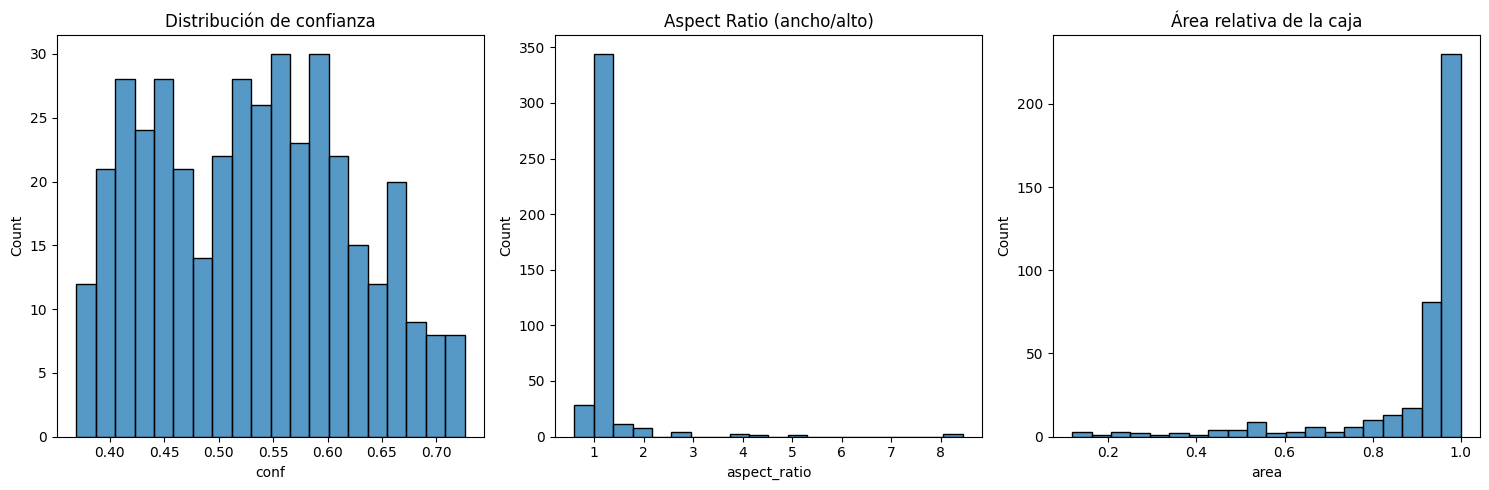

In [6]:
import os
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# === Rutas ===
IMAGE_DIR = '/content/drive/MyDrive/MNA_ProyectoIntegrador/galaxy_dataset_2/images/val'
FP_CSV = '/content/drive/MyDrive/MNA_ProyectoIntegrador/predicciones_val_final/falsos_positivos.csv'
PRED_DIR = '/content/drive/MyDrive/MNA_ProyectoIntegrador/predicciones_val_final'

# === Leer imágenes falsas positivas ===
df_fp = pd.read_csv(FP_CSV)
falsos_positivos = df_fp['falso_positivo'].tolist()

# === Extraer info de cada imagen falsa positiva ===
info = []

for fname in falsos_positivos:
    img_path = os.path.join(IMAGE_DIR, fname)
    pred_path = os.path.join(PRED_DIR, fname.replace('.jpg', '.txt').replace('.png', '.txt'))

    # Cargar imagen
    img = cv2.imread(img_path)
    if img is None:
        continue

    height, width = img.shape[:2]

    # Leer predicciones
    if not os.path.exists(pred_path):
        continue

    with open(pred_path, 'r') as f:
        lines = f.readlines()
        for line in lines:
            parts = line.strip().split()
            if len(parts) < 6:
                continue
            cls, x_center, y_center, w, h, conf = map(float, parts)
            info.append({
                'filename': fname,
                'class': int(cls),
                'conf': conf,
                'x_center': x_center,
                'y_center': y_center,
                'width': w,
                'height': h,
                'aspect_ratio': w / h if h > 0 else 0,
                'area': w * h,
                'img_width': width,
                'img_height': height
            })

# === Convertir a DataFrame y analizar ===
df = pd.DataFrame(info)

# === Estadísticas generales ===
print("\nResumen estadístico de detecciones en falsos positivos:")
print(df.describe())

# === Visualizaciones ===
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.histplot(df['conf'], bins=20)
plt.title('Distribución de confianza')

plt.subplot(1, 3, 2)
sns.histplot(df['aspect_ratio'], bins=20)
plt.title('Aspect Ratio (ancho/alto)')

plt.subplot(1, 3, 3)
sns.histplot(df['area'], bins=20)
plt.title('Área relativa de la caja')

plt.tight_layout()
plt.show()



Resumen estadístico de detecciones en verdaderos positivos:
       class        conf    x_center    y_center       width      height  \
count  627.0  627.000000  627.000000  627.000000  627.000000  627.000000   
mean     0.0    0.577934    0.501307    0.504803    0.979860    0.949036   
std      0.0    0.084035    0.036383    0.059666    0.072976    0.115892   
min      0.0    0.368800    0.108485    0.063757    0.154368    0.127502   
25%      0.0    0.522650    0.498471    0.499453    0.986631    0.954718   
50%      0.0    0.584500    0.499905    0.501867    0.996414    0.982641   
75%      0.0    0.644700    0.500348    0.509681    0.998611    0.993604   
max      0.0    0.750600    0.921863    0.925751    1.000000    0.999792   

       aspect_ratio        area  img_width  img_height  
count    627.000000  627.000000      627.0       627.0  
mean       1.084894    0.933239      640.0       640.0  
std        0.554522    0.137239        0.0         0.0  
min        0.264842    0.0

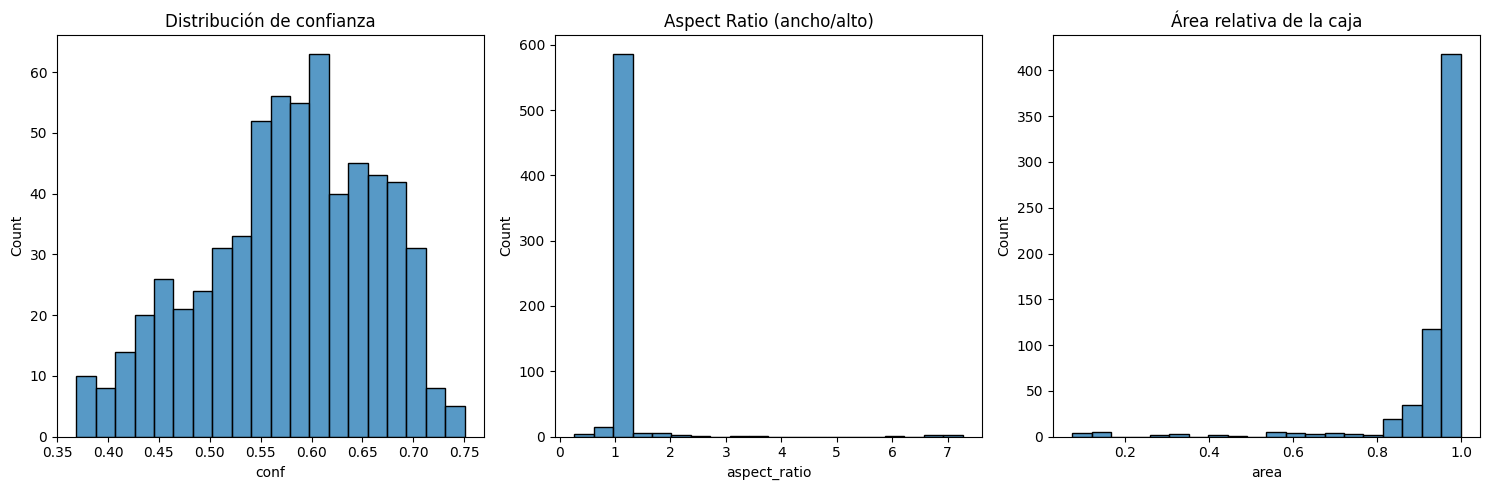

In [7]:
import os
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# === Rutas ===
IMAGE_DIR = '/content/drive/MyDrive/MNA_ProyectoIntegrador/galaxy_dataset_2/images/val'
VP_CSV = '/content/drive/MyDrive/MNA_ProyectoIntegrador/predicciones_val_final/verdaderos_positivos.csv'
PRED_DIR = '/content/drive/MyDrive/MNA_ProyectoIntegrador/predicciones_val_final'

# === Leer imágenes verdaderas positivas ===
df_vp = pd.read_csv(VP_CSV)
verdaderos_positivos = df_vp['verdadero_positivo'].tolist()

# === Extraer info de cada imagen verdadera positiva ===
info = []

for fname in verdaderos_positivos:
    img_path = os.path.join(IMAGE_DIR, fname)
    pred_path = os.path.join(PRED_DIR, fname.replace('.jpg', '.txt').replace('.png', '.txt'))

    # Cargar imagen
    img = cv2.imread(img_path)
    if img is None:
        continue

    height, width = img.shape[:2]

    # Leer predicciones
    if not os.path.exists(pred_path):
        continue

    with open(pred_path, 'r') as f:
        lines = f.readlines()
        for line in lines:
            parts = line.strip().split()
            if len(parts) < 6:
                continue
            cls, x_center, y_center, w, h, conf = map(float, parts)
            info.append({
                'filename': fname,
                'class': int(cls),
                'conf': conf,
                'x_center': x_center,
                'y_center': y_center,
                'width': w,
                'height': h,
                'aspect_ratio': w / h if h > 0 else 0,
                'area': w * h,
                'img_width': width,
                'img_height': height
            })

# === Convertir a DataFrame y analizar ===
df = pd.DataFrame(info)

# === Estadísticas generales ===
print("\nResumen estadístico de detecciones en verdaderos positivos:")
print(df.describe())

# === Visualizaciones ===
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.histplot(df['conf'], bins=20)
plt.title('Distribución de confianza')

plt.subplot(1, 3, 2)
sns.histplot(df['aspect_ratio'], bins=20)
plt.title('Aspect Ratio (ancho/alto)')

plt.subplot(1, 3, 3)
sns.histplot(df['area'], bins=20)
plt.title('Área relativa de la caja')

plt.tight_layout()
plt.show()


In [8]:
import os
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import random

# === Rutas ===
IMAGE_DIR = '/content/drive/MyDrive/MNA_ProyectoIntegrador/galaxy_dataset_2/images/val'
PRED_DIR = '/content/drive/MyDrive/MNA_ProyectoIntegrador/predicciones_val_final'
FP_CSV = os.path.join(PRED_DIR, 'falsos_positivos.csv')
VP_CSV = os.path.join(PRED_DIR, 'verdaderos_positivos.csv')

# === Leer nombres
fp_list = pd.read_csv(FP_CSV)['falso_positivo'].tolist()
vp_list = pd.read_csv(VP_CSV)['verdadero_positivo'].tolist()

# === Tomar muestras aleatorias (máximo 10 si hay suficientes)
fp_sample = random.sample(fp_list, min(10, len(fp_list)))
vp_sample = random.sample(vp_list, min(10, len(vp_list)))

def draw_boxes(img_path, pred_path):
    img = cv2.imread(img_path)
    if img is None:
        return None, []
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    height, width = img.shape[:2]
    boxes = []

    if not os.path.exists(pred_path):
        return img, boxes

    with open(pred_path, 'r') as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) < 6:
                continue
            cls, x, y, w, h, conf = map(float, parts)
            x1 = int((x - w / 2) * width)
            y1 = int((y - h / 2) * height)
            x2 = int((x + w / 2) * width)
            y2 = int((y + h / 2) * height)
            cv2.rectangle(img, (x1, y1), (x2, y2), (255, 0, 0), 2)
            boxes.append((cls, conf, w * h, w / h if h > 0 else 0))
    return img, boxes

def show_images(image_list, title):
    plt.figure(figsize=(20, 10))
    for i, fname in enumerate(image_list):
        img_path = os.path.join(IMAGE_DIR, fname)
        pred_path = os.path.join(PRED_DIR, fname.replace('.jpg', '.txt').replace('.png', '.txt'))
        img, boxes = draw_boxes(img_path, pred_path)
        if img is None:
            continue

        box_info = ""
        if boxes:
            cls, conf, area, aspect = boxes[0]
            box_info = f"conf={conf:.2f}, area={area:.2f}, AR={aspect:.2f}"
        else:
            box_info = "no box"

        plt.subplot(2, 5, i + 1)
        plt.imshow(img)
        plt.title(f"{fname}\n{box_info}")
        plt.axis('off')
    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

# === Mostrar ejemplos
show_images(fp_sample, "Falsos positivos detectados")
show_images(vp_sample, "Verdaderos positivos detectados")


Output hidden; open in https://colab.research.google.com to view.

In [13]:
import os
import cv2
import pandas as pd
import matplotlib.pyplot as plt

# === Rutas ===
IMAGE_DIR = '/content/drive/MyDrive/MNA_ProyectoIntegrador/galaxy_dataset_2/images/val'
FP_CSV = '/content/drive/MyDrive/MNA_ProyectoIntegrador/predicciones_val_final/falsos_positivos.csv'
TP_CSV = '/content/drive/MyDrive/MNA_ProyectoIntegrador/predicciones_val_final/verdaderos_positivos.csv'
DATASET_CSV = '/content/drive/MyDrive/MNA_ProyectoIntegrador/dataset.csv'

# === Leer CSVs ===
df_fp = pd.read_csv(FP_CSV)
df_tp = pd.read_csv(TP_CSV)
df_dataset = pd.read_csv(DATASET_CSV)

# Preparar diccionario de Bars
df_dataset['name'] = df_dataset['name'].astype(str)
bars_dict = dict(zip(df_dataset['name'], df_dataset['Bars']))

# === Función para mostrar imágenes ===
def show_images_with_info(file_list, title):
    plt.figure(figsize=(20, 8))
    for i, fname in enumerate(file_list[:10]):
        img_path = os.path.join(IMAGE_DIR, fname)
        img = cv2.imread(img_path)
        if img is None:
            continue
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        fname_no_ext = os.path.splitext(fname)[0]
        bars_value = bars_dict.get(fname_no_ext, "N/A")

        plt.subplot(2, 5, i + 1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"{fname}\nBars: {bars_value}", fontsize=10)
    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

# Mostrar 10 falsos positivos
show_images_with_info(df_fp['falso_positivo'].tolist(), "Falsos Positivos")

# Mostrar 10 verdaderos positivos
show_images_with_info(df_tp['verdadero_positivo'].tolist(), "Verdaderos Positivos")


Output hidden; open in https://colab.research.google.com to view.